(38, 100) (38, 100)
Values in array a that differ: (394,)
Values in array b that differ: (394,)
[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]
max diff 5.0000000000050004e-06 min diff -5.0000000000050004e-06


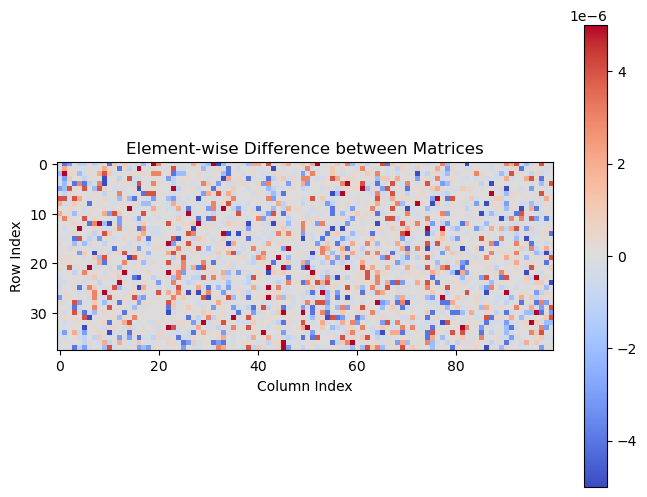

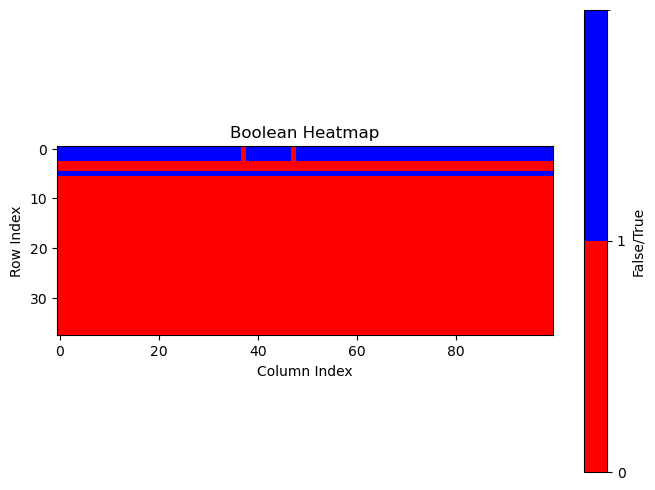

In [24]:
# np.set_printoptions(precision=4, suppress=True, threshold=50)
import numpy as np

# np.set_printoptions(threshold=np.inf, edgeitems=1000)

V=[[-6.8105e-02, -4.5842e-04, -1.1155e-01,  1.2687e-02, -2.4495e-01, -1.9789e-02, -2.8618e-02,  7.3033e-02, -1.0078e-01,  1.4540e-01,  4.0601e-03,  2.3751e-03, -3.8355e-03, -6.7098e-03, -1.3966e-02, -1.7891e-03, -9.0102e-02,  5.6612e-02, -3.4065e-02, -3.5575e-01,  2.6292e-04, -1.6280e-04, -2.1661e-02, -2.3300e-01, -6.9329e-02, -3.7517e-03,  4.3043e-02,  5.2784e-02,  1.0524e-02, -2.8843e-03,  2.2041e-03,  7.8070e-02,  1.2776e-02,  8.7601e-03,  1.1173e-01, -1.4846e-02,  3.0612e-02, -8.2800e-09, -3.0376e-02, -1.6385e-03, -8.8254e-02, -3.2843e-03,  2.1444e-02,  4.3241e-01,  2.1674e-02, -2.8337e-02, -2.4355e-02, -7.5815e-09, -8.4105e-04,  1.8617e-02,  1.8181e-02,  2.5642e-03, -1.2393e-03, -3.9744e-02,  3.0879e-02, -9.7731e-02, -8.0429e-03,  4.8176e-02, -4.3728e-02,  3.6157e-03,  9.6931e-03, -1.4904e-01,  1.3853e-02, -1.4347e-02,  5.2496e-02, -7.4162e-03, -1.7829e-01, -1.1511e-01,  1.8394e-02,  4.1094e-03,  8.8806e-02, -4.4867e-03,  2.6338e-01, -2.6200e-03,  7.5503e-02,  1.2615e-02,  3.9206e-01,  8.8976e-02, -1.7066e-01, -2.2078e-02,  3.3482e-03, -2.9710e-02, -1.1911e-02, -7.7264e-03, -7.2295e-02,  6.0292e-02, -1.7588e-03,  6.5731e-02, -1.1403e-01, -5.3593e-02, -1.4502e-02,  1.9473e-03,  5.1605e-02, -3.2071e-02, -1.3846e-01, -2.0384e-01,  7.5844e-03,  4.7221e-02, -3.5110e-02,  5.0740e-02],
 [-1.8763e-02, -3.1698e-04, -2.4210e-02, -1.6564e-02, -5.5542e-02, -2.8254e-02,  8.0932e-02, -7.0485e-02, -3.6558e-03,  2.3926e-02,  2.2620e-03, -6.2427e-03, -4.6006e-03, -2.2027e-02, -1.0142e-03, -1.9850e-02, -3.9066e-03,  6.5630e-03, -2.9686e-03, -6.6815e-02,  3.5884e-03,  4.6577e-04,  1.2632e-01, -1.5034e-02,  4.3146e-01, -1.2666e-03,  2.2332e-03, -1.5546e-01, -5.0568e-02, -3.4563e-02,  1.7803e-02,  1.5393e-02,  7.9121e-03, -2.2450e-02, -6.2288e-01, -9.3734e-04,  7.5367e-02, -3.2596e-08,  1.1414e-02,  1.1829e-02, -3.7605e-02, -4.2927e-02,  9.4936e-03,  8.5141e-02,  3.1580e-02, -2.3434e-02,  3.1788e-01, -3.7253e-08, -2.6707e-03,  5.2955e-02,  2.4278e-02, -5.8535e-03,  1.2469e-02,  1.0646e-01, -1.9801e-02, -2.0382e-01, -8.5911e-03,  1.5771e-02, -9.7138e-03,  2.1612e-03, -8.7863e-03, -4.0234e-02,  4.1899e-03,  1.4759e-03, -6.5815e-03,  1.5165e-02, -2.3803e-02,  2.6854e-01, -3.7959e-02, -3.7037e-02,  6.8434e-03,  3.2118e-03,  5.5519e-02, -2.0389e-04,  2.3418e-02, -5.2491e-02,  4.1888e-02,  3.1127e-03, -3.9246e-02,  3.6566e-03,  3.1080e-04, -9.6541e-03, -4.3844e-03,  5.1390e-04, -1.2588e-02,  3.4102e-03,  4.4578e-02, -7.0940e-02, -2.2136e-02,  2.7993e-01, -9.9420e-03,  6.6794e-03,  9.2977e-03,  2.1426e-03, -1.3163e-02, -2.2088e-02,  7.3799e-04,  1.8173e-02, -8.1668e-02,  1.5131e-02],
 [ 9.3770e-03,  3.7035e-04,  5.6743e-02, -1.5425e-02,  6.4901e-02, -1.3083e-01,  6.6526e-02,  9.7470e-02, -1.0178e-01, -1.9369e-01, -8.6498e-04, -1.2712e-02, -2.3843e-03, -8.7555e-02,  1.9392e-02, -1.5013e-02,  3.8068e-01,  2.1056e-02,  4.5949e-02, -6.9559e-02,  2.8919e-03,  7.9010e-04, -4.0451e-02,  2.0308e-01, -4.6900e-02,  5.1656e-03, -1.9071e-01, -1.1687e-01,  3.6677e-04,  9.4537e-03,  1.1243e-02,  6.3555e-02, -9.0348e-03, -3.7197e-02,  6.6134e-02,  1.8977e-02,  4.1379e-02, -1.1362e-07,  1.2171e-01,  7.3822e-03, -8.8963e-02,  6.7620e-02,  9.2942e-02, -1.6075e-01,  4.0587e-02, -1.1756e-01,  7.0246e-02, -1.4342e-07, -1.3543e-02,  2.6230e-01, -3.2943e-03, -4.5110e-03,  3.9555e-03, -3.4943e-02,  3.0807e-02, -1.4298e-01, -2.4238e-03,  1.8812e-02,  1.8533e-02,  2.4407e-03, -1.2617e-02,  1.1417e-01, -1.6687e-02,  7.1446e-02, -3.5164e-01,  1.1414e-02, -1.7507e-01, -8.6008e-02, -3.7025e-02, -1.1478e-02, -1.0314e-01, -5.1161e-03, -3.0972e-02, -4.3882e-03,  1.0660e-02,  1.0766e-02,  3.5984e-01, -1.8948e-01, -1.9767e-01,  4.2843e-02,  2.9858e-02, -1.8037e-02, -4.3779e-04,  4.4450e-02,  6.6392e-02, -6.7432e-02, -5.3353e-02, -2.2855e-02,  5.6976e-02, -2.2646e-02, -2.9869e-02,  5.3114e-03,  1.8856e-02,  9.8786e-02, -1.4519e-01,  1.1222e-01, -1.1692e-02,  7.3881e-02, -2.1873e-02, -2.3582e-02],
 [-2.3608e-02, -1.0378e-03, -7.0283e-02,  4.2353e-03, -1.3180e-01, -1.8888e-01, -1.7773e-02, -1.4494e-01,  7.4367e-02,  5.7210e-02,  3.0630e-03,  2.1663e-02, -5.9351e-02, -1.1354e-01, -2.5749e-02,  2.9764e-02,  2.9542e-01, -1.0324e-01, -7.3739e-02, -4.3750e-03, -8.0632e-03,  9.6901e-04, -4.2364e-02, -2.0511e-01, -1.1626e-02,  6.9076e-04, -1.4988e-01,  3.4887e-02, -2.5649e-02,  8.1292e-03,  1.6287e-02, -5.5283e-02,  2.4202e-02, -4.3596e-02,  1.5664e-02, -2.1909e-02, -7.2584e-02,  8.0816e-07,  1.0311e-01,  3.0150e-03, -6.6989e-02,  7.7239e-02,  4.5940e-04,  2.5965e-01, -2.3225e-02, -1.6546e-01, -5.2983e-02,  9.7556e-07, -1.6273e-02,  3.0110e-01,  1.6421e-03,  5.3878e-03, -2.2464e-02,  8.3045e-02, -5.3861e-02,  1.4590e-01, -3.6137e-03,  1.0639e-01, -3.1461e-02, -1.2493e-02,  2.4088e-02, -7.8575e-02, -2.1434e-03,  5.7685e-02, -3.3952e-01, -1.3013e-02,  1.8361e-01,  3.2964e-02,  3.7128e-03,  6.2278e-02,  1.5708e-01,  9.3633e-03,  8.4609e-02,  4.3075e-03, -2.5314e-02, -4.2591e-02, -3.0815e-01, -9.1163e-02,  2.2192e-01, -6.8049e-02,  2.4985e-02,  2.2409e-02,  5.3394e-02,  3.8690e-02, -9.5406e-02,  7.4370e-02,  9.8995e-02,  1.3990e-02, -1.1110e-01, -7.1673e-03,  4.0165e-02,  1.9331e-02, -3.1441e-02,  1.4098e-01,  1.3237e-01, -7.8814e-02,  1.9636e-02, -9.0233e-02,  1.6808e-02,  3.5896e-02],
 [ 1.7891e-02, -1.3572e-03,  3.0024e-02,  2.2600e-01,  1.0574e-01, -6.4706e-02, -2.5217e-01,  9.0698e-02, -2.0868e-01,  1.7835e-01,  8.2721e-03,  1.1581e-02,  1.3692e-01, -5.5375e-02, -1.8946e-03,  3.4334e-04, -3.5230e-02, -9.5699e-03, -3.1948e-02,  9.4049e-02,  7.4446e-03,  6.7970e-04,  1.5942e-01, -1.0076e-01,  5.9597e-02,  7.7649e-03,  3.7306e-02,  1.8379e-01,  3.6982e-02, -7.0426e-02, -1.2561e-01, -2.6945e-02,  3.0298e-02, -2.8256e-02, -7.2372e-02, -5.0258e-03, -3.4049e-02,  6.2166e-05,  4.7988e-02, -1.9905e-02, -1.9174e-02, -5.3449e-02,  1.9146e-01, -9.5212e-02, -8.9033e-02, -2.0318e-01, -1.3489e-01,  7.5355e-05, -7.9694e-03,  1.3310e-01,  6.8919e-02, -1.2224e-02,  1.1918e-01, -9.9714e-03, -1.0281e-02,  9.6825e-02, -4.2893e-02, -5.4371e-02,  1.1851e-02,  1.5511e-02,  1.2929e-02, -2.5377e-01, -2.2401e-02, -4.9856e-02, -1.3206e-02,  2.7558e-02,  1.6128e-02,  1.9169e-02,  1.6776e-01, -2.9748e-01,  6.0422e-02,  2.0690e-03, -1.2724e-01,  8.4692e-03,  3.2852e-01,  4.7323e-02, -4.3334e-03, -4.9439e-02, -7.8663e-02, -3.3775e-02,  2.3558e-02, -2.4523e-01,  3.8456e-02, -6.3401e-03,  3.9889e-02,  1.4861e-02, -7.7817e-02, -4.3466e-02,  1.3113e-01,  4.7771e-02, -5.8967e-02,  3.4522e-03,  4.1030e-05,  9.5639e-03, -1.2779e-03,  9.7403e-02,  9.1198e-03,  1.1517e-01,  6.4355e-02,  1.6806e-01],
 [ 7.8828e-02, -1.5273e-03,  3.5420e-03, -7.4004e-02,  5.8595e-02,  4.5776e-02,  1.1146e-01, -3.0548e-01, -1.0205e-01,  1.0959e-01,  2.7816e-02, -7.0499e-04,  1.0892e-01,  7.3754e-03,  5.3187e-02, -9.7958e-03, -6.4628e-02,  4.2094e-02,  7.2535e-03,  7.1071e-03, -8.7006e-04,  6.3621e-04, -1.4059e-01, -9.5554e-03, -1.0865e-01, -7.5362e-03,  2.5863e-02, -8.3632e-02, -2.9371e-01,  6.8661e-02,  2.8329e-02,  4.4795e-02, -3.8983e-03, -1.1645e-02,  1.2615e-01,  1.1016e-02,  4.3165e-02, -1.2688e-03,  2.5112e-02,  8.6753e-02, -6.8067e-02,  3.7792e-02,  7.7884e-02, -1.4693e-02,  1.9624e-01, -8.6479e-03,  7.7646e-02, -1.5380e-03,  9.1310e-04, -1.5898e-02, -6.9185e-02, -2.5778e-02, -3.6871e-02,  4.4310e-01, -2.7746e-01, -9.4575e-02, -1.1065e-01, -1.0421e-01,  2.8528e-03, -7.0407e-03,  7.8435e-03, -1.8528e-01,  3.5576e-02,  5.0931e-03,  5.8203e-02,  3.6638e-02, -8.2673e-02, -1.0505e-01, -9.0192e-02,  7.7664e-02, -1.5100e-02,  5.3608e-02, -1.1478e-01, -4.4429e-03,  1.4498e-01, -6.2414e-02,  1.0203e-01, -5.7052e-02,  1.7382e-01,  1.1519e-03, -2.8230e-02, -1.4201e-01, -7.3220e-02, -5.5551e-03, -9.7734e-04, -2.2079e-02,  1.5246e-01, -1.7439e-01, -3.9003e-02, -2.8415e-02,  1.9495e-02,  1.3828e-02, -6.6565e-02, -3.5476e-02, -4.8614e-02,  1.5083e-01,  4.1492e-03, -7.4177e-02,  8.8074e-02,  1.3816e-01],
 [ 8.9391e-02, -5.8671e-02,  8.6966e-03, -1.2771e-01,  7.9158e-02,  1.3823e-01, -4.8015e-02,  1.4244e-01, -1.1899e-01, -7.3875e-02,  1.0005e-01,  1.1743e-01, -2.6747e-02,  4.7909e-02,  1.9085e-01,  8.4156e-02,  4.5636e-02, -2.3424e-02,  3.2650e-02, -9.1152e-02, -6.3103e-02,  1.1558e-02, -4.6732e-02, -2.9760e-03, -3.6514e-02,  1.9470e-01, -1.3854e-01,  9.6992e-02, -1.2112e-02,  1.6794e-03,  1.4575e-02, -7.4011e-02, -9.0839e-02, -2.2603e-02, -3.9499e-02,  1.2091e-01,  1.1228e-01, -4.3292e-02,  7.4797e-02, -8.4906e-02,  1.2177e-01, -3.0607e-02,  6.5876e-02, -6.4148e-02,  7.7972e-02, -1.4935e-02,  3.7910e-02, -5.2475e-02, -2.5269e-03, -2.0172e-01,  8.5959e-02, -2.8546e-01, -1.5969e-01,  3.6148e-02, -1.6807e-01,  2.3175e-02, -5.3651e-03,  9.9462e-03,  1.0953e-01, -9.3991e-02,  1.6054e-01, -6.9336e-02, -1.7808e-01,  1.7784e-01, -1.2257e-02, -1.3725e-01,  3.5412e-02,  9.8820e-02,  1.7933e-01,  2.9663e-03,  9.3317e-02, -6.1485e-02,  1.9244e-01, -4.5308e-02, -1.1921e-02, -6.5286e-03, -5.7771e-02,  3.7669e-02,  4.9154e-02, -5.1459e-02,  6.5313e-02,  2.7538e-02, -5.2261e-03,  4.9425e-02, -5.1115e-02,  7.5951e-02, -7.8898e-02, -1.0482e-01, -1.1203e-02, -2.4617e-02, -2.0866e-01,  2.0125e-01, -7.8655e-02,  1.6524e-01, -1.4076e-01, -6.8432e-02,  2.1730e-01,  6.0629e-02,  2.7141e-02, -6.3752e-02],
 [ 1.6291e-01, -1.3904e-02, -5.1578e-02,  4.4528e-04,  1.1845e-01, -8.0178e-02,  1.1682e-01,  4.9189e-02,  4.3238e-03, -4.3750e-02,  2.3385e-02,  5.3552e-03,  2.2457e-02, -1.2446e-01, -1.8067e-02,  3.3241e-02, -1.3382e-01,  1.2607e-01,  2.0155e-01,  1.7421e-02,  3.6025e-02,  1.6291e-04,  5.0397e-03,  4.3370e-02, -5.7141e-02, -9.5510e-02,  1.8350e-01, -3.9377e-02,  1.0112e-01,  5.2762e-02,  1.3456e-01,  3.8631e-02,  1.0797e-01,  1.1790e-01, -2.5493e-03,  5.7111e-02,  9.0366e-02, -4.4526e-03,  1.0777e-01,  4.6017e-02, -1.7603e-01, -2.5049e-02, -2.1310e-02, -6.1204e-02, -3.4673e-02, -1.3702e-01,  1.4313e-01, -5.3971e-03, -2.2296e-02,  1.8360e-01,  8.2702e-02, -1.4287e-01, -1.2304e-02, -1.2831e-01,  1.9893e-02,  1.3886e-01,  5.8805e-02,  5.1839e-02,  1.0831e-02, -1.0445e-01, -1.5845e-02, -1.4883e-01,  2.4691e-01, -1.2319e-01,  2.1414e-02, -3.7762e-01, -1.1045e-01, -2.0013e-02, -4.6326e-02, -1.8621e-01,  2.5102e-02, -6.8022e-02,  5.4784e-02,  1.1595e-02, -1.1352e-01, -3.6360e-02, -5.5795e-02,  3.6267e-02,  8.7614e-02,  2.3002e-01,  4.3685e-02, -9.8184e-03, -1.5277e-02, -5.1988e-02, -1.2882e-01,  1.6989e-01,  7.7730e-02, -8.6547e-02, -4.4551e-02, -8.0090e-02, -7.7758e-02, -3.8066e-05,  3.0315e-02, -7.9087e-02, -6.1989e-02,  3.0618e-02,  4.0009e-02, -1.9878e-01, -1.9656e-02, -5.9626e-02],
 [ 1.1100e-01,  7.6333e-02, -6.2821e-02, -1.0708e-01,  6.1514e-02, -5.1839e-02,  1.5403e-01,  2.0900e-01,  6.9580e-02, -6.4906e-02,  9.0204e-02, -3.0778e-02,  1.0885e-01, -1.3697e-02, -8.8566e-02,  4.9212e-02,  9.8608e-02, -1.8965e-01, -1.3123e-01, -5.0132e-02,  2.2876e-02,  7.1476e-05,  1.9032e-02, -1.4964e-01, -4.3697e-02,  2.8680e-02, -1.5556e-02,  3.1021e-02,  8.3673e-02,  2.3718e-02,  7.3479e-03, -1.4612e-01, -3.0692e-02, -6.1448e-02,  2.5932e-01,  1.6590e-02, -9.6532e-02,  4.5483e-02,  8.6278e-02, -3.5171e-02, -4.4388e-02, -2.8280e-03, -4.5170e-02, -2.9908e-01,  1.1192e-01,  1.3069e-01,  6.1596e-03,  5.5130e-02, -8.8240e-03,  2.2792e-01, -9.3511e-02, -4.6921e-02, -2.8292e-04,  2.2430e-02,  1.4941e-01,  1.0045e-01, -3.3707e-02,  3.3414e-02,  5.2637e-02, -6.0906e-03, -4.5450e-02, -7.3261e-02, -6.7662e-02, -6.4904e-03, -1.2704e-01, -8.6607e-03,  3.5253e-02, -5.8449e-02,  1.1856e-01,  1.3636e-01, -2.3524e-03, -1.2379e-02, -4.2667e-01,  3.6237e-02,  6.9433e-02,  1.2296e-01,  1.2790e-01, -1.5119e-01,  3.1999e-02, -6.3723e-02,  8.0548e-02,  1.7125e-02,  2.8232e-02,  1.6451e-02, -1.1917e-01, -3.7951e-03, -1.4626e-01, -2.5172e-02, -9.1689e-02, -1.4120e-02, -1.0833e-01,  5.3087e-02,  4.1325e-02,  1.1533e-02,  1.0307e-02,  1.1736e-01,  6.1407e-02, -8.4905e-02,  5.8489e-02,  2.0057e-02],
 [-7.8921e-02, -1.2283e-01, -7.7020e-02,  2.8276e-02, -2.4150e-01,  7.7461e-02, -3.4545e-02, -9.7576e-02, -4.7455e-04, -9.1916e-02, -2.0520e-02, -6.2775e-02, -4.9503e-02,  7.1912e-02, -2.1139e-01,  6.3172e-02,  8.0328e-02, -5.8352e-03,  2.4440e-02, -2.4900e-01,  4.0422e-02,  2.6913e-03,  3.0954e-02, -3.0290e-02,  2.2561e-01,  3.8730e-02,  1.1631e-01,  6.6986e-02, -8.6133e-03,  5.9237e-03,  1.2866e-01,  1.0611e-01, -7.7918e-02,  1.0208e-01,  6.2282e-03, -1.0753e-01,  1.1141e-01, -6.0692e-02, -1.2709e-01, -6.5617e-02,  1.0226e-01, -3.1672e-02,  1.3546e-03, -1.3166e-01,  1.6586e-01,  1.1059e-01,  2.1327e-01, -7.3566e-02,  1.7051e-02,  5.9523e-02, -7.5921e-03,  9.4587e-02, -2.1450e-02,  9.7353e-02,  8.5830e-02,  1.1173e-01, -6.7758e-02,  8.5802e-02, -2.5898e-02, -1.3947e-01, -1.4176e-03,  4.3651e-02,  2.7848e-02,  1.4887e-01,  8.0172e-02, -4.6570e-02, -9.5015e-03,  1.1911e-01, -1.2705e-02, -4.4966e-02, -1.1443e-01, -5.2553e-02, -5.2932e-03,  6.4945e-03,  1.4052e-01,  6.2076e-02, -7.2054e-02,  6.3300e-02,  7.0425e-02,  8.1255e-02, -6.7451e-02,  9.3172e-02,  1.1199e-01,  1.2734e-01, -1.6965e-01, -9.6060e-02,  7.0171e-02, -3.7515e-02, -2.1543e-02,  5.7506e-02, -1.0362e-01,  7.6010e-02, -2.8816e-03, -1.1207e-01,  3.3569e-02, -3.6656e-01, -1.2568e-01, -9.0776e-02,  8.3397e-02,  4.7256e-02],
 [-1.0463e-01, -4.2709e-02,  4.4427e-02,  1.3397e-01, -4.1592e-02,  3.1310e-02, -9.8210e-02,  2.5776e-02, -3.4655e-03,  1.7661e-01, -1.2896e-01,  1.2089e-01,  1.2045e-01,  4.5247e-02,  4.9321e-02, -2.5497e-03,  4.7245e-02,  1.4333e-01, -2.5123e-02, -4.8356e-02,  3.7735e-05,  3.3407e-03,  5.7049e-03, -9.7636e-02, -3.8988e-02, -3.2807e-02,  1.9972e-01,  8.2220e-02,  9.6252e-02, -2.4346e-02, -8.1831e-02,  1.1017e-01, -5.5171e-02, -4.0808e-02,  3.1909e-01, -2.9515e-02,  1.7055e-01, -2.6939e-02,  1.1892e-01,  1.5102e-02,  1.9267e-02,  8.1996e-02,  1.2581e-01, -3.3820e-01, -1.0675e-01, -1.3914e-01,  7.3179e-02, -3.2653e-02,  9.4325e-03,  2.9662e-02,  6.5705e-02, -2.5619e-02, -2.3165e-02, -5.4746e-02, -9.8403e-02,  1.7053e-01, -1.0254e-01, -2.3829e-01, -8.6223e-02,  2.2764e-02,  1.2273e-01,  6.1451e-02,  5.7322e-02,  3.8731e-02,  1.7685e-01,  5.3449e-02, -2.5428e-02,  5.1310e-02, -1.2060e-01, -1.0328e-01,  1.4882e-01,  6.8371e-02, -8.3532e-02, -8.9644e-03, -8.7167e-02, -7.8760e-02, -2.2253e-02, -1.7236e-01, -2.1585e-01, -8.4009e-02, -1.8831e-02,  8.7292e-03,  5.0869e-02, -1.6474e-02,  8.5489e-02, -1.2283e-01,  3.5097e-02, -1.1838e-01,  5.8955e-02, -4.8064e-03,  1.8683e-02, -6.1418e-02, -1.1715e-01,  1.0181e-01, -8.0343e-02,  2.1991e-02, -3.6978e-03,  9.6433e-02,  5.7902e-02, -2.2061e-03],
 [ 6.3404e-02,  1.0608e-01, -9.5458e-02, -1.6063e-01, -7.3736e-02, -1.3674e-01,  9.6042e-02, -6.6498e-02,  3.7338e-02,  9.9200e-02, -3.8903e-02,  5.2615e-02, -1.1113e-01, -2.8961e-02,  4.3477e-02,  4.3165e-02,  2.9028e-01,  6.1562e-02,  9.5796e-02, -9.6679e-02, -4.6569e-02, -3.9777e-03,  1.9709e-02, -3.3917e-02,  2.3387e-01, -2.8174e-03, -3.2143e-02, -1.0656e-01, -1.0858e-01,  4.9338e-02, -1.5924e-01, -1.1797e-01,  9.2877e-02, -7.2117e-02,  2.4617e-02,  2.9415e-02,  4.8348e-02,  5.4261e-02, -1.4935e-02, -7.5888e-02, -1.4328e-01,  1.1656e-01, -2.6232e-02,  8.3138e-02, -8.4204e-03,  9.3958e-02,  1.5657e-01,  6.5770e-02, -1.2128e-02,  1.8092e-02, -6.1645e-02, -4.7184e-02, -5.1474e-02, -9.2835e-02, -9.5707e-02,  6.1500e-02,  4.8109e-02,  1.6834e-02, -7.5623e-02,  1.3877e-01, -4.6479e-02, -6.5008e-02,  3.4789e-02,  4.3341e-02,  9.5710e-02, -3.0865e-03,  1.4753e-01,  1.3042e-01, -1.2503e-01,  1.1804e-01, -1.9250e-02,  2.0426e-02, -9.2003e-02, -1.7136e-02, -1.4754e-01, -2.0259e-02, -5.9368e-02,  7.6542e-02, -5.9037e-02,  1.5244e-01,  7.9773e-02, -5.1370e-03, -9.8748e-02, -3.1038e-02, -5.5322e-02,  2.4084e-02, -4.9253e-02,  4.8149e-02, -2.2470e-01,  1.7404e-01,  1.9663e-01, -1.1676e-01, -8.4135e-02,  3.1207e-01, -6.3100e-02, -1.8301e-01,  1.0295e-01, -1.9066e-02, -1.1306e-01, -7.2931e-02],
 [ 6.6043e-03,  3.7955e-02,  9.9877e-03,  4.0200e-02, -6.0710e-04,  3.6959e-02, -1.9608e-01, -1.0584e-01, -1.3052e-01, -1.5647e-01,  1.3733e-01, -5.1004e-02, -1.9458e-01, -4.8788e-02,  4.9163e-02, -2.1140e-02,  9.3543e-02,  1.2452e-01,  4.9403e-02,  9.4869e-03,  8.3651e-03, -5.7904e-03,  1.4222e-01,  1.8972e-01,  4.7094e-02,  5.3057e-02,  3.7609e-02,  1.1416e-01, -1.5519e-01, -2.3394e-02, -9.2205e-02, -4.3379e-02,  4.8519e-02,  3.3421e-02,  3.1530e-01,  3.8794e-02, -7.6881e-02,  2.0658e-02, -1.7288e-01, -2.7277e-02, -6.6350e-04, -4.4261e-02, -4.8449e-02, -1.9146e-01,  3.7668e-02,  3.9179e-02, -1.9881e-01,  2.5040e-02, -6.1618e-03, -1.0790e-01,  3.0345e-02,  2.7676e-02,  1.0615e-01, -1.3839e-01, -3.1092e-02, -5.4213e-03,  1.1483e-02, -9.7622e-03,  1.0530e-01,  5.1531e-02, -4.9837e-03, -7.4469e-02,  3.3701e-03, -1.0602e-01,  3.8225e-01,  2.9110e-03, -8.0689e-02, -7.9720e-02,  2.5774e-02, -1.8180e-01,  2.5782e-02, -9.9535e-02, -1.0331e-01, -4.3051e-03,  1.3154e-01,  1.1687e-01,  9.4031e-02,  1.5762e-01,  1.1400e-01,  4.1202e-02, -4.8476e-02, -1.9721e-01, -1.1736e-01,  3.7594e-03, -6.1608e-02,  1.1944e-01, -1.3921e-01,  3.6150e-02,  3.4821e-02,  1.5749e-02,  4.6462e-03,  1.8409e-02,  3.4127e-02, -3.0652e-02,  3.6991e-02,  3.7200e-02,  3.9593e-02,  6.1734e-02, -4.3797e-02,  5.7352e-03],
 [-1.2262e-01, -9.9931e-02, -6.9356e-03, -7.1660e-02, -1.6381e-01, -5.6517e-02, -3.2020e-03, -8.9624e-02,  4.7707e-02, -2.2801e-02,  9.1694e-02, -5.9863e-02, -1.4958e-01, -6.1879e-02,  6.2845e-02, -8.5184e-02,  2.3827e-01, -1.0548e-01, -4.8149e-02, -6.8257e-02,  3.1730e-02,  4.3657e-03,  4.5620e-03, -5.0350e-02,  2.1757e-01,  1.6986e-02,  4.2009e-02, -1.3416e-01, -6.1622e-03,  2.6087e-02,  8.3602e-02,  2.9598e-02, -4.7751e-02,  5.5453e-04, -4.8823e-03,  4.5893e-02, -9.4051e-02, -5.2907e-02,  1.5085e-01,  9.1957e-02,  5.8866e-02,  7.5143e-02, -9.9653e-02,  2.7651e-02, -6.0823e-02, -2.3187e-01,  1.1527e-02, -6.4128e-02,  1.4340e-04,  2.3411e-01, -1.3817e-02,  5.8563e-02, -4.9165e-02, -9.5073e-02, -6.9269e-02, -2.3328e-01,  1.5195e-02, -1.1050e-01,  7.8929e-02, -1.3149e-01,  7.3031e-02, -6.1801e-02,  4.0688e-03, -3.0991e-02,  4.0281e-03,  3.9706e-02, -5.2118e-02,  1.8845e-01, -9.5402e-02,  9.7191e-02,  2.2054e-01, -5.4444e-02,  7.4485e-02,  5.5431e-03, -1.3370e-01, -9.0507e-02,  2.6501e-02, -1.1768e-01,  9.5993e-02, -1.6165e-01, -1.1257e-01, -1.1144e-01, -1.3556e-03,  4.5485e-02, -1.0108e-01,  1.6892e-01, -7.4811e-03, -1.0613e-01, -2.4570e-03,  1.1689e-01, -1.3738e-01,  1.5097e-01,  1.5207e-01, -1.5020e-02,  1.6718e-01,  1.9235e-01, -7.4708e-02,  3.3423e-02, -4.0598e-02, -1.9884e-02],
 [-4.1459e-03, -7.6698e-02,  1.0095e-02, -8.9181e-02,  7.0024e-02,  9.4855e-02, -4.5074e-02,  1.1884e-01, -3.4419e-02,  1.7745e-01, -1.1059e-01, -5.9809e-02,  4.3031e-02,  2.2213e-01,  2.2703e-02, -4.3547e-02, -8.1959e-02, -2.2021e-01,  9.9035e-02,  3.9997e-02, -3.6172e-02,  7.8971e-03, -7.0387e-02,  4.1056e-03,  9.2475e-04, -5.2752e-02,  1.8501e-01, -1.2678e-01,  2.8617e-02,  2.2894e-02, -2.6413e-02, -4.6732e-02, -3.9365e-02,  1.5763e-01,  2.7368e-01,  7.9379e-02, -1.6373e-01, -3.8841e-02,  9.5817e-02,  1.9176e-02,  1.4199e-01,  6.2617e-02, -7.9452e-02,  2.6971e-02, -1.7896e-01,  8.5412e-02, -1.5339e-01, -4.7080e-02,  3.5159e-02, -1.1955e-01, -5.7257e-02,  2.1741e-02, -5.7542e-02, -5.4311e-02, -1.0162e-01, -5.7632e-02,  1.4834e-01, -7.8453e-02, -7.4871e-02, -1.6050e-01, -9.2927e-02, -7.5013e-02,  3.5232e-02,  1.2658e-01,  8.4063e-02, -4.1395e-02,  5.3601e-02,  6.7700e-02,  8.8102e-02,  1.0129e-01, -3.1106e-01,  7.1216e-02, -5.7929e-02, -9.5853e-03, -2.0592e-01, -1.3881e-01,  3.3641e-02,  2.2868e-01, -1.0679e-02,  9.9983e-02, -3.1278e-03, -7.2092e-02, -1.4726e-02,  2.3010e-02,  3.7210e-04, -7.3451e-02, -5.6233e-02,  4.3270e-04,  2.9727e-02, -3.3669e-02, -6.4612e-02,  3.9809e-02,  1.3829e-01, -5.4512e-02,  1.7296e-02, -9.9649e-02, -9.5209e-02, -7.9522e-02,  2.6024e-02, -1.2774e-01],
 [ 4.8315e-02,  6.7205e-02,  5.0288e-02,  1.1697e-01,  1.2965e-01, -5.2218e-03, -1.1483e-01, -1.1786e-02, -2.5458e-01, -2.2488e-02, -6.5023e-02,  6.0710e-02,  2.3684e-02,  1.4268e-02, -2.2595e-02, -4.1373e-02,  2.1866e-01,  3.5138e-02, -2.5538e-01,  8.1529e-02, -6.2687e-02,  5.2132e-03,  9.0610e-02, -1.1418e-01,  2.1284e-01, -6.4458e-03,  5.1716e-02, -1.0072e-01, -1.5868e-01, -9.8200e-02,  1.0009e-02,  3.9391e-02,  9.1031e-02,  1.0850e-01, -1.4980e-02, -6.4425e-02, -2.7967e-02,  3.7859e-02,  2.3384e-01,  7.6413e-02, -5.8618e-02, -9.2846e-02, -5.5276e-02,  3.5539e-02, -3.9982e-02, -7.9024e-02, -4.4002e-02,  4.5889e-02, -3.8315e-03,  1.6090e-01,  9.6996e-02, -8.2194e-02,  1.0337e-01,  1.3875e-01,  2.9619e-02, -6.5621e-02, -5.8625e-02,  1.2913e-01, -1.0201e-01,  4.5329e-02, -1.2657e-02, -3.0641e-02, -2.6902e-02,  1.8185e-01, -1.7456e-01, -5.6442e-02, -8.1340e-02,  4.6754e-02,  4.8919e-02, -2.9832e-01, -1.2935e-01,  3.2855e-02, -4.9384e-02, -4.4525e-02, -1.8168e-02, -3.7423e-02,  9.8466e-02,  1.2667e-01,  6.0705e-02, -1.3889e-01,  1.2561e-01, -9.6150e-02, -3.9003e-02,  6.9151e-02,  9.7737e-02, -1.3567e-01,  1.5362e-02, -4.6395e-03,  5.1251e-02,  1.5747e-01, -4.5477e-02, -1.2383e-02, -1.2818e-01, -9.8474e-02, -1.3784e-01, -3.6294e-02,  9.6053e-02, -7.1017e-02, -1.1530e-01, -1.7383e-03],
 [ 1.2845e-02,  8.0378e-02,  2.1122e-02, -1.1366e-01, -6.7543e-02,  2.7491e-01,  7.7393e-02,  1.3620e-02,  8.8655e-03, -1.8394e-01,  6.5359e-02, -8.6937e-03, -2.8409e-02, -7.2657e-02, -5.3322e-02,  6.4515e-04, -3.5211e-02,  9.8293e-02, -1.5625e-01,  5.0797e-02,  1.4433e-02, -2.6934e-03, -2.0534e-01, -1.9473e-01, -1.6930e-02,  3.2584e-02,  1.6705e-01, -1.6829e-02,  5.1399e-02,  9.2264e-02,  7.0091e-02,  1.9246e-02,  6.1884e-02,  4.6941e-02,  2.3743e-01, -1.5076e-01,  9.0920e-02,  3.7064e-02,  9.3395e-02, -3.9828e-02, -6.3279e-03, -6.3838e-02, -2.0744e-01,  1.0466e-01,  5.4500e-02, -1.6629e-02, -6.1915e-02,  4.4925e-02, -1.6464e-02, -9.1244e-02, -3.4802e-02, -6.6141e-02, -1.4682e-01, -7.1475e-02,  1.6817e-01,  3.0940e-02, -1.1792e-01,  7.1782e-02,  6.6326e-02,  1.3564e-01, -7.5217e-03,  7.5187e-02, -1.2138e-01, -4.6042e-02,  1.9002e-01, -4.6316e-02,  7.4870e-02, -1.5271e-02, -1.3020e-01,  8.9144e-02, -1.3818e-01, -5.5906e-02,  1.8857e-01, -2.0302e-02, -1.8956e-01,  9.7693e-02, -2.3914e-01,  6.6405e-02,  1.8866e-02, -1.5861e-01,  7.2181e-03,  4.6532e-02,  1.0957e-03,  3.0740e-03,  4.6343e-02, -4.5835e-02,  9.7144e-02,  1.1849e-01, -1.3582e-01,  3.2831e-02,  4.9879e-03,  3.5020e-03, -1.2275e-01, -4.5219e-02,  5.4011e-02,  1.9876e-01, -3.7259e-02, -4.8196e-02, -4.7066e-02,  2.8484e-02],
 [ 4.2028e-02, -5.1248e-02,  2.9423e-02, -4.7890e-02,  9.5509e-02,  5.1861e-02, -6.3640e-02,  3.4983e-02, -8.7439e-02, -6.3864e-02,  3.7733e-02, -1.1668e-01,  7.7220e-02, -7.9432e-02, -3.0046e-02,  7.4199e-02,  1.0256e-01, -6.7411e-03,  1.0178e-01, -3.1122e-02,  7.0399e-02, -3.5077e-03,  3.1853e-02, -8.8107e-02,  1.1487e-01, -6.2378e-02, -8.6730e-02,  2.5927e-02,  1.4020e-01, -2.4078e-05, -1.3356e-01,  5.5674e-03, -8.2814e-02, -1.6384e-02, -7.0133e-02,  1.9984e-02,  4.8106e-02, -3.2627e-02, -6.1601e-03, -2.0952e-01, -8.4393e-02,  2.9236e-02, -1.3766e-02, -7.9857e-02, -3.7176e-03, -2.0082e-01,  1.7960e-01, -3.9548e-02, -7.3434e-03,  6.7442e-02, -3.5070e-03,  3.7182e-02, -5.9665e-02,  1.2460e-01, -1.0939e-01, -7.1551e-02,  1.9885e-02,  1.3101e-01,  1.4028e-01, -2.6656e-02, -9.7334e-02, -1.7202e-01, -3.3979e-03, -9.2879e-02,  5.4563e-02,  3.7332e-02, -3.0736e-02, -2.5780e-02,  5.2428e-02, -1.0386e-01, -3.3400e-01,  1.5033e-02,  1.3354e-01,  5.8783e-02,  1.0291e-01,  9.2494e-02,  4.2248e-02,  7.4608e-02, -2.9337e-01,  2.2243e-02, -4.1055e-03, -1.0242e-01,  5.5036e-02, -5.2369e-03,  4.4818e-02, -1.0330e-01,  4.3750e-02,  7.9354e-02,  6.4385e-02,  9.7049e-02,  5.0293e-02,  9.8318e-03,  1.7215e-01,  2.2319e-01, -3.1992e-02,  2.7568e-01, -1.7552e-01,  6.3321e-02,  2.1815e-01, -4.0201e-03],
 [ 7.5539e-02, -9.4759e-02, -8.8201e-02, -5.4041e-02,  1.2735e-01, -1.7343e-01, -5.4994e-02, -1.1089e-01,  8.0227e-02,  3.4735e-02, -4.5683e-02,  3.5047e-02,  1.4494e-02,  1.3907e-01, -4.1147e-02,  6.7165e-02,  4.6049e-02,  2.2405e-02, -2.2960e-01,  2.6109e-02,  2.1522e-03,  2.4708e-03,  1.6215e-01, -1.9105e-01, -9.5586e-02, -3.5330e-02, -1.6672e-01,  9.4601e-02,  5.1426e-02, -9.3048e-02,  3.4197e-02,  1.2954e-02, -1.2702e-01, -7.0940e-02,  1.1390e-01,  1.0509e-01, -1.2307e-01, -3.9779e-02, -2.2367e-02,  8.7834e-02,  6.7559e-02,  1.1830e-01, -1.6480e-01,  5.7042e-02,  5.3970e-02, -3.2836e-02,  1.5616e-01, -4.8216e-02,  2.6483e-02, -9.7434e-02,  2.0703e-02,  1.0424e-01,  9.0618e-02,  1.1752e-01,  1.2199e-02,  1.2859e-01, -5.6503e-02,  1.4459e-01, -9.6624e-02, -1.2464e-01,  2.9422e-02, -9.6560e-02,  1.8354e-01, -2.4778e-02,  1.1582e-01,  1.3108e-01, -4.5061e-02, -1.5829e-01, -8.9880e-02, -5.2806e-02,  1.4019e-01,  2.2495e-02,  9.3451e-02,  3.7780e-02, -9.8507e-02, -1.0990e-02, -2.2670e-01,  1.8134e-01,  1.4539e-01, -1.9518e-01,  2.3200e-02,  6.8353e-02, -5.8419e-02, -5.0974e-02, -6.9974e-02,  1.2627e-02, -3.5988e-05,  1.2257e-01,  4.5710e-02, -8.0029e-02,  4.5557e-02,  2.6785e-02,  1.0113e-01,  7.8729e-02, -9.1974e-03,  6.5030e-03,  1.0816e-01, -1.2191e-01,  1.1665e-01, -2.0668e-01],
 [ 5.5502e-02,  1.2797e-02, -4.2435e-02, -5.7052e-02,  8.1067e-02, -7.8601e-02,  1.6419e-02,  1.8580e-01, -1.7245e-01, -1.6807e-01, -9.3565e-02,  1.2193e-02,  7.6476e-02,  5.0493e-02, -1.1651e-01, -1.1689e-01,  3.1962e-02,  4.0321e-02,  1.8580e-02, -5.6410e-02, -3.3842e-02,  1.0035e-03,  9.0019e-02,  2.6507e-01,  3.4204e-02,  1.8391e-01,  2.4816e-02, -9.8587e-03,  2.9017e-02,  6.4936e-02,  7.2835e-02, -4.5769e-03, -3.8567e-02, -6.7902e-02, -8.8760e-02,  1.9374e-02,  7.7714e-02,  2.2001e-02,  1.7278e-02,  1.5394e-01,  1.0112e-01,  1.4724e-01,  8.5279e-02, -3.7061e-02,  1.9536e-01, -3.5756e-02,  1.4985e-01,  2.6668e-02,  4.3639e-03, -3.0622e-02, -1.8270e-02,  1.1094e-01,  4.8890e-02, -1.8397e-02,  3.3394e-01, -8.1017e-02, -1.2909e-01, -2.1112e-01, -1.6917e-01,  1.3492e-02, -5.5795e-02, -2.7761e-02,  5.6803e-02, -6.7086e-02,  7.4318e-02,  1.5987e-01, -1.6688e-01,  1.8492e-02, -5.5171e-02,  1.7485e-01, -2.0995e-01, -4.2465e-03,  1.3197e-01, -2.9434e-02, -1.2031e-01, -4.5355e-02,  3.8836e-02, -9.3958e-03, -5.4715e-02,  6.4900e-02, -6.1118e-02, -8.3805e-02, -5.1250e-02, -7.6337e-02,  1.4771e-02,  2.3963e-02, -1.3287e-01,  1.3030e-02, -2.6301e-02,  2.8198e-02, -1.4214e-01, -1.1906e-02, -8.3120e-02, -3.5548e-02, -1.7818e-01,  9.7232e-02,  8.4118e-02,  8.4774e-02, -6.4042e-02, -1.3329e-01],
 [ 1.6965e-02,  8.9959e-02,  4.8681e-02,  1.1065e-01, -1.0024e-02, -6.8679e-02, -3.9527e-02,  5.1844e-02, -1.5656e-01,  1.0086e-01, -6.4294e-02,  1.4478e-02, -1.9335e-01, -1.6327e-01, -9.8270e-02, -7.1050e-02,  1.0037e-02, -1.3925e-01,  8.0423e-02,  6.5672e-02, -6.2524e-02, -5.1161e-03,  1.5788e-01, -3.9976e-02, -3.4400e-02,  1.2826e-01,  9.9472e-02,  1.4116e-01,  8.4425e-02,  1.3009e-01, -4.0862e-02, -1.3929e-01, -1.1195e-02,  3.9910e-02,  7.1560e-02, -7.8618e-02,  3.7110e-02,  4.4360e-02, -7.3206e-02, -1.4074e-01, -2.6569e-02,  3.2639e-02, -7.4239e-02,  1.4518e-01,  1.3082e-02, -6.7875e-02, -2.0132e-01,  5.3769e-02, -2.7018e-02,  1.2262e-01,  1.1719e-01,  7.1855e-02,  5.9159e-02,  3.3032e-01,  4.4645e-02,  1.0656e-01, -4.2660e-02, -1.5518e-01,  1.5050e-02,  5.5834e-02,  5.1255e-03, -2.6399e-01,  1.4512e-02,  5.6384e-03, -3.3684e-02, -3.6887e-02,  4.6848e-02,  4.6953e-02,  2.2470e-01,  1.1644e-01,  8.5718e-02,  9.6568e-02,  5.6809e-02,  4.2682e-03, -6.6336e-02, -7.9561e-02, -2.7502e-01, -6.9478e-02,  9.9406e-02,  1.6712e-02, -1.0307e-01, -1.2049e-01,  1.3201e-01,  4.0581e-02, -1.4525e-02,  9.6439e-02,  5.2095e-02, -6.8207e-03, -2.8252e-02, -2.5535e-03,  5.4997e-02, -7.4750e-02, -1.1488e-01,  6.8382e-03, -1.9433e-02, -6.4702e-02, -6.5710e-02,  4.6236e-02,  1.8898e-01,  2.9119e-02],
 [ 4.6641e-02, -1.4370e-03,  1.3076e-01,  7.5086e-02,  3.6179e-02, -1.3692e-02,  3.1569e-01,  7.6695e-02, -4.0938e-02, -7.8538e-02,  6.0330e-02,  3.2224e-03, -2.2848e-01,  4.4164e-02,  9.8944e-02,  8.2288e-02,  1.6441e-02, -2.0673e-02,  2.8523e-02,  5.8740e-03, -1.2340e-02,  1.1036e-04,  9.3646e-02,  8.2659e-02,  6.0542e-02, -1.3548e-01,  2.2507e-02, -1.3981e-01,  2.3788e-01,  1.0851e-01,  3.8394e-02,  5.6252e-02, -5.1443e-02, -1.8922e-02,  6.1505e-02,  2.4444e-02, -2.6381e-02, -1.3830e-02, -7.1767e-02, -9.0980e-02, -1.2323e-02, -3.6193e-02, -2.1718e-01, -4.2808e-02,  3.3530e-02,  1.6009e-01,  1.3859e-01, -1.6763e-02,  4.8281e-03, -1.6509e-01,  1.2356e-01, -1.1440e-01,  3.9070e-02,  1.5681e-01,  9.1613e-02, -2.0115e-01, -6.0521e-02, -2.6922e-02,  1.7015e-01,  1.7304e-02,  6.2151e-02,  1.1901e-01,  3.0619e-02,  1.5316e-01,  2.3739e-02, -7.1074e-02, -2.2438e-01, -6.6122e-02, -4.5247e-02,  2.5687e-02,  1.8931e-01,  2.8632e-02, -5.5409e-02,  3.8368e-02, -1.7069e-01,  1.0378e-02,  1.1373e-01, -1.0613e-01, -1.0980e-01,  1.0395e-02,  2.7934e-02, -1.1859e-01, -8.0193e-02,  9.5985e-02,  9.1481e-02, -1.1946e-01,  6.0416e-02,  9.7057e-02,  1.4565e-01,  3.5400e-02,  1.6923e-01,  8.6007e-04,  6.2126e-02, -7.1556e-02, -6.2593e-02, -1.2241e-01, -4.2301e-02,  3.3955e-02,  1.9886e-02, -1.0014e-01],
 [ 4.7322e-02, -1.1746e-01, -7.2215e-02,  2.3413e-01, -5.8319e-02, -1.1633e-01, -3.1767e-02,  3.3535e-02, -5.5405e-02,  5.8950e-02,  8.7169e-02, -1.6911e-02,  9.0854e-02,  1.2454e-01, -1.6692e-02,  9.4121e-02, -5.7854e-02, -3.3517e-02,  5.9717e-02, -4.0066e-02,  1.2567e-01,  5.4735e-03, -1.1337e-01, -2.9155e-02,  1.4921e-01, -1.4991e-01,  8.7468e-02,  2.2671e-01,  9.5253e-02,  9.9019e-03, -7.9840e-02, -4.1420e-02,  1.0691e-01, -1.2062e-01,  1.3577e-01,  2.2468e-02, -1.5678e-01, -5.6629e-02, -1.9587e-02,  9.9216e-02,  1.6212e-02,  2.9826e-02,  2.1054e-01,  1.8664e-01,  9.7318e-02, -1.8290e-01,  4.6693e-02, -6.8640e-02,  1.4435e-02, -1.8446e-02,  4.5163e-03, -1.6464e-01, -5.0110e-02,  2.9916e-02,  1.0278e-01, -2.9335e-02, -1.5010e-03, -6.2656e-02, -5.7377e-03,  1.7699e-02,  2.9703e-03,  5.5085e-02, -1.3331e-01,  5.0058e-02, -1.0684e-01,  4.9871e-02,  6.0865e-02, -7.3149e-02, -3.3394e-02,  2.3834e-02, -3.4052e-02, -8.3025e-02, -5.5672e-02,  4.1027e-02,  3.7984e-02,  1.6539e-01, -2.7897e-01, -7.0487e-02,  7.7585e-02,  1.7718e-01,  1.4069e-01, -2.9879e-01, -1.7077e-01, -2.6839e-02,  5.7242e-02, -2.9271e-02,  9.6417e-02,  6.2469e-02,  6.5529e-02,  1.0659e-01, -4.9980e-02,  9.8143e-02,  6.3755e-02,  1.8351e-03,  1.2631e-01, -2.0471e-02,  9.5351e-02,  3.4872e-02, -1.1312e-01, -8.6509e-03],
 [-6.6065e-02, -9.5265e-03, -5.9907e-03, -9.1762e-02,  6.3792e-02, -1.7866e-02,  5.9609e-02,  1.1920e-01,  4.8187e-02,  8.5107e-02, -5.0772e-02,  6.4564e-02, -1.6157e-01, -2.9965e-02, -3.2330e-02, -1.0510e-01, -1.2849e-01,  6.2260e-02,  5.6171e-03, -1.1064e-01,  8.1390e-02, -5.5275e-03,  3.5566e-02,  1.7942e-01,  2.0435e-01,  1.5047e-02, -4.4412e-02,  1.9006e-01, -1.1771e-01, -1.6793e-01, -4.4487e-02, -1.2783e-01,  6.4392e-03,  1.0800e-01,  2.5947e-01, -4.2983e-02,  3.8476e-02,  4.3443e-03, -1.6743e-01,  1.0902e-01, -9.5887e-02, -1.1544e-01, -9.7129e-02,  8.3672e-03, -7.7015e-02, -5.3815e-02,  1.2896e-01,  5.2657e-03, -4.9136e-03, -2.0887e-02, -5.6994e-02,  1.4262e-01, -3.1162e-02,  1.2970e-01, -1.4156e-01, -1.6319e-01,  1.8792e-01, -1.5856e-02, -1.1610e-01, -4.4418e-02,  8.4651e-02,  6.6537e-02, -1.4675e-01, -2.7477e-03, -1.3548e-01, -7.7519e-02, -9.2179e-02, -5.8096e-02, -2.0415e-02,  7.3156e-02,  7.5445e-03, -3.7876e-03, -6.2553e-02,  7.4938e-03, -2.6532e-02,  1.3014e-01, -6.5199e-02,  2.0889e-02, -8.8917e-02, -1.5328e-02, -3.1035e-02,  2.8526e-01,  3.1119e-02, -4.8299e-02,  9.4210e-02,  1.1477e-01,  2.0825e-01,  4.3996e-03,  3.5334e-02,  1.4166e-01, -1.2592e-01, -4.9776e-02, -6.4384e-03, -6.8190e-02, -1.6337e-01,  1.6416e-01,  1.0200e-01, -7.9455e-02,  3.7538e-02, -1.2213e-02],
 [-8.3686e-02,  9.8501e-02,  6.0025e-02, -8.1367e-02, -6.2317e-02, -1.4214e-02,  7.1924e-02,  9.7386e-02, -1.1510e-01,  4.6105e-02,  7.5246e-03, -1.6405e-02,  1.7527e-01, -9.5288e-02,  1.9780e-01,  2.7616e-02, -5.3361e-02, -9.9773e-02,  8.2040e-03,  1.8430e-02, -1.8966e-01,  2.6869e-03,  2.5426e-02,  1.4831e-01,  1.5917e-01,  2.1870e-02, -1.7611e-01, -5.7072e-02,  2.3481e-02,  3.3009e-02,  2.0808e-02,  5.6001e-02, -6.2763e-02, -6.5152e-02,  2.4233e-01,  6.5927e-02, -7.0185e-02,  4.3264e-02,  1.6033e-01,  2.5709e-03, -2.3663e-02,  1.0720e-02, -1.2986e-02,  6.1921e-02, -1.6395e-01,  7.3382e-02,  1.5403e-01,  5.2440e-02, -1.1501e-02, -1.4017e-01, -1.6312e-01,  6.6213e-03,  1.0439e-01, -2.0297e-01,  1.0654e-01,  7.6862e-02, -4.0096e-02,  1.2085e-02,  5.0799e-02, -5.2296e-02, -5.4132e-02, -1.1114e-02,  8.8204e-02, -9.4967e-02, -1.0359e-01,  5.8146e-02, -1.1298e-01,  1.2018e-01,  1.0676e-01, -1.2872e-01,  8.4082e-02,  2.0799e-02,  1.0891e-01, -6.7560e-02,  2.6748e-01, -5.6956e-02, -2.8690e-01, -5.5106e-02, -5.9502e-02, -4.5621e-02, -5.9439e-02, -5.7973e-02, -3.6452e-02,  2.1238e-02, -3.5337e-02,  3.1651e-02,  2.3340e-02,  1.3746e-01, -9.1367e-04,  9.3806e-02, -1.3283e-02,  1.5913e-03, -4.1966e-02, -5.3750e-02, -6.4123e-02, -7.7424e-02, -1.1853e-01, -1.5406e-01,  4.3872e-02,  2.4319e-01],
 [ 6.2399e-02, -9.8551e-03,  1.3744e-02,  9.5339e-02,  1.0753e-01, -1.3800e-02, -1.0580e-01, -2.7124e-01,  1.4471e-02, -1.9374e-02,  4.7465e-02, -1.0591e-01,  1.1524e-01, -9.1644e-02, -5.4939e-02, -2.3731e-02, -1.6607e-01, -1.6980e-01,  3.4797e-03,  7.4738e-03, -4.6861e-02,  2.7169e-03, -7.6009e-02, -7.3982e-02,  1.3512e-01,  4.1730e-02, -3.2795e-02,  2.2529e-02, -1.9458e-01,  4.1543e-02,  1.9757e-01,  6.6920e-03,  1.4602e-01, -8.6941e-03,  1.9254e-01,  5.9080e-02,  3.9348e-02, -1.1428e-02,  3.8679e-02, -1.0009e-01, -4.8850e-02,  9.8486e-02,  1.1216e-01,  4.5236e-02,  1.5100e-01, -5.6050e-02,  2.9575e-02, -1.3852e-02, -9.1571e-03, -6.9756e-02,  3.9096e-02, -1.1046e-01, -8.1236e-02,  1.7094e-01, -1.5816e-02, -2.9551e-02,  7.7681e-02,  9.8712e-02,  1.4140e-01,  5.0327e-02, -1.1653e-01,  3.3053e-01,  7.9276e-02, -1.5191e-01, -3.0917e-02,  1.2840e-01, -1.6756e-01,  3.1299e-02,  7.9522e-02,  2.2194e-02,  8.8860e-02,  4.1399e-02, -5.5964e-02, -3.5069e-02, -2.0258e-01, -9.4440e-02,  1.5004e-02,  4.6698e-02, -1.2259e-01,  3.6408e-02,  4.3985e-02,  8.4370e-02,  4.1991e-02, -4.3251e-02, -3.2625e-03,  1.3703e-01, -2.4589e-01, -1.3072e-01, -4.9169e-02,  1.1415e-01,  1.7264e-02,  5.5834e-03, -3.5010e-02, -2.2968e-02, -7.5356e-02, -5.0518e-02, -9.3096e-02,  4.2968e-02,  1.4199e-01, -6.5348e-02],
 [ 5.3122e-02, -8.5017e-02, -3.6974e-02, -4.7509e-02,  5.4886e-02,  6.8845e-02,  8.8992e-02, -2.8560e-01,  3.1135e-02,  1.3045e-01,  5.0552e-02,  3.7246e-02,  7.5325e-02,  1.4592e-02,  4.2780e-02, -3.0825e-02, -5.3410e-03, -3.6027e-02,  2.2191e-02, -1.0107e-02,  1.9762e-01, -2.9868e-03,  2.2423e-01,  3.6077e-02,  1.5629e-01,  3.5508e-02, -1.2130e-01, -5.8690e-02,  2.3678e-01, -2.8467e-02,  1.0441e-01, -1.3274e-01,  7.5850e-02,  1.7026e-01,  1.3405e-01,  2.4083e-02,  2.4326e-02, -4.3590e-02, -1.2471e-01,  9.9511e-02,  7.0369e-02, -6.6851e-02,  6.4068e-02,  6.9028e-02, -2.3111e-02,  1.3357e-02, -7.6171e-02, -5.2836e-02,  2.9293e-03, -3.8722e-02,  2.2974e-01,  1.0393e-01, -9.0019e-02, -1.8197e-01,  1.3193e-01,  7.7431e-02, -1.0303e-01,  4.2869e-02, -2.5444e-02,  5.8680e-02,  8.0331e-02, -1.2643e-01, -7.1220e-02,  8.9033e-02, -1.5518e-01, -1.9062e-01,  1.1152e-02, -1.5966e-02, -6.2410e-02, -2.0014e-02, -7.5184e-02, -2.5008e-02,  5.6055e-02,  7.4933e-02,  5.3968e-02, -1.2444e-01, -5.3126e-02, -4.3394e-02, -1.5559e-01, -3.3426e-02, -5.6097e-03,  4.2240e-02,  1.5223e-01, -4.8131e-02, -7.6452e-02, -8.8097e-02, -3.1834e-01,  2.2394e-02,  6.3093e-03,  4.7396e-02,  1.3314e-01, -4.3444e-03, -2.4087e-02, -6.6304e-02,  6.0880e-02,  9.2117e-02,  1.1639e-01,  1.3404e-01, -4.8940e-02,  6.1170e-02],
 [ 1.4069e-01,  2.8781e-02,  2.4014e-02, -2.6432e-04, -4.4107e-02, -5.9746e-02, -5.3933e-02, -2.4543e-01,  7.8406e-02, -9.0421e-02, -1.1206e-01,  9.8609e-02,  5.9605e-02,  7.9631e-02, -4.1531e-03,  1.5808e-01, -1.3499e-01,  1.4824e-01, -1.0778e-02,  3.5360e-02,  2.4144e-02,  6.4283e-03,  2.5154e-02,  1.0560e-01,  7.0631e-02, -1.0586e-01,  9.6489e-02,  3.8193e-03,  5.2208e-03,  3.1172e-01, -2.0835e-01,  1.0370e-01, -8.8790e-02, -7.2105e-02,  1.0632e-01, -1.3065e-01, -7.0125e-03,  1.7817e-02,  1.4089e-01, -2.2981e-02, -5.6161e-02,  1.7516e-02, -1.1619e-01, -4.3442e-02,  2.8278e-01,  1.0311e-01, -8.9761e-02,  2.1597e-02,  4.7825e-03,  8.4802e-02, -8.5447e-02, -7.9097e-02,  8.3363e-02,  3.7183e-02, -2.3871e-01, -7.2728e-02,  1.2213e-01,  6.0826e-02, -1.2477e-01,  1.0188e-02,  8.8985e-02, -9.7831e-02, -3.4577e-05,  2.9969e-02, -6.0425e-02,  5.9681e-02, -1.2495e-02,  3.2493e-02,  1.7474e-01,  1.5502e-01, -2.4294e-02,  1.2110e-02,  1.7055e-01,  6.1297e-02,  1.5552e-01, -1.5221e-01, -6.1668e-03, -1.1518e-01, -9.9602e-02, -7.0492e-03, -1.0375e-01,  6.4560e-02, -8.1301e-02, -9.3969e-03, -7.8448e-02, -6.7269e-02, -5.8325e-02,  8.0629e-05,  1.6431e-02,  5.0197e-02,  2.4051e-02,  1.0129e-01,  3.8351e-03, -1.6340e-01,  2.8178e-03,  1.0354e-01,  1.0367e-01, -7.5635e-02, -8.9539e-02, -7.1384e-02],
 [ 2.0019e-02,  7.6865e-02,  2.1303e-02,  1.3513e-01,  1.1737e-01,  8.7361e-02,  7.4059e-02,  1.1382e-01, -2.6869e-05, -2.1914e-01, -2.2718e-02, -3.4963e-02, -1.0506e-01,  3.2688e-02, -6.8739e-02,  5.3065e-02, -1.2088e-01, -9.0087e-02,  1.7643e-02,  8.9893e-02, -1.2911e-01, -3.9436e-04,  2.5064e-01, -2.1366e-01,  3.7750e-02, -4.2554e-02,  1.8756e-02, -1.4683e-02,  5.9914e-02, -2.6133e-02,  8.2437e-02,  5.8491e-02, -1.3292e-01, -3.0786e-02,  4.3036e-02, -7.9938e-02,  3.7381e-02,  4.4255e-02, -8.8787e-02,  8.6516e-02, -2.7123e-02,  6.1274e-02,  9.0122e-02, -3.2193e-02,  7.1907e-03, -7.4940e-02, -9.2551e-02,  5.3642e-02,  8.3027e-03,  8.3296e-02,  2.6203e-01, -4.9654e-02,  2.2712e-01, -2.3707e-01, -1.7982e-01,  2.7927e-03, -1.4206e-02,  2.1325e-02, -1.5953e-02, -4.7722e-02, -7.6758e-02,  5.6167e-02, -1.3728e-01,  2.5538e-03, -1.0708e-01,  1.2681e-01,  1.7969e-01,  2.8535e-02, -1.8602e-01,  1.5643e-01,  1.2700e-01, -7.2731e-02,  6.0196e-02,  6.6361e-03,  6.4918e-02,  1.4890e-02, -4.2373e-02,  1.9309e-01, -1.6743e-01,  1.4734e-01, -4.4817e-02,  3.6703e-02,  4.1166e-02,  1.0652e-01,  2.5419e-02,  8.2480e-02, -5.8150e-02,  7.3063e-02,  1.5345e-02,  6.1763e-02, -1.6288e-01, -3.6472e-02,  3.8262e-02,  1.0290e-01, -9.0025e-02, -4.8175e-02, -1.1423e-01, -1.1701e-01, -1.1573e-01, -1.7870e-02],
 [ 7.2139e-02, -4.7564e-02, -4.5159e-02,  1.2529e-01,  7.8849e-02,  4.4647e-02, -1.9730e-02, -1.7290e-01, -4.6845e-03, -7.3312e-02,  1.0219e-01, -6.4398e-03,  5.5628e-02,  5.6081e-02, -7.0225e-02, -2.1207e-01,  1.1149e-02,  7.0745e-02,  6.6953e-02, -4.5360e-02,  2.6696e-02, -7.8432e-03,  1.0922e-01, -1.4999e-01,  1.8656e-03,  3.9552e-03, -1.5278e-01, -8.8406e-02, -2.2921e-01,  8.4717e-02, -4.4692e-02,  1.2595e-01,  4.4213e-02, -6.6941e-02,  6.0516e-02,  1.9055e-01,  3.9559e-02, -2.0994e-02,  1.2436e-01, -1.0964e-01, -3.4585e-02,  1.3406e-01,  1.2578e-01,  7.6589e-02, -7.0971e-02,  1.6528e-01,  8.6038e-02, -2.5447e-02,  5.0820e-03, -1.5219e-01,  8.4758e-02,  2.0290e-01,  3.0903e-02, -9.9406e-03, -1.0512e-01,  6.0687e-03, -1.0630e-01, -1.0280e-01,  1.1046e-01, -9.5511e-02,  4.6920e-02, -1.6034e-01, -2.6380e-02,  2.9376e-02,  4.3529e-02, -1.6779e-01, -5.9558e-02, -1.0557e-01,  3.0491e-02,  3.3386e-01, -1.2719e-02, -7.8407e-02, -4.0346e-02, -4.9472e-02, -1.7004e-03,  7.6614e-02,  3.2872e-02, -9.7596e-02,  1.0990e-01,  1.6719e-02,  1.2861e-01, -6.6299e-02,  4.1762e-02,  1.3871e-02,  8.1103e-02, -1.7091e-01,  1.7254e-01, -9.1117e-02,  4.9648e-02,  1.9221e-02, -7.7538e-02, -9.6401e-02, -1.0329e-01, -5.6689e-02, -3.4473e-02,  1.2040e-01, -8.1344e-02, -1.7128e-01, -5.8508e-02,  1.2244e-01],
 [-1.5159e-02, -8.2134e-02,  8.9172e-03,  1.2534e-01, -5.6728e-02, -1.9170e-01, -2.8407e-02,  1.4983e-01,  8.0164e-02, -7.6710e-02,  1.6700e-03,  5.4478e-02, -3.2462e-02, -1.1792e-01, -7.6052e-02, -2.5353e-02, -6.3476e-02,  1.0053e-02, -8.0861e-02,  4.2858e-03,  7.5531e-03, -3.9765e-03,  1.1332e-01,  4.3030e-02,  7.1485e-02,  2.4819e-02,  7.0178e-03, -3.5112e-02, -1.5511e-01,  1.8506e-01, -1.1526e-02, -7.3456e-02,  1.0367e-02,  9.0715e-02, -1.2966e-02, -2.2635e-02, -1.6087e-01, -4.9447e-02, -9.7872e-03, -2.0803e-01, -5.1420e-02,  6.1617e-02,  1.7163e-02,  2.4588e-02, -1.3848e-01,  1.2324e-01, -1.4329e-02, -5.9935e-02, -2.8973e-02,  1.5178e-01, -6.9201e-03, -1.0159e-01,  5.8553e-02, -3.0029e-01,  1.0058e-01,  3.2706e-02, -2.9203e-02,  1.2850e-01,  6.8886e-02, -9.5340e-04,  9.4142e-02, -1.3892e-02,  1.7256e-02, -1.0585e-01,  3.4424e-02, -2.0402e-02,  4.9618e-03,  1.0622e-01,  9.3144e-02,  3.4635e-02, -4.7342e-02,  2.5766e-02,  8.7966e-02, -6.9089e-02, -1.0468e-01,  1.4366e-01, -8.7092e-02,  4.9542e-02, -1.8198e-01, -1.3125e-01,  1.3011e-01,  1.2402e-01,  8.3448e-02, -1.9125e-01,  6.7059e-02, -1.1607e-01,  8.5916e-02, -5.3945e-02,  2.5174e-01, -4.8710e-02, -1.3771e-01, -2.9056e-02,  2.3121e-02, -2.5998e-02,  1.4093e-01, -1.4981e-01,  1.6009e-01,  2.1878e-01,  8.6406e-02, -1.6973e-01],
 [-3.4040e-02,  1.7763e-02,  5.8712e-02, -7.2491e-02, -5.8925e-03,  1.7383e-01,  1.6166e-01, -1.0620e-01, -5.4640e-02,  1.2944e-02, -9.2642e-02, -7.4113e-02,  1.7067e-01,  2.0415e-02, -3.4967e-02,  1.1891e-01,  1.1908e-02, -7.6022e-02, -3.6460e-02,  7.5250e-02, -3.6675e-02,  1.0299e-02,  2.1785e-03, -2.4307e-02, -6.2802e-04,  1.6796e-02, -1.0471e-01,  8.2472e-02, -2.4096e-01,  2.8550e-02,  1.6851e-01, -1.0374e-01, -7.3403e-02,  6.1953e-02,  9.7044e-02, -2.5476e-01, -6.0779e-02,  3.2337e-03, -1.1505e-01,  6.0363e-02,  1.4266e-02, -2.8593e-02,  8.0740e-02,  7.1720e-02, -8.6640e-03,  6.9797e-02,  5.4274e-02,  3.9195e-03,  4.6377e-03,  2.4568e-02,  7.3808e-02, -2.3317e-01,  1.8700e-02, -7.9943e-02, -1.3772e-01, -1.9548e-01, -2.6452e-01, -1.2459e-01, -7.0535e-02,  1.3456e-02, -1.1349e-01, -1.5976e-01,  9.5060e-02, -1.6205e-02, -9.7021e-03, -3.4744e-02, -8.0864e-02, -4.1281e-03, -1.5368e-01,  4.9083e-02, -9.4261e-02,  1.1766e-01, -5.3104e-02, -3.5171e-02,  1.1115e-01,  5.1718e-02,  5.4607e-02, -7.5549e-02,  9.9331e-02,  1.3615e-02, -1.3486e-01, -5.6608e-02, -6.6210e-02, -8.1917e-02, -1.6109e-02,  7.6574e-02,  2.0969e-01, -1.9049e-01,  8.8095e-02, -5.6409e-02,  2.0349e-01,  1.3051e-01, -3.1254e-02,  1.0193e-01,  1.5008e-02,  9.5049e-03,  7.5432e-02,  2.1202e-02,  1.6531e-01, -1.1705e-01],
 [-5.2624e-03,  8.4717e-02,  3.5072e-02,  4.9570e-02,  5.3831e-02,  1.0222e-02, -7.7813e-02,  6.4754e-02,  4.9378e-02, -8.3577e-02, -1.5471e-01, -7.2597e-02, -4.8007e-02,  1.8986e-01, -1.4703e-01, -3.1214e-03, -9.7371e-02,  1.7076e-03,  3.2747e-02,  7.7808e-02,  8.0077e-02,  9.0166e-03, -6.9332e-02,  3.8631e-02,  9.8517e-02,  5.0517e-02, -5.9731e-02,  2.6647e-01,  4.2211e-02, -1.1922e-01, -4.1373e-02, -5.0375e-02, -5.8015e-02, -1.4415e-01, -1.8200e-02,  4.9276e-02,  6.6441e-02,  5.4757e-02,  9.3382e-02, -1.3213e-01,  1.3508e-01, -8.3908e-02, -6.4939e-02,  5.4287e-02, -1.9671e-01, -1.3913e-01,  7.9042e-02,  6.6371e-02,  3.5685e-02,  1.1539e-01,  2.6701e-02,  4.7889e-02, -1.8537e-02, -2.6885e-01, -2.5649e-02, -7.3334e-02, -8.8941e-02,  1.4738e-01, -8.0150e-02,  1.1741e-01, -1.0531e-01,  8.6229e-03,  8.0719e-02, -6.9549e-03,  6.3083e-02, -1.9093e-01, -1.0850e-01, -6.6800e-02,  2.4608e-01,  7.5404e-02,  6.3489e-02, -7.2852e-02,  7.6641e-03,  3.0160e-02, -5.6094e-02,  5.1103e-02, -1.3758e-02, -1.8196e-01,  1.4139e-01, -7.5544e-02, -1.8309e-02,  8.3097e-02, -1.6445e-02,  1.4543e-01,  2.8223e-02, -7.0783e-02, -1.3540e-01, -5.6994e-02, -6.8862e-02,  7.6686e-02,  1.8575e-01,  8.0268e-02,  4.9052e-02,  2.8555e-02, -8.8160e-02, -1.0268e-01, -1.9069e-01,  6.9662e-02, -1.5581e-01, -1.5058e-01],
 [ 5.9567e-02, -2.3107e-02, -2.6073e-02,  2.2833e-03,  5.5103e-02,  1.0118e-01,  3.8007e-01, -3.3854e-02, -5.2877e-02, -1.7155e-02,  3.3647e-02,  4.1227e-02,  1.7362e-04,  8.1803e-02, -1.2238e-01, -2.8492e-02, -1.2512e-01,  1.6810e-02, -1.9553e-02, -1.9446e-02,  2.7764e-02, -1.7391e-02, -2.0475e-01,  1.1817e-01, -3.1474e-02,  4.5198e-02,  7.9237e-02, -3.5530e-02, -1.8749e-01, -3.3342e-02,  5.9083e-02, -1.0239e-02, -1.1346e-01,  4.9763e-02,  8.1251e-02,  1.9408e-01, -3.6078e-02, -3.2812e-03, -1.7383e-01, -2.1495e-02,  3.2111e-02,  9.7798e-03, -8.7936e-02,  3.9233e-02, -3.3365e-02,  1.2823e-03,  6.9600e-02, -3.9771e-03,  1.0091e-02,  2.0140e-01, -1.1704e-01,  3.6987e-02,  4.6094e-02,  1.3517e-01, -2.6903e-01,  1.4384e-01, -1.5341e-01,  2.8821e-02,  5.5812e-02,  8.3863e-02,  3.8628e-02, -1.1442e-01,  4.8890e-02, -2.2087e-02, -6.8504e-02,  1.5025e-01,  2.2080e-02, -1.9413e-02, -4.8260e-02, -1.1209e-01,  6.5123e-03, -1.2255e-01,  6.1469e-02, -1.1988e-02,  3.1227e-02, -1.3694e-01, -8.9140e-02,  9.3814e-03, -9.8896e-03, -8.8407e-02,  9.7066e-02, -1.2153e-01, -1.1995e-01,  6.7720e-02, -2.6007e-03, -1.0204e-01, -9.6770e-02, -6.7027e-02, -4.9724e-02, -1.1835e-02, -1.6385e-01, -1.9833e-01,  7.3079e-02, -3.9745e-03, -1.9592e-02, -2.4217e-02, -5.0859e-02,  3.0353e-01, -1.2227e-01,  6.9290e-02],
 [-3.4688e-02, -1.0337e-01, -3.1359e-03,  2.1192e-01,  3.7994e-02,  1.5770e-01,  9.6768e-02, -4.5142e-02, -6.6140e-02,  1.3032e-02,  1.0316e-01,  2.7788e-02, -5.7121e-02, -3.5924e-02, -1.5586e-01, -1.7236e-02,  3.8177e-02,  1.5441e-02, -6.3668e-02, -7.9270e-02, -8.3016e-02, -1.0929e-02, -4.3664e-02, -7.0526e-02,  3.5720e-02, -2.0191e-03, -3.1750e-02,  2.7403e-01,  2.1109e-02, -1.1169e-01, -1.6633e-02,  2.7180e-02, -8.2815e-02, -1.5653e-01, -7.0027e-02, -7.2212e-02,  2.7496e-02, -5.6357e-02, -4.2517e-02, -7.6414e-02,  2.6229e-02, -1.0806e-01, -5.0877e-02, -3.5030e-04, -5.2666e-02,  2.3504e-01, -4.8085e-02, -6.8311e-02, -7.7004e-03,  5.8762e-02, -8.7292e-02,  1.0883e-01, -6.5777e-02, -2.1018e-01, -4.1996e-02,  4.4351e-02, -5.2367e-04, -7.1214e-02,  1.1268e-01, -1.9026e-01,  3.7624e-02,  3.2051e-02,  9.9044e-02,  7.4059e-02, -1.2520e-01,  1.5952e-01,  2.8525e-02,  1.4684e-01,  1.3876e-01, -1.3710e-01, -9.9419e-02, -6.8629e-02,  3.6424e-02, -7.2029e-02, -2.2914e-01, -1.4254e-01,  6.8004e-02, -9.0501e-02, -8.0738e-02,  1.1545e-01,  6.3195e-02, -1.0961e-01, -2.2146e-02, -7.9082e-02, -7.5494e-02,  1.9906e-01,  1.9123e-04,  1.6137e-01,  3.2798e-03, -1.5138e-02,  1.6797e-01, -7.9816e-02, -8.7222e-02, -6.3154e-02, -2.6561e-02,  1.6613e-01,  1.6803e-01, -1.7575e-01,  9.8585e-03, -8.3762e-02],
 [-9.1407e-02,  3.9114e-02,  2.6474e-02,  6.0096e-02, -2.7344e-02, -1.5024e-01,  2.1769e-01, -2.2811e-01, -1.6375e-01,  2.5487e-02, -3.8172e-02,  2.6071e-02, -1.7850e-01, -6.2896e-02,  2.1556e-01,  1.0429e-02, -1.8098e-01, -5.5380e-02,  3.9626e-02,  1.2681e-01, -2.6405e-02,  1.2608e-02, -9.1252e-02,  9.2244e-02, -1.1134e-01,  3.5442e-02, -1.0763e-02,  1.8460e-02, -9.3352e-02, -6.4693e-02,  5.0228e-02,  1.9785e-02, -9.0304e-02, -1.5986e-01,  3.7961e-02, -4.5214e-02,  5.0471e-02,  1.6052e-02,  6.0683e-02,  1.1591e-01,  1.4479e-02, -7.8089e-02,  1.6653e-01, -5.2360e-02,  3.5735e-02, -3.3675e-02,  1.6626e-01,  1.9457e-02, -1.1453e-03,  1.4649e-01, -6.3269e-02,  1.1081e-01, -1.6932e-01, -5.5654e-02,  2.6059e-02, -4.9816e-02, -5.0192e-02,  1.8499e-01, -6.6854e-02,  5.1377e-02,  7.3831e-02, -1.8247e-01, -1.8084e-01,  5.1298e-02,  1.1730e-01,  8.2569e-02,  8.5630e-02, -1.6954e-02,  8.6276e-02, -1.2446e-02,  5.5697e-02,  1.3299e-01, -2.8642e-02,  1.7145e-02, -1.5899e-01,  1.5244e-01,  7.7683e-02,  1.5412e-01, -5.2829e-02,  3.1816e-02, -4.1714e-02, -1.5147e-01,  2.0190e-01, -8.1966e-02,  5.4425e-02, -1.7487e-01, -7.9124e-02,  2.7197e-02, -3.6522e-02, -1.2992e-02, -5.9131e-02,  1.1288e-01, -5.6839e-02, -3.9630e-02,  7.8738e-02, -3.4511e-02, -2.5140e-02, -2.0828e-01,  8.3242e-02, -4.0781e-02],
 [-3.4687e-02,  6.9392e-02, -2.9069e-02,  2.6776e-03, -7.9945e-02,  1.4078e-01,  5.7390e-02, -5.4517e-02,  2.5075e-02, -1.9183e-01, -1.0641e-01,  2.2792e-03,  1.6391e-01,  9.9296e-02, -6.2959e-02,  1.5556e-02,  2.0659e-01,  1.5938e-02,  8.2464e-02,  7.1536e-02,  7.1530e-02,  1.2106e-03, -2.4851e-02, -2.2670e-02,  2.8018e-02, -1.1404e-01, -1.2001e-01,  1.7796e-01, -4.4830e-02, -1.0610e-02,  3.1289e-02,  1.3464e-01,  1.3479e-01,  1.7826e-01, -8.7139e-02, -4.8934e-02, -6.2216e-02,  4.1953e-02, -3.0867e-02,  5.5770e-02, -1.5185e-02,  6.5976e-02, -1.1697e-01,  8.7301e-02, -2.0349e-02,  1.6169e-01,  5.5846e-02,  5.0852e-02,  2.1362e-02, -1.4675e-01, -4.9825e-02, -1.1805e-02,  3.7930e-02, -2.9151e-02,  8.1456e-02,  1.5162e-01,  1.9225e-01, -1.9060e-01, -1.0239e-01,  1.1083e-01, -4.8416e-03, -1.7083e-01, -1.3307e-01, -4.6131e-02, -9.8394e-02, -4.2368e-02,  2.5777e-02, -6.1425e-02,  1.5554e-01, -1.9331e-01,  2.5581e-01,  6.1350e-02,  1.1246e-02,  4.9353e-02, -1.8465e-01,  1.0636e-01,  1.6858e-02,  7.3705e-04, -2.0172e-01,  2.4713e-02, -1.2238e-01, -8.3513e-02, -3.6751e-02,  4.7028e-02,  3.9127e-02, -3.7285e-02, -6.5897e-02, -1.2655e-01, -5.1068e-02,  3.6426e-02, -2.2533e-01, -3.4875e-02,  5.4839e-02,  2.6223e-02,  1.0533e-01,  4.0302e-02, -1.0394e-01, -3.1280e-02,  8.7661e-02, -1.5015e-01],
 [ 7.7093e-02, -2.4676e-02,  9.4193e-03, -1.0657e-01,  1.5604e-01, -1.9635e-01,  7.3209e-02,  9.4506e-03, -1.4199e-03, -1.3581e-01,  1.0610e-01, -2.9118e-02,  4.1037e-03, -5.1016e-02, -2.5607e-02, -2.7883e-02, -1.2595e-01,  1.1102e-01,  1.6546e-01, -1.5635e-02,  5.4886e-02, -5.6678e-03, -2.9891e-02,  6.5349e-02, -1.6682e-02, -1.6275e-01,  1.8426e-01,  6.6584e-02,  6.5721e-02,  1.2256e-02,  1.7936e-01, -2.6779e-02,  1.2312e-01,  2.3870e-01, -3.9776e-03,  2.2258e-02,  9.0974e-02, -1.4095e-02,  1.4968e-01,  1.5003e-01, -1.4828e-01,  3.3030e-02,  2.9255e-02, -5.9145e-02, -1.6435e-02, -1.2506e-01,  1.2931e-01, -1.7085e-02, -1.4977e-02,  1.4956e-01,  5.2673e-03, -1.7950e-01,  4.3293e-02, -5.0624e-02,  1.5172e-02,  8.1690e-02, -5.4966e-02,  3.1741e-02,  7.4426e-02, -1.6725e-01, -7.3360e-02, -2.1425e-01,  1.0844e-01, -1.8024e-01,  1.0388e-01, -2.8412e-01,  4.6359e-02, -4.2413e-02,  3.6684e-02, -1.3881e-01,  5.8469e-02, -1.2029e-01,  5.5014e-02, -2.7160e-02, -1.0937e-01, -1.8479e-01, -1.1124e-03, -3.0745e-02, -1.1871e-02,  1.7890e-01,  8.2128e-02,  5.0094e-02, -4.4004e-02,  5.3348e-02, -5.2015e-02,  9.6813e-02,  1.0647e-01, -2.9582e-02, -1.5576e-02, -1.0755e-01,  5.3259e-02, -2.4739e-02, -7.4623e-03, -5.8636e-02, -4.8076e-02, -3.1853e-02,  7.0193e-02, -2.1088e-01,  6.3479e-03,  9.9138e-03]]
u=[ 1.7915e-01, -1.5289e-02, -5.6718e-02,  4.8966e-04,  1.3025e-01, -8.8168e-02,  1.2847e-01,  5.4091e-02,  4.7547e-03, -4.8109e-02,  2.5715e-02,  5.8889e-03,  2.4695e-02, -1.3687e-01, -1.9867e-02,  3.6554e-02, -1.4715e-01,  1.3864e-01,  2.2163e-01,  1.9157e-02,  3.9615e-02,  1.7914e-04,  5.5419e-03,  4.7692e-02, -6.2836e-02, -1.0503e-01,  2.0178e-01, -4.3302e-02,  1.1120e-01,  5.8020e-02,  1.4797e-01,  4.2481e-02,  1.1873e-01,  1.2965e-01, -2.8034e-03,  6.2803e-02,  9.9372e-02, -4.8964e-03,  1.1851e-01,  5.0603e-02, -1.9357e-01, -2.7545e-02, -2.3434e-02, -6.7304e-02, -3.8128e-02, -1.5067e-01,  1.5739e-01, -5.9349e-03, -2.4518e-02,  2.0189e-01,  9.0943e-02, -1.5711e-01, -1.3531e-02, -1.4110e-01,  2.1876e-02,  1.5269e-01,  6.4665e-02,  5.7005e-02,  1.1910e-02, -1.1486e-01, -1.7424e-02, -1.6367e-01,  2.7152e-01, -1.3547e-01,  2.3549e-02, -4.1525e-01, -1.2146e-01, -2.2007e-02, -5.0943e-02, -2.0477e-01,  2.7604e-02, -7.4801e-02,  6.0243e-02,  1.2751e-02, -1.2483e-01, -3.9984e-02, -6.1355e-02,  3.9881e-02,  9.6346e-02,  2.5294e-01,  4.8038e-02, -1.0797e-02, -1.6799e-02, -5.7169e-02, -1.4166e-01,  1.8682e-01,  8.5477e-02, -9.5172e-02, -4.8990e-02, -8.8071e-02, -8.5507e-02, -4.1860e-05,  3.3337e-02, -8.6969e-02, -6.8166e-02,  3.3670e-02,  4.3996e-02, -2.1859e-01, -2.1615e-02, -6.5568e-02]
alpha=[-2.6503, -2.3741, -2.3189, -2.2155, -1.9988, -1.9283, -0.1148,  0.2116, -0.1975,  0.4832, -0.0709,  0.1268, -0.2551, -0.2878, -0.2918, -0.027 , -0.145 ,  0.061 , -0.3123, -0.3357, -0.1454, -0.0853, -0.1736,  0.5135,  0.1533, -0.0415,  0.1089, -0.0663,  0.077 , -0.0785, -0.3128, -0.1099,  0.0033, -0.2365,  0.1822, -0.0128, -0.1208, -0.0421]
beta=[0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 1.0997, 1.3165, 1.2893, 1.0883, 1.1821, 1.2083, 1.1396, 0.9982, 1.0955, 1.1756, 1.1994, 1.0675, 1.0184, 1.0797, 1.2511, 1.0009, 0.9228, 1.1563, 1.0199, 1.0231, 0.9227, 0.9356, 0.9563, 0.8892, 0.9902, 0.9007, 0.9434, 0.9304, 0.8297, 1.1195, 0.9153, 0.9007]
v=[ 1.6291e-01, -1.3904e-02, -5.1578e-02,  4.4528e-04,  1.1845e-01, -8.0178e-02,  1.1682e-01,  4.9189e-02,  4.3238e-03, -4.3750e-02,  2.3385e-02,  5.3552e-03,  2.2457e-02, -1.2446e-01, -1.8067e-02,  3.3241e-02, -1.3382e-01,  1.2607e-01,  2.0155e-01,  1.7421e-02,  3.6025e-02,  1.6291e-04,  5.0397e-03,  4.3370e-02, -5.7141e-02, -9.5510e-02,  1.8350e-01, -3.9377e-02,  1.0112e-01,  5.2762e-02,  1.3456e-01,  3.8631e-02,  1.0797e-01,  1.1790e-01, -2.5493e-03,  5.7111e-02,  9.0366e-02, -4.4526e-03,  1.0777e-01,  4.6017e-02, -1.7603e-01, -2.5049e-02, -2.1310e-02, -6.1204e-02, -3.4673e-02, -1.3702e-01,  1.4313e-01, -5.3971e-03, -2.2296e-02,  1.8360e-01,  8.2702e-02, -1.4287e-01, -1.2304e-02, -1.2831e-01,  1.9893e-02,  1.3886e-01,  5.8805e-02,  5.1839e-02,  1.0831e-02, -1.0445e-01, -1.5845e-02, -1.4883e-01,  2.4691e-01, -1.2319e-01,  2.1414e-02, -3.7762e-01, -1.1045e-01, -2.0013e-02, -4.6326e-02, -1.8621e-01,  2.5102e-02, -6.8022e-02,  5.4784e-02,  1.1595e-02, -1.1352e-01, -3.6360e-02, -5.5795e-02,  3.6267e-02,  8.7614e-02,  2.3002e-01,  4.3685e-02, -9.8184e-03, -1.5277e-02, -5.1988e-02, -1.2882e-01,  1.6989e-01,  7.7730e-02, -8.6547e-02, -4.4551e-02, -8.0090e-02, -7.7758e-02, -3.8066e-05,  3.0315e-02, -7.9087e-02, -6.1989e-02,  3.0618e-02,  4.0009e-02, -1.9878e-01, -1.9656e-02, -5.9626e-02]


V1=[0.0681045,0.00045839,0.111545,-0.0126866,0.244951,0.0197894,0.0286177,-0.0730333,0.100778,-0.145396,-0.00406007,-0.00237514,0.00383543,0.0067098,0.013966,0.00178913,0.0901019,-0.0566125,0.0340651,0.35575,-0.000262918,0.0001628,0.0216607,0.232996,0.0693291,0.00375175,-0.0430427,-0.0527841,-0.0105242,0.00288425,-0.00220404,-0.0780697,-0.0127757,-0.00876003,-0.111732,0.0148459,-0.030612,-3.04135e-09,0.0303759,0.00163852,0.0882544,0.00328427,-0.0214444,-0.432408,-0.0216743,0.0283374,0.0243547,-6.97037e-09,0.000841055,-0.0186167,-0.0181809,-0.00256416,0.00123926,0.0397444,-0.0308791,0.0977308,0.00804289,-0.0481755,0.0437283,-0.00361569,-0.00969306,0.149042,-0.0138531,0.0143467,-0.0524956,0.00741624,0.17829,0.115112,-0.0183941,-0.00410941,-0.0888061,0.00448674,-0.263379,0.00261995,-0.0755034,-0.0126151,-0.392062,-0.0889763,0.170657,0.0220775,-0.00334817,0.0297099,0.0119113,0.00772638,0.0722949,-0.0602924,0.0017589,-0.0657312,0.11403,0.053593,0.0145019,-0.0019473,-0.0516054,0.0320714,0.138463,0.203837,-0.00758444,-0.0472209,0.0351102,-0.0507404,0.0187634,0.000316959,0.0242098,0.0165637,0.0555424,0.0282543,-0.0809319,0.0704845,0.00365589,-0.0239259,-0.00226203,0.00624266,0.00460048,0.0220273,0.00101426,0.0198502,0.00390716,-0.00656306,0.00296877,0.0668149,-0.00358841,-0.000465768,-0.126319,0.0150345,-0.43146,0.0012666,-0.00223356,0.155459,0.0505683,0.0345628,-0.0178029,-0.0153932,-0.00791215,0.02245,0.622879,0.000937406,-0.0753671,2.23517e-08,-0.0114138,-0.0118285,0.0376048,0.0429267,-0.00949352,-0.0851415,-0.0315802,0.023434,-0.317885,2.42144e-08,0.00267073,-0.052955,-0.0242784,0.0058535,-0.0124686,-0.106464,0.019801,0.203816,0.00859114,-0.0157705,0.00971377,-0.00216126,0.0087862,0.0402341,-0.00418991,-0.00147572,0.00658092,-0.0151647,0.0238028,-0.268539,0.0379585,0.0370372,-0.0068437,-0.00321178,-0.0555193,0.000203883,-0.0234185,0.0524911,-0.0418879,-0.00311286,0.0392464,-0.0036565,-0.000310771,0.0096543,0.00438435,-0.00051384,0.0125878,-0.00341035,-0.0445779,0.0709401,0.0221359,-0.279931,0.00994205,-0.00667941,-0.00929772,-0.0021424,0.0131632,0.0220879,-0.000738008,-0.0181729,0.0816677,-0.0151316,-0.00937695,-0.000370352,-0.0567425,0.0154254,-0.0649013,0.130834,-0.0665265,-0.0974696,0.101782,0.193695,0.000864975,0.0127121,0.00238448,0.0875553,-0.0193922,0.0150131,-0.380679,-0.0210558,-0.0459493,0.0695586,-0.00289192,-0.000790098,0.0404513,-0.203079,0.0468994,-0.00516558,0.19071,0.116874,-0.000366727,-0.00945377,-0.0112426,-0.0635548,0.0090348,0.0371969,-0.066133,-0.0189771,-0.0413792,1.16415e-07,-0.121706,-0.00738216,0.0889627,-0.0676206,-0.0929424,0.160747,-0.0405869,0.117556,-0.0702461,1.42492e-07,0.0135434,-0.262299,0.0032943,0.00451101,-0.00395544,0.0349426,-0.0308065,0.142975,0.00242384,-0.018812,-0.0185333,-0.00244064,0.0126174,-0.114172,0.0166871,-0.0714457,0.351641,-0.0114135,0.175071,0.0860075,0.0370251,0.0114775,0.103136,0.00511604,0.0309719,0.00438816,-0.0106602,-0.0107655,-0.359835,0.189476,0.197666,-0.0428428,-0.0298584,0.0180368,0.000437701,-0.0444503,-0.0663922,0.0674323,0.053353,0.022855,-0.0569759,0.0226462,0.0298692,-0.00531144,-0.0188557,-0.0987864,0.14519,-0.112218,0.0116918,-0.0738811,0.0218734,0.0235823,-0.0236077,-0.00103775,-0.0702829,0.00423516,-0.131801,-0.188878,-0.0177725,-0.144942,0.0743672,0.0572106,0.00306304,0.0216628,-0.0593515,-0.113538,-0.0257493,0.0297639,0.295423,-0.103243,-0.073739,-0.00437494,-0.00806322,0.00096901,-0.0423635,-0.205107,-0.011626,0.000690742,-0.149883,0.0348871,-0.0256493,0.0081292,0.0162876,-0.0552829,0.0242022,-0.0435959,0.0156632,-0.0219088,-0.0725837,8.14209e-07,0.103107,0.00301505,-0.0669886,0.0772388,0.000459105,0.259654,-0.0232245,-0.165462,-0.0529828,9.86736e-07,-0.0162728,0.3011,0.0016421,0.00538782,-0.0224645,0.0830447,-0.0538611,0.145896,-0.00361366,0.106388,-0.0314608,-0.0124928,0.0240882,-0.0785754,-0.00214335,0.0576849,-0.339519,-0.0130131,0.183612,0.0329642,0.00371273,0.0622784,0.157082,0.00936329,0.084609,0.00430749,-0.0253147,-0.0425914,-0.308149,-0.0911625,0.221923,-0.0680493,0.024985,0.0224093,0.0533942,0.0386902,-0.0954065,0.0743701,0.0989949,0.0139902,-0.111105,-0.00716724,0.0401655,0.0193306,-0.0314414,0.140983,0.13237,-0.0788144,0.019636,-0.0902334,0.0168079,0.0358955,0.0178909,-0.00135722,0.030024,0.226001,0.105735,-0.064706,-0.252169,0.0906976,-0.208678,0.178346,0.00827214,0.0115807,0.136916,-0.0553751,-0.00189463,0.000343354,-0.0352293,-0.00956985,-0.0319486,0.0940491,0.00744456,0.000679698,0.159425,-0.100763,0.0595969,0.00776485,0.037306,0.183792,0.0369819,-0.0704256,-0.125614,-0.0269455,0.0302978,-0.028256,-0.0723717,-0.00502586,-0.0340487,6.21788e-05,0.0479883,-0.0199054,-0.0191741,-0.0534485,0.191456,-0.0952124,-0.0890327,-0.20318,-0.134891,7.53682e-05,-0.00796944,0.133097,0.0689189,-0.0122243,0.119184,-0.00997152,-0.0102808,0.0968253,-0.0428926,-0.0543705,0.0118508,0.0155109,0.0129295,-0.253773,-0.0224015,-0.0498554,-0.0132066,0.0275579,0.0161276,0.019169,0.167756,-0.297483,0.0604226,0.00206902,-0.127236,0.00846921,0.32852,0.0473231,-0.00433365,-0.0494392,-0.0786631,-0.033775,0.0235582,-0.245234,0.0384565,-0.00634007,0.0398892,0.0148613,-0.0778168,-0.0434663,0.131132,0.0477713,-0.0589674,0.00345225,4.09633e-05,0.00956393,-0.00127778,0.0974034,0.00911988,0.115168,0.0643552,0.168064,-0.0788283,0.00152735,-0.00354202,0.0740041,-0.058595,-0.0457757,-0.111459,0.305477,0.102055,-0.109592,-0.0278163,0.000704993,-0.108916,-0.00737532,-0.0531872,0.00979582,0.0646285,-0.0420935,-0.00725351,-0.00710716,0.000870089,-0.000636206,0.140592,0.00955543,0.108654,0.00753614,-0.0258628,0.0836321,0.29371,-0.0686606,-0.0283293,-0.0447953,0.00389834,0.0116453,-0.126149,-0.011016,-0.0431654,0.00126885,-0.0251117,-0.0867532,0.0680674,-0.0377921,-0.0778843,0.0146935,-0.196237,0.00864802,-0.0776457,0.00153798,-0.000913089,0.0158977,0.0691849,0.0257775,0.036871,-0.443095,0.277458,0.0945752,0.110652,0.104208,-0.0028528,0.00704073,-0.00784353,0.185282,-0.035576,-0.0050931,-0.0582027,-0.0366378,0.082673,0.105051,0.0901924,-0.0776639,0.0150997,-0.0536083,0.114783,0.00444288,-0.144985,0.0624137,-0.102026,0.0570519,-0.173821,-0.00115192,0.0282302,0.142006,0.0732195,0.00555504,0.000977326,0.0220788,-0.152463,0.17439,0.0390032,0.0284146,-0.0194953,-0.0138275,0.0665646,0.0354762,0.0486142,-0.150832,-0.00414921,0.074177,-0.0880745,-0.138155,0.0893905,-0.0586715,0.00869663,-0.127711,0.0791584,0.138232,-0.0480154,0.142441,-0.118988,-0.0738746,0.100053,0.117428,-0.0267475,0.0479092,0.190845,0.0841565,0.0456356,-0.023424,0.0326502,-0.0911515,-0.0631034,0.011558,-0.046732,-0.00297597,-0.0365143,0.194696,-0.138538,0.0969924,-0.012112,0.00167935,0.0145746,-0.0740111,-0.0908386,-0.0226031,-0.0394992,0.120913,0.112282,-0.0432924,0.0747969,-0.0849059,0.121769,-0.0306071,0.0658756,-0.0641482,0.0779721,-0.0149346,0.0379105,-0.0524749,-0.00252686,-0.201723,0.0859586,-0.285462,-0.159691,0.0361485,-0.16807,0.0231749,-0.0053651,0.00994617,0.10953,-0.093991,0.160541,-0.069336,-0.178081,0.177839,-0.0122569,-0.137253,0.0354125,0.0988203,0.179334,0.00296631,0.0933169,-0.0614845,0.192437,-0.0453077,-0.0119212,-0.00652858,-0.0577707,0.037669,0.0491537,-0.0514593,0.0653131,0.0275379,-0.00522614,0.0494249,-0.0511148,0.075951,-0.0788983,-0.10482,-0.0112033,-0.0246172,-0.208657,0.201252,-0.0786552,0.165242,-0.140757,-0.0684323,0.217303,0.0606295,0.0271406,-0.063752,0.162913,-0.0139036,-0.0515778,0.000445292,0.118448,-0.0801775,0.116823,0.0491895,0.00432382,-0.0437495,0.0233848,0.0053552,0.0224575,-0.124463,-0.018067,0.033241,-0.133817,0.126074,0.201548,0.0174213,0.0360254,0.000162906,0.00503971,0.0433703,-0.0571415,-0.0955099,0.183498,-0.0393774,0.101119,0.0527619,0.134559,0.038631,0.107974,0.117901,-0.00254935,0.0571113,0.0903664,-0.00445265,0.107766,0.0460173,-0.176032,-0.0250487,-0.0213104,-0.0612044,-0.0346727,-0.137018,0.143128,-0.00539707,-0.0222961,0.183595,0.0827016,-0.142872,-0.0123044,-0.128314,0.0198935,0.138856,0.0588052,0.0518394,0.0108305,-0.10445,-0.0158449,-0.148834,0.246914,-0.123194,0.0214144,-0.377622,-0.110451,-0.0200127,-0.0463261,-0.186213,0.0251024,-0.0680224,0.054784,0.0115953,-0.113521,-0.0363601,-0.0557952,0.0362669,0.0876143,0.230021,0.0436847,-0.0098184,-0.015277,-0.051988,-0.12882,0.169888,0.0777305,-0.0865472,-0.0445507,-0.08009,-0.0777581,-3.80648e-05,0.0303154,-0.0790871,-0.0619886,0.0306185,0.0400094,-0.198785,-0.0196557,-0.0596261,0.111002,0.0763325,-0.0628208,-0.107079,0.0615142,-0.0518389,0.154026,0.209,0.06958,-0.064906,0.0902038,-0.0307784,0.10885,-0.0136967,-0.0885662,0.0492125,0.0986077,-0.189652,-0.131232,-0.0501319,0.0228761,7.14756e-05,0.0190316,-0.149638,-0.0436968,0.0286796,-0.015556,0.031021,0.0836727,0.0237177,0.00734791,-0.146117,-0.030692,-0.0614476,0.259324,0.0165897,-0.0965324,0.0454828,0.0862775,-0.0351709,-0.0443878,-0.002828,-0.0451703,-0.29908,0.111922,0.130689,0.00615961,0.0551299,-0.00882402,0.227919,-0.0935112,-0.0469208,-0.000282921,0.0224297,0.149407,0.100449,-0.0337068,0.033414,0.0526375,-0.00609056,-0.0454504,-0.0732611,-0.0676618,-0.00649045,-0.127038,-0.00866067,0.0352527,-0.0584488,0.118563,0.136358,-0.00235241,-0.0123789,-0.426665,0.0362373,0.0694331,0.122955,0.127901,-0.15119,0.0319986,-0.0637228,0.080548,0.0171248,0.0282317,0.016451,-0.119173,-0.00379513,-0.146265,-0.0251716,-0.0916887,-0.0141204,-0.108333,0.053087,0.0413252,0.0115325,0.0103066,0.117358,0.0614066,-0.0849053,0.0584894,0.0200568,-0.0789208,-0.12283,-0.0770196,0.0282762,-0.2415,0.0774606,-0.0345448,-0.0975758,-0.000474552,-0.0919156,-0.0205202,-0.0627747,-0.0495029,0.0719122,-0.211385,0.0631717,0.0803278,-0.00583519,0.0244399,-0.248998,0.0404223,0.00269126,0.0309536,-0.0302904,0.225612,0.0387298,0.116306,0.0669857,-0.00861327,0.0059237,0.128657,0.106113,-0.0779184,0.102085,0.00622822,-0.107531,0.111407,-0.0606925,-0.12709,-0.0656174,0.102256,-0.0316719,0.00135461,-0.131662,0.16586,0.110589,0.213272,-0.0735656,0.0170514,0.059523,-0.00759208,0.0945865,-0.0214496,0.0973531,0.0858297,0.111726,-0.0677578,0.085802,-0.0258984,-0.139473,-0.00141757,0.0436511,0.027848,0.148873,0.0801722,-0.0465703,-0.00950151,0.119114,-0.0127051,-0.0449662,-0.114435,-0.0525535,-0.00529322,0.00649447,0.140518,0.0620758,-0.0720544,0.0632998,0.0704248,0.081255,-0.067451,0.0931722,0.111989,0.12734,-0.16965,-0.0960601,0.0701709,-0.0375152,-0.0215426,0.0575064,-0.103622,0.0760105,-0.00288165,-0.112075,0.0335687,-0.366558,-0.125684,-0.0907763,0.0833971,0.0472563,-0.104628,-0.0427088,0.0444273,0.133968,-0.0415916,0.0313097,-0.0982096,0.025776,-0.00346547,0.176612,-0.128963,0.120894,0.120451,0.045247,0.0493211,-0.00254975,0.0472451,0.143334,-0.0251231,-0.0483556,3.77351e-05,0.00334068,0.00570492,-0.0976362,-0.0389885,-0.0328073,0.199725,0.0822197,0.096252,-0.0243462,-0.0818311,0.110169,-0.0551711,-0.0408077,0.31909,-0.0295147,0.170554,-0.0269392,0.11892,0.0151022,0.0192673,0.0819955,0.125807,-0.338196,-0.10675,-0.139144,0.0731794,-0.0326531,0.0094325,0.0296623,0.0657046,-0.0256192,-0.0231653,-0.0547462,-0.0984029,0.170526,-0.10254,-0.238292,-0.0862228,0.0227644,0.122731,0.061451,0.0573224,0.0387313,0.176846,0.0534485,-0.0254278,0.0513102,-0.1206,-0.10328,0.148823,0.0683707,-0.0835324,-0.00896436,-0.0871673,-0.07876,-0.0222527,-0.172357,-0.215853,-0.084009,-0.018831,0.00872924,0.0508692,-0.0164741,0.0854889,-0.122835,0.0350965,-0.118382,0.0589545,-0.00480644,0.0186828,-0.0614181,-0.117154,0.101814,-0.0803426,0.0219909,-0.00369781,0.0964326,0.0579023,-0.00220614,0.0634036,0.106083,-0.0954575,-0.16063,-0.0737361,-0.136736,0.0960418,-0.0664975,0.0373381,0.0992001,-0.0389028,0.0526148,-0.111133,-0.0289606,0.0434772,0.0431645,0.290277,0.0615624,0.0957956,-0.096679,-0.0465693,-0.00397773,0.019709,-0.033917,0.233871,-0.00281736,-0.0321431,-0.10656,-0.108584,0.0493383,-0.159244,-0.117966,0.0928771,-0.0721172,0.0246165,0.0294147,0.0483482,0.0542609,-0.0149353,-0.0758878,-0.143277,0.116557,-0.0262315,0.0831384,-0.00842042,0.0939581,0.156569,0.0657698,-0.0121281,0.0180924,-0.0616454,-0.0471836,-0.0514735,-0.0928351,-0.0957068,0.0615001,0.0481093,0.0168343,-0.0756234,0.138767,-0.0464788,-0.0650075,0.0347892,0.0433408,0.0957102,-0.00308653,0.147534,0.130424,-0.125031,0.11804,-0.01925,0.0204261,-0.0920032,-0.017136,-0.147537,-0.0202591,-0.0593679,0.0765425,-0.059037,0.15244,0.0797729,-0.00513696,-0.0987483,-0.0310383,-0.0553218,0.0240844,-0.0492533,0.0481489,-0.2247,0.174035,0.196629,-0.116757,-0.0841348,0.312073,-0.0631003,-0.183006,0.102947,-0.0190663,-0.113064,-0.0729315,0.00660429,0.0379553,0.00998771,0.0402005,-0.000607101,0.0369592,-0.196084,-0.105837,-0.130515,-0.156472,0.137325,-0.051004,-0.194583,-0.0487877,0.049163,-0.0211401,0.0935425,0.124521,0.049403,0.00948689,0.00836514,-0.00579039,0.142224,0.18972,0.047094,0.0530575,0.0376094,0.114161,-0.155185,-0.0233944,-0.0922046,-0.0433793,0.0485189,0.0334206,0.315301,0.0387944,-0.0768806,0.0206584,-0.172885,-0.0272768,-0.0006635,-0.0442613,-0.0484495,-0.191465,0.0376684,0.0391794,-0.198812,0.0250401,-0.0061618,-0.107897,0.0303453,0.0276761,0.106147,-0.138387,-0.0310923,-0.00542133,0.0114826,-0.00976219,0.105297,0.0515311,-0.00498369,-0.0744694,0.00337013,-0.10602,0.382245,0.00291103,-0.0806894,-0.0797197,0.0257739,-0.181796,0.025782,-0.0995346,-0.103307,-0.00430514,0.131541,0.116867,0.0940313,0.157619,0.113997,0.041202,-0.0484762,-0.197214,-0.117358,0.00375942,-0.0616081,0.11944,-0.139212,0.0361501,0.0348209,0.0157488,0.00464617,0.0184087,0.0341265,-0.0306516,0.0369908,0.0371999,0.0395927,0.0617338,-0.0437972,0.0057352,-0.12262,-0.0999314,-0.0069356,-0.0716598,-0.163805,-0.0565173,-0.00320195,-0.0896235,0.0477074,-0.0228014,0.0916936,-0.0598625,-0.149577,-0.0618793,0.0628452,-0.0851838,0.238266,-0.105477,-0.0481495,-0.0682574,0.0317296,0.00436574,0.00456199,-0.0503499,0.217569,0.0169863,0.0420091,-0.134165,-0.00616223,0.0260873,0.0836022,0.0295982,-0.0477513,0.000554527,-0.00488225,0.0458932,-0.0940512,-0.0529066,0.150847,0.0919572,0.0588661,0.0751431,-0.0996532,0.027651,-0.0608229,-0.231869,0.0115266,-0.0641282,0.0001434,0.234113,-0.0138171,0.0585628,-0.0491646,-0.0950728,-0.0692693,-0.233285,0.0151948,-0.110505,0.0789291,-0.13149,0.0730309,-0.0618007,0.00406879,-0.0309908,0.00402815,0.0397064,-0.0521182,0.188451,-0.0954024,0.0971914,0.220542,-0.0544437,0.0744848,0.0055431,-0.133695,-0.0905073,0.0265005,-0.117675,0.0959929,-0.161651,-0.112572,-0.11144,-0.00135559,0.0454853,-0.101083,0.168919,-0.00748114,-0.106128,-0.00245696,0.116892,-0.137381,0.150972,0.152074,-0.0150203,0.167177,0.192351,-0.0747082,0.0334231,-0.0405977,-0.0198837,-0.00414587,-0.0766981,0.0100947,-0.0891805,0.0700241,0.0948549,-0.0450736,0.118839,-0.0344189,0.177454,-0.110589,-0.059809,0.0430309,0.22213,0.0227034,-0.0435469,-0.0819586,-0.220208,0.0990351,0.0399965,-0.0361724,0.00789713,-0.0703869,0.00410559,0.000924747,-0.0527521,0.185014,-0.126777,0.0286169,0.0228943,-0.0264133,-0.046732,-0.0393647,0.157635,0.273675,0.0793791,-0.163735,-0.0388413,0.0958175,0.0191757,0.14199,0.0626166,-0.0794522,0.0269706,-0.178957,0.0854125,-0.153387,-0.0470796,0.0351592,-0.119553,-0.0572566,0.0217406,-0.0575418,-0.0543113,-0.101624,-0.0576315,0.148341,-0.0784533,-0.0748707,-0.160502,-0.0929274,-0.0750125,0.0352317,0.126576,0.0840632,-0.0413953,0.0536008,0.0677001,0.0881022,0.101294,-0.311055,0.0712162,-0.0579291,-0.00958528,-0.205925,-0.138811,0.0336413,0.228682,-0.0106791,0.0999829,-0.00312776,-0.0720923,-0.0147264,0.02301,0.0003721,-0.0734507,-0.0562331,0.0004327,0.029727,-0.0336695,-0.0646122,0.0398094,0.138289,-0.0545122,0.0172964,-0.0996495,-0.0952094,-0.0795217,0.0260244,-0.127744,0.0483148,0.0672047,0.050288,0.116966,0.129654,-0.00522184,-0.114831,-0.0117864,-0.254583,-0.0224878,-0.0650228,0.0607096,0.0236838,0.0142685,-0.0225951,-0.0413728,0.218662,0.0351379,-0.255384,0.0815291,-0.062687,0.00521319,0.0906101,-0.114176,0.212835,-0.00644584,0.0517161,-0.100721,-0.158679,-0.0981996,0.0100089,0.0393906,0.0910311,0.108501,-0.0149803,-0.0644253,-0.0279672,0.0378593,0.233836,0.0764128,-0.0586184,-0.0928459,-0.0552764,0.0355394,-0.0399822,-0.0790235,-0.0440018,0.0458894,-0.00383152,0.160895,0.0969962,-0.0821945,0.10337,0.138746,0.0296194,-0.0656214,-0.0586253,0.129127,-0.102011,0.0453287,-0.0126572,-0.0306411,-0.0269017,0.181851,-0.17456,-0.0564418,-0.0813398,0.0467541,0.0489193,-0.298323,-0.12935,0.0328545,-0.0493842,-0.0445251,-0.0181677,-0.037423,0.0984665,0.126671,0.0607047,-0.138891,0.125607,-0.0961497,-0.0390029,0.0691507,0.0977373,-0.135666,0.0153623,-0.00463954,0.0512507,0.157473,-0.0454773,-0.0123832,-0.128182,-0.0984739,-0.137845,-0.0362944,0.0960528,-0.0710168,-0.1153,-0.00173826,0.0128454,0.0803779,0.0211223,-0.113662,-0.0675434,0.274908,0.0773925,0.0136203,0.00886548,-0.183941,0.0653588,-0.00869368,-0.0284091,-0.072657,-0.0533225,0.000645147,-0.0352113,0.0982928,-0.156251,0.050797,0.0144332,-0.00269341,-0.205335,-0.194733,-0.0169299,0.0325844,0.167054,-0.0168288,0.0513988,0.0922644,0.070091,0.0192457,0.0618844,0.0469413,0.237425,-0.150758,0.09092,0.0370636,0.0933953,-0.0398282,-0.00632789,-0.0638385,-0.207438,0.10466,0.0545004,-0.0166288,-0.0619151,0.0449249,-0.0164642,-0.0912442,-0.034802,-0.0661409,-0.146823,-0.0714753,0.168171,0.03094,-0.117924,0.0717816,0.0663259,0.135642,-0.00752169,0.0751869,-0.121377,-0.0460417,0.190018,-0.0463159,0.0748705,-0.0152713,-0.130198,0.0891442,-0.138181,-0.0559062,0.18857,-0.0203019,-0.189556,0.0976926,-0.239136,0.0664054,0.0188662,-0.15861,0.00721812,0.0465323,0.00109573,0.00307402,0.046343,-0.0458347,0.0971444,0.118493,-0.135824,0.0328306,0.0049879,0.00350196,-0.122747,-0.0452189,0.0540114,0.198756,-0.0372593,-0.048196,-0.0470665,0.0284843,0.0420279,-0.0512478,0.0294226,-0.0478895,0.0955086,0.0518613,-0.0636402,0.0349828,-0.0874393,-0.0638636,0.0377328,-0.116684,0.0772204,-0.0794325,-0.0300463,0.0741993,0.102557,-0.00674114,0.10178,-0.0311216,0.0703993,-0.00350766,0.0318527,-0.0881068,0.114873,-0.0623783,-0.0867295,0.0259269,0.140204,-2.40776e-05,-0.133562,0.00556739,-0.0828138,-0.0163837,-0.0701326,0.0199839,0.0481058,-0.0326275,-0.00616015,-0.209517,-0.0843928,0.0292364,-0.013766,-0.0798569,-0.00371764,-0.200823,0.179605,-0.0395479,-0.00734344,0.067442,-0.00350704,0.0371824,-0.0596648,0.124603,-0.109388,-0.0715508,0.0198852,0.131012,0.140276,-0.026656,-0.0973338,-0.172021,-0.00339788,-0.0928791,0.0545634,0.0373318,-0.030736,-0.02578,0.0524277,-0.103858,-0.334004,0.0150332,0.133543,0.0587832,0.102905,0.0924935,0.0422476,0.0746078,-0.293368,0.0222428,-0.00410551,-0.102425,0.0550356,-0.00523687,0.0448185,-0.103304,0.04375,0.079354,0.0643852,0.0970489,0.050293,0.00983182,0.17215,0.223191,-0.0319925,0.275683,-0.175521,0.0633213,0.218152,-0.00402013,0.0755391,-0.0947589,-0.088201,-0.0540409,0.127347,-0.173429,-0.0549939,-0.110895,0.0802275,0.0347349,-0.0456835,0.0350472,0.0144945,0.139074,-0.0411472,0.0671654,0.0460489,0.0224052,-0.229602,0.0261091,0.00215219,0.00247084,0.162152,-0.191046,-0.0955855,-0.0353301,-0.16672,0.0946015,0.0514258,-0.0930485,0.0341967,0.0129536,-0.127019,-0.0709401,0.113902,0.105094,-0.123071,-0.0397788,-0.0223672,0.0878341,0.0675585,0.118303,-0.1648,0.0570424,0.05397,-0.0328362,0.15616,-0.048216,0.0264832,-0.0974338,0.0207034,0.104235,0.0906183,0.117523,0.012199,0.128588,-0.056503,0.144591,-0.0966238,-0.124638,0.0294223,-0.0965604,0.183543,-0.0247777,0.115823,0.13108,-0.0450607,-0.158294,-0.0898803,-0.0528062,0.140192,0.0224947,0.0934507,0.0377804,-0.0985067,-0.0109895,-0.2267,0.181337,0.14539,-0.195179,0.0231996,0.0683535,-0.0584194,-0.0509739,-0.0699738,0.0126268,-3.59877e-05,0.122573,0.0457098,-0.0800286,0.0455572,0.026785,0.101133,0.078729,-0.00919736,0.00650301,0.108158,-0.121911,0.116645,-0.206681,0.0555019,0.0127974,-0.0424347,-0.0570518,0.0810671,-0.0786013,0.0164189,0.185801,-0.172452,-0.168066,-0.0935647,0.0121931,0.0764759,0.0504925,-0.116515,-0.116886,0.0319624,0.0403212,0.0185798,-0.0564102,-0.0338421,0.00100355,0.0900189,0.265069,0.0342045,0.183914,0.0248157,-0.00985866,0.029017,0.0649357,0.0728354,-0.00457692,-0.0385675,-0.067902,-0.08876,0.0193741,0.0777143,0.0220015,0.0172781,0.153939,0.101123,0.147242,0.0852789,-0.0370612,0.195365,-0.0357558,0.149848,0.0266681,0.00436392,-0.0306221,-0.0182703,0.110939,0.0488897,-0.0183971,0.333942,-0.0810167,-0.129093,-0.211119,-0.169174,0.0134921,-0.0557954,-0.0277606,0.0568029,-0.0670856,0.074318,0.159867,-0.166876,0.0184924,-0.0551709,0.174849,-0.209953,-0.00424652,0.131969,-0.0294335,-0.120306,-0.0453555,0.0388359,-0.00939585,-0.0547148,0.0648998,-0.0611177,-0.0838048,-0.0512497,-0.0763372,0.0147706,0.0239631,-0.132867,0.0130301,-0.0263009,0.0281981,-0.142138,-0.0119058,-0.0831198,-0.0355479,-0.178182,0.097232,0.0841182,0.0847737,-0.0640416,-0.133286,0.0169654,0.0899592,0.0486812,0.11065,-0.0100239,-0.068679,-0.0395272,0.0518443,-0.156558,0.100856,-0.0642938,0.0144781,-0.19335,-0.163267,-0.0982699,-0.0710505,0.0100373,-0.139252,0.0804227,0.0656725,-0.0625241,-0.00511611,0.157884,-0.0399763,-0.0344001,0.128263,0.0994719,0.14116,0.0844251,0.130093,-0.0408622,-0.139294,-0.0111948,0.0399096,0.0715602,-0.0786184,0.0371101,0.0443599,-0.0732065,-0.140741,-0.0265688,0.0326395,-0.074239,0.145176,0.0130818,-0.0678748,-0.201319,0.0537688,-0.0270183,0.122622,0.117187,0.0718551,0.059159,0.330319,0.0446455,0.106557,-0.0426604,-0.155181,0.0150502,0.0558336,0.00512555,-0.263988,0.0145119,0.0056384,-0.0336838,-0.0368871,0.0468479,0.0469532,0.224697,0.116439,0.0857177,0.0965681,0.0568088,0.00426821,-0.0663359,-0.0795608,-0.275022,-0.0694779,0.0994055,0.0167119,-0.103069,-0.120493,0.132006,0.0405814,-0.0145247,0.0964388,0.052095,-0.00682068,-0.028252,-0.00255352,0.0549967,-0.0747497,-0.114878,0.00683821,-0.0194326,-0.0647018,-0.0657099,0.046236,0.188976,0.0291192,0.0466412,-0.00143697,0.130764,0.0750858,0.0361792,-0.0136922,0.315695,0.0766946,-0.0409378,-0.0785379,0.0603296,0.00322244,-0.228482,0.0441642,0.0989438,0.0822884,0.016441,-0.0206729,0.0285228,0.00587397,-0.0123399,0.000110363,0.0936457,0.0826594,0.0605424,-0.135477,0.0225067,-0.139808,0.237876,0.108514,0.0383944,0.0562523,-0.0514433,-0.0189221,0.0615054,0.0244435,-0.0263811,-0.0138299,-0.0717671,-0.09098,-0.0123232,-0.0361933,-0.217175,-0.0428076,0.0335302,0.160095,0.138586,-0.0167632,0.00482809,-0.165094,0.123565,-0.114401,0.0390699,0.15681,0.091613,-0.20115,-0.060521,-0.0269215,0.170155,0.0173038,0.0621509,0.119014,0.0306191,0.153162,0.023739,-0.071074,-0.224378,-0.0661224,-0.0452466,0.0256871,0.189312,0.0286322,-0.0554094,0.0383677,-0.170686,0.0103783,0.113729,-0.106127,-0.109796,0.0103945,0.0279336,-0.118594,-0.0801925,0.0959851,0.0914811,-0.11946,0.0604164,0.0970573,0.145649,0.0353999,0.16923,0.00086007,0.0621264,-0.0715562,-0.0625934,-0.122406,-0.0423006,0.033955,0.0198859,-0.100139,0.0473218,-0.11746,-0.0722147,0.234129,-0.0583188,-0.116327,-0.0317667,0.0335352,-0.055405,0.0589496,0.0871693,-0.0169106,0.0908545,0.124545,-0.0166921,0.0941207,-0.0578538,-0.033517,0.0597175,-0.0400661,0.12567,0.00547345,-0.113365,-0.0291546,0.149213,-0.149913,0.0874678,0.22671,0.0952526,0.0099019,-0.0798397,-0.0414195,0.10691,-0.120618,0.135768,0.0224682,-0.156783,-0.0566286,-0.0195874,0.0992159,0.0162125,0.0298263,0.210535,0.186641,0.0973185,-0.182899,0.0466934,-0.0686397,0.0144349,-0.0184457,0.00451628,-0.164635,-0.0501097,0.0299156,0.102779,-0.029335,-0.00150104,-0.0626563,-0.00573765,0.017699,0.00297032,0.0550855,-0.133306,0.0500581,-0.106838,0.0498715,0.0608654,-0.0731492,-0.0333942,0.0238335,-0.0340515,-0.0830248,-0.0556717,0.0410275,0.0379837,0.165392,-0.278969,-0.0704867,0.0775846,0.177178,0.140685,-0.298788,-0.170773,-0.0268389,0.0572421,-0.0292709,0.0964168,0.0624692,0.0655295,0.106593,-0.0499796,0.0981429,0.0637553,0.00183511,0.126305,-0.0204708,0.0953506,0.0348715,-0.11312,-0.00865092,-0.0660654,-0.00952652,-0.00599068,-0.0917618,0.0637918,-0.0178656,0.0596086,0.119201,0.0481868,0.0851074,-0.0507723,0.0645641,-0.161569,-0.0299654,-0.0323298,-0.105104,-0.128495,0.0622601,0.0056171,-0.110641,0.0813898,-0.0055275,0.0355663,0.179418,0.204353,0.0150466,-0.0444121,0.190059,-0.117711,-0.167926,-0.0444873,-0.127827,0.00643925,0.108001,0.259469,-0.0429827,0.038476,0.0043443,-0.167431,0.109024,-0.0958866,-0.11544,-0.0971294,0.00836722,-0.0770153,-0.0538151,0.128956,0.00526573,-0.00491363,-0.0208872,-0.0569935,0.142621,-0.0311621,0.129699,-0.141557,-0.163191,0.187915,-0.0158556,-0.116101,-0.044418,0.0846513,0.0665374,-0.146746,-0.00274775,-0.135477,-0.0775188,-0.0921792,-0.058096,-0.0204145,0.0731563,0.00754451,-0.00378762,-0.0625527,0.0074938,-0.0265321,0.130136,-0.0651994,0.0208887,-0.0889169,-0.0153279,-0.0310353,0.285258,0.0311189,-0.0482993,0.0942102,0.114767,0.208254,0.00439962,0.0353335,0.141656,-0.125916,-0.0497762,-0.00643843,-0.0681901,-0.163369,0.164159,0.102005,-0.0794552,0.0375385,-0.0122132,-0.0836864,0.0985005,0.0600251,-0.0813671,-0.0623166,-0.0142144,0.0719241,0.0973859,-0.115101,0.046105,0.00752458,-0.0164053,0.175275,-0.0952875,0.1978,0.0276156,-0.053361,-0.0997726,0.00820404,0.0184303,-0.189663,0.00268687,0.0254258,0.148313,0.15917,0.0218702,-0.176111,-0.0570725,0.0234813,0.0330087,0.020808,0.0560008,-0.0627634,-0.0651519,0.242328,0.065927,-0.0701853,0.0432636,0.160329,0.00257093,-0.0236629,0.0107201,-0.0129862,0.0619208,-0.163951,0.0733822,0.154033,0.05244,-0.0115006,-0.140174,-0.163117,0.00662127,0.104394,-0.202968,0.106544,0.0768622,-0.0400958,0.0120852,0.0507989,-0.0522963,-0.0541318,-0.0111135,0.0882042,-0.0949665,-0.103587,0.0581458,-0.112978,0.120176,0.106764,-0.128723,0.0840821,0.0207989,0.108912,-0.0675599,0.267484,-0.0569556,-0.286904,-0.0551057,-0.0595023,-0.0456207,-0.0594388,-0.0579735,-0.0364515,0.021238,-0.0353373,0.031651,0.0233398,0.137458,-0.000913672,0.0938063,-0.0132829,0.00159134,-0.041966,-0.0537502,-0.0641225,-0.0774244,-0.118529,-0.154059,0.0438721,0.243185,0.0623985,-0.00985507,0.0137439,0.0953393,0.107526,-0.0138002,-0.105797,-0.271239,0.0144709,-0.0193744,0.0474654,-0.105906,0.115238,-0.0916443,-0.0549391,-0.0237306,-0.166075,-0.169798,0.00347972,0.0074738,-0.0468614,0.00271692,-0.0760093,-0.0739822,0.135124,0.0417298,-0.032795,0.0225289,-0.194578,0.0415426,0.197566,0.00669202,0.146018,-0.00869412,0.192537,0.0590798,0.0393484,-0.0114281,0.0386789,-0.100088,-0.0488505,0.0984862,0.112165,0.0452363,0.151003,-0.0560502,0.0295747,-0.013852,-0.00915709,-0.069756,0.0390957,-0.110459,-0.0812362,0.170939,-0.0158162,-0.0295506,0.0776807,0.0987121,0.141404,0.0503273,-0.116529,0.330528,0.079276,-0.151907,-0.0309175,0.1284,-0.167556,0.0312991,0.0795216,0.0221942,0.0888597,0.0413989,-0.0559642,-0.0350688,-0.202577,-0.0944397,0.0150042,0.0466982,-0.122586,0.0364079,0.0439854,0.0843703,0.0419909,-0.0432514,-0.00326253,0.137029,-0.245893,-0.130717,-0.0491689,0.114149,0.0172636,0.0055834,-0.0350104,-0.0229679,-0.0753563,-0.050518,-0.0930958,0.0429683,0.141988,-0.0653481,0.0531218,-0.0850167,-0.0369739,-0.047509,0.0548856,0.0688447,0.0889924,-0.285597,0.031135,0.130455,0.0505517,0.0372461,0.0753251,0.0145917,0.0427804,-0.0308247,-0.00534095,-0.0360266,0.0221908,-0.0101072,0.197624,-0.00298679,0.224232,0.036077,0.156293,0.0355082,-0.121305,-0.0586896,0.236775,-0.0284665,0.104413,-0.13274,0.07585,0.170257,0.13405,0.0240826,0.0243263,-0.0435904,-0.124711,0.0995111,0.0703691,-0.066851,0.0640684,0.0690282,-0.0231108,0.0133567,-0.0761712,-0.0528361,0.00292927,-0.0387218,0.229739,0.103926,-0.0900194,-0.181965,0.131928,0.077431,-0.103033,0.0428692,-0.0254436,0.0586801,0.0803313,-0.126434,-0.0712197,0.0890325,-0.155177,-0.190618,0.011152,-0.015966,-0.0624095,-0.0200142,-0.0751838,-0.0250079,0.056055,0.074933,0.0539682,-0.124439,-0.053126,-0.0433938,-0.155591,-0.0334257,-0.00560967,0.0422399,0.152234,-0.0481311,-0.0764519,-0.0880968,-0.318345,0.0223942,0.00630927,0.0473963,0.133145,-0.00434442,-0.0240869,-0.0663036,0.0608802,0.0921171,0.116387,0.134039,-0.0489395,0.0611699,0.140687,0.0287814,0.0240144,-0.000264325,-0.0441068,-0.059746,-0.0539334,-0.245427,0.0784057,-0.0904213,-0.112056,0.0986093,0.059605,0.0796314,-0.00415308,0.158084,-0.134992,0.148237,-0.010778,0.0353597,0.0241444,0.00642829,0.025154,0.105603,0.0706315,-0.105859,0.0964892,0.00381931,0.00522082,0.311724,-0.208355,0.1037,-0.0887898,-0.0721052,0.106324,-0.130652,-0.00701247,0.0178174,0.140886,-0.0229808,-0.0561607,0.0175164,-0.116185,-0.0434422,0.282782,0.103108,-0.0897605,0.0215965,0.00478252,0.0848015,-0.0854471,-0.0790975,0.0833629,0.0371833,-0.238712,-0.0727278,0.122126,0.0608257,-0.124775,0.0101876,0.0889853,-0.0978309,-3.45767e-05,0.029969,-0.0604251,0.0596808,-0.012495,0.032493,0.174738,0.155022,-0.0242945,0.0121096,0.17055,0.0612972,0.155518,-0.152213,-0.00616675,-0.115175,-0.0996024,-0.00704918,-0.103749,0.0645605,-0.0813013,-0.00939693,-0.0784475,-0.0672694,-0.0583253,8.06295e-05,0.0164307,0.0501965,0.0240506,0.101288,0.00383506,-0.163398,0.00281779,0.103541,0.103669,-0.0756346,-0.0895389,-0.0713836,0.0200195,0.0768647,0.0213031,0.135134,0.117367,0.0873608,0.0740588,0.113821,-2.68694e-05,-0.219142,-0.0227182,-0.0349632,-0.105064,0.0326882,-0.0687394,0.0530653,-0.120883,-0.0900865,0.0176432,0.089893,-0.12911,-0.000394359,0.250644,-0.213659,0.0377496,-0.0425537,0.018756,-0.0146831,0.0599136,-0.0261327,0.082437,0.0584911,-0.132918,-0.0307857,0.0430358,-0.0799378,0.0373807,0.0442549,-0.0887871,0.0865161,-0.0271231,0.0612736,0.0901219,-0.0321929,0.00719073,-0.07494,-0.0925509,0.0536416,0.00830269,0.0832965,0.262033,-0.0496535,0.227124,-0.237066,-0.179823,0.00279265,-0.0142064,0.0213248,-0.0159526,-0.0477224,-0.076758,0.0561666,-0.13728,0.00255378,-0.107075,0.126807,0.179688,0.0285354,-0.186024,0.156433,0.126995,-0.0727307,0.0601957,0.00663614,0.0649176,0.0148895,-0.0423735,0.193086,-0.167434,0.147342,-0.044817,0.0367028,0.041166,0.10652,0.0254194,0.0824797,-0.0581497,0.0730627,0.0153445,0.0617631,-0.162881,-0.0364722,0.0382618,0.102896,-0.090025,-0.0481746,-0.114234,-0.117007,-0.115733,-0.0178696,0.0721391,-0.0475639,-0.0451592,0.125286,0.0788485,0.0446471,-0.0197301,-0.172897,-0.00468449,-0.0733121,0.102194,-0.00643975,0.0556283,0.0560811,-0.0702252,-0.212072,0.0111494,0.0707447,0.0669532,-0.0453601,0.0266961,-0.00784315,0.109216,-0.149989,0.00186556,0.00395521,-0.152779,-0.0884059,-0.22921,0.0847165,-0.044692,0.125947,0.0442132,-0.0669407,0.0605159,0.190547,0.0395587,-0.0209943,0.124359,-0.109644,-0.0345847,0.134064,0.125779,0.0765891,-0.0709706,0.165276,0.0860375,-0.0254472,0.00508199,-0.152193,0.0847576,0.202896,0.0309029,-0.00994064,-0.105122,0.00606873,-0.106302,-0.102797,0.110457,-0.0955106,0.0469202,-0.160336,-0.0263796,0.0293762,0.043529,-0.167792,-0.059558,-0.105569,0.0304906,0.333856,-0.0127195,-0.0784072,-0.040346,-0.0494721,-0.00170039,0.076614,0.0328718,-0.0975956,0.109898,0.0167191,0.128611,-0.0662993,0.0417623,0.013871,0.0811032,-0.170912,0.172542,-0.0911166,0.049648,0.0192213,-0.0775379,-0.0964009,-0.103287,-0.0566887,-0.0344732,0.120402,-0.0813443,-0.171283,-0.0585079,0.122444,-0.0151587,-0.0821345,0.00891717,0.125344,-0.0567285,-0.191704,-0.0284074,0.149828,0.0801643,-0.0767096,0.00167,0.0544782,-0.0324619,-0.117924,-0.0760517,-0.0253527,-0.0634759,0.010053,-0.0808611,0.00428582,0.00755314,-0.00397651,0.113315,0.0430295,0.071485,0.0248192,0.00701782,-0.0351117,-0.15511,0.185061,-0.0115255,-0.0734557,0.010367,0.0907154,-0.0129661,-0.022635,-0.160874,-0.0494469,-0.00978723,-0.208033,-0.0514205,0.0616174,0.017163,0.0245875,-0.138479,0.123245,-0.014329,-0.0599347,-0.028973,0.151785,-0.00692006,-0.101594,0.0585534,-0.300287,0.100576,0.0327056,-0.029203,0.128501,0.0688863,-0.000953395,0.0941424,-0.0138916,0.0172558,-0.105847,0.0344235,-0.0204021,0.00496184,0.10622,0.0931444,0.0346352,-0.047342,0.0257663,0.0879659,-0.0690891,-0.104679,0.143656,-0.0870921,0.0495416,-0.18198,-0.131254,0.130106,0.124018,0.0834478,-0.191248,0.0670588,-0.11607,0.0859164,-0.0539449,0.251739,-0.0487103,-0.137714,-0.0290564,0.0231209,-0.0259982,0.140928,-0.149812,0.160095,0.218776,0.0864059,-0.169733,-0.0340403,0.0177635,0.0587123,-0.0724907,-0.00589248,0.173834,0.161655,-0.1062,-0.0546398,0.0129439,-0.0926417,-0.0741125,0.170668,0.0204154,-0.034967,0.118913,0.0119079,-0.0760217,-0.0364599,0.0752499,-0.0366751,0.0102993,0.00217845,-0.0243068,-0.000628017,0.0167959,-0.104714,0.0824723,-0.240961,0.0285501,0.168513,-0.103741,-0.0734026,0.0619531,0.0970438,-0.254755,-0.060779,0.00323367,-0.115046,0.0603634,0.0142659,-0.0285933,0.0807402,0.0717203,-0.00866399,0.0697968,0.0542743,0.00391953,0.00463774,0.0245684,0.0738076,-0.233172,0.0187005,-0.0799426,-0.137725,-0.195476,-0.264524,-0.124593,-0.0705353,0.0134563,-0.113494,-0.159762,0.0950604,-0.0162048,-0.00970205,-0.0347435,-0.0808642,-0.00412811,-0.15368,0.0490826,-0.0942614,0.117662,-0.0531043,-0.035171,0.111146,0.0517181,0.0546074,-0.0755491,0.0993314,0.0136146,-0.13486,-0.0566081,-0.06621,-0.0819167,-0.0161094,0.0765738,0.209694,-0.190494,0.0880954,-0.0564086,0.20349,0.130512,-0.0312539,0.101928,0.0150081,0.00950486,0.075432,0.0212024,0.165311,-0.117046,-0.00526245,0.0847166,0.0350719,0.0495703,0.0538312,0.0102219,-0.0778127,0.0647539,0.0493783,-0.0835765,-0.154714,-0.0725969,-0.0480068,0.189862,-0.147026,-0.00312141,-0.0973713,0.00170762,0.0327467,0.0778076,0.0800774,0.00901661,-0.069332,0.0386307,0.0985174,0.0505174,-0.0597308,0.266467,0.0422105,-0.119215,-0.0413734,-0.0503748,-0.0580146,-0.144146,-0.0181997,0.0492759,0.0664406,0.0547566,0.0933816,-0.132129,0.13508,-0.0839078,-0.0649387,0.0542867,-0.196711,-0.139134,0.0790424,0.0663707,0.035685,0.115394,0.0267007,0.0478887,-0.018537,-0.268848,-0.0256493,-0.0733339,-0.0889415,0.147382,-0.0801498,0.117413,-0.105313,0.00862293,0.0807187,-0.00695494,0.0630832,-0.190933,-0.108496,-0.0668004,0.246083,0.0754039,0.0634893,-0.0728525,0.00766409,0.0301597,-0.0560944,0.0511026,-0.0137578,-0.181965,0.141394,-0.0755436,-0.0183091,0.0830967,-0.0164448,0.14543,0.0282232,-0.0707833,-0.135404,-0.0569944,-0.0688624,0.0766858,0.185747,0.0802677,0.0490518,0.0285553,-0.0881596,-0.102675,-0.190689,0.0696617,-0.155812,-0.150582,0.0595671,-0.0231072,-0.0260731,0.00228331,0.0551029,0.101175,0.38007,-0.0338537,-0.0528772,-0.0171555,0.0336474,0.0412274,0.000173617,0.0818026,-0.122379,-0.0284924,-0.12512,0.0168104,-0.0195529,-0.0194458,0.0277635,-0.0173907,-0.204745,0.118174,-0.0314743,0.0451984,0.0792368,-0.0355303,-0.187488,-0.033342,0.0590827,-0.0102393,-0.113461,0.0497635,0.0812507,0.194083,-0.0360778,-0.00328117,-0.173826,-0.0214947,0.0321109,0.00977981,-0.0879364,0.0392331,-0.0333646,0.00128229,0.0695997,-0.0039771,0.0100914,0.201402,-0.117035,0.0369871,0.0460938,0.135171,-0.26903,0.143838,-0.153411,0.0288205,0.0558124,0.0838635,0.0386281,-0.114417,0.0488902,-0.0220875,-0.0685037,0.150251,0.0220802,-0.0194134,-0.0482602,-0.112087,0.00651228,-0.122547,0.0614688,-0.0119885,0.0312273,-0.136944,-0.0891401,0.00938138,-0.00988959,-0.0884069,0.0970661,-0.121525,-0.119947,0.0677202,-0.00260072,-0.102043,-0.0967698,-0.0670274,-0.0497239,-0.0118352,-0.163852,-0.198334,0.0730786,-0.00397448,-0.0195917,-0.0242167,-0.0508593,0.303533,-0.122273,0.0692899,-0.0346884,-0.103373,-0.00313587,0.211922,0.0379935,0.157697,0.0967681,-0.0451418,-0.0661395,0.0130323,0.103155,0.0277876,-0.0571208,-0.0359242,-0.155864,-0.0172358,0.0381773,0.0154413,-0.0636683,-0.0792702,-0.0830155,-0.0109285,-0.0436644,-0.0705263,0.0357196,-0.00201908,-0.0317505,0.274026,0.0211093,-0.111688,-0.0166326,0.0271803,-0.0828146,-0.156533,-0.0700273,-0.0722116,0.027496,-0.0563571,-0.0425171,-0.0764137,0.0262294,-0.108055,-0.0508771,-0.000350301,-0.052666,0.235037,-0.0480849,-0.0683107,-0.00770038,0.0587623,-0.0872924,0.108827,-0.065777,-0.21018,-0.0419963,0.0443508,-0.000523672,-0.0712143,0.112681,-0.190257,0.0376237,0.0320512,0.0990438,0.0740586,-0.125202,0.159515,0.0285251,0.146842,0.138762,-0.137104,-0.0994193,-0.068629,0.0364244,-0.0720291,-0.229144,-0.142536,0.0680043,-0.0905009,-0.0807384,0.115454,0.0631951,-0.109606,-0.0221465,-0.0790818,-0.0754942,0.199056,0.000191231,0.161369,0.00327982,-0.015138,0.167968,-0.0798163,-0.0872221,-0.0631538,-0.0265612,0.166133,0.168031,-0.175746,0.00985846,-0.0837621,-0.0914072,0.0391136,0.0264739,0.0600963,-0.0273445,-0.150241,0.21769,-0.228111,-0.163749,0.0254868,-0.0381723,0.0260711,-0.178503,-0.0628964,0.215557,0.010429,-0.180984,-0.0553803,0.0396257,0.126809,-0.0264045,0.0126076,-0.0912515,0.0922439,-0.111344,0.0354416,-0.0107635,0.0184602,-0.0933519,-0.0646927,0.0502279,0.019785,-0.0903036,-0.159858,0.0379611,-0.0452144,0.0504709,0.0160519,0.0606825,0.115912,0.014479,-0.0780887,0.166532,-0.0523602,0.0357354,-0.0336755,0.166259,0.0194566,-0.00114528,0.146486,-0.0632686,0.110806,-0.169316,-0.0556541,0.0260591,-0.0498158,-0.0501925,0.184994,-0.0668543,0.0513775,0.0738311,-0.182469,-0.180836,0.0512981,0.117299,0.0825687,0.0856296,-0.0169539,0.0862761,-0.0124457,0.0556974,0.13299,-0.0286419,0.0171452,-0.158994,0.152442,0.077683,0.154118,-0.052829,0.0318162,-0.0417137,-0.151469,0.2019,-0.0819663,0.0544251,-0.174867,-0.0791241,0.0271969,-0.0365217,-0.0129924,-0.0591315,0.112877,-0.0568394,-0.0396298,0.0787379,-0.0345108,-0.0251397,-0.208279,0.0832416,-0.0407814,-0.0346873,0.0693923,-0.0290693,0.00267762,-0.079945,0.140779,0.0573905,-0.0545171,0.0250746,-0.191828,-0.106411,0.00227923,0.163912,0.0992964,-0.0629593,0.0155557,0.206591,0.015938,0.0824639,0.0715357,0.0715302,0.00121057,-0.0248505,-0.0226696,0.0280176,-0.114044,-0.120013,0.177961,-0.0448305,-0.0106097,0.0312893,0.134636,0.134787,0.178256,-0.087139,-0.0489344,-0.0622159,0.0419534,-0.0308665,0.0557699,-0.0151854,0.0659764,-0.116971,0.0873015,-0.0203485,0.161695,0.0558458,0.0508518,0.0213617,-0.14675,-0.0498249,-0.0118047,0.03793,-0.0291511,0.0814563,0.151616,0.192249,-0.190599,-0.102387,0.110835,-0.00484155,-0.17083,-0.13307,-0.0461307,-0.0983936,-0.0423683,0.0257774,-0.0614248,0.155537,-0.193308,0.255808,0.06135,0.0112462,0.049353,-0.184647,0.106358,0.0168576,0.00073705,-0.201721,0.024713,-0.122381,-0.0835128,-0.0367513,0.0470284,0.0391273,-0.0372852,-0.0658968,-0.126551,-0.0510683,0.0364263,-0.225334,-0.0348754,0.0548389,0.0262225,0.105332,0.0403018,-0.103939,-0.0312803,0.087661,-0.15015,0.0770928,-0.0246761,0.00941933,-0.106574,0.156039,-0.196353,0.0732085,0.00945057,-0.00141995,-0.135812,0.106104,-0.0291184,0.00410373,-0.0510163,-0.0256072,-0.0278828,-0.125953,0.111018,0.165457,-0.0156347,0.0548861,-0.00566784,-0.0298912,0.0653494,-0.016682,-0.162753,0.18426,0.0665836,0.0657206,0.0122559,0.17936,-0.0267794,0.123123,0.238702,-0.00397764,0.0222582,0.0909739,-0.0140955,0.149684,0.150029,-0.148279,0.0330296,0.0292551,-0.0591453,-0.0164345,-0.125055,0.129307,-0.0170852,-0.0149769,0.149559,0.00526731,-0.1795,0.0432925,-0.0506242,0.0151719,0.0816902,-0.0549657,0.0317406,0.0744255,-0.167252,-0.0733595,-0.214252,0.108444,-0.180239,0.103883,-0.284122,0.0463593,-0.0424129,0.0366843,-0.138806,0.0584693,-0.120289,0.0550143,-0.0271599,-0.10937,-0.184792,-0.00111239,-0.0307448,-0.0118709,0.178896,0.0821284,0.0500942,-0.0440038,0.053348,-0.0520145,0.0968132,0.106465,-0.029582,-0.015576,-0.107552,0.0532594,-0.0247391,-0.00746226,-0.0586364,-0.0480763,-0.0318529,0.0701929,-0.210883,0.00634787,0.00991375];
u1=[0.179148,-0.0152892,-0.0567178,0.000489667,0.130251,-0.0881676,0.128465,0.0540915,0.00475471,-0.0481094,0.0257152,0.00588887,0.0246955,-0.136866,-0.0198675,0.0365537,-0.147152,0.138638,0.221633,0.0191574,0.0396155,0.00017914,0.00554194,0.0476924,-0.0628359,-0.105028,0.201784,-0.0433015,0.111196,0.0580199,0.147968,0.0424807,0.118734,0.12965,-0.00280341,0.0628027,0.0993718,-0.00489638,0.118505,0.0506032,-0.193574,-0.0275449,-0.0234341,-0.0673037,-0.038128,-0.150672,0.157392,-0.00593492,-0.024518,0.201891,0.0909432,-0.157109,-0.0135306,-0.141101,0.021876,0.152694,0.0646655,0.0570054,0.0119098,-0.114859,-0.017424,-0.163666,0.27152,-0.135471,0.0235485,-0.415253,-0.121458,-0.0220071,-0.0509428,-0.20477,0.027604,-0.0748012,0.0602435,0.0127509,-0.124834,-0.0399836,-0.0613554,0.039881,0.0963455,0.252944,0.0480381,-0.0107969,-0.0167994,-0.0571689,-0.141657,0.186818,0.0854767,-0.095172,-0.0489904,-0.0880714,-0.0855071,-4.18581e-05,0.0333365,-0.0869686,-0.0681661,0.0336698,0.0439965,-0.218594,-0.0216145,-0.0655681];
alpha1=[-2.6503,-2.37408,-2.31891,-2.21545,-1.99876,-1.92827,-0.114761,0.211648,-0.197519,0.483184,-0.0708873,0.126848,-0.255093,-0.287819,-0.291821,-0.0269935,-0.144992,0.0610225,-0.312318,-0.335671,-0.145444,-0.0852588,-0.173644,0.513528,0.153279,-0.041481,0.108945,-0.0663463,0.0769747,-0.0785367,-0.312788,-0.109919,0.00334071,-0.236471,0.182154,-0.0127995,-0.120806,-0.0421364];
beta1=[0,0,0,0,0,0,1.09966,1.31647,1.28934,1.08827,1.18207,1.20828,1.1396,0.998161,1.09549,1.17561,1.19941,1.06749,1.01838,1.0797,1.25113,1.0009,0.922831,1.15634,1.01985,1.02308,0.922739,0.935594,0.956278,0.889214,0.990216,0.900687,0.943398,0.930373,0.829708,1.11947,0.915285,0.900694];
v1=[0.162913,-0.0139036,-0.0515778,0.000445292,0.118448,-0.0801775,0.116823,0.0491895,0.00432382,-0.0437495,0.0233848,0.0053552,0.0224575,-0.124463,-0.018067,0.033241,-0.133817,0.126074,0.201548,0.0174213,0.0360254,0.000162906,0.00503971,0.0433703,-0.0571415,-0.0955099,0.183498,-0.0393774,0.101119,0.0527619,0.134559,0.038631,0.107974,0.117901,-0.00254935,0.0571113,0.0903664,-0.00445265,0.107766,0.0460173,-0.176032,-0.0250487,-0.0213104,-0.0612044,-0.0346727,-0.137018,0.143128,-0.00539707,-0.0222961,0.183595,0.0827016,-0.142872,-0.0123044,-0.128314,0.0198935,0.138856,0.0588052,0.0518394,0.0108305,-0.10445,-0.0158449,-0.148834,0.246914,-0.123194,0.0214144,-0.377622,-0.110451,-0.0200127,-0.0463261,-0.186213,0.0251024,-0.0680224,0.054784,0.0115953,-0.113521,-0.0363601,-0.0557952,0.0362669,0.0876143,0.230021,0.0436847,-0.0098184,-0.015277,-0.051988,-0.12882,0.169888,0.0777305,-0.0865472,-0.0445507,-0.08009,-0.0777581,-3.80648e-05,0.0303154,-0.0790871,-0.0619886,0.0306185,0.0400094,-0.198785,-0.0196557,-0.0596261];

V=np.asarray(V)
V1=np.reshape(V1, (38, 100))
a=np.asarray(V)
b=np.asarray(V1)
print(a.shape, b.shape)
# print(a)
# print(b)
# Define the tolerance

# Create a boolean mask where the arrays are close
close_mask = np.isclose(a, b, atol=1e-5)

# Invert the mask to find where the arrays are not close
not_close_mask = ~close_mask

# Get indices where the arrays are not close
indices = np.where(not_close_mask)

# Extract values where the arrays differ
a_values = a[not_close_mask]
b_values = b[not_close_mask]

print("Values in array a that differ:", a_values.shape)
print("Values in array b that differ:", b_values.shape)
# print("Indices where arrays differ:", indices)
# print("Values in array a that differ:", a_values)
# print("Values in array b that differ:", b_values)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def heat(matrix1, matrix2):
    # Compute element-wise difference
    diff_matrix = matrix1 - matrix2
    print("max diff", np.max(diff_matrix), "min diff", np.min(diff_matrix))
    # Plot heatmap
    plt.figure(figsize=(8, 6))
    plt.imshow(diff_matrix, cmap='coolwarm', interpolation='nearest')
    plt.colorbar()
    plt.title('Element-wise Difference between Matrices')
    plt.xlabel('Column Index')
    plt.ylabel('Row Index')
    plt.show()
def plot_boolean_heatmap(matrix):
    # Ensure the matrix contains only boolean values
    if not np.issubdtype(matrix.dtype, np.bool_):
        raise ValueError("Input matrix must contain boolean values (True/False).")
    
    # Define custom colormap
    colors = ["red", "blue"]  # Red for False, Blue for True
    cmap = mcolors.ListedColormap(colors)
    bounds = [0, 1, 2]
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    # Plot heatmap
    plt.figure(figsize=(8, 6))
    plt.imshow(matrix, cmap=cmap, norm=norm, interpolation='nearest')
    plt.colorbar(ticks=[0, 1], label='False/True')
    plt.title('Boolean Heatmap')
    plt.xlabel('Column Index')
    plt.ylabel('Row Index')
    plt.show()
V2=[0.0526791,0.160246,0.136317,0.019295,0.173959,0.153399,0.0495353,0.146019,0.0185677,0.17432,0.116146,0.113431,0.0157798,0.156511,0.00505972,0.0420188,0.0249539,0.135528,0.0345819,0.158885,0.114503,0.00630953,0.000947377,0.00901308,0.10572,0.13984,0.0416218,0.148202,0.00998561,0.139749,0.161878,0.134715,0.121805,0.146208,0.00700545,0.0352062,0.0217962,0.0880286,0.130018,0.109922,0.148502,0.027081,0.128174,0.0336811,0.047241,0.123861,0.171022,0.1067,0.00950901,0.107531,0.00738916,0.154262,0.123805,0.0302067,0.0160031,0.0320222,0.170991,0.0800079,0.136803,0.111038,0.0998725,0.0253218,0.165059,0.0525771,0.10085,0.122094,0.113276,0.164111,0.0258991,0.0886955,0.0704944,0.0827312,0.0208006,0.0233963,0.0485176,0.0531637,0.0746589,0.106603,0.110728,0.0718512,0.0713229,0.037971,0.102645,0.0553161,0.00629158,0.0730009,0.0827249,0.0393606,0.0998803,0.0987137,0.122483,0.113052,0.113834,0.0551718,0.137388,0.0958126,0.0752722,0.109224,0.0629261,0.0894608,-0.0312581,-0.123268,-0.0929125,0.072322,-0.0817232,0.0478308,0.0689782,0.0291571,0.0961658,-0.104548,-0.0343526,-0.0668418,0.117286,-0.0649017,0.155369,0.0263079,0.185295,-0.0363251,0.0412867,-0.0544615,-0.0674722,-0.000691741,0.10461,0.201274,-0.0789304,-0.0407094,0.0358839,0.0212287,0.0369213,-0.109032,-0.0838792,0.0145363,-0.0463186,0.020497,0.316076,0.000741254,0.0293616,-0.0716409,0.078688,0.0167364,-0.0175822,0.00406773,-0.00348627,0.347345,0.00312136,0.0763708,0.0235209,-0.0868362,0.000205105,0.2559,0.143873,-0.0565144,-0.0570182,0.087516,0.063378,0.191301,-0.00943644,0.0479034,-0.093936,-0.0517201,-0.0383404,0.170903,0.00840788,-0.0156368,0.0145086,0.0320711,0.0755915,-0.047937,0.140379,0.0639945,0.0680391,-0.0635273,0.242301,-0.0108712,0.0281072,0.04186,0.374592,0.055931,0.149017,0.0667403,-0.00480391,0.0570219,0.0116028,-0.0222132,0.0669863,-0.0363031,0.066496,0.0641506,-0.00389328,-0.0536483,0.0274017,-0.0162986,-0.0309776,0.109566,-0.0640673,0.0574744,-0.0486689,0.0743944,0.0217076,0.0240003,0.103568,-0.147865,0.0226753,0.0398615,0.168598,0.0193396,0.0661374,0.00754527,0.133822,0.104824,-0.124729,-0.0806233,-0.00108172,-0.000446792,-0.0656778,-0.0567168,-0.0265667,-0.0502325,-0.0173137,0.391773,-0.103857,-0.00563917,0.0596043,0.116536,0.227148,-0.131772,0.0371371,-0.00985417,0.0335214,-0.0093137,-0.0402261,-0.10652,-0.018458,-0.136302,-0.147054,-0.0503109,0.0753092,-0.0792014,-0.0702251,-0.0727057,0.0807159,0.0261987,-0.0160643,-0.0222416,0.0646413,0.0454659,0.0830802,-0.0960003,0.00944179,-0.100893,-0.0971727,-0.129687,-0.0853946,0.0868489,0.0322759,0.196891,-0.0946858,0.0122395,-0.0713802,-0.0935447,-0.0636567,-0.00722089,-0.140659,-0.0198588,0.216613,-0.13693,0.0879366,0.31376,-0.0477105,-0.017633,0.0926702,-0.059764,-0.116435,-0.0182953,0.112569,-0.0215806,0.0509495,0.0295295,0.122138,-0.0919057,-0.0480984,0.0276592,-0.0579681,-0.0460651,0.143673,0.0665524,-0.04825,0.00743463,0.0747096,0.125428,-0.0947875,-0.112556,-0.0627267,-0.0744868,0.0908038,0.170029,-0.0542475,-0.0254855,0.0175977,0.00775802,-0.0558704,0.140307,0.100401,-0.0462489,-0.026564,-0.147331,-0.0921497,0.081095,-0.00729636,0.179415,0.000283577,0.051435,-0.145211,-0.00549398,-0.213696,-0.0347354,0.0824466,0.0494231,-0.00654953,0.0418953,0.0519539,-0.00408923,-0.134663,-0.101351,-0.0807651,-0.0267848,-0.0853496,0.0912288,0.0569194,0.0781329,0.0583357,0.0515842,-0.0376293,-0.103145,0.249402,0.0299942,0.0430554,0.0823408,-0.145594,-0.0975273,-0.039159,0.0946999,0.131476,0.220119,0.0908572,-0.146559,0.0149417,0.0998055,-0.00886105,-0.117707,-0.139347,-0.026116,0.0551705,-0.0515344,-0.0169967,0.108934,-0.107258,0.0205359,0.0891034,0.0240374,0.00482453,-0.063317,-0.0886298,0.0495702,-0.120972,-0.154079,-0.138699,0.1143,-0.159438,-0.0388209,-0.067204,0.0820711,0.192387,0.0275923,0.0556423,-0.0536643,0.407613,-0.0348734,-0.0695753,-0.0803536,0.00225617,-0.0143023,-0.0243675,0.0384779,-0.0144004,0.0585604,-0.0355244,0.0587598,-0.0325783,-0.0551822,-0.128508,-0.0381134,0.0953939,-0.0969819,0.107012,-0.115266,0.0485684,-0.118654,-0.00285541,-0.0565591,-0.0676501,0.138468,0.0721371,-0.126544,0.108443,-0.121264,-0.126631,-0.0955752,0.111433,-0.194485,0.0994808,0.0531172,0.0196752,-0.0874486,0.0176613,0.0889745,-0.106626,-0.0690029,-0.00847965,0.118993,0.0920814,0.00205217,0.10568,0.141149,0.0694448,0.0849584,0.0724418,-0.0933763,-0.0204942,-0.132797,-0.118099,0.00772444,-0.134393,0.0283563,0.0365805,0.0754766,-0.0117806,0.0753205,-0.0782317,-0.0514191,-0.0303135,-0.126033,-0.102127,-0.0607792,-0.0487949,-0.0830859,0.160007,0.0912962,-0.018965,-0.145738,0.107877,0.0280781,0.0602281,0.0175333,-0.0569669,0.18955,-0.0968899,-0.217407,0.108945,0.0464843,0.0212693,0.181444,0.0508335,-0.0414115,-0.203294,0.0943987,0.24346,0.112504,-0.00927803,-0.0708514,-0.187957,0.0516509,0.0449837,0.0390492,-0.163176,0.00943108,0.0214331,-0.150253,0.218268,0.0793782,-0.00361782,-0.0496443,0.0199281,0.0139808,-0.0284067,-0.175091,0.055019,-0.130865,0.0186872,0.064961,-0.0169212,0.0810961,0.00639559,0.00926782,0.17062,0.0169758,0.049078,-0.111892,0.0268162,-0.110676,0.120677,-0.148702,-0.123386,-0.0853577,0.0285734,-0.112726,-0.05229,0.135388,-0.106736,-0.0198095,-0.0158119,-0.0228305,-0.0337444,-0.0542813,0.0223729,0.0707744,-0.376245,0.0740471,-0.1029,-0.0446708,-0.026761,0.00518732,-0.0148341,-0.263635,0.126359,0.0549702,0.00381384,-0.0590366,-0.0744065,0.0283271,-0.049185,0.102666,0.0858252,0.0637368,0.0462773,-0.110799,0.0916339,-0.08201,0.0194206,0.0265971,-0.00587428,-0.0994211,-0.215942,0.110169,0.0162418,-0.0929293,0.0468922,-0.0994045,-0.00389069,-0.191231,-0.0126684,0.0890111,-0.0953309,-0.0870974,0.0692794,0.0662389,0.0647195,-0.0752573,-0.0880116,-0.0314976,0.0473334,-0.245245,0.101858,-0.0325845,-0.0914115,0.136497,0.130494,0.0651407,-0.0139518,0.0125778,0.125086,-0.0979198,-0.0574077,-0.0380756,0.0354017,0.135831,0.316032,-0.0550848,0.00562598,0.0169206,-0.0293733,-0.121849,-0.0129365,-0.0197915,-0.00263173,0.0308682,-0.0238461,-0.012973,-0.0183153,0.0472995,0.110415,0.0595379,-0.0163331,-0.0186214,-0.0898539,-0.106203,-0.051867,0.21314,0.0560708,0.0922259,0.000496813,-0.100331,0.0114644,0.0999264,-0.0644279,-0.0134299,0.0424819,0.0228862,-0.00966792,-0.279271,-0.0894727,-0.0312391,-0.147797,-0.012571,0.0749188,-0.0757003,0.0832812,0.109396,0.102684,0.136494,-0.0652669,-0.00112237,-0.12174,0.0486596,-0.0479191,-0.04807,-0.37697,-0.00705193,-0.004594,0.116997,0.108312,0.0404334,0.107964,0.0223548,0.190452,-0.0353375,0.0344779,-0.0576082,0.022506,0.0915156,0.0654883,0.13342,0.0571186,-0.348472,0.0126086,-0.128764,-0.076011,-0.0698271,0.00366714,-0.027584,-0.0398452,0.0414359,-0.0309301,0.0491391,-0.0193152,0.107995,0.151168,0.118235,-0.0711685,-0.00563695,-0.0207422,-0.0344481,0.00506198,0.0331845,-0.301657,-0.0374385,0.0357909,0.130104,-0.0559202,0.0235812,-0.160701,-0.00888391,-0.00869009,-0.0361076,-0.0911819,-0.0588414,-0.0560064,-0.0369855,0.209389,0.00252365,-0.02912,0.0290431,-0.0201741,-0.0123928,0.0625751,0.00434634,0.08496,0.115325,0.0432851,-0.0424493,0.160408,-0.0728475,-0.0177536,0.0382982,0.0800179,-0.041291,-0.0833413,0.154984,-0.00309356,-0.0631702,-0.148986,0.129534,-0.0881514,0.139084,-0.289238,0.14399,0.0900148,0.0761841,0.0891232,-0.0373415,0.0290377,0.0190052,0.106778,0.0349693,0.155098,-0.104314,-0.30809,0.00154692,-0.0178283,-0.190123,-0.01548,-0.00492407,0.166188,-0.219163,0.0964215,-0.0705191,-0.0513224,0.0471701,0.114735,-0.0645833,-0.0087271,-0.0963133,-0.00844963,-0.0484809,-0.0599516,0.105923,-0.0415399,0.0662659,-0.037093,0.0894073,-0.0515382,-0.00666298,0.109813,-0.113263,-0.0366011,0.031548,0.0663542,0.0803211,0.0027055,-0.0529474,0.0933604,-0.105706,0.10375,0.182841,-0.0206252,-0.0180423,0.0291269,0.00261121,-0.0159318,0.0958808,-0.0479115,-0.13982,-0.0541061,-0.18187,0.132484,-0.0338156,-0.0815634,0.179322,0.13525,-0.0226366,-0.0912516,0.0933172,0.0730724,0.029569,-0.0683617,-0.118063,0.160115,0.0784434,0.145386,-0.132896,0.0332243,0.00102887,-0.0510498,-0.129159,-0.0617454,-0.00164542,0.056798,0.0506336,-0.121189,0.127101,0.0250878,-0.0833016,0.0564078,-0.0695311,0.0729463,0.00136035,0.0734853,0.0421025,-0.106318,-0.078164,0.111002,0.0763325,-0.0628208,-0.107079,0.0615142,-0.0518389,0.154026,0.209,0.06958,-0.064906,0.0902038,-0.0307784,0.10885,-0.0136967,-0.0885662,0.0492125,0.0986077,-0.189652,-0.131232,-0.0501319,0.0228761,7.14756e-05,0.0190316,-0.149638,-0.0436968,0.0286796,-0.015556,0.031021,0.0836727,0.0237177,0.00734791,-0.146117,-0.030692,-0.0614476,0.259324,0.0165897,-0.0965324,0.0454828,0.0862775,-0.0351709,-0.0443878,-0.002828,-0.0451703,-0.29908,0.111922,0.130689,0.00615961,0.0551299,-0.00882402,0.227919,-0.0935112,-0.0469208,-0.000282921,0.0224297,0.149407,0.100449,-0.0337068,0.033414,0.0526375,-0.00609056,-0.0454504,-0.0732611,-0.0676618,-0.00649045,-0.127038,-0.00866067,0.0352527,-0.0584488,0.118563,0.136358,-0.00235241,-0.0123789,-0.426665,0.0362373,0.0694331,0.122955,0.127901,-0.15119,0.0319986,-0.0637228,0.080548,0.0171248,0.0282317,0.016451,-0.119173,-0.00379513,-0.146265,-0.0251716,-0.0916887,-0.0141204,-0.108333,0.053087,0.0413252,0.0115325,0.0103066,0.117358,0.0614066,-0.0849053,0.0584894,0.0200568,-0.0789208,-0.12283,-0.0770196,0.0282762,-0.2415,0.0774606,-0.0345448,-0.0975758,-0.000474552,-0.0919156,-0.0205202,-0.0627747,-0.0495029,0.0719122,-0.211385,0.0631717,0.0803278,-0.00583519,0.0244399,-0.248998,0.0404223,0.00269126,0.0309536,-0.0302904,0.225612,0.0387298,0.116306,0.0669857,-0.00861327,0.0059237,0.128657,0.106113,-0.0779184,0.102085,0.00622822,-0.107531,0.111407,-0.0606925,-0.12709,-0.0656174,0.102256,-0.0316719,0.00135461,-0.131662,0.16586,0.110589,0.213272,-0.0735656,0.0170514,0.059523,-0.00759208,0.0945865,-0.0214496,0.0973531,0.0858297,0.111726,-0.0677578,0.085802,-0.0258984,-0.139473,-0.00141757,0.0436511,0.027848,0.148873,0.0801722,-0.0465703,-0.00950151,0.119114,-0.0127051,-0.0449662,-0.114435,-0.0525535,-0.00529322,0.00649447,0.140518,0.0620758,-0.0720544,0.0632998,0.0704248,0.081255,-0.067451,0.0931722,0.111989,0.12734,-0.16965,-0.0960601,0.0701709,-0.0375152,-0.0215426,0.0575064,-0.103622,0.0760105,-0.00288165,-0.112075,0.0335687,-0.366558,-0.125684,-0.0907763,0.0833971,0.0472563,-0.104628,-0.0427088,0.0444273,0.133968,-0.0415916,0.0313097,-0.0982096,0.025776,-0.00346547,0.176612,-0.128963,0.120894,0.120451,0.045247,0.0493211,-0.00254975,0.0472451,0.143334,-0.0251231,-0.0483556,3.77351e-05,0.00334068,0.00570492,-0.0976362,-0.0389885,-0.0328073,0.199725,0.0822197,0.096252,-0.0243462,-0.0818311,0.110169,-0.0551711,-0.0408077,0.31909,-0.0295147,0.170554,-0.0269392,0.11892,0.0151022,0.0192673,0.0819955,0.125807,-0.338196,-0.10675,-0.139144,0.0731794,-0.0326531,0.0094325,0.0296623,0.0657046,-0.0256192,-0.0231653,-0.0547462,-0.0984029,0.170526,-0.10254,-0.238292,-0.0862228,0.0227644,0.122731,0.061451,0.0573224,0.0387313,0.176846,0.0534485,-0.0254278,0.0513102,-0.1206,-0.10328,0.148823,0.0683707,-0.0835324,-0.00896436,-0.0871673,-0.07876,-0.0222527,-0.172357,-0.215853,-0.084009,-0.018831,0.00872924,0.0508692,-0.0164741,0.0854889,-0.122835,0.0350965,-0.118382,0.0589545,-0.00480644,0.0186828,-0.0614181,-0.117154,0.101814,-0.0803426,0.0219909,-0.00369781,0.0964326,0.0579023,-0.00220614,0.0634036,0.106083,-0.0954575,-0.16063,-0.0737361,-0.136736,0.0960418,-0.0664975,0.0373381,0.0992001,-0.0389028,0.0526148,-0.111133,-0.0289606,0.0434772,0.0431645,0.290277,0.0615624,0.0957956,-0.096679,-0.0465693,-0.00397773,0.019709,-0.033917,0.233871,-0.00281736,-0.0321431,-0.10656,-0.108584,0.0493383,-0.159244,-0.117966,0.0928771,-0.0721172,0.0246165,0.0294147,0.0483482,0.0542609,-0.0149353,-0.0758878,-0.143277,0.116557,-0.0262315,0.0831384,-0.00842042,0.0939581,0.156569,0.0657698,-0.0121281,0.0180924,-0.0616454,-0.0471836,-0.0514735,-0.0928351,-0.0957068,0.0615001,0.0481093,0.0168343,-0.0756234,0.138767,-0.0464788,-0.0650075,0.0347892,0.0433408,0.0957102,-0.00308653,0.147534,0.130424,-0.125031,0.11804,-0.01925,0.0204261,-0.0920032,-0.017136,-0.147537,-0.0202591,-0.0593679,0.0765425,-0.059037,0.15244,0.0797729,-0.00513696,-0.0987483,-0.0310383,-0.0553218,0.0240844,-0.0492533,0.0481489,-0.2247,0.174035,0.196629,-0.116757,-0.0841348,0.312073,-0.0631003,-0.183006,0.102947,-0.0190663,-0.113064,-0.0729315,0.00660429,0.0379553,0.00998771,0.0402005,-0.000607101,0.0369592,-0.196084,-0.105837,-0.130515,-0.156472,0.137325,-0.051004,-0.194583,-0.0487877,0.049163,-0.0211401,0.0935425,0.124521,0.049403,0.00948689,0.00836514,-0.00579039,0.142224,0.18972,0.047094,0.0530575,0.0376094,0.114161,-0.155185,-0.0233944,-0.0922046,-0.0433793,0.0485189,0.0334206,0.315301,0.0387944,-0.0768806,0.0206584,-0.172885,-0.0272768,-0.0006635,-0.0442613,-0.0484495,-0.191465,0.0376684,0.0391794,-0.198812,0.0250401,-0.0061618,-0.107897,0.0303453,0.0276761,0.106147,-0.138387,-0.0310923,-0.00542133,0.0114826,-0.00976219,0.105297,0.0515311,-0.00498369,-0.0744694,0.00337013,-0.10602,0.382245,0.00291103,-0.0806894,-0.0797197,0.0257739,-0.181796,0.025782,-0.0995346,-0.103307,-0.00430514,0.131541,0.116867,0.0940313,0.157619,0.113997,0.041202,-0.0484762,-0.197214,-0.117358,0.00375942,-0.0616081,0.11944,-0.139212,0.0361501,0.0348209,0.0157488,0.00464617,0.0184087,0.0341265,-0.0306516,0.0369908,0.0371999,0.0395927,0.0617338,-0.0437972,0.0057352,-0.12262,-0.0999314,-0.0069356,-0.0716598,-0.163805,-0.0565173,-0.00320195,-0.0896235,0.0477074,-0.0228014,0.0916936,-0.0598625,-0.149577,-0.0618793,0.0628452,-0.0851838,0.238266,-0.105477,-0.0481495,-0.0682574,0.0317296,0.00436574,0.00456199,-0.0503499,0.217569,0.0169863,0.0420091,-0.134165,-0.00616223,0.0260873,0.0836022,0.0295982,-0.0477513,0.000554527,-0.00488225,0.0458932,-0.0940512,-0.0529066,0.150847,0.0919572,0.0588661,0.0751431,-0.0996532,0.027651,-0.0608229,-0.231869,0.0115266,-0.0641282,0.0001434,0.234113,-0.0138171,0.0585628,-0.0491646,-0.0950728,-0.0692693,-0.233285,0.0151948,-0.110505,0.0789291,-0.13149,0.0730309,-0.0618007,0.00406879,-0.0309908,0.00402815,0.0397064,-0.0521182,0.188451,-0.0954024,0.0971914,0.220542,-0.0544437,0.0744848,0.0055431,-0.133695,-0.0905073,0.0265005,-0.117675,0.0959929,-0.161651,-0.112572,-0.11144,-0.00135559,0.0454853,-0.101083,0.168919,-0.00748114,-0.106128,-0.00245696,0.116892,-0.137381,0.150972,0.152074,-0.0150203,0.167177,0.192351,-0.0747082,0.0334231,-0.0405977,-0.0198837,-0.00414587,-0.0766981,0.0100947,-0.0891805,0.0700241,0.0948549,-0.0450736,0.118839,-0.0344189,0.177454,-0.110589,-0.059809,0.0430309,0.22213,0.0227034,-0.0435469,-0.0819586,-0.220208,0.0990351,0.0399965,-0.0361724,0.00789713,-0.0703869,0.00410559,0.000924747,-0.0527521,0.185014,-0.126777,0.0286169,0.0228943,-0.0264133,-0.046732,-0.0393647,0.157635,0.273675,0.0793791,-0.163735,-0.0388413,0.0958175,0.0191757,0.14199,0.0626166,-0.0794522,0.0269706,-0.178957,0.0854125,-0.153387,-0.0470796,0.0351592,-0.119553,-0.0572566,0.0217406,-0.0575418,-0.0543113,-0.101624,-0.0576315,0.148341,-0.0784533,-0.0748707,-0.160502,-0.0929274,-0.0750125,0.0352317,0.126576,0.0840632,-0.0413953,0.0536008,0.0677001,0.0881022,0.101294,-0.311055,0.0712162,-0.0579291,-0.00958528,-0.205925,-0.138811,0.0336413,0.228682,-0.0106791,0.0999829,-0.00312776,-0.0720923,-0.0147264,0.02301,0.0003721,-0.0734507,-0.0562331,0.0004327,0.029727,-0.0336695,-0.0646122,0.0398094,0.138289,-0.0545122,0.0172964,-0.0996495,-0.0952094,-0.0795217,0.0260244,-0.127744,0.0483148,0.0672047,0.050288,0.116966,0.129654,-0.00522184,-0.114831,-0.0117864,-0.254583,-0.0224878,-0.0650228,0.0607096,0.0236838,0.0142685,-0.0225951,-0.0413728,0.218662,0.0351379,-0.255384,0.0815291,-0.062687,0.00521319,0.0906101,-0.114176,0.212835,-0.00644584,0.0517161,-0.100721,-0.158679,-0.0981996,0.0100089,0.0393906,0.0910311,0.108501,-0.0149803,-0.0644253,-0.0279672,0.0378593,0.233836,0.0764128,-0.0586184,-0.0928459,-0.0552764,0.0355394,-0.0399822,-0.0790235,-0.0440018,0.0458894,-0.00383152,0.160895,0.0969962,-0.0821945,0.10337,0.138746,0.0296194,-0.0656214,-0.0586253,0.129127,-0.102011,0.0453287,-0.0126572,-0.0306411,-0.0269017,0.181851,-0.17456,-0.0564418,-0.0813398,0.0467541,0.0489193,-0.298323,-0.12935,0.0328545,-0.0493842,-0.0445251,-0.0181677,-0.037423,0.0984665,0.126671,0.0607047,-0.138891,0.125607,-0.0961497,-0.0390029,0.0691507,0.0977373,-0.135666,0.0153623,-0.00463954,0.0512507,0.157473,-0.0454773,-0.0123832,-0.128182,-0.0984739,-0.137845,-0.0362944,0.0960528,-0.0710168,-0.1153,-0.00173826,0.0128454,0.0803779,0.0211223,-0.113662,-0.0675434,0.274908,0.0773925,0.0136203,0.00886548,-0.183941,0.0653588,-0.00869368,-0.0284091,-0.072657,-0.0533225,0.000645147,-0.0352113,0.0982928,-0.156251,0.050797,0.0144332,-0.00269341,-0.205335,-0.194733,-0.0169299,0.0325844,0.167054,-0.0168288,0.0513988,0.0922644,0.070091,0.0192457,0.0618844,0.0469413,0.237425,-0.150758,0.09092,0.0370636,0.0933953,-0.0398282,-0.00632789,-0.0638385,-0.207438,0.10466,0.0545004,-0.0166288,-0.0619151,0.0449249,-0.0164642,-0.0912442,-0.034802,-0.0661409,-0.146823,-0.0714753,0.168171,0.03094,-0.117924,0.0717816,0.0663259,0.135642,-0.00752169,0.0751869,-0.121377,-0.0460417,0.190018,-0.0463159,0.0748705,-0.0152713,-0.130198,0.0891442,-0.138181,-0.0559062,0.18857,-0.0203019,-0.189556,0.0976926,-0.239136,0.0664054,0.0188662,-0.15861,0.00721812,0.0465323,0.00109573,0.00307402,0.046343,-0.0458347,0.0971444,0.118493,-0.135824,0.0328306,0.0049879,0.00350196,-0.122747,-0.0452189,0.0540114,0.198756,-0.0372593,-0.048196,-0.0470665,0.0284843,0.0420279,-0.0512478,0.0294226,-0.0478895,0.0955086,0.0518613,-0.0636402,0.0349828,-0.0874393,-0.0638636,0.0377328,-0.116684,0.0772204,-0.0794325,-0.0300463,0.0741993,0.102557,-0.00674114,0.10178,-0.0311216,0.0703993,-0.00350766,0.0318527,-0.0881068,0.114873,-0.0623783,-0.0867295,0.0259269,0.140204,-2.40776e-05,-0.133562,0.00556739,-0.0828138,-0.0163837,-0.0701326,0.0199839,0.0481058,-0.0326275,-0.00616015,-0.209517,-0.0843928,0.0292364,-0.013766,-0.0798569,-0.00371764,-0.200823,0.179605,-0.0395479,-0.00734344,0.067442,-0.00350704,0.0371824,-0.0596648,0.124603,-0.109388,-0.0715508,0.0198852,0.131012,0.140276,-0.026656,-0.0973338,-0.172021,-0.00339788,-0.0928791,0.0545634,0.0373318,-0.030736,-0.02578,0.0524277,-0.103858,-0.334004,0.0150332,0.133543,0.0587832,0.102905,0.0924935,0.0422476,0.0746078,-0.293368,0.0222428,-0.00410551,-0.102425,0.0550356,-0.00523687,0.0448185,-0.103304,0.04375,0.079354,0.0643852,0.0970489,0.050293,0.00983182,0.17215,0.223191,-0.0319925,0.275683,-0.175521,0.0633213,0.218152,-0.00402013,0.0755391,-0.0947589,-0.088201,-0.0540409,0.127347,-0.173429,-0.0549939,-0.110895,0.0802275,0.0347349,-0.0456835,0.0350472,0.0144945,0.139074,-0.0411472,0.0671654,0.0460489,0.0224052,-0.229602,0.0261091,0.00215219,0.00247084,0.162152,-0.191046,-0.0955855,-0.0353301,-0.16672,0.0946015,0.0514258,-0.0930485,0.0341967,0.0129536,-0.127019,-0.0709401,0.113902,0.105094,-0.123071,-0.0397788,-0.0223672,0.0878341,0.0675585,0.118303,-0.1648,0.0570424,0.05397,-0.0328362,0.15616,-0.048216,0.0264832,-0.0974338,0.0207034,0.104235,0.0906183,0.117523,0.012199,0.128588,-0.056503,0.144591,-0.0966238,-0.124638,0.0294223,-0.0965604,0.183543,-0.0247777,0.115823,0.13108,-0.0450607,-0.158294,-0.0898803,-0.0528062,0.140192,0.0224947,0.0934507,0.0377804,-0.0985067,-0.0109895,-0.2267,0.181337,0.14539,-0.195179,0.0231996,0.0683535,-0.0584194,-0.0509739,-0.0699738,0.0126268,-3.59877e-05,0.122573,0.0457098,-0.0800286,0.0455572,0.026785,0.101133,0.078729,-0.00919736,0.00650301,0.108158,-0.121911,0.116645,-0.206681,0.0555019,0.0127974,-0.0424347,-0.0570518,0.0810671,-0.0786013,0.0164189,0.185801,-0.172452,-0.168066,-0.0935647,0.0121931,0.0764759,0.0504925,-0.116515,-0.116886,0.0319624,0.0403212,0.0185798,-0.0564102,-0.0338421,0.00100355,0.0900189,0.265069,0.0342045,0.183914,0.0248157,-0.00985866,0.029017,0.0649357,0.0728354,-0.00457692,-0.0385675,-0.067902,-0.08876,0.0193741,0.0777143,0.0220015,0.0172781,0.153939,0.101123,0.147242,0.0852789,-0.0370612,0.195365,-0.0357558,0.149848,0.0266681,0.00436392,-0.0306221,-0.0182703,0.110939,0.0488897,-0.0183971,0.333942,-0.0810167,-0.129093,-0.211119,-0.169174,0.0134921,-0.0557954,-0.0277606,0.0568029,-0.0670856,0.074318,0.159867,-0.166876,0.0184924,-0.0551709,0.174849,-0.209953,-0.00424652,0.131969,-0.0294335,-0.120306,-0.0453555,0.0388359,-0.00939585,-0.0547148,0.0648998,-0.0611177,-0.0838048,-0.0512497,-0.0763372,0.0147706,0.0239631,-0.132867,0.0130301,-0.0263009,0.0281981,-0.142138,-0.0119058,-0.0831198,-0.0355479,-0.178182,0.097232,0.0841182,0.0847737,-0.0640416,-0.133286,0.0169654,0.0899592,0.0486812,0.11065,-0.0100239,-0.068679,-0.0395272,0.0518443,-0.156558,0.100856,-0.0642938,0.0144781,-0.19335,-0.163267,-0.0982699,-0.0710505,0.0100373,-0.139252,0.0804227,0.0656725,-0.0625241,-0.00511611,0.157884,-0.0399763,-0.0344001,0.128263,0.0994719,0.14116,0.0844251,0.130093,-0.0408622,-0.139294,-0.0111948,0.0399096,0.0715602,-0.0786184,0.0371101,0.0443599,-0.0732065,-0.140741,-0.0265688,0.0326395,-0.074239,0.145176,0.0130818,-0.0678748,-0.201319,0.0537688,-0.0270183,0.122622,0.117187,0.0718551,0.059159,0.330319,0.0446455,0.106557,-0.0426604,-0.155181,0.0150502,0.0558336,0.00512555,-0.263988,0.0145119,0.0056384,-0.0336838,-0.0368871,0.0468479,0.0469532,0.224697,0.116439,0.0857177,0.0965681,0.0568088,0.00426821,-0.0663359,-0.0795608,-0.275022,-0.0694779,0.0994055,0.0167119,-0.103069,-0.120493,0.132006,0.0405814,-0.0145247,0.0964388,0.052095,-0.00682068,-0.028252,-0.00255352,0.0549967,-0.0747497,-0.114878,0.00683821,-0.0194326,-0.0647018,-0.0657099,0.046236,0.188976,0.0291192,0.0466412,-0.00143697,0.130764,0.0750858,0.0361792,-0.0136922,0.315695,0.0766946,-0.0409378,-0.0785379,0.0603296,0.00322244,-0.228482,0.0441642,0.0989438,0.0822884,0.016441,-0.0206729,0.0285228,0.00587397,-0.0123399,0.000110363,0.0936457,0.0826594,0.0605424,-0.135477,0.0225067,-0.139808,0.237876,0.108514,0.0383944,0.0562523,-0.0514433,-0.0189221,0.0615054,0.0244435,-0.0263811,-0.0138299,-0.0717671,-0.09098,-0.0123232,-0.0361933,-0.217175,-0.0428076,0.0335302,0.160095,0.138586,-0.0167632,0.00482809,-0.165094,0.123565,-0.114401,0.0390699,0.15681,0.091613,-0.20115,-0.060521,-0.0269215,0.170155,0.0173038,0.0621509,0.119014,0.0306191,0.153162,0.023739,-0.071074,-0.224378,-0.0661224,-0.0452466,0.0256871,0.189312,0.0286322,-0.0554094,0.0383677,-0.170686,0.0103783,0.113729,-0.106127,-0.109796,0.0103945,0.0279336,-0.118594,-0.0801925,0.0959851,0.0914811,-0.11946,0.0604164,0.0970573,0.145649,0.0353999,0.16923,0.00086007,0.0621264,-0.0715562,-0.0625934,-0.122406,-0.0423006,0.033955,0.0198859,-0.100139,0.0473218,-0.11746,-0.0722147,0.234129,-0.0583188,-0.116327,-0.0317667,0.0335352,-0.055405,0.0589496,0.0871693,-0.0169106,0.0908545,0.124545,-0.0166921,0.0941207,-0.0578538,-0.033517,0.0597175,-0.0400661,0.12567,0.00547345,-0.113365,-0.0291546,0.149213,-0.149913,0.0874678,0.22671,0.0952526,0.0099019,-0.0798397,-0.0414195,0.10691,-0.120618,0.135768,0.0224682,-0.156783,-0.0566286,-0.0195874,0.0992159,0.0162125,0.0298263,0.210535,0.186641,0.0973185,-0.182899,0.0466934,-0.0686397,0.0144349,-0.0184457,0.00451628,-0.164635,-0.0501097,0.0299156,0.102779,-0.029335,-0.00150104,-0.0626563,-0.00573765,0.017699,0.00297032,0.0550855,-0.133306,0.0500581,-0.106838,0.0498715,0.0608654,-0.0731492,-0.0333942,0.0238335,-0.0340515,-0.0830248,-0.0556717,0.0410275,0.0379837,0.165392,-0.278969,-0.0704867,0.0775846,0.177178,0.140685,-0.298788,-0.170773,-0.0268389,0.0572421,-0.0292709,0.0964168,0.0624692,0.0655295,0.106593,-0.0499796,0.0981429,0.0637553,0.00183511,0.126305,-0.0204708,0.0953506,0.0348715,-0.11312,-0.00865092,-0.0660654,-0.00952652,-0.00599068,-0.0917618,0.0637918,-0.0178656,0.0596086,0.119201,0.0481868,0.0851074,-0.0507723,0.0645641,-0.161569,-0.0299654,-0.0323298,-0.105104,-0.128495,0.0622601,0.0056171,-0.110641,0.0813898,-0.0055275,0.0355663,0.179418,0.204353,0.0150466,-0.0444121,0.190059,-0.117711,-0.167926,-0.0444873,-0.127827,0.00643925,0.108001,0.259469,-0.0429827,0.038476,0.0043443,-0.167431,0.109024,-0.0958866,-0.11544,-0.0971294,0.00836722,-0.0770153,-0.0538151,0.128956,0.00526573,-0.00491363,-0.0208872,-0.0569935,0.142621,-0.0311621,0.129699,-0.141557,-0.163191,0.187915,-0.0158556,-0.116101,-0.044418,0.0846513,0.0665374,-0.146746,-0.00274775,-0.135477,-0.0775188,-0.0921792,-0.058096,-0.0204145,0.0731563,0.00754451,-0.00378762,-0.0625527,0.0074938,-0.0265321,0.130136,-0.0651994,0.0208887,-0.0889169,-0.0153279,-0.0310353,0.285258,0.0311189,-0.0482993,0.0942102,0.114767,0.208254,0.00439962,0.0353335,0.141656,-0.125916,-0.0497762,-0.00643843,-0.0681901,-0.163369,0.164159,0.102005,-0.0794552,0.0375385,-0.0122132,-0.0836864,0.0985005,0.0600251,-0.0813671,-0.0623166,-0.0142144,0.0719241,0.0973859,-0.115101,0.046105,0.00752458,-0.0164053,0.175275,-0.0952875,0.1978,0.0276156,-0.053361,-0.0997726,0.00820404,0.0184303,-0.189663,0.00268687,0.0254258,0.148313,0.15917,0.0218702,-0.176111,-0.0570725,0.0234813,0.0330087,0.020808,0.0560008,-0.0627634,-0.0651519,0.242328,0.065927,-0.0701853,0.0432636,0.160329,0.00257093,-0.0236629,0.0107201,-0.0129862,0.0619208,-0.163951,0.0733822,0.154033,0.05244,-0.0115006,-0.140174,-0.163117,0.00662127,0.104394,-0.202968,0.106544,0.0768622,-0.0400958,0.0120852,0.0507989,-0.0522963,-0.0541318,-0.0111135,0.0882042,-0.0949665,-0.103587,0.0581458,-0.112978,0.120176,0.106764,-0.128723,0.0840821,0.0207989,0.108912,-0.0675599,0.267484,-0.0569556,-0.286904,-0.0551057,-0.0595023,-0.0456207,-0.0594388,-0.0579735,-0.0364515,0.021238,-0.0353373,0.031651,0.0233398,0.137458,-0.000913672,0.0938063,-0.0132829,0.00159134,-0.041966,-0.0537502,-0.0641225,-0.0774244,-0.118529,-0.154059,0.0438721,0.243185,0.0623985,-0.00985507,0.0137439,0.0953393,0.107526,-0.0138002,-0.105797,-0.271239,0.0144709,-0.0193744,0.0474654,-0.105906,0.115238,-0.0916443,-0.0549391,-0.0237306,-0.166075,-0.169798,0.00347972,0.0074738,-0.0468614,0.00271692,-0.0760093,-0.0739822,0.135124,0.0417298,-0.032795,0.0225289,-0.194578,0.0415426,0.197566,0.00669202,0.146018,-0.00869412,0.192537,0.0590798,0.0393484,-0.0114281,0.0386789,-0.100088,-0.0488505,0.0984862,0.112165,0.0452363,0.151003,-0.0560502,0.0295747,-0.013852,-0.00915709,-0.069756,0.0390957,-0.110459,-0.0812362,0.170939,-0.0158162,-0.0295506,0.0776807,0.0987121,0.141404,0.0503273,-0.116529,0.330528,0.079276,-0.151907,-0.0309175,0.1284,-0.167556,0.0312991,0.0795216,0.0221942,0.0888597,0.0413989,-0.0559642,-0.0350688,-0.202577,-0.0944397,0.0150042,0.0466982,-0.122586,0.0364079,0.0439854,0.0843703,0.0419909,-0.0432514,-0.00326253,0.137029,-0.245893,-0.130717,-0.0491689,0.114149,0.0172636,0.0055834,-0.0350104,-0.0229679,-0.0753563,-0.050518,-0.0930958,0.0429683,0.141988,-0.0653481,0.0531218,-0.0850167,-0.0369739,-0.047509,0.0548856,0.0688447,0.0889924,-0.285597,0.031135,0.130455,0.0505517,0.0372461,0.0753251,0.0145917,0.0427804,-0.0308247,-0.00534095,-0.0360266,0.0221908,-0.0101072,0.197624,-0.00298679,0.224232,0.036077,0.156293,0.0355082,-0.121305,-0.0586896,0.236775,-0.0284665,0.104413,-0.13274,0.07585,0.170257,0.13405,0.0240826,0.0243263,-0.0435904,-0.124711,0.0995111,0.0703691,-0.066851,0.0640684,0.0690282,-0.0231108,0.0133567,-0.0761712,-0.0528361,0.00292927,-0.0387218,0.229739,0.103926,-0.0900194,-0.181965,0.131928,0.077431,-0.103033,0.0428692,-0.0254436,0.0586801,0.0803313,-0.126434,-0.0712197,0.0890325,-0.155177,-0.190618,0.011152,-0.015966,-0.0624095,-0.0200142,-0.0751838,-0.0250079,0.056055,0.074933,0.0539682,-0.124439,-0.053126,-0.0433938,-0.155591,-0.0334257,-0.00560967,0.0422399,0.152234,-0.0481311,-0.0764519,-0.0880968,-0.318345,0.0223942,0.00630927,0.0473963,0.133145,-0.00434442,-0.0240869,-0.0663036,0.0608802,0.0921171,0.116387,0.134039,-0.0489395,0.0611699,0.140687,0.0287814,0.0240144,-0.000264325,-0.0441068,-0.059746,-0.0539334,-0.245427,0.0784057,-0.0904213,-0.112056,0.0986093,0.059605,0.0796314,-0.00415308,0.158084,-0.134992,0.148237,-0.010778,0.0353597,0.0241444,0.00642829,0.025154,0.105603,0.0706315,-0.105859,0.0964892,0.00381931,0.00522082,0.311724,-0.208355,0.1037,-0.0887898,-0.0721052,0.106324,-0.130652,-0.00701247,0.0178174,0.140886,-0.0229808,-0.0561607,0.0175164,-0.116185,-0.0434422,0.282782,0.103108,-0.0897605,0.0215965,0.00478252,0.0848015,-0.0854471,-0.0790975,0.0833629,0.0371833,-0.238712,-0.0727278,0.122126,0.0608257,-0.124775,0.0101876,0.0889853,-0.0978309,-3.45767e-05,0.029969,-0.0604251,0.0596808,-0.012495,0.032493,0.174738,0.155022,-0.0242945,0.0121096,0.17055,0.0612972,0.155518,-0.152213,-0.00616675,-0.115175,-0.0996024,-0.00704918,-0.103749,0.0645605,-0.0813013,-0.00939693,-0.0784475,-0.0672694,-0.0583253,8.06295e-05,0.0164307,0.0501965,0.0240506,0.101288,0.00383506,-0.163398,0.00281779,0.103541,0.103669,-0.0756346,-0.0895389,-0.0713836,0.0200195,0.0768647,0.0213031,0.135134,0.117367,0.0873608,0.0740588,0.113821,-2.68694e-05,-0.219142,-0.0227182,-0.0349632,-0.105064,0.0326882,-0.0687394,0.0530653,-0.120883,-0.0900865,0.0176432,0.089893,-0.12911,-0.000394359,0.250644,-0.213659,0.0377496,-0.0425537,0.018756,-0.0146831,0.0599136,-0.0261327,0.082437,0.0584911,-0.132918,-0.0307857,0.0430358,-0.0799378,0.0373807,0.0442549,-0.0887871,0.0865161,-0.0271231,0.0612736,0.0901219,-0.0321929,0.00719073,-0.07494,-0.0925509,0.0536416,0.00830269,0.0832965,0.262033,-0.0496535,0.227124,-0.237066,-0.179823,0.00279265,-0.0142064,0.0213248,-0.0159526,-0.0477224,-0.076758,0.0561666,-0.13728,0.00255378,-0.107075,0.126807,0.179688,0.0285354,-0.186024,0.156433,0.126995,-0.0727307,0.0601957,0.00663614,0.0649176,0.0148895,-0.0423735,0.193086,-0.167434,0.147342,-0.044817,0.0367028,0.041166,0.10652,0.0254194,0.0824797,-0.0581497,0.0730627,0.0153445,0.0617631,-0.162881,-0.0364722,0.0382618,0.102896,-0.090025,-0.0481746,-0.114234,-0.117007,-0.115733,-0.0178696,0.0721391,-0.0475639,-0.0451592,0.125286,0.0788485,0.0446471,-0.0197301,-0.172897,-0.00468449,-0.0733121,0.102194,-0.00643975,0.0556283,0.0560811,-0.0702252,-0.212072,0.0111494,0.0707447,0.0669532,-0.0453601,0.0266961,-0.00784315,0.109216,-0.149989,0.00186556,0.00395521,-0.152779,-0.0884059,-0.22921,0.0847165,-0.044692,0.125947,0.0442132,-0.0669407,0.0605159,0.190547,0.0395587,-0.0209943,0.124359,-0.109644,-0.0345847,0.134064,0.125779,0.0765891,-0.0709706,0.165276,0.0860375,-0.0254472,0.00508199,-0.152193,0.0847576,0.202896,0.0309029,-0.00994064,-0.105122,0.00606873,-0.106302,-0.102797,0.110457,-0.0955106,0.0469202,-0.160336,-0.0263796,0.0293762,0.043529,-0.167792,-0.059558,-0.105569,0.0304906,0.333856,-0.0127195,-0.0784072,-0.040346,-0.0494721,-0.00170039,0.076614,0.0328718,-0.0975956,0.109898,0.0167191,0.128611,-0.0662993,0.0417623,0.013871,0.0811032,-0.170912,0.172542,-0.0911166,0.049648,0.0192213,-0.0775379,-0.0964009,-0.103287,-0.0566887,-0.0344732,0.120402,-0.0813443,-0.171283,-0.0585079,0.122444,-0.0151587,-0.0821345,0.00891717,0.125344,-0.0567285,-0.191704,-0.0284074,0.149828,0.0801643,-0.0767096,0.00167,0.0544782,-0.0324619,-0.117924,-0.0760517,-0.0253527,-0.0634759,0.010053,-0.0808611,0.00428582,0.00755314,-0.00397651,0.113315,0.0430295,0.071485,0.0248192,0.00701782,-0.0351117,-0.15511,0.185061,-0.0115255,-0.0734557,0.010367,0.0907154,-0.0129661,-0.022635,-0.160874,-0.0494469,-0.00978723,-0.208033,-0.0514205,0.0616174,0.017163,0.0245875,-0.138479,0.123245,-0.014329,-0.0599347,-0.028973,0.151785,-0.00692006,-0.101594,0.0585534,-0.300287,0.100576,0.0327056,-0.029203,0.128501,0.0688863,-0.000953395,0.0941424,-0.0138916,0.0172558,-0.105847,0.0344235,-0.0204021,0.00496184,0.10622,0.0931444,0.0346352,-0.047342,0.0257663,0.0879659,-0.0690891,-0.104679,0.143656,-0.0870921,0.0495416,-0.18198,-0.131254,0.130106,0.124018,0.0834478,-0.191248,0.0670588,-0.11607,0.0859164,-0.0539449,0.251739,-0.0487103,-0.137714,-0.0290564,0.0231209,-0.0259982,0.140928,-0.149812,0.160095,0.218776,0.0864059,-0.169733,-0.0340403,0.0177635,0.0587123,-0.0724907,-0.00589248,0.173834,0.161655,-0.1062,-0.0546398,0.0129439,-0.0926417,-0.0741125,0.170668,0.0204154,-0.034967,0.118913,0.0119079,-0.0760217,-0.0364599,0.0752499,-0.0366751,0.0102993,0.00217845,-0.0243068,-0.000628017,0.0167959,-0.104714,0.0824723,-0.240961,0.0285501,0.168513,-0.103741,-0.0734026,0.0619531,0.0970438,-0.254755,-0.060779,0.00323367,-0.115046,0.0603634,0.0142659,-0.0285933,0.0807402,0.0717203,-0.00866399,0.0697968,0.0542743,0.00391953,0.00463774,0.0245684,0.0738076,-0.233172,0.0187005,-0.0799426,-0.137725,-0.195476,-0.264524,-0.124593,-0.0705353,0.0134563,-0.113494,-0.159762,0.0950604,-0.0162048,-0.00970205,-0.0347435,-0.0808642,-0.00412811,-0.15368,0.0490826,-0.0942614,0.117662,-0.0531043,-0.035171,0.111146,0.0517181,0.0546074,-0.0755491,0.0993314,0.0136146,-0.13486,-0.0566081,-0.06621,-0.0819167,-0.0161094,0.0765738,0.209694,-0.190494,0.0880954,-0.0564086,0.20349,0.130512,-0.0312539,0.101928,0.0150081,0.00950486,0.075432,0.0212024,0.165311,-0.117046,-0.00526245,0.0847166,0.0350719,0.0495703,0.0538312,0.0102219,-0.0778127,0.0647539,0.0493783,-0.0835765,-0.154714,-0.0725969,-0.0480068,0.189862,-0.147026,-0.00312141,-0.0973713,0.00170762,0.0327467,0.0778076,0.0800774,0.00901661,-0.069332,0.0386307,0.0985174,0.0505174,-0.0597308,0.266467,0.0422105,-0.119215,-0.0413734,-0.0503748,-0.0580146,-0.144146,-0.0181997,0.0492759,0.0664406,0.0547566,0.0933816,-0.132129,0.13508,-0.0839078,-0.0649387,0.0542867,-0.196711,-0.139134,0.0790424,0.0663707,0.035685,0.115394,0.0267007,0.0478887,-0.018537,-0.268848,-0.0256493,-0.0733339,-0.0889415,0.147382,-0.0801498,0.117413,-0.105313,0.00862293,0.0807187,-0.00695494,0.0630832,-0.190933,-0.108496,-0.0668004,0.246083,0.0754039,0.0634893,-0.0728525,0.00766409,0.0301597,-0.0560944,0.0511026,-0.0137578,-0.181965,0.141394,-0.0755436,-0.0183091,0.0830967,-0.0164448,0.14543,0.0282232,-0.0707833,-0.135404,-0.0569944,-0.0688624,0.0766858,0.185747,0.0802677,0.0490518,0.0285553,-0.0881596,-0.102675,-0.190689,0.0696617,-0.155812,-0.150582,0.0595671,-0.0231072,-0.0260731,0.00228331,0.0551029,0.101175,0.38007,-0.0338537,-0.0528772,-0.0171555,0.0336474,0.0412274,0.000173617,0.0818026,-0.122379,-0.0284924,-0.12512,0.0168104,-0.0195529,-0.0194458,0.0277635,-0.0173907,-0.204745,0.118174,-0.0314743,0.0451984,0.0792368,-0.0355303,-0.187488,-0.033342,0.0590827,-0.0102393,-0.113461,0.0497635,0.0812507,0.194083,-0.0360778,-0.00328117,-0.173826,-0.0214947,0.0321109,0.00977981,-0.0879364,0.0392331,-0.0333646,0.00128229,0.0695997,-0.0039771,0.0100914,0.201402,-0.117035,0.0369871,0.0460938,0.135171,-0.26903,0.143838,-0.153411,0.0288205,0.0558124,0.0838635,0.0386281,-0.114417,0.0488902,-0.0220875,-0.0685037,0.150251,0.0220802,-0.0194134,-0.0482602,-0.112087,0.00651228,-0.122547,0.0614688,-0.0119885,0.0312273,-0.136944,-0.0891401,0.00938138,-0.00988959,-0.0884069,0.0970661,-0.121525,-0.119947,0.0677202,-0.00260072,-0.102043,-0.0967698,-0.0670274,-0.0497239,-0.0118352,-0.163852,-0.198334,0.0730786,-0.00397448,-0.0195917,-0.0242167,-0.0508593,0.303533,-0.122273,0.0692899,-0.0346884,-0.103373,-0.00313587,0.211922,0.0379935,0.157697,0.0967681,-0.0451418,-0.0661395,0.0130323,0.103155,0.0277876,-0.0571208,-0.0359242,-0.155864,-0.0172358,0.0381773,0.0154413,-0.0636683,-0.0792702,-0.0830155,-0.0109285,-0.0436644,-0.0705263,0.0357196,-0.00201908,-0.0317505,0.274026,0.0211093,-0.111688,-0.0166326,0.0271803,-0.0828146,-0.156533,-0.0700273,-0.0722116,0.027496,-0.0563571,-0.0425171,-0.0764137,0.0262294,-0.108055,-0.0508771,-0.000350301,-0.052666,0.235037,-0.0480849,-0.0683107,-0.00770038,0.0587623,-0.0872924,0.108827,-0.065777,-0.21018,-0.0419963,0.0443508,-0.000523672,-0.0712143,0.112681,-0.190257,0.0376237,0.0320512,0.0990438,0.0740586,-0.125202,0.159515,0.0285251,0.146842,0.138762,-0.137104,-0.0994193,-0.068629,0.0364244,-0.0720291,-0.229144,-0.142536,0.0680043,-0.0905009,-0.0807384,0.115454,0.0631951,-0.109606,-0.0221465,-0.0790818,-0.0754942,0.199056,0.000191231,0.161369,0.00327982,-0.015138,0.167968,-0.0798163,-0.0872221,-0.0631538,-0.0265612,0.166133,0.168031,-0.175746,0.00985846,-0.0837621,-0.0914072,0.0391136,0.0264739,0.0600963,-0.0273445,-0.150241,0.21769,-0.228111,-0.163749,0.0254868,-0.0381723,0.0260711,-0.178503,-0.0628964,0.215557,0.010429,-0.180984,-0.0553803,0.0396257,0.126809,-0.0264045,0.0126076,-0.0912515,0.0922439,-0.111344,0.0354416,-0.0107635,0.0184602,-0.0933519,-0.0646927,0.0502279,0.019785,-0.0903036,-0.159858,0.0379611,-0.0452144,0.0504709,0.0160519,0.0606825,0.115912,0.014479,-0.0780887,0.166532,-0.0523602,0.0357354,-0.0336755,0.166259,0.0194566,-0.00114528,0.146486,-0.0632686,0.110806,-0.169316,-0.0556541,0.0260591,-0.0498158,-0.0501925,0.184994,-0.0668543,0.0513775,0.0738311,-0.182469,-0.180836,0.0512981,0.117299,0.0825687,0.0856296,-0.0169539,0.0862761,-0.0124457,0.0556974,0.13299,-0.0286419,0.0171452,-0.158994,0.152442,0.077683,0.154118,-0.052829,0.0318162,-0.0417137,-0.151469,0.2019,-0.0819663,0.0544251,-0.174867,-0.0791241,0.0271969,-0.0365217,-0.0129924,-0.0591315,0.112877,-0.0568394,-0.0396298,0.0787379,-0.0345108,-0.0251397,-0.208279,0.0832416,-0.0407814,-0.0346873,0.0693923,-0.0290693,0.00267762,-0.079945,0.140779,0.0573905,-0.0545171,0.0250746,-0.191828,-0.106411,0.00227923,0.163912,0.0992964,-0.0629593,0.0155557,0.206591,0.015938,0.0824639,0.0715357,0.0715302,0.00121057,-0.0248505,-0.0226696,0.0280176,-0.114044,-0.120013,0.177961,-0.0448305,-0.0106097,0.0312893,0.134636,0.134787,0.178256,-0.087139,-0.0489344,-0.0622159,0.0419534,-0.0308665,0.0557699,-0.0151854,0.0659764,-0.116971,0.0873015,-0.0203485,0.161695,0.0558458,0.0508518,0.0213617,-0.14675,-0.0498249,-0.0118047,0.03793,-0.0291511,0.0814563,0.151616,0.192249,-0.190599,-0.102387,0.110835,-0.00484155,-0.17083,-0.13307,-0.0461307,-0.0983936,-0.0423683,0.0257774,-0.0614248,0.155537,-0.193308,0.255808,0.06135,0.0112462,0.049353,-0.184647,0.106358,0.0168576,0.00073705,-0.201721,0.024713,-0.122381,-0.0835128,-0.0367513,0.0470284,0.0391273,-0.0372852,-0.0658968,-0.126551,-0.0510683,0.0364263,-0.225334,-0.0348754,0.0548389,0.0262225,0.105332,0.0403018,-0.103939,-0.0312803,0.087661,-0.15015,0.0770928,-0.0246761,0.00941933,-0.106574,0.156039,-0.196353,0.0732085,0.00945057,-0.00141995,-0.135812,0.106104,-0.0291184,0.00410373,-0.0510163,-0.0256072,-0.0278828,-0.125953,0.111018,0.165457,-0.0156347,0.0548861,-0.00566784,-0.0298912,0.0653494,-0.016682,-0.162753,0.18426,0.0665836,0.0657206,0.0122559,0.17936,-0.0267794,0.123123,0.238702,-0.00397764,0.0222582,0.0909739,-0.0140955,0.149684,0.150029,-0.148279,0.0330296,0.0292551,-0.0591453,-0.0164345,-0.125055,0.129307,-0.0170852,-0.0149769,0.149559,0.00526731,-0.1795,0.0432925,-0.0506242,0.0151719,0.0816902,-0.0549657,0.0317406,0.0744255,-0.167252,-0.0733595,-0.214252,0.108444,-0.180239,0.103883,-0.284122,0.0463593,-0.0424129,0.0366843,-0.138806,0.0584693,-0.120289,0.0550143,-0.0271599,-0.10937,-0.184792,-0.00111239,-0.0307448,-0.0118709,0.178896,0.0821284,0.0500942,-0.0440038,0.053348,-0.0520145,0.0968132,0.106465,-0.029582,-0.015576,-0.107552,0.0532594,-0.0247391,-0.00746226,-0.0586364,-0.0480763,-0.0318529,0.0701929,-0.210883,0.00634787,0.00991375];
V2=np.reshape(V2, (38, 100))
V3= [[ 5.2679e-02,  1.6025e-01,  1.3632e-01,  1.9295e-02,  1.7396e-01,  1.5340e-01,  4.9535e-02,  1.4602e-01,  1.8568e-02,  1.7432e-01,  1.1615e-01,  1.1343e-01,  1.5780e-02,  1.5651e-01,  5.0597e-03,  4.2019e-02,  2.4954e-02,  1.3553e-01,  3.4582e-02,  1.5888e-01,  1.1450e-01,  6.3095e-03,  9.4738e-04,  9.0131e-03,  1.0572e-01,  1.3984e-01,  4.1622e-02,  1.4820e-01,  9.9856e-03,  1.3975e-01,  1.6188e-01,  1.3471e-01,  1.2181e-01,  1.4621e-01,  7.0054e-03,  3.5206e-02,  2.1796e-02,  8.8029e-02,  1.3002e-01,  1.0992e-01,  1.4850e-01,  2.7081e-02,  1.2817e-01,  3.3681e-02,  4.7241e-02,  1.2386e-01,  1.7102e-01,  1.0670e-01,  9.5090e-03,  1.0753e-01,  7.3892e-03,  1.5426e-01,  1.2380e-01,  3.0207e-02,  1.6003e-02,  3.2022e-02,  1.7099e-01,  8.0008e-02,  1.3680e-01,  1.1104e-01,  9.9872e-02,  2.5322e-02,  1.6506e-01,  5.2577e-02,  1.0085e-01,  1.2209e-01,  1.1328e-01,  1.6411e-01,  2.5899e-02,  8.8695e-02,  7.0494e-02,  8.2731e-02,  2.0801e-02,  2.3396e-02,  4.8518e-02,  5.3164e-02,  7.4659e-02,  1.0660e-01,  1.1073e-01,  7.1851e-02,  7.1323e-02,  3.7971e-02,  1.0265e-01,  5.5316e-02,  6.2916e-03,  7.3001e-02,  8.2725e-02,  3.9361e-02,  9.9880e-02,  9.8714e-02,  1.2248e-01,  1.1305e-01,  1.1383e-01,  5.5172e-02,  1.3739e-01,  9.5813e-02,  7.5272e-02,  1.0922e-01,  6.2926e-02,  8.9461e-02],
 [-3.1258e-02, -1.2327e-01, -9.2913e-02,  7.2322e-02, -8.1723e-02,  4.7831e-02,  6.8978e-02,  2.9157e-02,  9.6166e-02, -1.0455e-01, -3.4353e-02, -6.6842e-02,  1.1729e-01, -6.4902e-02,  1.5537e-01,  2.6308e-02,  1.8529e-01, -3.6325e-02,  4.1287e-02, -5.4462e-02, -6.7472e-02, -6.9174e-04,  1.0461e-01,  2.0127e-01, -7.8930e-02, -4.0709e-02,  3.5884e-02,  2.1229e-02,  3.6921e-02, -1.0903e-01, -8.3879e-02,  1.4536e-02, -4.6319e-02,  2.0497e-02,  3.1608e-01,  7.4125e-04,  2.9362e-02, -7.1641e-02,  7.8688e-02,  1.6736e-02, -1.7582e-02,  4.0677e-03, -3.4863e-03,  3.4735e-01,  3.1214e-03,  7.6371e-02,  2.3521e-02, -8.6836e-02,  2.0510e-04,  2.5590e-01,  1.4387e-01, -5.6514e-02, -5.7018e-02,  8.7516e-02,  6.3378e-02,  1.9130e-01, -9.4364e-03,  4.7903e-02, -9.3936e-02, -5.1720e-02, -3.8340e-02,  1.7090e-01,  8.4079e-03, -1.5637e-02,  1.4509e-02,  3.2071e-02,  7.5592e-02, -4.7937e-02,  1.4038e-01,  6.3994e-02,  6.8039e-02, -6.3527e-02,  2.4230e-01, -1.0871e-02,  2.8107e-02,  4.1860e-02,  3.7459e-01,  5.5931e-02,  1.4902e-01,  6.6740e-02, -4.8039e-03,  5.7022e-02,  1.1603e-02, -2.2213e-02,  6.6986e-02, -3.6303e-02,  6.6496e-02,  6.4151e-02, -3.8933e-03, -5.3648e-02,  2.7402e-02, -1.6299e-02, -3.0978e-02,  1.0957e-01, -6.4067e-02,  5.7474e-02, -4.8669e-02,  7.4394e-02,  2.1708e-02,  2.4000e-02],
 [ 1.0357e-01, -1.4787e-01,  2.2675e-02,  3.9861e-02,  1.6860e-01,  1.9340e-02,  6.6137e-02,  7.5453e-03,  1.3382e-01,  1.0482e-01, -1.2473e-01, -8.0623e-02, -1.0817e-03, -4.4679e-04, -6.5678e-02, -5.6717e-02, -2.6567e-02, -5.0233e-02, -1.7314e-02,  3.9177e-01, -1.0386e-01, -5.6392e-03,  5.9604e-02,  1.1654e-01,  2.2715e-01, -1.3177e-01,  3.7137e-02, -9.8542e-03,  3.3521e-02, -9.3137e-03, -4.0226e-02, -1.0652e-01, -1.8458e-02, -1.3630e-01, -1.4705e-01, -5.0311e-02,  7.5309e-02, -7.9201e-02, -7.0225e-02, -7.2706e-02,  8.0716e-02,  2.6199e-02, -1.6064e-02, -2.2242e-02,  6.4641e-02,  4.5466e-02,  8.3080e-02, -9.6000e-02,  9.4418e-03, -1.0089e-01, -9.7173e-02, -1.2969e-01, -8.5395e-02,  8.6849e-02,  3.2276e-02,  1.9689e-01, -9.4686e-02,  1.2240e-02, -7.1380e-02, -9.3545e-02, -6.3657e-02, -7.2209e-03, -1.4066e-01, -1.9859e-02,  2.1661e-01, -1.3693e-01,  8.7937e-02,  3.1376e-01, -4.7710e-02, -1.7633e-02,  9.2670e-02, -5.9764e-02, -1.1643e-01, -1.8295e-02,  1.1257e-01, -2.1581e-02,  5.0949e-02,  2.9530e-02,  1.2214e-01, -9.1906e-02, -4.8098e-02,  2.7659e-02, -5.7968e-02, -4.6065e-02,  1.4367e-01,  6.6552e-02, -4.8250e-02,  7.4346e-03,  7.4710e-02,  1.2543e-01, -9.4787e-02, -1.1256e-01, -6.2727e-02, -7.4487e-02,  9.0804e-02,  1.7003e-01, -5.4248e-02, -2.5485e-02,  1.7598e-02,  7.7580e-03],
 [-5.5870e-02,  1.4031e-01,  1.0040e-01, -4.6249e-02, -2.6564e-02, -1.4733e-01, -9.2150e-02,  8.1095e-02, -7.2964e-03,  1.7942e-01,  2.8358e-04,  5.1435e-02, -1.4521e-01, -5.4940e-03, -2.1370e-01, -3.4735e-02,  8.2447e-02,  4.9423e-02, -6.5495e-03,  4.1895e-02,  5.1954e-02, -4.0892e-03, -1.3466e-01, -1.0135e-01, -8.0765e-02, -2.6785e-02, -8.5350e-02,  9.1229e-02,  5.6919e-02,  7.8133e-02,  5.8336e-02,  5.1584e-02, -3.7629e-02, -1.0314e-01,  2.4940e-01,  2.9994e-02,  4.3055e-02,  8.2341e-02, -1.4559e-01, -9.7527e-02, -3.9159e-02,  9.4700e-02,  1.3148e-01,  2.2012e-01,  9.0857e-02, -1.4656e-01,  1.4942e-02,  9.9805e-02, -8.8610e-03, -1.1771e-01, -1.3935e-01, -2.6116e-02,  5.5171e-02, -5.1534e-02, -1.6997e-02,  1.0893e-01, -1.0726e-01,  2.0536e-02,  8.9103e-02,  2.4037e-02,  4.8245e-03, -6.3317e-02, -8.8630e-02,  4.9570e-02, -1.2097e-01, -1.5408e-01, -1.3870e-01,  1.1430e-01, -1.5944e-01, -3.8821e-02, -6.7204e-02,  8.2071e-02,  1.9239e-01,  2.7592e-02,  5.5642e-02, -5.3664e-02,  4.0761e-01, -3.4873e-02, -6.9575e-02, -8.0354e-02,  2.2562e-03, -1.4302e-02, -2.4367e-02,  3.8478e-02, -1.4400e-02,  5.8560e-02, -3.5524e-02,  5.8760e-02, -3.2578e-02, -5.5182e-02, -1.2851e-01, -3.8113e-02,  9.5394e-02, -9.6982e-02,  1.0701e-01, -1.1527e-01,  4.8568e-02, -1.1865e-01, -2.8554e-03, -5.6559e-02],
 [-6.7650e-02,  1.3847e-01,  7.2137e-02, -1.2654e-01,  1.0844e-01, -1.2126e-01, -1.2663e-01, -9.5575e-02,  1.1143e-01, -1.9448e-01,  9.9481e-02,  5.3117e-02,  1.9675e-02, -8.7449e-02,  1.7661e-02,  8.8975e-02, -1.0663e-01, -6.9003e-02, -8.4796e-03,  1.1899e-01,  9.2081e-02,  2.0522e-03,  1.0568e-01,  1.4115e-01,  6.9445e-02,  8.4958e-02,  7.2442e-02, -9.3376e-02, -2.0494e-02, -1.3280e-01, -1.1810e-01,  7.7244e-03, -1.3439e-01,  2.8356e-02,  3.6581e-02,  7.5477e-02, -1.1781e-02,  7.5320e-02, -7.8232e-02, -5.1419e-02, -3.0314e-02, -1.2603e-01, -1.0213e-01, -6.0779e-02, -4.8795e-02, -8.3086e-02,  1.6001e-01,  9.1296e-02, -1.8965e-02, -1.4574e-01,  1.0788e-01,  2.8078e-02,  6.0228e-02,  1.7533e-02, -5.6967e-02,  1.8955e-01, -9.6890e-02, -2.1741e-01,  1.0894e-01,  4.6484e-02,  2.1269e-02,  1.8144e-01,  5.0834e-02, -4.1411e-02, -2.0329e-01,  9.4399e-02,  2.4346e-01,  1.1250e-01, -9.2780e-03, -7.0851e-02, -1.8796e-01,  5.1651e-02,  4.4984e-02,  3.9049e-02, -1.6318e-01,  9.4311e-03,  2.1433e-02, -1.5025e-01,  2.1827e-01,  7.9378e-02, -3.6178e-03, -4.9644e-02,  1.9928e-02,  1.3981e-02, -2.8407e-02, -1.7509e-01,  5.5019e-02, -1.3086e-01,  1.8687e-02,  6.4961e-02, -1.6921e-02,  8.1096e-02,  6.3956e-03,  9.2678e-03,  1.7062e-01,  1.6976e-02,  4.9078e-02, -1.1189e-01,  2.6816e-02, -1.1068e-01],
 [ 1.2068e-01, -1.4870e-01, -1.2339e-01, -8.5358e-02,  2.8573e-02, -1.1273e-01, -5.2290e-02,  1.3539e-01, -1.0674e-01, -1.9810e-02, -1.5812e-02, -2.2830e-02, -3.3744e-02, -5.4281e-02,  2.2373e-02,  7.0774e-02, -3.7624e-01,  7.4047e-02, -1.0290e-01, -4.4671e-02, -2.6761e-02,  5.1873e-03, -1.4834e-02, -2.6364e-01,  1.2636e-01,  5.4970e-02,  3.8138e-03, -5.9037e-02, -7.4406e-02,  2.8327e-02, -4.9185e-02,  1.0267e-01,  8.5825e-02,  6.3737e-02,  4.6277e-02, -1.1080e-01,  9.1634e-02, -8.2010e-02,  1.9421e-02,  2.6597e-02, -5.8743e-03, -9.9421e-02, -2.1594e-01,  1.1017e-01,  1.6242e-02, -9.2929e-02,  4.6892e-02, -9.9405e-02, -3.8907e-03, -1.9123e-01, -1.2668e-02,  8.9011e-02, -9.5331e-02, -8.7097e-02,  6.9279e-02,  6.6239e-02,  6.4720e-02, -7.5257e-02, -8.8012e-02, -3.1498e-02,  4.7333e-02, -2.4525e-01,  1.0186e-01, -3.2585e-02, -9.1411e-02,  1.3650e-01,  1.3049e-01,  6.5141e-02, -1.3952e-02,  1.2578e-02,  1.2509e-01, -9.7920e-02, -5.7408e-02, -3.8076e-02,  3.5402e-02,  1.3583e-01,  3.1603e-01, -5.5085e-02,  5.6260e-03,  1.6921e-02, -2.9373e-02, -1.2185e-01, -1.2937e-02, -1.9792e-02, -2.6317e-03,  3.0868e-02, -2.3846e-02, -1.2973e-02, -1.8315e-02,  4.7299e-02,  1.1042e-01,  5.9538e-02, -1.6333e-02, -1.8621e-02, -8.9854e-02, -1.0620e-01, -5.1867e-02,  2.1314e-01,  5.6071e-02,  9.2226e-02],
 [ 4.9681e-04, -1.0033e-01,  1.1464e-02,  9.9926e-02, -6.4428e-02, -1.3430e-02,  4.2482e-02,  2.2886e-02, -9.6679e-03, -2.7927e-01, -8.9473e-02, -3.1239e-02, -1.4780e-01, -1.2571e-02,  7.4919e-02, -7.5700e-02,  8.3281e-02,  1.0940e-01,  1.0268e-01,  1.3649e-01, -6.5267e-02, -1.1224e-03, -1.2174e-01,  4.8660e-02, -4.7919e-02, -4.8070e-02, -3.7697e-01, -7.0519e-03, -4.5940e-03,  1.1700e-01,  1.0831e-01,  4.0433e-02,  1.0796e-01,  2.2355e-02,  1.9045e-01, -3.5337e-02,  3.4478e-02, -5.7608e-02,  2.2506e-02,  9.1516e-02,  6.5488e-02,  1.3342e-01,  5.7119e-02, -3.4847e-01,  1.2609e-02, -1.2876e-01, -7.6011e-02, -6.9827e-02,  3.6671e-03, -2.7584e-02, -3.9845e-02,  4.1436e-02, -3.0930e-02,  4.9139e-02, -1.9315e-02,  1.0800e-01,  1.5117e-01,  1.1823e-01, -7.1169e-02, -5.6369e-03, -2.0742e-02, -3.4448e-02,  5.0620e-03,  3.3185e-02, -3.0166e-01, -3.7438e-02,  3.5791e-02,  1.3010e-01, -5.5920e-02,  2.3581e-02, -1.6070e-01, -8.8839e-03, -8.6901e-03, -3.6108e-02, -9.1182e-02, -5.8841e-02, -5.6006e-02, -3.6985e-02,  2.0939e-01,  2.5237e-03, -2.9120e-02,  2.9043e-02, -2.0174e-02, -1.2393e-02,  6.2575e-02,  4.3463e-03,  8.4960e-02,  1.1532e-01,  4.3285e-02, -4.2449e-02,  1.6041e-01, -7.2848e-02, -1.7754e-02,  3.8298e-02,  8.0018e-02, -4.1291e-02, -8.3341e-02,  1.5498e-01, -3.0936e-03, -6.3170e-02],
 [-1.4899e-01,  1.2953e-01, -8.8151e-02,  1.3908e-01, -2.8924e-01,  1.4399e-01,  9.0015e-02,  7.6184e-02,  8.9123e-02, -3.7342e-02,  2.9038e-02,  1.9005e-02,  1.0678e-01,  3.4969e-02,  1.5510e-01, -1.0431e-01, -3.0809e-01,  1.5469e-03, -1.7828e-02, -1.9012e-01, -1.5480e-02, -4.9241e-03,  1.6619e-01, -2.1916e-01,  9.6422e-02, -7.0519e-02, -5.1322e-02,  4.7170e-02,  1.1474e-01, -6.4583e-02, -8.7271e-03, -9.6313e-02, -8.4496e-03, -4.8481e-02, -5.9952e-02,  1.0592e-01, -4.1540e-02,  6.6266e-02, -3.7093e-02,  8.9407e-02, -5.1538e-02, -6.6630e-03,  1.0981e-01, -1.1326e-01, -3.6601e-02,  3.1548e-02,  6.6354e-02,  8.0321e-02,  2.7055e-03, -5.2947e-02,  9.3360e-02, -1.0571e-01,  1.0375e-01,  1.8284e-01, -2.0625e-02, -1.8042e-02,  2.9127e-02,  2.6112e-03, -1.5932e-02,  9.5881e-02, -4.7912e-02, -1.3982e-01, -5.4106e-02, -1.8187e-01,  1.3248e-01, -3.3816e-02, -8.1563e-02,  1.7932e-01,  1.3525e-01, -2.2637e-02, -9.1252e-02,  9.3317e-02,  7.3072e-02,  2.9569e-02, -6.8362e-02, -1.1806e-01,  1.6011e-01,  7.8443e-02,  1.4539e-01, -1.3290e-01,  3.3224e-02,  1.0289e-03, -5.1050e-02, -1.2916e-01, -6.1745e-02, -1.6454e-03,  5.6798e-02,  5.0634e-02, -1.2119e-01,  1.2710e-01,  2.5088e-02, -8.3302e-02,  5.6408e-02, -6.9531e-02,  7.2946e-02,  1.3604e-03,  7.3485e-02,  4.2103e-02, -1.0632e-01, -7.8164e-02],
 [ 1.1100e-01,  7.6333e-02, -6.2821e-02, -1.0708e-01,  6.1514e-02, -5.1839e-02,  1.5403e-01,  2.0900e-01,  6.9580e-02, -6.4906e-02,  9.0204e-02, -3.0778e-02,  1.0885e-01, -1.3697e-02, -8.8566e-02,  4.9212e-02,  9.8608e-02, -1.8965e-01, -1.3123e-01, -5.0132e-02,  2.2876e-02,  7.1476e-05,  1.9032e-02, -1.4964e-01, -4.3697e-02,  2.8680e-02, -1.5556e-02,  3.1021e-02,  8.3673e-02,  2.3718e-02,  7.3479e-03, -1.4612e-01, -3.0692e-02, -6.1448e-02,  2.5932e-01,  1.6590e-02, -9.6532e-02,  4.5483e-02,  8.6278e-02, -3.5171e-02, -4.4388e-02, -2.8280e-03, -4.5170e-02, -2.9908e-01,  1.1192e-01,  1.3069e-01,  6.1596e-03,  5.5130e-02, -8.8240e-03,  2.2792e-01, -9.3511e-02, -4.6921e-02, -2.8292e-04,  2.2430e-02,  1.4941e-01,  1.0045e-01, -3.3707e-02,  3.3414e-02,  5.2637e-02, -6.0906e-03, -4.5450e-02, -7.3261e-02, -6.7662e-02, -6.4904e-03, -1.2704e-01, -8.6607e-03,  3.5253e-02, -5.8449e-02,  1.1856e-01,  1.3636e-01, -2.3524e-03, -1.2379e-02, -4.2667e-01,  3.6237e-02,  6.9433e-02,  1.2296e-01,  1.2790e-01, -1.5119e-01,  3.1999e-02, -6.3723e-02,  8.0548e-02,  1.7125e-02,  2.8232e-02,  1.6451e-02, -1.1917e-01, -3.7951e-03, -1.4626e-01, -2.5172e-02, -9.1689e-02, -1.4120e-02, -1.0833e-01,  5.3087e-02,  4.1325e-02,  1.1533e-02,  1.0307e-02,  1.1736e-01,  6.1407e-02, -8.4905e-02,  5.8489e-02,  2.0057e-02],
 [-7.8921e-02, -1.2283e-01, -7.7020e-02,  2.8276e-02, -2.4150e-01,  7.7461e-02, -3.4545e-02, -9.7576e-02, -4.7455e-04, -9.1916e-02, -2.0520e-02, -6.2775e-02, -4.9503e-02,  7.1912e-02, -2.1139e-01,  6.3172e-02,  8.0328e-02, -5.8352e-03,  2.4440e-02, -2.4900e-01,  4.0422e-02,  2.6913e-03,  3.0954e-02, -3.0290e-02,  2.2561e-01,  3.8730e-02,  1.1631e-01,  6.6986e-02, -8.6133e-03,  5.9237e-03,  1.2866e-01,  1.0611e-01, -7.7918e-02,  1.0208e-01,  6.2282e-03, -1.0753e-01,  1.1141e-01, -6.0692e-02, -1.2709e-01, -6.5617e-02,  1.0226e-01, -3.1672e-02,  1.3546e-03, -1.3166e-01,  1.6586e-01,  1.1059e-01,  2.1327e-01, -7.3566e-02,  1.7051e-02,  5.9523e-02, -7.5921e-03,  9.4587e-02, -2.1450e-02,  9.7353e-02,  8.5830e-02,  1.1173e-01, -6.7758e-02,  8.5802e-02, -2.5898e-02, -1.3947e-01, -1.4176e-03,  4.3651e-02,  2.7848e-02,  1.4887e-01,  8.0172e-02, -4.6570e-02, -9.5015e-03,  1.1911e-01, -1.2705e-02, -4.4966e-02, -1.1443e-01, -5.2553e-02, -5.2932e-03,  6.4945e-03,  1.4052e-01,  6.2076e-02, -7.2054e-02,  6.3300e-02,  7.0425e-02,  8.1255e-02, -6.7451e-02,  9.3172e-02,  1.1199e-01,  1.2734e-01, -1.6965e-01, -9.6060e-02,  7.0171e-02, -3.7515e-02, -2.1543e-02,  5.7506e-02, -1.0362e-01,  7.6010e-02, -2.8816e-03, -1.1207e-01,  3.3569e-02, -3.6656e-01, -1.2568e-01, -9.0776e-02,  8.3397e-02,  4.7256e-02],
 [-1.0463e-01, -4.2709e-02,  4.4427e-02,  1.3397e-01, -4.1592e-02,  3.1310e-02, -9.8210e-02,  2.5776e-02, -3.4655e-03,  1.7661e-01, -1.2896e-01,  1.2089e-01,  1.2045e-01,  4.5247e-02,  4.9321e-02, -2.5497e-03,  4.7245e-02,  1.4333e-01, -2.5123e-02, -4.8356e-02,  3.7735e-05,  3.3407e-03,  5.7049e-03, -9.7636e-02, -3.8988e-02, -3.2807e-02,  1.9972e-01,  8.2220e-02,  9.6252e-02, -2.4346e-02, -8.1831e-02,  1.1017e-01, -5.5171e-02, -4.0808e-02,  3.1909e-01, -2.9515e-02,  1.7055e-01, -2.6939e-02,  1.1892e-01,  1.5102e-02,  1.9267e-02,  8.1996e-02,  1.2581e-01, -3.3820e-01, -1.0675e-01, -1.3914e-01,  7.3179e-02, -3.2653e-02,  9.4325e-03,  2.9662e-02,  6.5705e-02, -2.5619e-02, -2.3165e-02, -5.4746e-02, -9.8403e-02,  1.7053e-01, -1.0254e-01, -2.3829e-01, -8.6223e-02,  2.2764e-02,  1.2273e-01,  6.1451e-02,  5.7322e-02,  3.8731e-02,  1.7685e-01,  5.3449e-02, -2.5428e-02,  5.1310e-02, -1.2060e-01, -1.0328e-01,  1.4882e-01,  6.8371e-02, -8.3532e-02, -8.9644e-03, -8.7167e-02, -7.8760e-02, -2.2253e-02, -1.7236e-01, -2.1585e-01, -8.4009e-02, -1.8831e-02,  8.7292e-03,  5.0869e-02, -1.6474e-02,  8.5489e-02, -1.2283e-01,  3.5097e-02, -1.1838e-01,  5.8955e-02, -4.8064e-03,  1.8683e-02, -6.1418e-02, -1.1715e-01,  1.0181e-01, -8.0343e-02,  2.1991e-02, -3.6978e-03,  9.6433e-02,  5.7902e-02, -2.2061e-03],
 [ 6.3404e-02,  1.0608e-01, -9.5458e-02, -1.6063e-01, -7.3736e-02, -1.3674e-01,  9.6042e-02, -6.6498e-02,  3.7338e-02,  9.9200e-02, -3.8903e-02,  5.2615e-02, -1.1113e-01, -2.8961e-02,  4.3477e-02,  4.3165e-02,  2.9028e-01,  6.1562e-02,  9.5796e-02, -9.6679e-02, -4.6569e-02, -3.9777e-03,  1.9709e-02, -3.3917e-02,  2.3387e-01, -2.8174e-03, -3.2143e-02, -1.0656e-01, -1.0858e-01,  4.9338e-02, -1.5924e-01, -1.1797e-01,  9.2877e-02, -7.2117e-02,  2.4617e-02,  2.9415e-02,  4.8348e-02,  5.4261e-02, -1.4935e-02, -7.5888e-02, -1.4328e-01,  1.1656e-01, -2.6232e-02,  8.3138e-02, -8.4204e-03,  9.3958e-02,  1.5657e-01,  6.5770e-02, -1.2128e-02,  1.8092e-02, -6.1645e-02, -4.7184e-02, -5.1474e-02, -9.2835e-02, -9.5707e-02,  6.1500e-02,  4.8109e-02,  1.6834e-02, -7.5623e-02,  1.3877e-01, -4.6479e-02, -6.5008e-02,  3.4789e-02,  4.3341e-02,  9.5710e-02, -3.0865e-03,  1.4753e-01,  1.3042e-01, -1.2503e-01,  1.1804e-01, -1.9250e-02,  2.0426e-02, -9.2003e-02, -1.7136e-02, -1.4754e-01, -2.0259e-02, -5.9368e-02,  7.6542e-02, -5.9037e-02,  1.5244e-01,  7.9773e-02, -5.1370e-03, -9.8748e-02, -3.1038e-02, -5.5322e-02,  2.4084e-02, -4.9253e-02,  4.8149e-02, -2.2470e-01,  1.7404e-01,  1.9663e-01, -1.1676e-01, -8.4135e-02,  3.1207e-01, -6.3100e-02, -1.8301e-01,  1.0295e-01, -1.9066e-02, -1.1306e-01, -7.2931e-02],
 [ 6.6043e-03,  3.7955e-02,  9.9877e-03,  4.0200e-02, -6.0710e-04,  3.6959e-02, -1.9608e-01, -1.0584e-01, -1.3052e-01, -1.5647e-01,  1.3733e-01, -5.1004e-02, -1.9458e-01, -4.8788e-02,  4.9163e-02, -2.1140e-02,  9.3543e-02,  1.2452e-01,  4.9403e-02,  9.4869e-03,  8.3651e-03, -5.7904e-03,  1.4222e-01,  1.8972e-01,  4.7094e-02,  5.3057e-02,  3.7609e-02,  1.1416e-01, -1.5519e-01, -2.3394e-02, -9.2205e-02, -4.3379e-02,  4.8519e-02,  3.3421e-02,  3.1530e-01,  3.8794e-02, -7.6881e-02,  2.0658e-02, -1.7288e-01, -2.7277e-02, -6.6350e-04, -4.4261e-02, -4.8449e-02, -1.9146e-01,  3.7668e-02,  3.9179e-02, -1.9881e-01,  2.5040e-02, -6.1618e-03, -1.0790e-01,  3.0345e-02,  2.7676e-02,  1.0615e-01, -1.3839e-01, -3.1092e-02, -5.4213e-03,  1.1483e-02, -9.7622e-03,  1.0530e-01,  5.1531e-02, -4.9837e-03, -7.4469e-02,  3.3701e-03, -1.0602e-01,  3.8225e-01,  2.9110e-03, -8.0689e-02, -7.9720e-02,  2.5774e-02, -1.8180e-01,  2.5782e-02, -9.9535e-02, -1.0331e-01, -4.3051e-03,  1.3154e-01,  1.1687e-01,  9.4031e-02,  1.5762e-01,  1.1400e-01,  4.1202e-02, -4.8476e-02, -1.9721e-01, -1.1736e-01,  3.7594e-03, -6.1608e-02,  1.1944e-01, -1.3921e-01,  3.6150e-02,  3.4821e-02,  1.5749e-02,  4.6462e-03,  1.8409e-02,  3.4127e-02, -3.0652e-02,  3.6991e-02,  3.7200e-02,  3.9593e-02,  6.1734e-02, -4.3797e-02,  5.7352e-03],
 [-1.2262e-01, -9.9931e-02, -6.9356e-03, -7.1660e-02, -1.6381e-01, -5.6517e-02, -3.2020e-03, -8.9624e-02,  4.7707e-02, -2.2801e-02,  9.1694e-02, -5.9863e-02, -1.4958e-01, -6.1879e-02,  6.2845e-02, -8.5184e-02,  2.3827e-01, -1.0548e-01, -4.8149e-02, -6.8257e-02,  3.1730e-02,  4.3657e-03,  4.5620e-03, -5.0350e-02,  2.1757e-01,  1.6986e-02,  4.2009e-02, -1.3416e-01, -6.1622e-03,  2.6087e-02,  8.3602e-02,  2.9598e-02, -4.7751e-02,  5.5453e-04, -4.8823e-03,  4.5893e-02, -9.4051e-02, -5.2907e-02,  1.5085e-01,  9.1957e-02,  5.8866e-02,  7.5143e-02, -9.9653e-02,  2.7651e-02, -6.0823e-02, -2.3187e-01,  1.1527e-02, -6.4128e-02,  1.4340e-04,  2.3411e-01, -1.3817e-02,  5.8563e-02, -4.9165e-02, -9.5073e-02, -6.9269e-02, -2.3328e-01,  1.5195e-02, -1.1050e-01,  7.8929e-02, -1.3149e-01,  7.3031e-02, -6.1801e-02,  4.0688e-03, -3.0991e-02,  4.0281e-03,  3.9706e-02, -5.2118e-02,  1.8845e-01, -9.5402e-02,  9.7191e-02,  2.2054e-01, -5.4444e-02,  7.4485e-02,  5.5431e-03, -1.3370e-01, -9.0507e-02,  2.6501e-02, -1.1768e-01,  9.5993e-02, -1.6165e-01, -1.1257e-01, -1.1144e-01, -1.3556e-03,  4.5485e-02, -1.0108e-01,  1.6892e-01, -7.4811e-03, -1.0613e-01, -2.4570e-03,  1.1689e-01, -1.3738e-01,  1.5097e-01,  1.5207e-01, -1.5020e-02,  1.6718e-01,  1.9235e-01, -7.4708e-02,  3.3423e-02, -4.0598e-02, -1.9884e-02],
 [-4.1459e-03, -7.6698e-02,  1.0095e-02, -8.9181e-02,  7.0024e-02,  9.4855e-02, -4.5074e-02,  1.1884e-01, -3.4419e-02,  1.7745e-01, -1.1059e-01, -5.9809e-02,  4.3031e-02,  2.2213e-01,  2.2703e-02, -4.3547e-02, -8.1959e-02, -2.2021e-01,  9.9035e-02,  3.9997e-02, -3.6172e-02,  7.8971e-03, -7.0387e-02,  4.1056e-03,  9.2475e-04, -5.2752e-02,  1.8501e-01, -1.2678e-01,  2.8617e-02,  2.2894e-02, -2.6413e-02, -4.6732e-02, -3.9365e-02,  1.5763e-01,  2.7368e-01,  7.9379e-02, -1.6373e-01, -3.8841e-02,  9.5817e-02,  1.9176e-02,  1.4199e-01,  6.2617e-02, -7.9452e-02,  2.6971e-02, -1.7896e-01,  8.5412e-02, -1.5339e-01, -4.7080e-02,  3.5159e-02, -1.1955e-01, -5.7257e-02,  2.1741e-02, -5.7542e-02, -5.4311e-02, -1.0162e-01, -5.7632e-02,  1.4834e-01, -7.8453e-02, -7.4871e-02, -1.6050e-01, -9.2927e-02, -7.5013e-02,  3.5232e-02,  1.2658e-01,  8.4063e-02, -4.1395e-02,  5.3601e-02,  6.7700e-02,  8.8102e-02,  1.0129e-01, -3.1106e-01,  7.1216e-02, -5.7929e-02, -9.5853e-03, -2.0592e-01, -1.3881e-01,  3.3641e-02,  2.2868e-01, -1.0679e-02,  9.9983e-02, -3.1278e-03, -7.2092e-02, -1.4726e-02,  2.3010e-02,  3.7210e-04, -7.3451e-02, -5.6233e-02,  4.3270e-04,  2.9727e-02, -3.3669e-02, -6.4612e-02,  3.9809e-02,  1.3829e-01, -5.4512e-02,  1.7296e-02, -9.9649e-02, -9.5209e-02, -7.9522e-02,  2.6024e-02, -1.2774e-01],
 [ 4.8315e-02,  6.7205e-02,  5.0288e-02,  1.1697e-01,  1.2965e-01, -5.2218e-03, -1.1483e-01, -1.1786e-02, -2.5458e-01, -2.2488e-02, -6.5023e-02,  6.0710e-02,  2.3684e-02,  1.4268e-02, -2.2595e-02, -4.1373e-02,  2.1866e-01,  3.5138e-02, -2.5538e-01,  8.1529e-02, -6.2687e-02,  5.2132e-03,  9.0610e-02, -1.1418e-01,  2.1284e-01, -6.4458e-03,  5.1716e-02, -1.0072e-01, -1.5868e-01, -9.8200e-02,  1.0009e-02,  3.9391e-02,  9.1031e-02,  1.0850e-01, -1.4980e-02, -6.4425e-02, -2.7967e-02,  3.7859e-02,  2.3384e-01,  7.6413e-02, -5.8618e-02, -9.2846e-02, -5.5276e-02,  3.5539e-02, -3.9982e-02, -7.9024e-02, -4.4002e-02,  4.5889e-02, -3.8315e-03,  1.6090e-01,  9.6996e-02, -8.2194e-02,  1.0337e-01,  1.3875e-01,  2.9619e-02, -6.5621e-02, -5.8625e-02,  1.2913e-01, -1.0201e-01,  4.5329e-02, -1.2657e-02, -3.0641e-02, -2.6902e-02,  1.8185e-01, -1.7456e-01, -5.6442e-02, -8.1340e-02,  4.6754e-02,  4.8919e-02, -2.9832e-01, -1.2935e-01,  3.2855e-02, -4.9384e-02, -4.4525e-02, -1.8168e-02, -3.7423e-02,  9.8466e-02,  1.2667e-01,  6.0705e-02, -1.3889e-01,  1.2561e-01, -9.6150e-02, -3.9003e-02,  6.9151e-02,  9.7737e-02, -1.3567e-01,  1.5362e-02, -4.6395e-03,  5.1251e-02,  1.5747e-01, -4.5477e-02, -1.2383e-02, -1.2818e-01, -9.8474e-02, -1.3784e-01, -3.6294e-02,  9.6053e-02, -7.1017e-02, -1.1530e-01, -1.7383e-03],
 [ 1.2845e-02,  8.0378e-02,  2.1122e-02, -1.1366e-01, -6.7543e-02,  2.7491e-01,  7.7393e-02,  1.3620e-02,  8.8655e-03, -1.8394e-01,  6.5359e-02, -8.6937e-03, -2.8409e-02, -7.2657e-02, -5.3322e-02,  6.4515e-04, -3.5211e-02,  9.8293e-02, -1.5625e-01,  5.0797e-02,  1.4433e-02, -2.6934e-03, -2.0534e-01, -1.9473e-01, -1.6930e-02,  3.2584e-02,  1.6705e-01, -1.6829e-02,  5.1399e-02,  9.2264e-02,  7.0091e-02,  1.9246e-02,  6.1884e-02,  4.6941e-02,  2.3743e-01, -1.5076e-01,  9.0920e-02,  3.7064e-02,  9.3395e-02, -3.9828e-02, -6.3279e-03, -6.3838e-02, -2.0744e-01,  1.0466e-01,  5.4500e-02, -1.6629e-02, -6.1915e-02,  4.4925e-02, -1.6464e-02, -9.1244e-02, -3.4802e-02, -6.6141e-02, -1.4682e-01, -7.1475e-02,  1.6817e-01,  3.0940e-02, -1.1792e-01,  7.1782e-02,  6.6326e-02,  1.3564e-01, -7.5217e-03,  7.5187e-02, -1.2138e-01, -4.6042e-02,  1.9002e-01, -4.6316e-02,  7.4870e-02, -1.5271e-02, -1.3020e-01,  8.9144e-02, -1.3818e-01, -5.5906e-02,  1.8857e-01, -2.0302e-02, -1.8956e-01,  9.7693e-02, -2.3914e-01,  6.6405e-02,  1.8866e-02, -1.5861e-01,  7.2181e-03,  4.6532e-02,  1.0957e-03,  3.0740e-03,  4.6343e-02, -4.5835e-02,  9.7144e-02,  1.1849e-01, -1.3582e-01,  3.2831e-02,  4.9879e-03,  3.5020e-03, -1.2275e-01, -4.5219e-02,  5.4011e-02,  1.9876e-01, -3.7259e-02, -4.8196e-02, -4.7066e-02,  2.8484e-02],
 [ 4.2028e-02, -5.1248e-02,  2.9423e-02, -4.7890e-02,  9.5509e-02,  5.1861e-02, -6.3640e-02,  3.4983e-02, -8.7439e-02, -6.3864e-02,  3.7733e-02, -1.1668e-01,  7.7220e-02, -7.9432e-02, -3.0046e-02,  7.4199e-02,  1.0256e-01, -6.7411e-03,  1.0178e-01, -3.1122e-02,  7.0399e-02, -3.5077e-03,  3.1853e-02, -8.8107e-02,  1.1487e-01, -6.2378e-02, -8.6730e-02,  2.5927e-02,  1.4020e-01, -2.4078e-05, -1.3356e-01,  5.5674e-03, -8.2814e-02, -1.6384e-02, -7.0133e-02,  1.9984e-02,  4.8106e-02, -3.2627e-02, -6.1601e-03, -2.0952e-01, -8.4393e-02,  2.9236e-02, -1.3766e-02, -7.9857e-02, -3.7176e-03, -2.0082e-01,  1.7960e-01, -3.9548e-02, -7.3434e-03,  6.7442e-02, -3.5070e-03,  3.7182e-02, -5.9665e-02,  1.2460e-01, -1.0939e-01, -7.1551e-02,  1.9885e-02,  1.3101e-01,  1.4028e-01, -2.6656e-02, -9.7334e-02, -1.7202e-01, -3.3979e-03, -9.2879e-02,  5.4563e-02,  3.7332e-02, -3.0736e-02, -2.5780e-02,  5.2428e-02, -1.0386e-01, -3.3400e-01,  1.5033e-02,  1.3354e-01,  5.8783e-02,  1.0291e-01,  9.2494e-02,  4.2248e-02,  7.4608e-02, -2.9337e-01,  2.2243e-02, -4.1055e-03, -1.0242e-01,  5.5036e-02, -5.2369e-03,  4.4818e-02, -1.0330e-01,  4.3750e-02,  7.9354e-02,  6.4385e-02,  9.7049e-02,  5.0293e-02,  9.8318e-03,  1.7215e-01,  2.2319e-01, -3.1992e-02,  2.7568e-01, -1.7552e-01,  6.3321e-02,  2.1815e-01, -4.0201e-03],
 [ 7.5539e-02, -9.4759e-02, -8.8201e-02, -5.4041e-02,  1.2735e-01, -1.7343e-01, -5.4994e-02, -1.1089e-01,  8.0227e-02,  3.4735e-02, -4.5683e-02,  3.5047e-02,  1.4494e-02,  1.3907e-01, -4.1147e-02,  6.7165e-02,  4.6049e-02,  2.2405e-02, -2.2960e-01,  2.6109e-02,  2.1522e-03,  2.4708e-03,  1.6215e-01, -1.9105e-01, -9.5586e-02, -3.5330e-02, -1.6672e-01,  9.4601e-02,  5.1426e-02, -9.3048e-02,  3.4197e-02,  1.2954e-02, -1.2702e-01, -7.0940e-02,  1.1390e-01,  1.0509e-01, -1.2307e-01, -3.9779e-02, -2.2367e-02,  8.7834e-02,  6.7559e-02,  1.1830e-01, -1.6480e-01,  5.7042e-02,  5.3970e-02, -3.2836e-02,  1.5616e-01, -4.8216e-02,  2.6483e-02, -9.7434e-02,  2.0703e-02,  1.0424e-01,  9.0618e-02,  1.1752e-01,  1.2199e-02,  1.2859e-01, -5.6503e-02,  1.4459e-01, -9.6624e-02, -1.2464e-01,  2.9422e-02, -9.6560e-02,  1.8354e-01, -2.4778e-02,  1.1582e-01,  1.3108e-01, -4.5061e-02, -1.5829e-01, -8.9880e-02, -5.2806e-02,  1.4019e-01,  2.2495e-02,  9.3451e-02,  3.7780e-02, -9.8507e-02, -1.0990e-02, -2.2670e-01,  1.8134e-01,  1.4539e-01, -1.9518e-01,  2.3200e-02,  6.8353e-02, -5.8419e-02, -5.0974e-02, -6.9974e-02,  1.2627e-02, -3.5988e-05,  1.2257e-01,  4.5710e-02, -8.0029e-02,  4.5557e-02,  2.6785e-02,  1.0113e-01,  7.8729e-02, -9.1974e-03,  6.5030e-03,  1.0816e-01, -1.2191e-01,  1.1665e-01, -2.0668e-01],
 [ 5.5502e-02,  1.2797e-02, -4.2435e-02, -5.7052e-02,  8.1067e-02, -7.8601e-02,  1.6419e-02,  1.8580e-01, -1.7245e-01, -1.6807e-01, -9.3565e-02,  1.2193e-02,  7.6476e-02,  5.0493e-02, -1.1651e-01, -1.1689e-01,  3.1962e-02,  4.0321e-02,  1.8580e-02, -5.6410e-02, -3.3842e-02,  1.0035e-03,  9.0019e-02,  2.6507e-01,  3.4204e-02,  1.8391e-01,  2.4816e-02, -9.8587e-03,  2.9017e-02,  6.4936e-02,  7.2835e-02, -4.5769e-03, -3.8567e-02, -6.7902e-02, -8.8760e-02,  1.9374e-02,  7.7714e-02,  2.2001e-02,  1.7278e-02,  1.5394e-01,  1.0112e-01,  1.4724e-01,  8.5279e-02, -3.7061e-02,  1.9536e-01, -3.5756e-02,  1.4985e-01,  2.6668e-02,  4.3639e-03, -3.0622e-02, -1.8270e-02,  1.1094e-01,  4.8890e-02, -1.8397e-02,  3.3394e-01, -8.1017e-02, -1.2909e-01, -2.1112e-01, -1.6917e-01,  1.3492e-02, -5.5795e-02, -2.7761e-02,  5.6803e-02, -6.7086e-02,  7.4318e-02,  1.5987e-01, -1.6688e-01,  1.8492e-02, -5.5171e-02,  1.7485e-01, -2.0995e-01, -4.2465e-03,  1.3197e-01, -2.9434e-02, -1.2031e-01, -4.5355e-02,  3.8836e-02, -9.3958e-03, -5.4715e-02,  6.4900e-02, -6.1118e-02, -8.3805e-02, -5.1250e-02, -7.6337e-02,  1.4771e-02,  2.3963e-02, -1.3287e-01,  1.3030e-02, -2.6301e-02,  2.8198e-02, -1.4214e-01, -1.1906e-02, -8.3120e-02, -3.5548e-02, -1.7818e-01,  9.7232e-02,  8.4118e-02,  8.4774e-02, -6.4042e-02, -1.3329e-01],
 [ 1.6965e-02,  8.9959e-02,  4.8681e-02,  1.1065e-01, -1.0024e-02, -6.8679e-02, -3.9527e-02,  5.1844e-02, -1.5656e-01,  1.0086e-01, -6.4294e-02,  1.4478e-02, -1.9335e-01, -1.6327e-01, -9.8270e-02, -7.1050e-02,  1.0037e-02, -1.3925e-01,  8.0423e-02,  6.5672e-02, -6.2524e-02, -5.1161e-03,  1.5788e-01, -3.9976e-02, -3.4400e-02,  1.2826e-01,  9.9472e-02,  1.4116e-01,  8.4425e-02,  1.3009e-01, -4.0862e-02, -1.3929e-01, -1.1195e-02,  3.9910e-02,  7.1560e-02, -7.8618e-02,  3.7110e-02,  4.4360e-02, -7.3206e-02, -1.4074e-01, -2.6569e-02,  3.2639e-02, -7.4239e-02,  1.4518e-01,  1.3082e-02, -6.7875e-02, -2.0132e-01,  5.3769e-02, -2.7018e-02,  1.2262e-01,  1.1719e-01,  7.1855e-02,  5.9159e-02,  3.3032e-01,  4.4645e-02,  1.0656e-01, -4.2660e-02, -1.5518e-01,  1.5050e-02,  5.5834e-02,  5.1255e-03, -2.6399e-01,  1.4512e-02,  5.6384e-03, -3.3684e-02, -3.6887e-02,  4.6848e-02,  4.6953e-02,  2.2470e-01,  1.1644e-01,  8.5718e-02,  9.6568e-02,  5.6809e-02,  4.2682e-03, -6.6336e-02, -7.9561e-02, -2.7502e-01, -6.9478e-02,  9.9406e-02,  1.6712e-02, -1.0307e-01, -1.2049e-01,  1.3201e-01,  4.0581e-02, -1.4525e-02,  9.6439e-02,  5.2095e-02, -6.8207e-03, -2.8252e-02, -2.5535e-03,  5.4997e-02, -7.4750e-02, -1.1488e-01,  6.8382e-03, -1.9433e-02, -6.4702e-02, -6.5710e-02,  4.6236e-02,  1.8898e-01,  2.9119e-02],
 [ 4.6641e-02, -1.4370e-03,  1.3076e-01,  7.5086e-02,  3.6179e-02, -1.3692e-02,  3.1569e-01,  7.6695e-02, -4.0938e-02, -7.8538e-02,  6.0330e-02,  3.2224e-03, -2.2848e-01,  4.4164e-02,  9.8944e-02,  8.2288e-02,  1.6441e-02, -2.0673e-02,  2.8523e-02,  5.8740e-03, -1.2340e-02,  1.1036e-04,  9.3646e-02,  8.2659e-02,  6.0542e-02, -1.3548e-01,  2.2507e-02, -1.3981e-01,  2.3788e-01,  1.0851e-01,  3.8394e-02,  5.6252e-02, -5.1443e-02, -1.8922e-02,  6.1505e-02,  2.4444e-02, -2.6381e-02, -1.3830e-02, -7.1767e-02, -9.0980e-02, -1.2323e-02, -3.6193e-02, -2.1718e-01, -4.2808e-02,  3.3530e-02,  1.6009e-01,  1.3859e-01, -1.6763e-02,  4.8281e-03, -1.6509e-01,  1.2356e-01, -1.1440e-01,  3.9070e-02,  1.5681e-01,  9.1613e-02, -2.0115e-01, -6.0521e-02, -2.6922e-02,  1.7015e-01,  1.7304e-02,  6.2151e-02,  1.1901e-01,  3.0619e-02,  1.5316e-01,  2.3739e-02, -7.1074e-02, -2.2438e-01, -6.6122e-02, -4.5247e-02,  2.5687e-02,  1.8931e-01,  2.8632e-02, -5.5409e-02,  3.8368e-02, -1.7069e-01,  1.0378e-02,  1.1373e-01, -1.0613e-01, -1.0980e-01,  1.0395e-02,  2.7934e-02, -1.1859e-01, -8.0193e-02,  9.5985e-02,  9.1481e-02, -1.1946e-01,  6.0416e-02,  9.7057e-02,  1.4565e-01,  3.5400e-02,  1.6923e-01,  8.6007e-04,  6.2126e-02, -7.1556e-02, -6.2593e-02, -1.2241e-01, -4.2301e-02,  3.3955e-02,  1.9886e-02, -1.0014e-01],
 [ 4.7322e-02, -1.1746e-01, -7.2215e-02,  2.3413e-01, -5.8319e-02, -1.1633e-01, -3.1767e-02,  3.3535e-02, -5.5405e-02,  5.8950e-02,  8.7169e-02, -1.6911e-02,  9.0854e-02,  1.2454e-01, -1.6692e-02,  9.4121e-02, -5.7854e-02, -3.3517e-02,  5.9717e-02, -4.0066e-02,  1.2567e-01,  5.4735e-03, -1.1337e-01, -2.9155e-02,  1.4921e-01, -1.4991e-01,  8.7468e-02,  2.2671e-01,  9.5253e-02,  9.9019e-03, -7.9840e-02, -4.1420e-02,  1.0691e-01, -1.2062e-01,  1.3577e-01,  2.2468e-02, -1.5678e-01, -5.6629e-02, -1.9587e-02,  9.9216e-02,  1.6212e-02,  2.9826e-02,  2.1054e-01,  1.8664e-01,  9.7318e-02, -1.8290e-01,  4.6693e-02, -6.8640e-02,  1.4435e-02, -1.8446e-02,  4.5163e-03, -1.6464e-01, -5.0110e-02,  2.9916e-02,  1.0278e-01, -2.9335e-02, -1.5010e-03, -6.2656e-02, -5.7377e-03,  1.7699e-02,  2.9703e-03,  5.5085e-02, -1.3331e-01,  5.0058e-02, -1.0684e-01,  4.9871e-02,  6.0865e-02, -7.3149e-02, -3.3394e-02,  2.3834e-02, -3.4052e-02, -8.3025e-02, -5.5672e-02,  4.1027e-02,  3.7984e-02,  1.6539e-01, -2.7897e-01, -7.0487e-02,  7.7585e-02,  1.7718e-01,  1.4069e-01, -2.9879e-01, -1.7077e-01, -2.6839e-02,  5.7242e-02, -2.9271e-02,  9.6417e-02,  6.2469e-02,  6.5529e-02,  1.0659e-01, -4.9980e-02,  9.8143e-02,  6.3755e-02,  1.8351e-03,  1.2631e-01, -2.0471e-02,  9.5351e-02,  3.4872e-02, -1.1312e-01, -8.6509e-03],
 [-6.6065e-02, -9.5265e-03, -5.9907e-03, -9.1762e-02,  6.3792e-02, -1.7866e-02,  5.9609e-02,  1.1920e-01,  4.8187e-02,  8.5107e-02, -5.0772e-02,  6.4564e-02, -1.6157e-01, -2.9965e-02, -3.2330e-02, -1.0510e-01, -1.2849e-01,  6.2260e-02,  5.6171e-03, -1.1064e-01,  8.1390e-02, -5.5275e-03,  3.5566e-02,  1.7942e-01,  2.0435e-01,  1.5047e-02, -4.4412e-02,  1.9006e-01, -1.1771e-01, -1.6793e-01, -4.4487e-02, -1.2783e-01,  6.4392e-03,  1.0800e-01,  2.5947e-01, -4.2983e-02,  3.8476e-02,  4.3443e-03, -1.6743e-01,  1.0902e-01, -9.5887e-02, -1.1544e-01, -9.7129e-02,  8.3672e-03, -7.7015e-02, -5.3815e-02,  1.2896e-01,  5.2657e-03, -4.9136e-03, -2.0887e-02, -5.6994e-02,  1.4262e-01, -3.1162e-02,  1.2970e-01, -1.4156e-01, -1.6319e-01,  1.8792e-01, -1.5856e-02, -1.1610e-01, -4.4418e-02,  8.4651e-02,  6.6537e-02, -1.4675e-01, -2.7477e-03, -1.3548e-01, -7.7519e-02, -9.2179e-02, -5.8096e-02, -2.0415e-02,  7.3156e-02,  7.5445e-03, -3.7876e-03, -6.2553e-02,  7.4938e-03, -2.6532e-02,  1.3014e-01, -6.5199e-02,  2.0889e-02, -8.8917e-02, -1.5328e-02, -3.1035e-02,  2.8526e-01,  3.1119e-02, -4.8299e-02,  9.4210e-02,  1.1477e-01,  2.0825e-01,  4.3996e-03,  3.5334e-02,  1.4166e-01, -1.2592e-01, -4.9776e-02, -6.4384e-03, -6.8190e-02, -1.6337e-01,  1.6416e-01,  1.0200e-01, -7.9455e-02,  3.7538e-02, -1.2213e-02],
 [-8.3686e-02,  9.8501e-02,  6.0025e-02, -8.1367e-02, -6.2317e-02, -1.4214e-02,  7.1924e-02,  9.7386e-02, -1.1510e-01,  4.6105e-02,  7.5246e-03, -1.6405e-02,  1.7527e-01, -9.5288e-02,  1.9780e-01,  2.7616e-02, -5.3361e-02, -9.9773e-02,  8.2040e-03,  1.8430e-02, -1.8966e-01,  2.6869e-03,  2.5426e-02,  1.4831e-01,  1.5917e-01,  2.1870e-02, -1.7611e-01, -5.7072e-02,  2.3481e-02,  3.3009e-02,  2.0808e-02,  5.6001e-02, -6.2763e-02, -6.5152e-02,  2.4233e-01,  6.5927e-02, -7.0185e-02,  4.3264e-02,  1.6033e-01,  2.5709e-03, -2.3663e-02,  1.0720e-02, -1.2986e-02,  6.1921e-02, -1.6395e-01,  7.3382e-02,  1.5403e-01,  5.2440e-02, -1.1501e-02, -1.4017e-01, -1.6312e-01,  6.6213e-03,  1.0439e-01, -2.0297e-01,  1.0654e-01,  7.6862e-02, -4.0096e-02,  1.2085e-02,  5.0799e-02, -5.2296e-02, -5.4132e-02, -1.1114e-02,  8.8204e-02, -9.4967e-02, -1.0359e-01,  5.8146e-02, -1.1298e-01,  1.2018e-01,  1.0676e-01, -1.2872e-01,  8.4082e-02,  2.0799e-02,  1.0891e-01, -6.7560e-02,  2.6748e-01, -5.6956e-02, -2.8690e-01, -5.5106e-02, -5.9502e-02, -4.5621e-02, -5.9439e-02, -5.7973e-02, -3.6452e-02,  2.1238e-02, -3.5337e-02,  3.1651e-02,  2.3340e-02,  1.3746e-01, -9.1367e-04,  9.3806e-02, -1.3283e-02,  1.5913e-03, -4.1966e-02, -5.3750e-02, -6.4123e-02, -7.7424e-02, -1.1853e-01, -1.5406e-01,  4.3872e-02,  2.4319e-01],
 [ 6.2399e-02, -9.8551e-03,  1.3744e-02,  9.5339e-02,  1.0753e-01, -1.3800e-02, -1.0580e-01, -2.7124e-01,  1.4471e-02, -1.9374e-02,  4.7465e-02, -1.0591e-01,  1.1524e-01, -9.1644e-02, -5.4939e-02, -2.3731e-02, -1.6607e-01, -1.6980e-01,  3.4797e-03,  7.4738e-03, -4.6861e-02,  2.7169e-03, -7.6009e-02, -7.3982e-02,  1.3512e-01,  4.1730e-02, -3.2795e-02,  2.2529e-02, -1.9458e-01,  4.1543e-02,  1.9757e-01,  6.6920e-03,  1.4602e-01, -8.6941e-03,  1.9254e-01,  5.9080e-02,  3.9348e-02, -1.1428e-02,  3.8679e-02, -1.0009e-01, -4.8850e-02,  9.8486e-02,  1.1216e-01,  4.5236e-02,  1.5100e-01, -5.6050e-02,  2.9575e-02, -1.3852e-02, -9.1571e-03, -6.9756e-02,  3.9096e-02, -1.1046e-01, -8.1236e-02,  1.7094e-01, -1.5816e-02, -2.9551e-02,  7.7681e-02,  9.8712e-02,  1.4140e-01,  5.0327e-02, -1.1653e-01,  3.3053e-01,  7.9276e-02, -1.5191e-01, -3.0917e-02,  1.2840e-01, -1.6756e-01,  3.1299e-02,  7.9522e-02,  2.2194e-02,  8.8860e-02,  4.1399e-02, -5.5964e-02, -3.5069e-02, -2.0258e-01, -9.4440e-02,  1.5004e-02,  4.6698e-02, -1.2259e-01,  3.6408e-02,  4.3985e-02,  8.4370e-02,  4.1991e-02, -4.3251e-02, -3.2625e-03,  1.3703e-01, -2.4589e-01, -1.3072e-01, -4.9169e-02,  1.1415e-01,  1.7264e-02,  5.5834e-03, -3.5010e-02, -2.2968e-02, -7.5356e-02, -5.0518e-02, -9.3096e-02,  4.2968e-02,  1.4199e-01, -6.5348e-02],
 [ 5.3122e-02, -8.5017e-02, -3.6974e-02, -4.7509e-02,  5.4886e-02,  6.8845e-02,  8.8992e-02, -2.8560e-01,  3.1135e-02,  1.3045e-01,  5.0552e-02,  3.7246e-02,  7.5325e-02,  1.4592e-02,  4.2780e-02, -3.0825e-02, -5.3410e-03, -3.6027e-02,  2.2191e-02, -1.0107e-02,  1.9762e-01, -2.9868e-03,  2.2423e-01,  3.6077e-02,  1.5629e-01,  3.5508e-02, -1.2130e-01, -5.8690e-02,  2.3678e-01, -2.8467e-02,  1.0441e-01, -1.3274e-01,  7.5850e-02,  1.7026e-01,  1.3405e-01,  2.4083e-02,  2.4326e-02, -4.3590e-02, -1.2471e-01,  9.9511e-02,  7.0369e-02, -6.6851e-02,  6.4068e-02,  6.9028e-02, -2.3111e-02,  1.3357e-02, -7.6171e-02, -5.2836e-02,  2.9293e-03, -3.8722e-02,  2.2974e-01,  1.0393e-01, -9.0019e-02, -1.8197e-01,  1.3193e-01,  7.7431e-02, -1.0303e-01,  4.2869e-02, -2.5444e-02,  5.8680e-02,  8.0331e-02, -1.2643e-01, -7.1220e-02,  8.9033e-02, -1.5518e-01, -1.9062e-01,  1.1152e-02, -1.5966e-02, -6.2410e-02, -2.0014e-02, -7.5184e-02, -2.5008e-02,  5.6055e-02,  7.4933e-02,  5.3968e-02, -1.2444e-01, -5.3126e-02, -4.3394e-02, -1.5559e-01, -3.3426e-02, -5.6097e-03,  4.2240e-02,  1.5223e-01, -4.8131e-02, -7.6452e-02, -8.8097e-02, -3.1834e-01,  2.2394e-02,  6.3093e-03,  4.7396e-02,  1.3314e-01, -4.3444e-03, -2.4087e-02, -6.6304e-02,  6.0880e-02,  9.2117e-02,  1.1639e-01,  1.3404e-01, -4.8940e-02,  6.1170e-02],
 [ 1.4069e-01,  2.8781e-02,  2.4014e-02, -2.6432e-04, -4.4107e-02, -5.9746e-02, -5.3933e-02, -2.4543e-01,  7.8406e-02, -9.0421e-02, -1.1206e-01,  9.8609e-02,  5.9605e-02,  7.9631e-02, -4.1531e-03,  1.5808e-01, -1.3499e-01,  1.4824e-01, -1.0778e-02,  3.5360e-02,  2.4144e-02,  6.4283e-03,  2.5154e-02,  1.0560e-01,  7.0631e-02, -1.0586e-01,  9.6489e-02,  3.8193e-03,  5.2208e-03,  3.1172e-01, -2.0835e-01,  1.0370e-01, -8.8790e-02, -7.2105e-02,  1.0632e-01, -1.3065e-01, -7.0125e-03,  1.7817e-02,  1.4089e-01, -2.2981e-02, -5.6161e-02,  1.7516e-02, -1.1619e-01, -4.3442e-02,  2.8278e-01,  1.0311e-01, -8.9761e-02,  2.1597e-02,  4.7825e-03,  8.4802e-02, -8.5447e-02, -7.9097e-02,  8.3363e-02,  3.7183e-02, -2.3871e-01, -7.2728e-02,  1.2213e-01,  6.0826e-02, -1.2477e-01,  1.0188e-02,  8.8985e-02, -9.7831e-02, -3.4577e-05,  2.9969e-02, -6.0425e-02,  5.9681e-02, -1.2495e-02,  3.2493e-02,  1.7474e-01,  1.5502e-01, -2.4294e-02,  1.2110e-02,  1.7055e-01,  6.1297e-02,  1.5552e-01, -1.5221e-01, -6.1668e-03, -1.1518e-01, -9.9602e-02, -7.0492e-03, -1.0375e-01,  6.4560e-02, -8.1301e-02, -9.3969e-03, -7.8448e-02, -6.7269e-02, -5.8325e-02,  8.0629e-05,  1.6431e-02,  5.0197e-02,  2.4051e-02,  1.0129e-01,  3.8351e-03, -1.6340e-01,  2.8178e-03,  1.0354e-01,  1.0367e-01, -7.5635e-02, -8.9539e-02, -7.1384e-02],
 [ 2.0019e-02,  7.6865e-02,  2.1303e-02,  1.3513e-01,  1.1737e-01,  8.7361e-02,  7.4059e-02,  1.1382e-01, -2.6869e-05, -2.1914e-01, -2.2718e-02, -3.4963e-02, -1.0506e-01,  3.2688e-02, -6.8739e-02,  5.3065e-02, -1.2088e-01, -9.0087e-02,  1.7643e-02,  8.9893e-02, -1.2911e-01, -3.9436e-04,  2.5064e-01, -2.1366e-01,  3.7750e-02, -4.2554e-02,  1.8756e-02, -1.4683e-02,  5.9914e-02, -2.6133e-02,  8.2437e-02,  5.8491e-02, -1.3292e-01, -3.0786e-02,  4.3036e-02, -7.9938e-02,  3.7381e-02,  4.4255e-02, -8.8787e-02,  8.6516e-02, -2.7123e-02,  6.1274e-02,  9.0122e-02, -3.2193e-02,  7.1907e-03, -7.4940e-02, -9.2551e-02,  5.3642e-02,  8.3027e-03,  8.3296e-02,  2.6203e-01, -4.9654e-02,  2.2712e-01, -2.3707e-01, -1.7982e-01,  2.7927e-03, -1.4206e-02,  2.1325e-02, -1.5953e-02, -4.7722e-02, -7.6758e-02,  5.6167e-02, -1.3728e-01,  2.5538e-03, -1.0708e-01,  1.2681e-01,  1.7969e-01,  2.8535e-02, -1.8602e-01,  1.5643e-01,  1.2700e-01, -7.2731e-02,  6.0196e-02,  6.6361e-03,  6.4918e-02,  1.4890e-02, -4.2373e-02,  1.9309e-01, -1.6743e-01,  1.4734e-01, -4.4817e-02,  3.6703e-02,  4.1166e-02,  1.0652e-01,  2.5419e-02,  8.2480e-02, -5.8150e-02,  7.3063e-02,  1.5345e-02,  6.1763e-02, -1.6288e-01, -3.6472e-02,  3.8262e-02,  1.0290e-01, -9.0025e-02, -4.8175e-02, -1.1423e-01, -1.1701e-01, -1.1573e-01, -1.7870e-02],
 [ 7.2139e-02, -4.7564e-02, -4.5159e-02,  1.2529e-01,  7.8849e-02,  4.4647e-02, -1.9730e-02, -1.7290e-01, -4.6845e-03, -7.3312e-02,  1.0219e-01, -6.4398e-03,  5.5628e-02,  5.6081e-02, -7.0225e-02, -2.1207e-01,  1.1149e-02,  7.0745e-02,  6.6953e-02, -4.5360e-02,  2.6696e-02, -7.8432e-03,  1.0922e-01, -1.4999e-01,  1.8656e-03,  3.9552e-03, -1.5278e-01, -8.8406e-02, -2.2921e-01,  8.4717e-02, -4.4692e-02,  1.2595e-01,  4.4213e-02, -6.6941e-02,  6.0516e-02,  1.9055e-01,  3.9559e-02, -2.0994e-02,  1.2436e-01, -1.0964e-01, -3.4585e-02,  1.3406e-01,  1.2578e-01,  7.6589e-02, -7.0971e-02,  1.6528e-01,  8.6038e-02, -2.5447e-02,  5.0820e-03, -1.5219e-01,  8.4758e-02,  2.0290e-01,  3.0903e-02, -9.9406e-03, -1.0512e-01,  6.0687e-03, -1.0630e-01, -1.0280e-01,  1.1046e-01, -9.5511e-02,  4.6920e-02, -1.6034e-01, -2.6380e-02,  2.9376e-02,  4.3529e-02, -1.6779e-01, -5.9558e-02, -1.0557e-01,  3.0491e-02,  3.3386e-01, -1.2719e-02, -7.8407e-02, -4.0346e-02, -4.9472e-02, -1.7004e-03,  7.6614e-02,  3.2872e-02, -9.7596e-02,  1.0990e-01,  1.6719e-02,  1.2861e-01, -6.6299e-02,  4.1762e-02,  1.3871e-02,  8.1103e-02, -1.7091e-01,  1.7254e-01, -9.1117e-02,  4.9648e-02,  1.9221e-02, -7.7538e-02, -9.6401e-02, -1.0329e-01, -5.6689e-02, -3.4473e-02,  1.2040e-01, -8.1344e-02, -1.7128e-01, -5.8508e-02,  1.2244e-01],
 [-1.5159e-02, -8.2134e-02,  8.9172e-03,  1.2534e-01, -5.6728e-02, -1.9170e-01, -2.8407e-02,  1.4983e-01,  8.0164e-02, -7.6710e-02,  1.6700e-03,  5.4478e-02, -3.2462e-02, -1.1792e-01, -7.6052e-02, -2.5353e-02, -6.3476e-02,  1.0053e-02, -8.0861e-02,  4.2858e-03,  7.5531e-03, -3.9765e-03,  1.1332e-01,  4.3030e-02,  7.1485e-02,  2.4819e-02,  7.0178e-03, -3.5112e-02, -1.5511e-01,  1.8506e-01, -1.1526e-02, -7.3456e-02,  1.0367e-02,  9.0715e-02, -1.2966e-02, -2.2635e-02, -1.6087e-01, -4.9447e-02, -9.7872e-03, -2.0803e-01, -5.1420e-02,  6.1617e-02,  1.7163e-02,  2.4588e-02, -1.3848e-01,  1.2324e-01, -1.4329e-02, -5.9935e-02, -2.8973e-02,  1.5178e-01, -6.9201e-03, -1.0159e-01,  5.8553e-02, -3.0029e-01,  1.0058e-01,  3.2706e-02, -2.9203e-02,  1.2850e-01,  6.8886e-02, -9.5340e-04,  9.4142e-02, -1.3892e-02,  1.7256e-02, -1.0585e-01,  3.4424e-02, -2.0402e-02,  4.9618e-03,  1.0622e-01,  9.3144e-02,  3.4635e-02, -4.7342e-02,  2.5766e-02,  8.7966e-02, -6.9089e-02, -1.0468e-01,  1.4366e-01, -8.7092e-02,  4.9542e-02, -1.8198e-01, -1.3125e-01,  1.3011e-01,  1.2402e-01,  8.3448e-02, -1.9125e-01,  6.7059e-02, -1.1607e-01,  8.5916e-02, -5.3945e-02,  2.5174e-01, -4.8710e-02, -1.3771e-01, -2.9056e-02,  2.3121e-02, -2.5998e-02,  1.4093e-01, -1.4981e-01,  1.6009e-01,  2.1878e-01,  8.6406e-02, -1.6973e-01],
 [-3.4040e-02,  1.7763e-02,  5.8712e-02, -7.2491e-02, -5.8925e-03,  1.7383e-01,  1.6166e-01, -1.0620e-01, -5.4640e-02,  1.2944e-02, -9.2642e-02, -7.4113e-02,  1.7067e-01,  2.0415e-02, -3.4967e-02,  1.1891e-01,  1.1908e-02, -7.6022e-02, -3.6460e-02,  7.5250e-02, -3.6675e-02,  1.0299e-02,  2.1785e-03, -2.4307e-02, -6.2802e-04,  1.6796e-02, -1.0471e-01,  8.2472e-02, -2.4096e-01,  2.8550e-02,  1.6851e-01, -1.0374e-01, -7.3403e-02,  6.1953e-02,  9.7044e-02, -2.5476e-01, -6.0779e-02,  3.2337e-03, -1.1505e-01,  6.0363e-02,  1.4266e-02, -2.8593e-02,  8.0740e-02,  7.1720e-02, -8.6640e-03,  6.9797e-02,  5.4274e-02,  3.9195e-03,  4.6377e-03,  2.4568e-02,  7.3808e-02, -2.3317e-01,  1.8700e-02, -7.9943e-02, -1.3772e-01, -1.9548e-01, -2.6452e-01, -1.2459e-01, -7.0535e-02,  1.3456e-02, -1.1349e-01, -1.5976e-01,  9.5060e-02, -1.6205e-02, -9.7021e-03, -3.4744e-02, -8.0864e-02, -4.1281e-03, -1.5368e-01,  4.9083e-02, -9.4261e-02,  1.1766e-01, -5.3104e-02, -3.5171e-02,  1.1115e-01,  5.1718e-02,  5.4607e-02, -7.5549e-02,  9.9331e-02,  1.3615e-02, -1.3486e-01, -5.6608e-02, -6.6210e-02, -8.1917e-02, -1.6109e-02,  7.6574e-02,  2.0969e-01, -1.9049e-01,  8.8095e-02, -5.6409e-02,  2.0349e-01,  1.3051e-01, -3.1254e-02,  1.0193e-01,  1.5008e-02,  9.5049e-03,  7.5432e-02,  2.1202e-02,  1.6531e-01, -1.1705e-01],
 [-5.2624e-03,  8.4717e-02,  3.5072e-02,  4.9570e-02,  5.3831e-02,  1.0222e-02, -7.7813e-02,  6.4754e-02,  4.9378e-02, -8.3577e-02, -1.5471e-01, -7.2597e-02, -4.8007e-02,  1.8986e-01, -1.4703e-01, -3.1214e-03, -9.7371e-02,  1.7076e-03,  3.2747e-02,  7.7808e-02,  8.0077e-02,  9.0166e-03, -6.9332e-02,  3.8631e-02,  9.8517e-02,  5.0517e-02, -5.9731e-02,  2.6647e-01,  4.2211e-02, -1.1922e-01, -4.1373e-02, -5.0375e-02, -5.8015e-02, -1.4415e-01, -1.8200e-02,  4.9276e-02,  6.6441e-02,  5.4757e-02,  9.3382e-02, -1.3213e-01,  1.3508e-01, -8.3908e-02, -6.4939e-02,  5.4287e-02, -1.9671e-01, -1.3913e-01,  7.9042e-02,  6.6371e-02,  3.5685e-02,  1.1539e-01,  2.6701e-02,  4.7889e-02, -1.8537e-02, -2.6885e-01, -2.5649e-02, -7.3334e-02, -8.8941e-02,  1.4738e-01, -8.0150e-02,  1.1741e-01, -1.0531e-01,  8.6229e-03,  8.0719e-02, -6.9549e-03,  6.3083e-02, -1.9093e-01, -1.0850e-01, -6.6800e-02,  2.4608e-01,  7.5404e-02,  6.3489e-02, -7.2852e-02,  7.6641e-03,  3.0160e-02, -5.6094e-02,  5.1103e-02, -1.3758e-02, -1.8196e-01,  1.4139e-01, -7.5544e-02, -1.8309e-02,  8.3097e-02, -1.6445e-02,  1.4543e-01,  2.8223e-02, -7.0783e-02, -1.3540e-01, -5.6994e-02, -6.8862e-02,  7.6686e-02,  1.8575e-01,  8.0268e-02,  4.9052e-02,  2.8555e-02, -8.8160e-02, -1.0268e-01, -1.9069e-01,  6.9662e-02, -1.5581e-01, -1.5058e-01],
 [ 5.9567e-02, -2.3107e-02, -2.6073e-02,  2.2833e-03,  5.5103e-02,  1.0118e-01,  3.8007e-01, -3.3854e-02, -5.2877e-02, -1.7155e-02,  3.3647e-02,  4.1227e-02,  1.7362e-04,  8.1803e-02, -1.2238e-01, -2.8492e-02, -1.2512e-01,  1.6810e-02, -1.9553e-02, -1.9446e-02,  2.7764e-02, -1.7391e-02, -2.0475e-01,  1.1817e-01, -3.1474e-02,  4.5198e-02,  7.9237e-02, -3.5530e-02, -1.8749e-01, -3.3342e-02,  5.9083e-02, -1.0239e-02, -1.1346e-01,  4.9763e-02,  8.1251e-02,  1.9408e-01, -3.6078e-02, -3.2812e-03, -1.7383e-01, -2.1495e-02,  3.2111e-02,  9.7798e-03, -8.7936e-02,  3.9233e-02, -3.3365e-02,  1.2823e-03,  6.9600e-02, -3.9771e-03,  1.0091e-02,  2.0140e-01, -1.1704e-01,  3.6987e-02,  4.6094e-02,  1.3517e-01, -2.6903e-01,  1.4384e-01, -1.5341e-01,  2.8821e-02,  5.5812e-02,  8.3863e-02,  3.8628e-02, -1.1442e-01,  4.8890e-02, -2.2087e-02, -6.8504e-02,  1.5025e-01,  2.2080e-02, -1.9413e-02, -4.8260e-02, -1.1209e-01,  6.5123e-03, -1.2255e-01,  6.1469e-02, -1.1988e-02,  3.1227e-02, -1.3694e-01, -8.9140e-02,  9.3814e-03, -9.8896e-03, -8.8407e-02,  9.7066e-02, -1.2153e-01, -1.1995e-01,  6.7720e-02, -2.6007e-03, -1.0204e-01, -9.6770e-02, -6.7027e-02, -4.9724e-02, -1.1835e-02, -1.6385e-01, -1.9833e-01,  7.3079e-02, -3.9745e-03, -1.9592e-02, -2.4217e-02, -5.0859e-02,  3.0353e-01, -1.2227e-01,  6.9290e-02],
 [-3.4688e-02, -1.0337e-01, -3.1359e-03,  2.1192e-01,  3.7994e-02,  1.5770e-01,  9.6768e-02, -4.5142e-02, -6.6140e-02,  1.3032e-02,  1.0316e-01,  2.7788e-02, -5.7121e-02, -3.5924e-02, -1.5586e-01, -1.7236e-02,  3.8177e-02,  1.5441e-02, -6.3668e-02, -7.9270e-02, -8.3016e-02, -1.0929e-02, -4.3664e-02, -7.0526e-02,  3.5720e-02, -2.0191e-03, -3.1750e-02,  2.7403e-01,  2.1109e-02, -1.1169e-01, -1.6633e-02,  2.7180e-02, -8.2815e-02, -1.5653e-01, -7.0027e-02, -7.2212e-02,  2.7496e-02, -5.6357e-02, -4.2517e-02, -7.6414e-02,  2.6229e-02, -1.0806e-01, -5.0877e-02, -3.5030e-04, -5.2666e-02,  2.3504e-01, -4.8085e-02, -6.8311e-02, -7.7004e-03,  5.8762e-02, -8.7292e-02,  1.0883e-01, -6.5777e-02, -2.1018e-01, -4.1996e-02,  4.4351e-02, -5.2367e-04, -7.1214e-02,  1.1268e-01, -1.9026e-01,  3.7624e-02,  3.2051e-02,  9.9044e-02,  7.4059e-02, -1.2520e-01,  1.5952e-01,  2.8525e-02,  1.4684e-01,  1.3876e-01, -1.3710e-01, -9.9419e-02, -6.8629e-02,  3.6424e-02, -7.2029e-02, -2.2914e-01, -1.4254e-01,  6.8004e-02, -9.0501e-02, -8.0738e-02,  1.1545e-01,  6.3195e-02, -1.0961e-01, -2.2146e-02, -7.9082e-02, -7.5494e-02,  1.9906e-01,  1.9123e-04,  1.6137e-01,  3.2798e-03, -1.5138e-02,  1.6797e-01, -7.9816e-02, -8.7222e-02, -6.3154e-02, -2.6561e-02,  1.6613e-01,  1.6803e-01, -1.7575e-01,  9.8585e-03, -8.3762e-02],
 [-9.1407e-02,  3.9114e-02,  2.6474e-02,  6.0096e-02, -2.7344e-02, -1.5024e-01,  2.1769e-01, -2.2811e-01, -1.6375e-01,  2.5487e-02, -3.8172e-02,  2.6071e-02, -1.7850e-01, -6.2896e-02,  2.1556e-01,  1.0429e-02, -1.8098e-01, -5.5380e-02,  3.9626e-02,  1.2681e-01, -2.6405e-02,  1.2608e-02, -9.1252e-02,  9.2244e-02, -1.1134e-01,  3.5442e-02, -1.0763e-02,  1.8460e-02, -9.3352e-02, -6.4693e-02,  5.0228e-02,  1.9785e-02, -9.0304e-02, -1.5986e-01,  3.7961e-02, -4.5214e-02,  5.0471e-02,  1.6052e-02,  6.0683e-02,  1.1591e-01,  1.4479e-02, -7.8089e-02,  1.6653e-01, -5.2360e-02,  3.5735e-02, -3.3675e-02,  1.6626e-01,  1.9457e-02, -1.1453e-03,  1.4649e-01, -6.3269e-02,  1.1081e-01, -1.6932e-01, -5.5654e-02,  2.6059e-02, -4.9816e-02, -5.0192e-02,  1.8499e-01, -6.6854e-02,  5.1377e-02,  7.3831e-02, -1.8247e-01, -1.8084e-01,  5.1298e-02,  1.1730e-01,  8.2569e-02,  8.5630e-02, -1.6954e-02,  8.6276e-02, -1.2446e-02,  5.5697e-02,  1.3299e-01, -2.8642e-02,  1.7145e-02, -1.5899e-01,  1.5244e-01,  7.7683e-02,  1.5412e-01, -5.2829e-02,  3.1816e-02, -4.1714e-02, -1.5147e-01,  2.0190e-01, -8.1966e-02,  5.4425e-02, -1.7487e-01, -7.9124e-02,  2.7197e-02, -3.6522e-02, -1.2992e-02, -5.9131e-02,  1.1288e-01, -5.6839e-02, -3.9630e-02,  7.8738e-02, -3.4511e-02, -2.5140e-02, -2.0828e-01,  8.3242e-02, -4.0781e-02],
 [-3.4687e-02,  6.9392e-02, -2.9069e-02,  2.6776e-03, -7.9945e-02,  1.4078e-01,  5.7390e-02, -5.4517e-02,  2.5075e-02, -1.9183e-01, -1.0641e-01,  2.2792e-03,  1.6391e-01,  9.9296e-02, -6.2959e-02,  1.5556e-02,  2.0659e-01,  1.5938e-02,  8.2464e-02,  7.1536e-02,  7.1530e-02,  1.2106e-03, -2.4851e-02, -2.2670e-02,  2.8018e-02, -1.1404e-01, -1.2001e-01,  1.7796e-01, -4.4830e-02, -1.0610e-02,  3.1289e-02,  1.3464e-01,  1.3479e-01,  1.7826e-01, -8.7139e-02, -4.8934e-02, -6.2216e-02,  4.1953e-02, -3.0867e-02,  5.5770e-02, -1.5185e-02,  6.5976e-02, -1.1697e-01,  8.7301e-02, -2.0349e-02,  1.6169e-01,  5.5846e-02,  5.0852e-02,  2.1362e-02, -1.4675e-01, -4.9825e-02, -1.1805e-02,  3.7930e-02, -2.9151e-02,  8.1456e-02,  1.5162e-01,  1.9225e-01, -1.9060e-01, -1.0239e-01,  1.1083e-01, -4.8416e-03, -1.7083e-01, -1.3307e-01, -4.6131e-02, -9.8394e-02, -4.2368e-02,  2.5777e-02, -6.1425e-02,  1.5554e-01, -1.9331e-01,  2.5581e-01,  6.1350e-02,  1.1246e-02,  4.9353e-02, -1.8465e-01,  1.0636e-01,  1.6858e-02,  7.3705e-04, -2.0172e-01,  2.4713e-02, -1.2238e-01, -8.3513e-02, -3.6751e-02,  4.7028e-02,  3.9127e-02, -3.7285e-02, -6.5897e-02, -1.2655e-01, -5.1068e-02,  3.6426e-02, -2.2533e-01, -3.4875e-02,  5.4839e-02,  2.6223e-02,  1.0533e-01,  4.0302e-02, -1.0394e-01, -3.1280e-02,  8.7661e-02, -1.5015e-01],
 [ 7.7093e-02, -2.4676e-02,  9.4193e-03, -1.0657e-01,  1.5604e-01, -1.9635e-01,  7.3209e-02,  9.4506e-03, -1.4199e-03, -1.3581e-01,  1.0610e-01, -2.9118e-02,  4.1037e-03, -5.1016e-02, -2.5607e-02, -2.7883e-02, -1.2595e-01,  1.1102e-01,  1.6546e-01, -1.5635e-02,  5.4886e-02, -5.6678e-03, -2.9891e-02,  6.5349e-02, -1.6682e-02, -1.6275e-01,  1.8426e-01,  6.6584e-02,  6.5721e-02,  1.2256e-02,  1.7936e-01, -2.6779e-02,  1.2312e-01,  2.3870e-01, -3.9776e-03,  2.2258e-02,  9.0974e-02, -1.4095e-02,  1.4968e-01,  1.5003e-01, -1.4828e-01,  3.3030e-02,  2.9255e-02, -5.9145e-02, -1.6435e-02, -1.2506e-01,  1.2931e-01, -1.7085e-02, -1.4977e-02,  1.4956e-01,  5.2673e-03, -1.7950e-01,  4.3293e-02, -5.0624e-02,  1.5172e-02,  8.1690e-02, -5.4966e-02,  3.1741e-02,  7.4426e-02, -1.6725e-01, -7.3360e-02, -2.1425e-01,  1.0844e-01, -1.8024e-01,  1.0388e-01, -2.8412e-01,  4.6359e-02, -4.2413e-02,  3.6684e-02, -1.3881e-01,  5.8469e-02, -1.2029e-01,  5.5014e-02, -2.7160e-02, -1.0937e-01, -1.8479e-01, -1.1124e-03, -3.0745e-02, -1.1871e-02,  1.7890e-01,  8.2128e-02,  5.0094e-02, -4.4004e-02,  5.3348e-02, -5.2015e-02,  9.6813e-02,  1.0647e-01, -2.9582e-02, -1.5576e-02, -1.0755e-01,  5.3259e-02, -2.4739e-02, -7.4623e-03, -5.8636e-02, -4.8076e-02, -3.1853e-02,  7.0193e-02, -2.1088e-01,  6.3479e-03,  9.9138e-03]]
c=np.asarray(V2)
d=np.asarray(V3)
isclose = np.isclose(c, d, atol=1e-5)
print(isclose)
heat(c, d)
plot_boolean_heatmap(not_close_mask)



In [52]:
alpha1=[15.3396,4.30417,0.209553,0.262793,-0.084692,0.121817,0.0288877,-0.0313846,0.15942,0.278901,-0.1867,-0.393235,-0.153739,0.123944,0.172058,0.368538,0.281868,0.168871,0.283184,0.0517865,0.0145275,0.0975117,0.130506,0.225,-0.11921,0.110256,-0.0563369,0.208469,-0.356303,-0.120134,0.099657,-0.19535,0.00313172,-0.0615476,0.143438,-0.0856259,0.0338653,-0.184756];
beta1=[9.20401,4.15567,3.91826,3.7854,3.63627,3.62531,3.59092,3.68673,3.80332,3.72143,3.52429,3.75985,3.77193,3.6759,3.75755,3.64678,3.69736,3.63983,3.55865,3.67782,3.57299,3.58652,3.92645,3.61874,3.64771,3.5181,3.60283,3.79714,3.67967,3.76122,3.75195,3.50883,3.63642,3.70864,3.6157,3.67501,3.62897,3.55386];

alpha=[ 1.53395834e+01,  4.30417347e+00,  2.09553093e-01,  2.62793183e-01, -8.46919492e-02,  1.21817395e-01,  2.88876705e-02, -3.13844793e-02,  1.59420311e-01,  2.78901011e-01, -1.86699703e-01, -3.93234462e-01, -1.53739169e-01,  1.23943225e-01,  1.72057956e-01,  3.68537873e-01,  2.81867802e-01,  1.68870866e-01,  2.83184052e-01,  5.17867021e-02,  1.45277195e-02,  9.75119844e-02,  1.30505949e-01,  2.25000083e-01, -1.19209580e-01,  1.10256776e-01, -5.63367568e-02,  2.08469957e-01, -3.56302798e-01, -1.20133758e-01,  9.96566713e-02, -1.95350140e-01,  3.13140452e-03, -6.15477860e-02,  1.43437594e-01, -8.56259391e-02,  3.38652916e-02, -1.84755385e-01]
beta=[9.204015 , 4.1556673, 3.9182637, 3.7853992, 3.6362736, 3.6253064, 3.590919 , 3.6867313, 3.8033173, 3.7214277, 3.5242894, 3.7598517, 3.7719312, 3.6758957, 3.7575517, 3.6467807, 3.6973612, 3.6398253, 3.5586524, 3.6778228, 3.5729911, 3.5865235, 3.9264462, 3.6187353, 3.6477065, 3.518096 , 3.6028292, 3.7971418, 3.6796713, 3.7612226, 3.7519536, 3.5088334, 3.6364155, 3.708636 , 3.6157029, 3.6750102, 3.6289713, 3.5538602]

uspmv=[0.54504985, 0.6114751 , 0.41516882, 0.63011336, 0.61831975, 0.75332254, 0.56579334, 0.67735064, 0.52818245, 0.50458276, 0.23408554, 0.7169601 , 0.64325345, 0.5464967 , 0.666199  , 0.6986394 , 0.58324635, 0.3953523 , 0.42447838, 0.38131994, 0.74239755, 0.49910837, 0.44167942, 0.45444247, 0.6618179 , 0.6698626 , 0.61571944, 0.58971596, 0.4298539 , 0.55343956, 0.62525296, 0.45667124, 0.33192754, 0.50431025, 0.58313864, 0.9472585 , 0.5900549 , 0.6961074 , 0.5842386 , 0.3985231 , 0.6657984 , 0.5933851 , 0.45680422, 0.43361148, 0.800979  , 0.5085481 , 0.68751484, 0.40168136, 0.5737982 , 0.55648637, 0.4822762 , 0.4866944 , 0.4270357 , 0.39390498, 0.64253813, 0.5625904 , 0.6842871 , 0.73089015, 0.6863911 , 0.59936213, 0.42245388, 0.39337534, 0.5398656 , 0.44750884, 0.52895385, 0.36365667, 0.56379247, 0.54422677, 0.55138236, 0.7234615 , 0.687888  , 0.37770978, 0.5397699 , 0.62550956, 0.5563817 , 0.5475559 , 0.50318813, 0.3970753 , 0.5279098 , 0.77780503, 0.3730956 , 0.5210953 , 0.47714517, 0.60577863, 0.68125474, 0.7294357 , 0.5769263 , 0.4349633 , 0.61414486, 0.5866614 , 0.6352444 , 0.44332513, 0.7011611 , 0.47858542, 0.520885  , 0.5425732 , 0.44995186, 0.50654286, 0.4065319 , 0.613256  , 0.7848738 , 0.55904377, 0.5672211 , 0.39005813, 0.5058494 , 0.6626085 , 0.90049756, 0.49982363, 0.4801672 , 0.3777795 , 0.50047475, 0.64822704, 0.42099863, 0.50881064, 0.50492114, 0.49645   , 0.57965666, 0.63875943, 0.52749234, 0.55325735, 0.3603019 , 0.6112665 , 0.66412425, 0.34400052, 0.41090274, 0.61924237, 0.50577277, 0.5873786 , 0.48638612, 0.5792607 , 0.5662034 , 0.55370444, 0.6581241 , 0.58500564, 0.5771446 , 0.6812799 , 0.5446039 , 0.8087584 , 0.61542594, 0.60453695, 0.580505  , 0.67752355, 0.40192303, 0.50368756, 0.5129803 , 0.7124349 , 0.4523166 , 0.5946512 , 0.55195737, 0.3977149 , 0.669217  , 0.53411984, 0.614099  , 0.33912885, 0.47884914, 0.54463106, 0.7032934 , 0.544213  , 0.37233704, 0.8009892 , 0.6005879 , 0.41629347, 0.7611898 , 0.593735  , 0.551242  , 0.47131038, 0.45990705, 0.508627  , 0.3645458 , 0.5300354 , 0.3371685 , 0.86675775, 0.58496344, 0.76143974, 0.56988084, 0.5989443 , 0.59250283, 0.710171  , 0.76804495, 0.44555008, 0.42179152, 0.31624985, 0.6580434 , 0.36821502, 0.6688093 , 0.54038775, 0.67934465, 0.59562844, 0.61572933, 0.6168848 , 0.6924092 , 0.6079708 , 0.3738412 , 0.59253114, 0.62772995, 0.410189  , 0.60291487, 0.59529257, 0.65080017, 0.41514295, 0.7416715 , 0.4607531 , 0.47498608, 0.52260584, 0.5300503 , 0.4882293 , 0.60548633, 0.38826853, 0.47035462, 0.45899153, 0.39796644, 0.55563205, 0.55566925, 0.5624616 , 0.4663781 , 0.38569874, 0.4249393 , 0.48295215, 0.62864065, 0.558347  , 0.5807552 , 0.5984646 , 0.7127807 , 0.53853464, 0.7668691 , 0.43979517, 0.43753153, 0.5310178 , 0.45190883, 0.45698923, 0.473428  , 0.47646168, 0.64227104, 0.6879038 , 0.5955024 , 0.6005008 , 0.6208668 , 0.4866594 , 0.5001867 , 0.79781324, 0.6739489 , 0.45957524, 0.63338757, 0.5387089 , 0.5595423 , 0.6793033 , 0.36923558, 0.45259592, 0.39540985, 0.54899096, 0.48110068, 0.63961613, 0.31127518, 0.4967746 , 0.7285367 , 0.58942854, 0.48053622, 0.5336585 , 0.44843078, 0.5864147 , 0.60273564, 0.3895259 , 0.45019844, 0.59078544, 0.5377556 , 0.6057587 , 0.5594761 , 0.5523336 , 0.4821769 , 0.5292756 , 0.4088819 , 0.5518593 , 0.5314563 , 0.4608687 , 0.5131036 , 0.66552746, 0.5696535 , 0.46952218, 0.42191577, 0.5000856 , 0.49688807, 0.45809865, 0.4852867 , 0.49575046, 0.7240455 , 0.56399673, 0.6594025 , 0.496003  , 0.4624563 , 0.3539379 , 0.49850702, 0.6230762 , 0.60887736, 0.66593033, 0.38301328, 0.881158  , 0.55384535, 0.48415157, 0.5364168 , 0.4779064 , 0.41605496, 0.42250603, 0.50458014, 0.48310918, 0.5402375 , 0.6501513 , 0.52299666, 0.6802671 , 0.43255648, 0.67766064, 0.48439336, 0.77929854, 0.53999484, 0.5785282 , 0.7136961 , 0.81122243, 0.59009516, 0.4700386 , 0.67757607, 0.41235566, 0.53175306, 0.62486815, 0.51167613, 0.53633976, 0.50128686, 0.5903779 , 0.533303  , 0.45876503, 0.5222715 , 0.74994487, 0.45725206, 0.64961   , 0.5888749 , 0.8251045 , 0.52383655, 0.5693722 , 0.61610615, 0.576473  , 0.6677251 , 0.60656774, 0.51552176, 0.48905337, 0.6481774 , 0.5277543 , 0.46294224, 0.5698873 , 0.5440246 , 0.6415818 , 0.5325091 , 0.5591489 , 0.4730079 , 0.5819714 , 0.49583024, 0.6401174 , 0.6225104 , 0.664153  , 0.4062721 , 0.740142  , 0.39136526, 0.5883082 , 0.7364941 , 0.47454286, 0.53587335, 0.51645386, 0.6856437 , 0.5195675 , 0.55115414, 0.5612809 , 0.41483954, 0.6236283 , 0.34085885, 0.387582  , 0.69772977, 0.65485847, 0.45623064, 0.5463557 , 0.4204358 , 0.7211613 , 0.5390639 , 0.46707788, 0.35715252, 0.5767355 , 0.5128388 , 0.68220454, 0.37933752, 0.71839666, 0.6309315 , 0.73154354, 0.28806764, 0.5304754 , 0.57218957, 0.60412985, 0.5979378 , 0.60026395, 0.44411045, 0.4859353 , 0.563833  , 0.5669802 , 0.5555965 , 0.54639226, 0.7823881 , 0.64951825, 0.60759413, 0.8285778 , 0.45987326, 0.50225973, 0.6689278 , 0.9025614 , 0.5175434 , 0.783554  , 0.76684165, 0.6206982 , 0.45619938, 0.41859987, 0.4558082 , 0.60215175, 0.5873046 , 0.6299239 , 0.535553  , 0.52358675, 0.60217714, 0.57334965, 0.4452561 , 0.5316255 , 0.62939024, 0.5802343 , 0.5842036 , 0.5821426 , 0.4517687 , 0.68944746, 0.68214   , 0.5887299 , 0.45546636, 0.5922051 , 0.53213936, 0.53168523, 0.35278794, 0.54527605, 0.6929299 , 0.6190884 , 0.526976  , 0.5593786 , 0.6456113 , 0.48253644, 0.53492844, 0.50699186, 0.7306504 , 0.5265714 , 0.45367557, 0.50918835, 0.45409164, 0.4051424 , 0.46070057, 0.5814892 , 0.4126035 , 0.69030595, 0.47817472, 0.36623153, 0.3426303 , 0.5760719 , 0.85808116, 0.6246119 , 0.53000784, 0.55839914, 0.64451015, 0.595646  , 0.6124686 , 0.38590276, 0.5780145 , 0.6265358 , 0.7109645 , 0.6143637 , 0.54084843, 0.7929278 , 0.63865334, 0.46120352, 0.7603053 , 0.47779042, 0.47136432, 0.35360205, 0.31850463, 0.5452203 , 0.35122347, 0.47285235, 0.4869851 , 0.7204478 , 0.50746006, 0.43565747, 0.5650719 , 0.4404783 , 0.38720903, 0.6154742 , 0.3428127 , 0.4790087 , 0.48753953, 0.46075943, 0.76876   , 0.60889816, 0.6636942 , 0.3985433 , 0.42848623, 0.49311534, 0.5305981 , 0.37628952, 0.6962828 , 0.64593387, 0.5799392 , 0.58799654, 0.56147134, 0.5220356 , 0.727849  , 0.50680435, 0.70519316, 0.6072117 , 0.5199171 , 0.46976686, 0.49669462, 0.478979  , 0.6059435 , 0.58444947, 0.50603914, 0.71407145, 0.66111016, 0.70997846, 0.65307117, 0.4988718 , 0.491874  , 0.4295529 , 0.49166834, 0.59382457, 0.5769839 , 0.7874718 , 0.49566457, 0.58196384, 0.77916396, 0.5352843 , 0.44223022, 0.41861093, 0.57646644, 0.5039582 , 0.53941035, 0.47769317, 0.47626504, 0.58574915, 0.670192  , 0.6401329 , 0.5300107 , 0.8035365 , 0.5549705 , 0.40322036, 0.49404985, 0.60399145, 0.41003963, 0.5361579 , 0.61477304, 0.63819075, 0.50469905, 0.81339717, 0.48076653, 0.601371  , 0.45116425, 0.2794715 , 0.8450177 , 0.483925  , 0.5000764 , 0.53254044, 0.5088435 , 0.49020356, 0.4806363 , 0.74525005, 0.6904615 , 0.6004536 , 0.48097646, 0.365392  , 0.5390842 , 0.5900778 , 0.37353134, 0.6762289 , 0.60490143, 0.748749  , 0.73886156, 0.40704712, 0.54012096, 0.77331644, 0.6021572 , 0.41990766, 0.59709203, 0.54276574, 0.5824135 , 0.58774114, 0.50948864, 0.7302727 , 0.6140896 , 0.3171118 , 0.6334542 , 0.48191315, 0.6194831 , 0.60263085, 0.32030076, 0.4660506 , 0.77782893, 0.6342385 , 0.64337164, 0.46214348, 0.43090641, 0.61647826, 0.5892709 , 0.81569386, 0.6424746 , 0.46071467, 0.51358545, 0.48930266, 0.5822892 , 0.4381386 , 0.5615147 , 0.40380287, 0.5071157 , 0.55684114, 0.6316813 , 0.4562803 , 0.5202753 , 0.6171563 , 0.5314383 , 0.5081498 , 0.79078317, 0.54140776, 0.63808465, 0.4784385 , 0.30175546, 0.44554126, 0.491537  , 0.587291  , 0.7117082 , 0.39148885, 0.532268  , 0.39552754, 0.6170045 , 0.6381114 , 0.47622162, 0.5886129 , 0.6022601 , 0.5560477 , 0.5587655 , 0.3547359 , 0.6014931 , 0.8738409 , 0.45771253, 0.45182604, 0.7438384 , 0.38109893, 0.68686795, 0.53302383, 0.61143464, 0.518751  , 0.48328173, 0.6533682 , 0.7069884 , 0.69460493, 0.46017838, 0.5863892 , 0.55767983, 0.5774013 , 0.6233254 , 0.6002102 , 0.7130008 , 0.4523289 , 0.36246347, 0.5476183 , 0.34296492, 0.761287  , 0.6648265 , 0.5158732 , 0.61102545, 0.42176792, 0.72438633, 0.5521197 , 0.5214914 , 0.5784786 , 0.45642364, 0.5017888 , 0.4424587 , 0.5369539 , 0.48678684, 0.4943226 , 0.576958  , 0.58637965, 0.8044902 , 0.43752712, 0.8966725 , 0.4783645 , 0.49889112, 0.5695511 , 0.5715054 , 0.57777905, 0.637263  , 0.4611814 , 0.5303755 , 0.6645386 , 0.5724008 , 0.6058121 , 0.58746374, 0.5711027 , 0.37392646, 0.5920409 , 0.554216  , 0.37639287, 0.622783  , 0.5700038 , 0.4305647 , 0.76413846, 0.49376643, 0.56823254, 0.50889707, 0.7513963 , 0.5684867 , 0.31196684, 0.63393456, 0.2917058 , 0.49896532, 0.57784796, 0.59693897, 0.6375204 , 0.60991657, 0.55427974, 0.56341386, 0.4944971 , 0.5376236 , 0.6286006 , 0.6641635 , 0.5818194 , 0.56397563, 0.56579226, 0.40611982, 0.6505929 , 0.42198548, 0.54497755, 0.72921586, 0.68659925, 0.55502075, 0.55782276, 0.49609435, 0.6212637 , 0.7347872 , 0.5462935 , 0.579549  , 0.6485757 , 0.5121275 , 0.69023037, 0.59733814, 0.6124597 , 0.39240766, 0.56313694, 0.6106165 , 0.6044037 , 0.7637975 , 0.416248  , 0.43129086, 0.5075147 , 0.5155183 , 0.6331145 , 0.3912325 , 0.49521354, 0.5229806 , 0.6468981 , 0.4519382 , 0.6637114 , 0.38425073, 0.7142967 , 0.5963415 , 0.6977469 , 0.3106508 , 0.31208998, 0.5539011 , 0.5877526 , 0.44134963, 0.7044624 , 0.6605358 , 0.5523742 , 0.5215664 , 0.8827259 , 0.5305178 , 0.37310258, 0.7514941 , 0.31768703, 0.5213871 , 0.7180668 , 0.80193365, 0.43751296, 0.6764289 , 0.44771072, 0.4539549 , 0.67074966, 0.4577701 , 0.66807383, 0.4948973 , 0.4409875 , 0.5832725 , 0.36244485, 0.52047575, 0.35628718, 0.6696863 , 0.55665946, 0.5723975 , 0.4137801 , 0.64376664, 0.74762726, 0.36061075, 0.44659424, 0.5249914 , 0.5752509 , 0.58845145, 0.2667573 , 0.48647794, 0.5722557 , 0.5717252 , 0.463347  , 0.6168372 , 0.65174574, 0.4236723 , 0.58577585, 0.52405584, 0.40132287, 0.38127592, 0.5745891 , 0.5675552 , 0.56480086, 0.4774938 , 0.48249254, 0.57082176, 0.59205925, 0.46358275, 0.6034452 , 0.6547183 , 0.61057615, 0.6344882 , 0.46645832, 0.51884854, 0.75665843, 0.42362967, 0.5258584 , 0.6595681 , 0.42075217, 0.6012423 , 0.53910786, 0.45965034, 0.745888  , 0.5132754 , 0.4386078 , 0.6353948 , 0.5912223 , 0.7989855 , 0.3961223 , 0.5625033 , 0.41915977, 0.54318297, 0.58274364, 0.7301735 , 0.72159374, 0.508152  , 0.669284  , 0.46902367, 0.529519  , 0.73608494, 0.36147097, 0.4182475 , 0.48129472, 0.4727867 , 0.46286854, 0.52659893, 0.52041274, 0.58865464, 0.5770333 , 0.39834633, 0.50360215, 0.58016574, 0.34297597, 0.54236066, 0.696302  , 0.5122076 , 0.43392116, 0.6007974 , 0.48986366, 0.42443794, 0.39587793, 0.605697  , 0.5088526 , 0.57119155, 0.5065433 , 0.53545254, 0.5037103 , 0.49943623, 0.52150524, 0.6598049 , 0.32382601, 0.76842546, 0.55017906, 0.24990562, 0.5451095 , 0.582919  , 0.646736  , 0.49868765, 0.5858252 , 0.7109767 , 0.7446889 , 0.60534173, 0.46871677, 0.81699294, 0.4799706 , 0.61732954, 0.5536125 , 0.39262235, 0.554538  , 0.69046015, 0.5466003 , 0.750282  , 0.5603156 , 0.6228951 , 0.6348058 , 0.55265623, 0.8065567 , 0.6770849 , 0.3861857 , 0.5278045 , 0.7320781 , 0.5484994 , 0.36991945, 0.50255775, 0.71080846, 0.43459415, 0.46634308, 0.55203897, 0.52859914, 0.57116425, 0.52818745, 0.69327754, 0.6981802 , 0.45137927, 0.52251333, 0.51863974, 0.62545466, 0.52859735, 0.48084253, 0.5629609 , 0.494101  , 0.50496215, 0.5886565 , 0.38837045, 0.53574216, 0.6631272 , 0.63131016, 0.40631315, 0.51404965, 0.63730615, 0.6542239 , 0.59228426, 0.5560512 , 0.59331983, 0.5278117 , 0.5605142 , 0.57130665, 0.48776224, 0.6773877 , 0.5967725 , 0.5290434 , 0.54290676, 0.49971798, 0.6711399 , 0.6786175 , 0.31198972, 0.33775362, 0.8801015 , 0.42840004, 0.5748809 , 0.76570785, 0.46449685, 0.6885854 , 0.6507534 , 0.4908663 , 0.57943904, 0.6626612 , 0.45472184, 0.5847781 , 0.6972396 , 0.6255814 , 0.4607876 , 0.47120702, 0.5499859 , 0.54635876, 0.4718898 , 0.38261917, 0.3743394 , 0.6145177 , 0.5921599 , 0.45585936, 0.6146375 , 0.74036884, 0.46043962, 0.50544256, 0.33596325, 0.6414454 ]
uspmv1=[0.54505,0.611475,0.415169,0.630113,0.61832,0.753322,0.565793,0.677351,0.528182,0.504583,0.234086,0.71696,0.643253,0.546497,0.666199,0.698639,0.583246,0.395352,0.424478,0.38132,0.742397,0.499108,0.441679,0.454442,0.661818,0.669863,0.615719,0.589716,0.429854,0.553439,0.625253,0.456671,0.331928,0.50431,0.583139,0.947258,0.590055,0.696107,0.584239,0.398523,0.665798,0.593385,0.456804,0.433611,0.800979,0.508548,0.687515,0.401681,0.573798,0.556486,0.482276,0.486694,0.427036,0.393905,0.642538,0.56259,0.684287,0.73089,0.686391,0.599362,0.422454,0.393375,0.539866,0.447509,0.528954,0.363657,0.563792,0.544227,0.551382,0.723461,0.687888,0.37771,0.53977,0.62551,0.556382,0.547556,0.503188,0.397075,0.52791,0.777805,0.373096,0.521095,0.477145,0.605779,0.681255,0.729436,0.576926,0.434963,0.614145,0.586661,0.635244,0.443325,0.701161,0.478585,0.520885,0.542573,0.449952,0.506543,0.406532,0.613256,0.784874,0.559044,0.567221,0.390058,0.505849,0.662609,0.900497,0.499824,0.480167,0.377779,0.500475,0.648227,0.420999,0.508811,0.504921,0.49645,0.579657,0.638759,0.527492,0.553257,0.360302,0.611266,0.664124,0.344,0.410903,0.619242,0.505773,0.587379,0.486386,0.579261,0.566203,0.553704,0.658124,0.585006,0.577145,0.68128,0.544604,0.808758,0.615426,0.604537,0.580505,0.677523,0.401923,0.503688,0.51298,0.712435,0.452317,0.594651,0.551957,0.397715,0.669217,0.53412,0.614099,0.339129,0.478849,0.544631,0.703293,0.544213,0.372337,0.800989,0.600588,0.416293,0.76119,0.593735,0.551242,0.47131,0.459907,0.508627,0.364546,0.530035,0.337169,0.866758,0.584963,0.76144,0.569881,0.598944,0.592503,0.710171,0.768045,0.44555,0.421791,0.31625,0.658043,0.368215,0.668809,0.540388,0.679345,0.595628,0.615729,0.616885,0.692409,0.607971,0.373841,0.592531,0.62773,0.410189,0.602915,0.595293,0.6508,0.415143,0.741671,0.460753,0.474986,0.522606,0.53005,0.488229,0.605486,0.388269,0.470355,0.458991,0.397966,0.555632,0.555669,0.562461,0.466378,0.385699,0.424939,0.482952,0.628641,0.558347,0.580755,0.598465,0.712781,0.538535,0.766869,0.439795,0.437531,0.531018,0.451909,0.456989,0.473428,0.476462,0.642271,0.687904,0.595502,0.600501,0.620867,0.486659,0.500187,0.797813,0.673949,0.459575,0.633388,0.538709,0.559542,0.679303,0.369236,0.452596,0.39541,0.548991,0.481101,0.639616,0.311275,0.496775,0.728537,0.589428,0.480536,0.533658,0.448431,0.586415,0.602736,0.389526,0.450198,0.590785,0.537756,0.605759,0.559476,0.552334,0.482177,0.529276,0.408882,0.551859,0.531456,0.460869,0.513104,0.665527,0.569653,0.469522,0.421916,0.500086,0.496888,0.458099,0.485287,0.49575,0.724045,0.563997,0.659402,0.496003,0.462456,0.353938,0.498507,0.623076,0.608877,0.66593,0.383013,0.881158,0.553845,0.484152,0.536417,0.477906,0.416055,0.422506,0.50458,0.483109,0.540237,0.650151,0.522997,0.680267,0.432556,0.677661,0.484393,0.779298,0.539995,0.578528,0.713696,0.811222,0.590095,0.470039,0.677576,0.412356,0.531753,0.624868,0.511676,0.53634,0.501287,0.590378,0.533303,0.458765,0.522271,0.749945,0.457252,0.64961,0.588875,0.825104,0.523836,0.569372,0.616106,0.576473,0.667725,0.606568,0.515522,0.489053,0.648177,0.527754,0.462942,0.569887,0.544025,0.641582,0.532509,0.559149,0.473008,0.581971,0.49583,0.640117,0.62251,0.664153,0.406272,0.740142,0.391365,0.588308,0.736494,0.474543,0.535873,0.516454,0.685644,0.519567,0.551154,0.561281,0.414839,0.623628,0.340859,0.387582,0.69773,0.654858,0.456231,0.546356,0.420436,0.721161,0.539064,0.467078,0.357152,0.576735,0.512839,0.682204,0.379338,0.718397,0.630931,0.731543,0.288068,0.530475,0.572189,0.60413,0.597938,0.600264,0.44411,0.485935,0.563833,0.56698,0.555596,0.546392,0.782388,0.649518,0.607594,0.828578,0.459873,0.50226,0.668928,0.902561,0.517543,0.783554,0.766842,0.620698,0.456199,0.4186,0.455808,0.602152,0.587305,0.629924,0.535553,0.523587,0.602177,0.57335,0.445256,0.531626,0.62939,0.580234,0.584203,0.582143,0.451769,0.689447,0.68214,0.58873,0.455466,0.592205,0.532139,0.531685,0.352788,0.545276,0.69293,0.619088,0.526976,0.559379,0.645611,0.482536,0.534928,0.506992,0.73065,0.526571,0.453676,0.509188,0.454092,0.405142,0.460701,0.581489,0.412603,0.690306,0.478175,0.366231,0.34263,0.576072,0.858081,0.624612,0.530008,0.558399,0.64451,0.595646,0.612469,0.385903,0.578014,0.626536,0.710964,0.614364,0.540848,0.792928,0.638653,0.461203,0.760305,0.47779,0.471364,0.353602,0.318505,0.54522,0.351223,0.472852,0.486985,0.720448,0.50746,0.435657,0.565072,0.440478,0.387209,0.615474,0.342813,0.479009,0.48754,0.460759,0.76876,0.608898,0.663694,0.398543,0.428486,0.493115,0.530598,0.376289,0.696283,0.645934,0.579939,0.587996,0.561471,0.522036,0.727849,0.506804,0.705193,0.607212,0.519917,0.469767,0.496695,0.478979,0.605943,0.584449,0.506039,0.714071,0.66111,0.709978,0.653071,0.498872,0.491874,0.429553,0.491668,0.593825,0.576984,0.787472,0.495664,0.581964,0.779164,0.535284,0.44223,0.418611,0.576466,0.503958,0.53941,0.477693,0.476265,0.585749,0.670192,0.640133,0.530011,0.803536,0.55497,0.40322,0.49405,0.603991,0.41004,0.536158,0.614773,0.638191,0.504699,0.813397,0.480766,0.601371,0.451164,0.279471,0.845018,0.483925,0.500076,0.53254,0.508843,0.490203,0.480636,0.74525,0.690461,0.600454,0.480976,0.365392,0.539084,0.590078,0.373531,0.676229,0.604901,0.748749,0.738862,0.407047,0.540121,0.773316,0.602157,0.419908,0.597092,0.542766,0.582413,0.587741,0.509489,0.730273,0.61409,0.317112,0.633454,0.481913,0.619483,0.602631,0.320301,0.466051,0.777829,0.634238,0.643372,0.462143,0.430906,0.616478,0.589271,0.815694,0.642475,0.460715,0.513585,0.489303,0.582289,0.438139,0.561515,0.403803,0.507116,0.556841,0.631681,0.45628,0.520275,0.617156,0.531438,0.50815,0.790783,0.541408,0.638085,0.478438,0.301755,0.445541,0.491537,0.587291,0.711708,0.391489,0.532268,0.395528,0.617004,0.638111,0.476222,0.588613,0.60226,0.556048,0.558765,0.354736,0.601493,0.873841,0.457712,0.451826,0.743838,0.381099,0.686868,0.533024,0.611435,0.518751,0.483282,0.653368,0.706988,0.694605,0.460178,0.586389,0.55768,0.577401,0.623325,0.60021,0.713001,0.452329,0.362463,0.547618,0.342965,0.761287,0.664826,0.515873,0.611025,0.421768,0.724386,0.55212,0.521491,0.578479,0.456424,0.501789,0.442459,0.536954,0.486787,0.494323,0.576958,0.58638,0.80449,0.437527,0.896672,0.478364,0.498891,0.569551,0.571505,0.577779,0.637263,0.461181,0.530375,0.664539,0.572401,0.605812,0.587464,0.571103,0.373926,0.592041,0.554216,0.376393,0.622783,0.570004,0.430565,0.764138,0.493766,0.568232,0.508897,0.751396,0.568487,0.311967,0.633934,0.291706,0.498965,0.577848,0.596939,0.63752,0.609917,0.55428,0.563414,0.494497,0.537623,0.628601,0.664163,0.581819,0.563976,0.565792,0.40612,0.650593,0.421985,0.544978,0.729216,0.686599,0.555021,0.557823,0.496094,0.621264,0.734787,0.546293,0.579549,0.648576,0.512127,0.69023,0.597338,0.61246,0.392408,0.563137,0.610616,0.604404,0.763797,0.416248,0.431291,0.507515,0.515518,0.633114,0.391232,0.495213,0.52298,0.646898,0.451938,0.663711,0.384251,0.714297,0.596341,0.697747,0.310651,0.31209,0.553901,0.587752,0.44135,0.704462,0.660536,0.552374,0.521566,0.882726,0.530518,0.373103,0.751494,0.317687,0.521387,0.718067,0.801934,0.437513,0.676429,0.447711,0.453955,0.67075,0.45777,0.668074,0.494897,0.440987,0.583272,0.362445,0.520476,0.356287,0.669686,0.556659,0.572397,0.41378,0.643767,0.747627,0.360611,0.446594,0.524991,0.575251,0.588451,0.266757,0.486478,0.572256,0.571725,0.463347,0.616837,0.651746,0.423672,0.585776,0.524056,0.401323,0.381276,0.574589,0.567555,0.564801,0.477494,0.482492,0.570822,0.592059,0.463583,0.603445,0.654718,0.610576,0.634488,0.466458,0.518848,0.756658,0.42363,0.525858,0.659568,0.420752,0.601242,0.539108,0.45965,0.745888,0.513275,0.438608,0.635395,0.591222,0.798985,0.396122,0.562503,0.41916,0.543183,0.582744,0.730173,0.721594,0.508152,0.669284,0.469024,0.529519,0.736085,0.361471,0.418247,0.481295,0.472787,0.462869,0.526599,0.520413,0.588655,0.577033,0.398346,0.503602,0.580166,0.342976,0.542361,0.696302,0.512208,0.433921,0.600797,0.489864,0.424438,0.395878,0.605697,0.508853,0.571191,0.506543,0.535452,0.50371,0.499436,0.521505,0.659805,0.323826,0.768425,0.550179,0.249906,0.54511,0.582919,0.646736,0.498688,0.585825,0.710977,0.744689,0.605342,0.468717,0.816993,0.479971,0.617329,0.553612,0.392622,0.554538,0.69046,0.5466,0.750282,0.560315,0.622895,0.634806,0.552656,0.806557,0.677085,0.386186,0.527804,0.732078,0.548499,0.369919,0.502558,0.710808,0.434594,0.466343,0.552039,0.528599,0.571164,0.528187,0.693277,0.69818,0.451379,0.522513,0.51864,0.625455,0.528597,0.480842,0.562961,0.494101,0.504962,0.588656,0.38837,0.535742,0.663127,0.63131,0.406313,0.51405,0.637306,0.654224,0.592284,0.556051,0.59332,0.527812,0.560514,0.571307,0.487762,0.677388,0.596772,0.529043,0.542907,0.499718,0.67114,0.678617,0.31199,0.337754,0.880101,0.4284,0.574881,0.765708,0.464497,0.688585,0.650753,0.490866,0.579439,0.662661,0.454722,0.584778,0.69724,0.625581,0.460788,0.471207,0.549986,0.546359,0.47189,0.382619,0.374339,0.614518,0.59216,0.455859,0.614637,0.740369,0.46044,0.505443,0.335963,0.641445];

spmvu=[1.20836489e-01, 1.07372887e-01, 9.34349187e-03, 9.78356361e-01, 6.55080914e-01, 3.21237117e-01, 5.79078615e-01, 6.19073927e-01, 1.82928964e-01, 2.88868189e-01, 5.47277749e-01, 8.39794517e-01, 1.29588664e-01, 8.58335733e-01, 6.08986080e-01, 4.89659339e-01, 1.43940404e-01, 5.49903870e-01, 3.53631616e-01, 1.88967168e-01, 8.79973471e-01, 4.60572660e-01, 7.97560290e-02, 3.02138686e-01, 1.81504875e-01, 9.39245164e-01, 2.43061975e-01, 5.06396711e-01, 7.45522499e-01, 1.58510879e-01, 4.37487602e-01, 6.53281391e-01, 8.81953716e-01, 6.54103160e-01, 8.00838470e-02, 3.21561456e-01, 3.50932211e-01, 3.88273448e-01, 9.41618562e-01, 3.57033536e-02, 3.02173615e-01, 4.92455930e-01, 8.63960236e-02, 4.83537972e-01, 1.07128918e-01, 8.37782204e-01, 2.70084381e-01, 5.23011208e-01, 6.18317842e-01, 3.05725604e-01, 3.51314694e-01, 5.10516047e-01, 8.05434704e-01, 4.52691883e-01, 4.90895927e-01, 5.95864952e-01, 4.25211430e-01, 7.26078331e-01, 4.90760710e-03, 4.83019739e-01, 9.23016191e-01, 6.15903795e-01, 4.86399740e-01, 7.72024810e-01, 3.93000752e-01, 4.67245609e-01, 1.95159718e-01, 1.24204151e-01, 2.55227238e-02, 7.31508911e-01, 4.68190104e-01, 9.39353228e-01, 1.76816046e-01, 2.43983433e-01, 6.38725936e-01, 5.45976870e-02, 5.03413260e-01, 1.23581514e-01, 1.61397457e-01, 5.12099862e-01, 5.69070816e-01, 2.12034747e-01, 2.71238625e-01, 2.84107596e-01, 1.41809821e-01, 9.65720832e-01, 6.92199945e-01, 1.10841833e-01, 3.57160181e-01, 1.72602803e-01, 2.34386131e-01, 9.39477801e-01, 1.36752948e-01, 8.79811704e-01, 8.41835022e-01, 7.43668258e-01, 4.96722013e-01, 2.58367658e-01, 8.30979884e-01, 8.34074974e-01, 5.25316000e-01, 4.76133861e-02, 1.92961186e-01, 5.60834594e-02, 1.79838017e-01, 5.08421302e-01, 8.54173481e-01, 6.53236806e-01, 6.00902975e-01, 7.47953534e-01, 6.39911473e-01, 4.43427265e-01, 8.15363467e-01, 3.10184479e-01, 9.28114891e-01, 1.16190583e-01, 6.37679875e-01, 5.00516355e-01, 4.25761670e-01, 4.29716378e-01, 4.22075242e-02, 7.51513779e-01, 3.52347076e-01, 4.76636350e-01, 8.47594082e-01, 5.77108502e-01, 8.51436615e-01, 1.37079388e-01, 2.81817555e-01, 2.27932408e-01, 8.86334300e-01, 7.81557202e-01, 8.34100842e-01, 5.68683565e-01, 2.20748916e-01, 3.76998365e-01, 5.50300896e-01, 1.89785771e-02, 6.39642239e-01, 8.54869485e-01, 3.25635314e-01, 6.79789543e-01, 4.83563274e-01, 3.97749199e-03, 2.83992201e-01, 5.27860224e-01, 7.24908471e-01, 4.02033776e-01, 1.86245397e-01, 6.10497221e-02, 7.14692116e-01, 3.65041345e-01, 6.47104204e-01, 2.21751839e-01, 7.54685521e-01, 3.44386160e-01, 5.23686819e-02, 5.10233521e-01, 7.31446624e-01, 9.32497144e-01, 9.70857799e-01, 4.56419617e-01, 6.11873329e-01, 5.57220936e-01, 5.33541560e-01, 1.14539117e-01, 6.70865059e-01, 9.65270221e-01, 1.26802891e-01, 3.11854511e-01, 7.70499185e-02, 4.02782887e-01, 4.81672108e-01, 3.58018100e-01, 4.76582140e-01, 8.02966893e-01, 2.13923588e-01, 7.57971704e-01, 7.93287992e-01, 5.81133127e-01, 3.15321177e-01, 9.36500847e-01, 3.63903552e-01, 4.99211848e-02, 1.36087850e-01, 8.91589999e-01, 1.49976477e-01, 4.47394133e-01, 6.91971540e-01, 5.73644698e-01, 6.53371692e-01, 3.48814666e-01, 6.62236154e-01, 9.08557512e-03, 2.63250232e-01, 1.23599842e-01, 4.55262989e-01, 1.45823076e-01, 5.47371089e-01, 1.80665046e-01, 4.14264679e-01, 7.42215142e-02, 4.39980268e-01, 8.07983279e-01, 3.16901267e-01, 7.06316710e-01, 4.25986081e-01, 2.34211832e-01, 3.03478599e-01, 3.02578270e-01, 7.42378891e-01, 2.00935960e-01, 9.77771521e-01, 6.87484264e-01, 4.01154429e-01, 9.98004019e-01, 2.16171548e-01, 7.62911201e-01, 2.70936906e-01, 5.43564439e-01, 5.44213690e-02, 8.46459150e-01, 3.66151899e-01, 5.84486365e-01, 9.27283823e-01, 3.02467253e-02, 9.68017459e-01, 5.25179327e-01, 7.80746579e-01, 4.73044753e-01, 8.15907776e-01, 8.80558848e-01, 3.81674051e-01, 7.22632229e-01, 9.98618007e-01, 7.57131696e-01, 9.56879854e-01, 7.36617208e-01, 3.29886943e-01, 8.27151656e-01, 6.66340768e-01, 3.30679752e-02, 1.72434047e-01, 2.61272997e-01, 7.43563831e-01, 7.97132671e-01, 8.26885462e-01, 6.72147349e-02, 7.21566826e-02, 2.99443215e-01, 6.81243420e-01, 8.42184901e-01, 8.69375646e-01, 2.07515314e-01, 7.67415285e-01, 6.40774906e-01, 9.26730037e-01, 7.72861063e-01, 5.28621256e-01, 7.83194304e-01, 3.08277696e-01, 7.86145210e-01, 7.81168461e-01, 8.55208576e-01, 2.42396057e-01, 8.49000812e-01, 1.69050217e-01, 7.71899581e-01, 9.29917514e-01, 3.57981138e-02, 6.26012623e-01, 6.59591734e-01, 8.15142930e-01, 1.02823399e-01, 9.09430683e-01, 9.93787110e-01, 6.72105253e-01, 4.29932982e-01, 6.35015368e-01, 5.47061153e-02, 7.53034174e-01, 6.99665919e-02, 3.22591007e-01, 1.39398724e-01, 7.26041257e-01, 5.94428241e-01, 6.99203789e-01, 6.45661280e-02, 3.70406330e-01, 4.06169653e-01, 6.02398515e-01, 1.02330700e-01, 6.47237003e-01, 3.94698560e-01, 9.05919969e-01, 4.49809134e-01, 1.02071576e-01, 1.03402019e-01, 2.54295588e-01, 2.39811629e-01, 7.96686232e-01, 7.22388566e-01, 7.66727179e-02, 8.51434052e-01, 9.61300433e-02, 7.85627842e-01, 1.11617096e-01, 3.76358330e-01, 7.50930607e-01, 2.53634989e-01, 1.13329940e-01, 7.87195265e-01, 6.90975547e-01, 8.91267955e-01, 6.41552508e-01, 7.39507228e-02, 6.38634682e-01, 8.22507083e-01, 8.36785436e-02, 1.35693297e-01, 6.77567244e-01, 7.91330457e-01, 3.53151083e-01, 7.35261619e-01, 1.67368233e-01, 4.44005311e-01, 7.47974038e-01, 1.98986158e-01, 3.48896354e-01, 6.29065812e-01, 3.45995218e-01, 8.74158263e-01, 9.56726134e-01, 6.42289519e-01, 7.82400250e-01, 9.06696498e-01, 7.01859355e-01, 7.73314178e-01, 8.02192017e-02, 8.23762715e-01, 2.74564624e-01, 7.08045214e-02, 5.89471519e-01, 2.26786971e-01, 7.98468590e-02, 6.09561443e-01, 9.85523239e-02, 8.87227535e-01, 9.69272494e-01, 7.38192320e-01, 2.87663251e-01, 5.62541068e-01, 3.13856862e-02, 6.21399522e-01, 2.63840765e-01, 4.55024272e-01, 1.78868070e-01, 9.86551642e-01, 2.07424566e-01, 4.16935116e-01, 2.54600734e-01, 5.41587591e-01, 9.05342162e-01, 1.63388461e-01, 1.40812874e-01, 7.40651339e-02, 5.89351296e-01, 6.02077007e-01, 8.21390390e-01, 8.35961342e-01, 1.01942450e-01, 9.10525322e-01, 8.29383135e-01, 6.47247076e-01, 3.47060114e-01, 7.45586038e-01, 6.20673716e-01, 3.53046447e-01, 1.32557144e-02, 5.92460990e-01, 5.76490998e-01, 1.54577971e-01, 9.06326175e-01, 1.59276411e-01, 2.87096143e-01, 3.71988058e-01, 6.82965636e-01, 8.16401243e-02, 7.02374458e-01, 4.14477766e-01, 1.82946250e-01, 1.12080470e-01, 4.12335992e-01, 4.45982784e-01, 1.37301534e-01, 4.82465833e-01, 5.02438605e-01, 9.81010497e-01, 7.13304281e-01, 1.21689439e-02, 4.76868212e-01, 2.15898324e-02, 5.11212945e-01, 3.37937117e-01, 9.03506815e-01, 4.93288994e-01, 8.49904239e-01, 5.83872437e-01, 3.96513194e-01, 2.29706973e-01, 1.83157101e-01, 7.94546306e-01, 8.82986546e-01, 3.24085057e-01, 4.94612515e-01, 2.87501603e-01, 4.55294400e-01, 8.69491398e-01, 1.37974560e-01, 2.91486025e-01, 6.95271552e-01, 3.10625792e-01, 8.11561719e-02, 3.74405295e-01, 6.76392019e-01, 9.84004915e-01, 8.92143011e-01, 5.61877847e-01, 7.77333140e-01, 5.71388185e-01, 4.93897080e-01, 1.70632601e-01, 2.92169511e-01, 4.52106893e-01, 9.85603631e-01, 6.08562410e-01, 9.44878757e-01, 2.58682936e-01, 6.89712539e-02, 9.78375077e-01, 3.29624295e-01, 5.35306096e-01, 7.11429417e-02, 8.60391557e-01, 6.80089288e-04, 9.06011879e-01, 1.65370867e-01, 1.83478281e-01, 8.25799465e-01, 3.86230409e-01, 2.56017834e-01, 5.96441031e-01, 2.54411489e-01, 2.86547393e-01, 4.55503352e-02, 5.39411306e-01, 1.29419103e-01, 8.37121367e-01, 7.51020133e-01, 2.85459280e-01, 5.33778548e-01, 5.77376902e-01, 6.66451693e-01, 4.18920755e-01, 6.52532160e-01, 1.69389665e-01, 4.71018732e-01, 9.40062702e-02, 9.41069782e-01, 4.01409358e-01, 6.17441475e-01, 4.89816338e-01, 2.68175639e-02, 6.27134964e-02, 2.64556259e-01, 6.74935043e-01, 6.41434669e-01, 1.87944993e-01, 4.88613218e-01, 3.67061228e-01, 5.68544269e-01, 3.34686309e-01, 8.96198094e-01, 4.72418606e-01, 4.26577836e-01, 7.03326285e-01, 7.80687749e-01, 4.37552720e-01, 1.08960196e-01, 8.50890130e-02, 3.26874286e-01, 7.32582271e-01, 6.53638780e-01, 2.87735343e-01, 4.39337548e-03, 6.42672598e-01, 5.64400315e-01, 7.72489190e-01, 6.86165810e-01, 2.46900275e-01, 7.32899368e-01, 4.86381084e-01, 5.74776769e-01, 3.56993198e-01, 7.90589333e-01, 1.96087599e-01, 2.04539388e-01, 2.37426087e-01, 7.89552212e-01, 7.28103876e-01, 2.69587606e-01, 1.43884614e-01, 2.81897001e-02, 6.83824539e-01, 5.38873076e-01, 7.02314377e-01, 7.08255112e-01, 8.44776034e-01, 4.15966332e-01, 8.27274144e-01, 4.35767502e-01, 7.07821429e-01, 5.51141977e-01, 9.21424687e-01, 3.70128453e-01, 6.89827144e-01, 5.98094940e-01, 9.98682678e-01, 7.72617757e-02, 5.98108888e-01, 2.32443139e-01, 8.84185910e-01, 7.94498980e-01, 6.61839366e-01, 4.80348617e-01, 6.81291699e-01, 5.54337621e-01, 2.87299067e-01, 8.19422126e-01, 5.12576044e-01, 2.57119119e-01, 6.64350629e-01, 1.86417773e-02, 7.20089376e-01, 4.70335007e-01, 6.34314239e-01, 1.57217637e-01, 7.18252063e-01, 7.23276079e-01, 7.41590559e-01, 4.67199862e-01, 6.40506387e-01, 5.49255192e-01, 2.33079851e-01, 2.30228677e-02, 4.13576841e-01, 8.14917028e-01, 3.22237432e-01, 7.49001861e-01, 6.39665484e-01, 3.53264004e-01, 5.75564336e-04, 4.31006193e-01, 3.92850190e-01, 1.38742641e-01, 8.18727612e-01, 9.55482662e-01, 1.21242963e-01, 2.30941176e-01, 6.32496834e-01, 9.50861990e-01, 9.33999300e-01, 9.31344211e-01, 4.40144986e-01, 9.85902786e-01, 3.64663303e-01, 8.66993666e-02, 7.04439163e-01, 5.56184411e-01, 7.99446464e-01, 6.21107817e-01, 8.20646882e-01, 3.43891323e-01, 2.87936926e-01, 7.57246315e-01, 4.97718722e-01, 1.79395363e-01, 3.75019193e-01, 8.00657630e-01, 9.23922181e-01, 7.60322273e-01, 7.18125284e-01, 8.11647952e-01, 2.00530276e-01, 5.79581141e-01, 5.94185710e-01, 9.45932925e-01, 1.53045449e-02, 9.70523000e-01, 7.26073921e-01, 2.24384237e-02, 5.18812537e-01, 6.97842985e-02, 6.03394747e-01, 4.51607198e-01, 7.72426248e-01, 5.79428911e-01, 7.86380351e-01, 3.68786097e-01, 8.56887043e-01, 8.66306186e-01, 6.55438721e-01, 2.63717324e-01, 9.91430819e-01, 8.17733645e-01, 8.51651728e-01, 1.15512405e-02, 8.26144516e-01, 2.17760578e-01, 5.08256257e-01, 7.04285562e-01, 4.10292238e-01, 2.43623376e-01, 5.00181913e-01, 2.99766213e-01, 6.15320683e-01, 1.09706871e-01, 4.08317506e-01, 5.91602623e-01, 9.90521431e-01, 4.95457768e-01, 4.25885946e-01, 9.89212573e-01, 9.25384998e-01, 6.72966778e-01, 5.44773281e-01, 2.70895332e-01, 6.23852789e-01, 8.33973408e-01, 9.81586635e-01, 1.70970812e-01, 2.74056554e-01, 8.84425879e-01, 8.60965133e-01, 7.16658831e-01, 1.03731290e-01, 7.06255376e-01, 4.69059110e-01, 3.71251166e-01, 2.50686407e-01, 3.17980647e-01, 5.35792947e-01, 1.61949843e-01, 5.09305477e-01, 4.82033081e-02, 4.10636991e-01, 9.60026443e-01, 7.38975167e-01, 6.86020777e-02, 6.87836230e-01, 1.96113169e-01, 4.74164367e-01, 2.94168502e-01, 9.34161007e-01, 5.44401668e-02, 8.80958021e-01, 7.01378644e-01, 3.62789154e-01, 8.79642546e-01, 4.06302869e-01, 6.98370039e-01, 7.87865460e-01, 2.86390960e-01, 7.22557604e-02, 8.68125856e-01, 2.31287256e-01, 9.31806982e-01, 3.15039694e-01, 4.14895833e-01, 4.30310190e-01, 4.67889190e-01, 9.62762475e-01, 2.45086834e-01, 6.08273983e-01, 2.94131160e-01, 1.30930185e-01, 2.88772076e-01, 5.52404106e-01, 6.06989980e-01, 2.63721317e-01, 9.87314463e-01, 3.62742513e-01, 8.32037926e-01, 3.50338817e-02, 6.95218086e-01, 3.03462565e-01, 5.36889195e-01, 8.36603463e-01, 7.24844515e-01, 3.59633565e-01, 7.32479453e-01, 4.13997501e-01, 6.34863898e-02, 6.65584922e-01, 9.36816216e-01, 8.36522654e-02, 6.87625289e-01, 8.39734018e-01, 5.96632600e-01, 4.85402256e-01, 2.37211928e-01, 1.93851531e-01, 3.96296561e-01, 6.41287982e-01, 3.14672112e-01, 4.88405913e-01, 5.99989295e-01, 2.09979624e-01, 7.41395235e-01, 6.28648758e-01, 5.91833949e-01, 4.78111267e-01, 3.64805728e-01, 5.48813522e-01, 7.65731573e-01, 7.06010342e-01, 7.37711489e-01, 2.09417492e-01, 7.79684663e-01, 3.35412234e-01, 2.33081937e-01, 1.21551126e-01, 8.30327392e-01, 6.23197317e-01, 8.41305912e-01, 5.61415792e-01, 8.60280454e-01, 5.56571245e-01, 6.45844579e-01, 5.63605540e-02, 6.69658661e-01, 5.97711623e-01, 2.42076203e-01, 1.12733826e-01, 3.47184807e-01, 6.01827092e-02, 6.00829244e-01, 5.45942903e-01, 9.17815566e-01, 5.17561615e-01, 7.29730666e-01, 6.63985074e-01, 6.99663877e-01, 3.13652158e-01, 4.15350080e-01, 1.19769648e-01, 6.50472224e-01, 3.02437842e-01, 5.48792481e-01, 9.21523750e-01, 6.82914138e-01, 2.67666161e-01, 5.14647186e-01, 6.02176905e-01, 8.50153446e-01, 7.93761194e-01, 3.15235674e-01, 9.19641614e-01, 1.47387981e-01, 2.76088238e-01, 3.38644050e-02, 3.11263561e-01, 4.14048493e-01, 2.41308257e-01, 1.26121603e-02, 1.05142714e-02, 9.23966050e-01, 7.34806299e-01, 6.98395252e-01, 7.85733879e-01, 6.94189429e-01, 6.14574365e-02, 9.25730944e-01, 4.28810686e-01, 4.53426808e-01, 8.86569500e-01, 2.04502955e-01, 3.12819570e-01, 8.55011821e-01, 5.19661486e-01, 4.20149833e-01, 9.54562187e-01, 8.88717294e-01, 8.87389481e-01, 2.12202176e-01, 8.43896925e-01, 6.56694353e-01, 6.91527545e-01, 4.78307195e-02, 5.55734515e-01, 2.18561351e-01, 9.27115858e-01, 5.61632693e-01, 6.17389858e-01, 2.43284941e-01, 4.21376109e-01, 5.29401541e-01, 8.12040150e-01, 6.11586750e-01, 1.13036722e-01, 4.50781167e-01, 2.95522720e-01, 5.38915813e-01, 4.69835103e-01, 2.23281067e-02, 2.07516924e-01, 6.60078883e-01, 5.44329166e-01, 5.32813333e-02, 5.97667277e-01, 5.03256142e-01, 1.50201559e-01, 1.95926661e-03, 3.35416257e-01, 7.79693246e-01, 1.33030161e-01, 9.44431663e-01, 5.42453468e-01, 7.58394897e-01, 9.76854146e-01, 2.62651503e-01, 5.82857311e-01, 3.40657145e-01, 8.45458508e-02, 7.93501675e-01, 1.20864697e-02, 8.68834972e-01, 7.94552505e-01, 6.38400614e-01, 5.91139913e-01, 8.45660508e-01, 5.57050034e-02, 7.36390352e-01, 1.80419385e-01, 2.03541666e-02, 3.12290102e-01, 3.27168971e-01, 1.92617878e-01, 7.10836709e-01, 5.58910966e-01, 9.20061052e-01, 7.61692226e-01, 8.26129913e-01, 9.02504325e-01, 8.06358874e-01, 1.18135877e-01, 1.85479090e-01, 4.01811540e-01, 3.32067072e-01, 8.85425627e-01, 5.24199963e-01, 8.75936270e-01, 3.87161463e-01, 9.06508327e-01, 7.17275664e-02, 4.45547670e-01, 9.01127338e-01, 4.49626118e-01, 7.32691944e-01, 3.60876679e-01, 8.29210162e-01, 6.31413698e-01, 8.11858594e-01, 5.36487043e-01, 6.37614429e-01, 5.28654993e-01, 5.67312002e-01, 6.89166844e-01, 1.20847568e-01, 7.68577218e-01, 3.55207592e-01, 1.25789493e-02, 6.43674850e-01, 6.13639891e-01, 7.25821257e-01, 9.98319149e-01, 4.61448997e-01, 9.73322332e-01, 5.77781260e-01, 3.57877016e-01, 6.77789807e-01, 1.96454823e-01, 9.66292083e-01, 4.41057652e-01, 1.06314523e-02, 6.55325532e-01, 1.20330289e-01, 8.89158770e-02, 2.35544611e-02, 8.82967770e-01, 3.36779207e-02, 5.37202299e-01, 4.89436418e-01, 9.11037982e-01, 9.11142647e-01, 9.20881867e-01, 4.00002837e-01, 4.73501623e-01, 8.25668633e-01, 1.20158121e-01, 1.14418298e-01, 9.21728015e-01, 2.94338875e-02, 3.82873833e-01, 1.94946229e-01, 8.39865208e-02, 9.73868072e-01, 1.65952280e-01, 4.31974858e-01, 2.56172508e-01, 4.91169602e-01, 7.66894221e-01, 6.59716964e-01, 5.71749747e-01, 5.10681272e-01, 1.31852046e-01, 4.02503669e-01, 9.05265927e-01, 8.20523024e-01, 6.47397488e-02, 8.40443432e-01, 8.28038633e-01, 8.01960826e-01, 8.14812601e-01, 9.83034015e-01, 5.52055240e-02, 3.83804739e-01, 9.68437672e-01, 5.52668929e-01, 6.82297170e-01, 3.61855209e-01, 2.11899266e-01, 9.78425980e-01, 3.61652195e-01, 5.60867131e-01, 2.43814766e-01, 9.66951251e-01, 2.58413792e-01, 9.13945317e-01, 2.91809797e-01, 9.46925581e-01, 3.67331922e-01, 8.72060418e-01, 5.99824846e-01, 1.13823920e-01, 2.95621276e-01, 7.60887623e-01, 6.67537689e-01, 3.56097966e-01, 1.95345432e-01, 8.28832686e-01, 6.22384012e-01, 6.81964755e-01, 4.79066819e-01, 3.50340873e-01, 3.82249504e-01, 3.11117303e-02, 9.43763018e-01, 3.66546273e-01, 4.82969105e-01, 3.57156068e-01, 3.55186045e-01, 6.85614407e-01, 6.70356035e-01, 8.10225010e-01, 7.17915967e-02, 8.74058664e-01, 9.56682205e-01, 9.89106178e-01, 1.28791988e-01, 4.86697376e-01, 9.39042926e-01, 7.58936524e-01, 6.02012500e-02, 8.70304406e-01, 8.38545561e-01, 7.80168056e-01, 4.11837012e-01, 6.32294655e-01, 7.15923011e-01, 3.96649718e-01, 7.84000218e-01, 2.73287684e-01, 1.83634162e-01, 8.58899355e-01, 3.39321166e-01, 5.67717589e-02, 8.32697332e-01, 7.99015641e-01, 8.02390456e-01]
spmvv=[6.58579217e-03, 5.85200312e-03, 5.09236066e-04, 5.33220693e-02, 3.57030146e-02, 1.75079647e-02, 3.15607600e-02, 3.37405726e-02, 9.96993668e-03, 1.57438032e-02, 2.98275594e-02, 4.57702167e-02, 7.06280023e-03, 4.67807427e-02, 3.31907682e-02, 2.66872589e-02, 7.84499478e-03, 2.99706869e-02, 1.92735195e-02, 1.02990288e-02, 4.79600355e-02, 2.51019858e-02, 4.34683776e-03, 1.64670665e-02, 9.89232119e-03, 5.11904433e-02, 1.32472869e-02, 2.75994744e-02, 4.06322330e-02, 8.63911025e-03, 2.38438118e-02, 3.56049351e-02, 4.80679646e-02, 3.56497243e-02, 4.36470471e-03, 1.75256412e-02, 1.91263966e-02, 2.11615562e-02, 5.13197966e-02, 1.94589293e-03, 1.64689701e-02, 2.68396772e-02, 4.70872875e-03, 2.63536330e-02, 5.83870662e-03, 4.56605405e-02, 1.47200534e-02, 2.85049919e-02, 3.36993635e-02, 1.66625604e-02, 1.91472434e-02, 2.78239846e-02, 4.38975468e-02, 2.46724710e-02, 2.67546549e-02, 3.24756429e-02, 2.31747385e-02, 3.95724922e-02, 2.67472846e-04, 2.63253897e-02, 5.03059365e-02, 3.35677937e-02, 2.65096053e-02, 4.20766510e-02, 2.14192029e-02, 2.54656728e-02, 1.06365336e-02, 6.76933536e-03, 1.39103143e-03, 3.98684666e-02, 2.55171489e-02, 5.11963330e-02, 9.63677280e-03, 1.32975085e-02, 3.48116383e-02, 2.97566596e-03, 2.74368711e-02, 6.73540076e-03, 8.79643299e-03, 2.79103052e-02, 3.10153179e-02, 1.15562510e-02, 1.47829624e-02, 1.54843424e-02, 7.72887422e-03, 5.26334122e-02, 3.77260633e-02, 6.04106672e-03, 1.94658320e-02, 9.40714311e-03, 1.27744386e-02, 5.12031242e-02, 7.45326607e-03, 4.79512215e-02, 4.58814278e-02, 4.05311733e-02, 2.70721857e-02, 1.40814725e-02, 4.52898033e-02, 4.54584919e-02, 2.86306068e-02, 2.59500975e-03, 1.05167096e-02, 3.05664307e-03, 9.80147440e-03, 2.77098175e-02, 4.65538949e-02, 3.56025063e-02, 3.27502228e-02, 4.07647267e-02, 3.48762535e-02, 2.41675321e-02, 4.44386825e-02, 1.69055760e-02, 5.05838245e-02, 6.33258233e-03, 3.47546265e-02, 2.72789840e-02, 2.32047290e-02, 2.34202668e-02, 2.30038119e-03, 4.09587659e-02, 1.92035083e-02, 2.59774830e-02, 4.61953059e-02, 3.14533859e-02, 4.64047305e-02, 7.47105759e-03, 1.53595312e-02, 1.24227004e-02, 4.83067110e-02, 4.25961837e-02, 4.54599001e-02, 3.09942123e-02, 1.20311873e-02, 2.05470454e-02, 2.99923252e-02, 1.03436445e-03, 3.48615795e-02, 4.65918258e-02, 1.77476723e-02, 3.70496735e-02, 2.63550133e-02, 2.16780012e-04, 1.54780531e-02, 2.87692714e-02, 3.95087339e-02, 2.19115186e-02, 1.01506878e-02, 3.32731265e-03, 3.89519259e-02, 1.98953673e-02, 3.52682695e-02, 1.20858485e-02, 4.11316305e-02, 1.87696256e-02, 2.85418145e-03, 2.78085861e-02, 3.98650728e-02, 5.08226641e-02, 5.29133864e-02, 2.48756371e-02, 3.33481282e-02, 3.03694792e-02, 2.90789139e-02, 6.24257466e-03, 3.65632772e-02, 5.26088513e-02, 6.91097137e-03, 1.69965960e-02, 4.19935025e-03, 2.19523460e-02, 2.62519419e-02, 1.95125900e-02, 2.59745289e-02, 4.37630489e-02, 1.16591956e-02, 4.13107350e-02, 4.32355329e-02, 3.16727348e-02, 1.71855353e-02, 5.10408729e-02, 1.98333561e-02, 2.72078859e-03, 7.41701713e-03, 4.85931560e-02, 8.17397051e-03, 2.43837330e-02, 3.77136134e-02, 3.12646031e-02, 3.56098562e-02, 1.90109871e-02, 3.60929854e-02, 4.95179149e-04, 1.43475812e-02, 6.73639961e-03, 2.48125996e-02, 7.94760324e-03, 2.98326463e-02, 9.84654948e-03, 2.25781221e-02, 4.04519774e-03, 2.39796657e-02, 4.40364480e-02, 1.72716528e-02, 3.84954512e-02, 2.32169591e-02, 1.27649391e-02, 1.65400952e-02, 1.64910257e-02, 4.04608995e-02, 1.09513486e-02, 5.32901958e-02, 3.74690518e-02, 2.18635928e-02, 5.43929003e-02, 1.17817139e-02, 4.15799469e-02, 1.47665180e-02, 2.96251774e-02, 2.96605635e-03, 4.61334512e-02, 1.99558958e-02, 3.18554901e-02, 5.05385287e-02, 1.64849742e-03, 5.27585819e-02, 2.86231581e-02, 4.25520018e-02, 2.57817358e-02, 4.44683470e-02, 4.79919389e-02, 2.08018795e-02, 3.93846743e-02, 5.44263646e-02, 4.12649512e-02, 5.21515645e-02, 4.01468799e-02, 1.79793946e-02, 4.50811572e-02, 3.63166928e-02, 1.80226029e-03, 9.39794630e-03, 1.42398188e-02, 4.05254811e-02, 4.34450731e-02, 4.50666510e-02, 3.66331637e-03, 3.93266091e-03, 1.63201597e-02, 3.71289141e-02, 4.59004939e-02, 4.73824367e-02, 1.13099338e-02, 4.18254249e-02, 3.49233113e-02, 5.05083464e-02, 4.21222299e-02, 2.88107488e-02, 4.26854081e-02, 1.68016534e-02, 4.28462364e-02, 4.25749980e-02, 4.66103069e-02, 1.32109933e-02, 4.62719761e-02, 9.21352115e-03, 4.20698263e-02, 5.06820716e-02, 1.95105746e-03, 3.41187418e-02, 3.59488614e-02, 4.44266610e-02, 5.60404826e-03, 4.95655052e-02, 5.41630723e-02, 3.66308689e-02, 2.34320723e-02, 3.46094072e-02, 2.98157544e-03, 4.10416313e-02, 3.81329702e-03, 1.75817534e-02, 7.59746507e-03, 3.95704731e-02, 3.23973410e-02, 3.81077826e-02, 3.51896277e-03, 2.01877691e-02, 2.21369304e-02, 3.28317322e-02, 5.57719544e-03, 3.52755077e-02, 2.15117373e-02, 4.93741632e-02, 2.45153550e-02, 5.56307286e-03, 5.63558424e-03, 1.38595374e-02, 1.30701382e-02, 4.34207432e-02, 3.93713936e-02, 4.17879224e-03, 4.64045890e-02, 5.23924921e-03, 4.28180397e-02, 6.08331989e-03, 2.05121636e-02, 4.09269817e-02, 1.38235344e-02, 6.17667241e-03, 4.29034680e-02, 3.76593322e-02, 4.85756062e-02, 3.49656940e-02, 4.03043907e-03, 3.48066650e-02, 4.48280200e-02, 4.56062146e-03, 7.39551336e-03, 3.69285569e-02, 4.31288444e-02, 1.92473289e-02, 4.00729962e-02, 9.12185106e-03, 2.41990369e-02, 4.07658443e-02, 1.08450809e-02, 1.90154389e-02, 3.42851467e-02, 1.88573226e-02, 4.76430990e-02, 5.21431863e-02, 3.50058600e-02, 4.26421314e-02, 4.94164862e-02, 3.82525176e-02, 4.21469249e-02, 4.37208172e-03, 4.48964536e-02, 1.49642341e-02, 3.85896559e-03, 3.21271904e-02, 1.23602720e-02, 4.35178820e-03, 3.32221240e-02, 5.37126744e-03, 4.83553968e-02, 5.28269820e-02, 4.02327254e-02, 1.56781320e-02, 3.06594353e-02, 1.71057275e-03, 3.38673219e-02, 1.43797658e-02, 2.47995891e-02, 9.74861067e-03, 5.37687279e-02, 1.13049885e-02, 2.27236655e-02, 1.38761690e-02, 2.95174364e-02, 4.93426733e-02, 8.90494604e-03, 7.67453900e-03, 4.03667474e-03, 3.21206376e-02, 3.28142121e-02, 4.47671600e-02, 4.55613025e-02, 5.55603532e-03, 4.96251620e-02, 4.52027768e-02, 3.52760553e-02, 1.89153608e-02, 4.06356938e-02, 3.38277631e-02, 1.92416254e-02, 7.22458761e-04, 3.22901234e-02, 3.14197317e-02, 8.42475984e-03, 4.93963026e-02, 8.68083257e-03, 1.56472232e-02, 2.02739760e-02, 3.72227766e-02, 4.44952445e-03, 3.82805914e-02, 2.25897357e-02, 9.97087918e-03, 6.10857457e-03, 2.24730056e-02, 2.43068133e-02, 7.48316478e-03, 2.62952000e-02, 2.73837503e-02, 5.34667261e-02, 3.88762839e-02, 6.63227926e-04, 2.59901211e-02, 1.17668218e-03, 2.78619658e-02, 1.84181426e-02, 4.92426418e-02, 2.68850811e-02, 4.63212132e-02, 3.18220295e-02, 2.16106363e-02, 1.25194173e-02, 9.98237077e-03, 4.33041118e-02, 4.81242537e-02, 1.76631808e-02, 2.69572157e-02, 1.56693216e-02, 2.48143114e-02, 4.73887473e-02, 7.51984585e-03, 1.58864800e-02, 3.78934704e-02, 1.69296283e-02, 4.42314800e-03, 2.04057191e-02, 3.68645042e-02, 5.36299236e-02, 4.86232974e-02, 3.06232888e-02, 4.23659645e-02, 3.11416183e-02, 2.69182231e-02, 9.29976441e-03, 1.59237310e-02, 2.46405881e-02, 5.37170582e-02, 3.31676751e-02, 5.14974855e-02, 1.40986554e-02, 3.75904958e-03, 5.33230901e-02, 1.79650802e-02, 2.91750841e-02, 3.87741020e-03, 4.68927883e-02, 3.70660127e-05, 4.93791737e-02, 9.01299063e-03, 9.99987498e-03, 4.50074635e-02, 2.10502073e-02, 1.39534036e-02, 3.25070396e-02, 1.38658546e-02, 1.56173157e-02, 2.48257001e-03, 2.93988250e-02, 7.05355918e-03, 4.56245244e-02, 4.09318618e-02, 1.55580118e-02, 2.90918294e-02, 3.14680152e-02, 3.63227390e-02, 2.28318870e-02, 3.55641022e-02, 9.23202187e-03, 2.56713144e-02, 5.12350025e-03, 5.12898900e-02, 2.18774863e-02, 3.36516015e-02, 2.66958158e-02, 1.46160240e-03, 3.41799110e-03, 1.44187622e-02, 3.67850959e-02, 3.49592716e-02, 1.02433190e-02, 2.66302433e-02, 2.00054552e-02, 3.09866201e-02, 1.82409678e-02, 4.88443039e-02, 2.57476103e-02, 2.32492108e-02, 3.83324660e-02, 4.25487980e-02, 2.38473602e-02, 5.93851414e-03, 4.63749468e-03, 1.78151987e-02, 3.99269685e-02, 3.56244147e-02, 1.56820603e-02, 2.39446366e-04, 3.50267403e-02, 3.07607669e-02, 4.21019606e-02, 3.73971909e-02, 1.34564806e-02, 3.99442501e-02, 2.65085883e-02, 3.13263014e-02, 1.94567312e-02, 4.30884510e-02, 1.06871044e-02, 1.11477412e-02, 1.29401218e-02, 4.30319272e-02, 3.96828875e-02, 1.46929789e-02, 7.84195401e-03, 1.53638609e-03, 3.72695886e-02, 2.93694902e-02, 3.82773168e-02, 3.86010967e-02, 4.60417159e-02, 2.26708651e-02, 4.50878330e-02, 2.37500630e-02, 3.85774598e-02, 3.00381668e-02, 5.02191968e-02, 2.01726239e-02, 3.75967398e-02, 3.25971805e-02, 5.44298887e-02, 4.21089679e-03, 3.25979404e-02, 1.26685426e-02, 4.81896214e-02, 4.33015339e-02, 3.60713601e-02, 2.61798091e-02, 3.71315442e-02, 3.02123334e-02, 1.56582836e-02, 4.46598865e-02, 2.79362574e-02, 1.40134254e-02, 3.62082273e-02, 1.01600832e-03, 3.92460823e-02, 2.56340504e-02, 3.45711932e-02, 8.56862590e-03, 3.91459465e-02, 3.94197628e-02, 4.04179357e-02, 2.54631788e-02, 3.49086784e-02, 2.99353339e-02, 1.27032446e-02, 1.25478511e-03, 2.25406345e-02, 4.44143489e-02, 1.75624825e-02, 4.08218615e-02, 3.48628461e-02, 1.92534830e-02, 3.13692253e-05, 2.34905630e-02, 2.14109980e-02, 7.56170740e-03, 4.46220338e-02, 5.20754158e-02, 6.60794554e-03, 1.25866830e-02, 3.44721414e-02, 5.18235788e-02, 5.09045348e-02, 5.07598296e-02, 2.39886437e-02, 5.37333637e-02, 1.98747646e-02, 4.72526159e-03, 3.83931212e-02, 3.03129870e-02, 4.35711779e-02, 3.38514224e-02, 4.47266363e-02, 1.87426563e-02, 1.56930480e-02, 4.12711985e-02, 2.71265078e-02, 9.77734942e-03, 2.04391778e-02, 4.36371900e-02, 5.03553152e-02, 4.14388441e-02, 3.91390361e-02, 4.42361794e-02, 1.09292381e-02, 3.15881483e-02, 3.23841237e-02, 5.15549369e-02, 8.34123464e-04, 5.28951399e-02, 3.95722501e-02, 1.22293190e-03, 2.82761566e-02, 3.80336191e-03, 3.28860283e-02, 2.46133525e-02, 4.20985334e-02, 3.15798521e-02, 4.28590551e-02, 2.00994629e-02, 4.67017889e-02, 4.72151451e-02, 3.57225128e-02, 1.43730380e-02, 5.40346503e-02, 4.45678607e-02, 4.64164540e-02, 6.29562070e-04, 4.50262688e-02, 1.18683185e-02, 2.77008228e-02, 3.83847505e-02, 2.23616175e-02, 1.32778846e-02, 2.72607561e-02, 1.63377635e-02, 3.35360132e-02, 5.97920921e-03, 2.22539920e-02, 3.22433412e-02, 5.39850853e-02, 2.70032827e-02, 2.32115015e-02, 5.39137498e-02, 5.04350401e-02, 3.66778225e-02, 2.96910610e-02, 1.47642521e-02, 3.40010263e-02, 4.54529561e-02, 5.34981266e-02, 9.31819715e-03, 1.49365440e-02, 4.82027009e-02, 4.69240509e-02, 3.90591137e-02, 5.65352989e-03, 3.84921059e-02, 2.55645122e-02, 2.02338137e-02, 1.36628319e-02, 1.73304807e-02, 2.92016175e-02, 8.82653892e-03, 2.77580060e-02, 2.62716156e-03, 2.23804079e-02, 5.23230582e-02, 4.02753912e-02, 3.73892882e-03, 3.74882333e-02, 1.06884977e-02, 2.58427560e-02, 1.60326790e-02, 5.09133488e-02, 2.96708080e-03, 4.80136946e-02, 3.82263176e-02, 1.97726209e-02, 4.79420014e-02, 2.21441910e-02, 3.80623452e-02, 4.29399945e-02, 1.56087894e-02, 3.93806072e-03, 4.73143198e-02, 1.26055451e-02, 5.07850498e-02, 1.71701945e-02, 2.26125214e-02, 2.34526303e-02, 2.55007483e-02, 5.24721779e-02, 1.33576449e-02, 3.31519581e-02, 1.60306431e-02, 7.13591557e-03, 1.57385655e-02, 3.01069543e-02, 3.30819748e-02, 1.43732559e-02, 5.38103022e-02, 1.97700784e-02, 4.53474671e-02, 1.90940558e-03, 3.78905572e-02, 1.65392216e-02, 2.92613655e-02, 4.55962978e-02, 3.95052470e-02, 1.96006354e-02, 3.99213657e-02, 2.25635618e-02, 3.46011529e-03, 3.62754986e-02, 5.10580614e-02, 4.55918955e-03, 3.74767371e-02, 4.57669199e-02, 3.25174816e-02, 2.64552403e-02, 1.29284495e-02, 1.05652353e-02, 2.15988308e-02, 3.49512734e-02, 1.71501599e-02, 2.66189445e-02, 3.27004269e-02, 1.14442436e-02, 4.04072888e-02, 3.42624150e-02, 3.22559476e-02, 2.60578692e-02, 1.98825262e-02, 2.99112611e-02, 4.17336598e-02, 3.84787545e-02, 4.02065180e-02, 1.14136059e-02, 4.24941257e-02, 1.82805322e-02, 1.27033582e-02, 6.62474101e-03, 4.52542417e-02, 3.39653045e-02, 4.58525904e-02, 3.05981059e-02, 4.68867347e-02, 3.03340703e-02, 3.51996161e-02, 3.07174516e-03, 3.64975259e-02, 3.25762890e-02, 1.31935608e-02, 6.14418322e-03, 1.89221576e-02, 3.28005897e-03, 3.27462070e-02, 2.97548082e-02, 5.00224940e-02, 2.82079801e-02, 3.97715494e-02, 3.61883044e-02, 3.81328613e-02, 1.70945711e-02, 2.26372797e-02, 6.52764738e-03, 3.54518332e-02, 1.64833721e-02, 2.99101155e-02, 5.02245948e-02, 3.72199714e-02, 1.45882564e-02, 2.80491393e-02, 3.28196548e-02, 4.63347957e-02, 4.32613231e-02, 1.71808749e-02, 5.01220152e-02, 8.03289283e-03, 1.50472736e-02, 1.84566714e-03, 1.69643890e-02, 2.25663409e-02, 1.31517062e-02, 6.87383988e-04, 5.73045516e-04, 5.03577068e-02, 4.00481820e-02, 3.80637161e-02, 4.28238213e-02, 3.78344916e-02, 3.34953377e-03, 5.04538938e-02, 2.33709048e-02, 2.47125253e-02, 4.83195297e-02, 1.11457556e-02, 1.70491934e-02, 4.65995856e-02, 2.83224266e-02, 2.28988733e-02, 5.20252474e-02, 4.84365895e-02, 4.83642220e-02, 1.15653761e-02, 4.59938049e-02, 3.57909501e-02, 3.76894176e-02, 2.60685477e-03, 3.02884672e-02, 1.19119622e-02, 5.05293757e-02, 3.06099281e-02, 3.36487889e-02, 1.32594388e-02, 2.29657069e-02, 2.88532749e-02, 4.42575552e-02, 3.33325081e-02, 6.16069185e-03, 2.45683324e-02, 1.61064863e-02, 2.93718204e-02, 2.56068036e-02, 1.21691939e-03, 1.13100223e-02, 3.59754115e-02, 2.96668559e-02, 2.90392246e-03, 3.25738750e-02, 2.74283066e-02, 8.18623789e-03, 1.06783329e-04, 1.82807501e-02, 4.24945951e-02, 7.25036766e-03, 5.14731146e-02, 2.95646284e-02, 4.13337983e-02, 5.32401949e-02, 1.43149495e-02, 3.17667052e-02, 1.85663886e-02, 4.60789120e-03, 4.32471782e-02, 6.58732955e-04, 4.73529696e-02, 4.33044508e-02, 3.47939096e-02, 3.22181210e-02, 4.60899211e-02, 3.03601660e-03, 4.01345156e-02, 9.83316079e-03, 1.10933639e-03, 1.70203373e-02, 1.78312603e-02, 1.04979984e-02, 3.87417972e-02, 3.04615889e-02, 5.01448773e-02, 4.15135100e-02, 4.50254716e-02, 4.91880067e-02, 4.39479165e-02, 6.43860409e-03, 1.01089226e-02, 2.18994059e-02, 1.80982146e-02, 4.82571870e-02, 2.85697803e-02, 4.77400012e-02, 2.11009514e-02, 4.94062304e-02, 3.90927307e-03, 2.42830981e-02, 4.91129570e-02, 2.45053805e-02, 3.99329439e-02, 1.96683872e-02, 4.51933518e-02, 3.44131105e-02, 4.42476608e-02, 2.92394478e-02, 3.47510614e-02, 2.88125873e-02, 3.09194606e-02, 3.75607535e-02, 6.58639614e-03, 4.18887511e-02, 1.93594117e-02, 6.85573905e-04, 3.50813642e-02, 3.34444083e-02, 3.95584814e-02, 5.44100739e-02, 2.51497477e-02, 5.30477054e-02, 3.14900503e-02, 1.95049010e-02, 3.69406864e-02, 1.07071185e-02, 5.26645444e-02, 2.40383856e-02, 5.79432060e-04, 3.57163437e-02, 6.55820360e-03, 4.84606484e-03, 1.28375785e-03, 4.81232293e-02, 1.83550338e-03, 2.92784292e-02, 2.66751088e-02, 4.96531054e-02, 4.96588089e-02, 5.01896143e-02, 2.18008291e-02, 2.58066356e-02, 4.50003296e-02, 6.54882006e-03, 6.23598974e-03, 5.02357297e-02, 1.60419650e-03, 2.08672695e-02, 1.06248977e-02, 4.57740668e-03, 5.30774519e-02, 9.04467888e-03, 2.35433578e-02, 1.39618330e-02, 2.67695710e-02, 4.17970270e-02, 3.59556861e-02, 3.11613251e-02, 2.78329886e-02, 7.18615856e-03, 2.19371282e-02, 4.93385196e-02, 4.47198860e-02, 3.52842547e-03, 4.58055809e-02, 4.51295003e-02, 4.37082164e-02, 4.44086604e-02, 5.35770096e-02, 3.00879404e-03, 2.09180042e-02, 5.27814850e-02, 3.01213879e-02, 3.71863432e-02, 1.97217185e-02, 1.15488665e-02, 5.33258654e-02, 1.97106544e-02, 3.05682030e-02, 1.32883154e-02, 5.27004711e-02, 1.40839871e-02, 4.98115607e-02, 1.59041248e-02, 5.16090393e-02, 2.00202093e-02, 4.75287624e-02, 3.26914638e-02, 6.20359555e-03, 1.61118582e-02, 4.14696559e-02, 3.63819301e-02, 1.94079392e-02, 1.06466552e-02, 4.51727770e-02, 3.39209773e-02, 3.71682271e-02, 2.61099488e-02, 1.90941673e-02, 2.08332427e-02, 1.69564167e-03, 5.14366738e-02, 1.99773889e-02, 2.63226293e-02, 1.94656067e-02, 1.93582382e-02, 3.73671390e-02, 3.65355313e-02, 4.41586263e-02, 3.91276274e-03, 4.76376712e-02, 5.21407910e-02, 5.39079532e-02, 7.01938011e-03, 2.65258271e-02, 5.11794202e-02, 4.13633175e-02, 3.28106945e-03, 4.74330559e-02, 4.57021445e-02, 4.25204746e-02, 2.24458110e-02, 3.44611220e-02, 3.90190110e-02, 2.16180775e-02, 4.27293330e-02, 1.48946391e-02, 1.00083714e-02, 4.68114614e-02, 1.84935760e-02, 3.09415651e-03, 4.53834087e-02, 4.35476974e-02, 4.37316298e-02]

spmvv1=[0.00658579,0.005852,0.000509236,0.0533221,0.035703,0.017508,0.0315608,0.0337406,0.00996994,0.0157438,0.0298276,0.0457702,0.0070628,0.0467807,0.0331908,0.0266873,0.00784499,0.0299707,0.0192735,0.010299,0.04796,0.025102,0.00434684,0.0164671,0.00989232,0.0511904,0.0132473,0.0275995,0.0406322,0.00863911,0.0238438,0.0356049,0.048068,0.0356497,0.0043647,0.0175256,0.0191264,0.0211616,0.0513198,0.00194589,0.016469,0.0268397,0.00470873,0.0263536,0.00583871,0.0456605,0.0147201,0.028505,0.0336994,0.0166626,0.0191472,0.027824,0.0438975,0.0246725,0.0267547,0.0324756,0.0231747,0.0395725,0.000267473,0.0263254,0.0503059,0.0335678,0.0265096,0.0420766,0.0214192,0.0254657,0.0106365,0.00676933,0.00139103,0.0398685,0.0255171,0.0511963,0.00963677,0.0132975,0.0348116,0.00297567,0.0274369,0.0067354,0.00879643,0.0279103,0.0310153,0.0115563,0.014783,0.0154843,0.00772887,0.0526334,0.0377261,0.00604107,0.0194658,0.00940714,0.0127744,0.0512031,0.00745327,0.0479512,0.0458814,0.0405312,0.0270722,0.0140815,0.0452898,0.0454585,0.0286306,0.00259501,0.0105167,0.00305664,0.00980147,0.0277098,0.0465539,0.0356025,0.0327502,0.0407647,0.0348762,0.0241675,0.0444387,0.0169056,0.0505838,0.00633258,0.0347546,0.027279,0.0232047,0.0234203,0.00230038,0.0409588,0.0192035,0.0259775,0.0461953,0.0314534,0.0464047,0.00747106,0.0153595,0.0124227,0.0483067,0.0425962,0.0454599,0.0309942,0.0120312,0.020547,0.0299923,0.00103436,0.0348616,0.0465918,0.0177477,0.0370497,0.026355,0.00021678,0.0154781,0.0287693,0.0395087,0.0219115,0.0101507,0.00332731,0.0389519,0.0198954,0.0352683,0.0120858,0.0411316,0.0187696,0.00285418,0.0278086,0.0398651,0.0508227,0.0529134,0.0248756,0.0333481,0.0303695,0.0290789,0.00624257,0.0365633,0.0526088,0.00691097,0.0169966,0.00419935,0.0219523,0.0262519,0.0195126,0.0259745,0.043763,0.0116592,0.0413107,0.0432355,0.0316727,0.0171855,0.0510409,0.0198334,0.00272079,0.00741702,0.0485932,0.00817397,0.0243837,0.0377136,0.0312646,0.0356099,0.019011,0.036093,0.000495179,0.0143476,0.0067364,0.0248126,0.0079476,0.0298326,0.00984655,0.0225781,0.0040452,0.0239797,0.0440364,0.0172717,0.0384954,0.023217,0.0127649,0.0165401,0.016491,0.0404609,0.0109513,0.0532902,0.037469,0.0218636,0.0543929,0.0117817,0.0415799,0.0147665,0.0296252,0.00296606,0.0461334,0.0199559,0.0318555,0.0505385,0.0016485,0.0527586,0.0286232,0.042552,0.0257817,0.0444683,0.0479919,0.0208019,0.0393847,0.0544264,0.0412649,0.0521516,0.0401469,0.0179794,0.0450812,0.0363167,0.00180226,0.00939795,0.0142398,0.0405255,0.0434451,0.0450666,0.00366332,0.00393266,0.0163202,0.0371289,0.0459005,0.0473824,0.0113099,0.0418254,0.0349233,0.0505083,0.0421222,0.0288107,0.0426854,0.0168017,0.0428462,0.042575,0.0466103,0.013211,0.046272,0.00921352,0.0420698,0.0506821,0.00195106,0.0341187,0.0359489,0.0444267,0.00560405,0.0495655,0.0541631,0.0366309,0.0234321,0.0346094,0.00298158,0.0410416,0.0038133,0.0175818,0.00759746,0.0395705,0.0323973,0.0381078,0.00351896,0.0201878,0.0221369,0.0328317,0.00557719,0.0352755,0.0215117,0.0493742,0.0245154,0.00556307,0.00563558,0.0138595,0.0130701,0.0434207,0.0393714,0.00417879,0.0464046,0.00523925,0.042818,0.00608332,0.0205122,0.040927,0.0138235,0.00617667,0.0429035,0.0376593,0.0485756,0.0349657,0.00403044,0.0348067,0.044828,0.00456062,0.00739551,0.0369286,0.0431288,0.0192473,0.040073,0.00912185,0.024199,0.0407658,0.0108451,0.0190154,0.0342851,0.0188573,0.0476431,0.0521432,0.0350059,0.0426421,0.0494165,0.0382525,0.0421469,0.00437208,0.0448964,0.0149642,0.00385897,0.0321272,0.0123603,0.00435179,0.0332221,0.00537127,0.0483554,0.052827,0.0402327,0.0156781,0.0306594,0.00171057,0.0338673,0.0143798,0.0247996,0.00974861,0.0537687,0.011305,0.0227237,0.0138762,0.0295174,0.0493427,0.00890495,0.00767454,0.00403667,0.0321206,0.0328142,0.0447672,0.0455613,0.00555603,0.0496252,0.0452028,0.0352761,0.0189154,0.0406357,0.0338278,0.0192416,0.000722459,0.0322901,0.0314197,0.00842476,0.0493963,0.00868083,0.0156472,0.020274,0.0372228,0.00444952,0.0382806,0.0225897,0.00997088,0.00610857,0.022473,0.0243068,0.00748316,0.0262952,0.0273837,0.0534667,0.0388763,0.000663228,0.0259901,0.00117668,0.027862,0.0184181,0.0492426,0.0268851,0.0463212,0.031822,0.0216106,0.0125194,0.00998237,0.0433041,0.0481243,0.0176632,0.0269572,0.0156693,0.0248143,0.0473887,0.00751984,0.0158865,0.0378935,0.0169296,0.00442315,0.0204057,0.0368645,0.0536299,0.0486233,0.0306233,0.042366,0.0311416,0.0269182,0.00929976,0.0159237,0.0246406,0.0537171,0.0331677,0.0514975,0.0140987,0.00375905,0.0533231,0.0179651,0.0291751,0.00387741,0.0468928,3.7066e-05,0.0493792,0.00901299,0.00999987,0.0450075,0.0210502,0.0139534,0.032507,0.0138659,0.0156173,0.00248257,0.0293988,0.00705356,0.0456245,0.0409319,0.015558,0.0290918,0.031468,0.0363227,0.0228319,0.0355641,0.00923202,0.0256713,0.0051235,0.0512899,0.0218775,0.0336516,0.0266958,0.0014616,0.00341799,0.0144188,0.0367851,0.0349593,0.0102433,0.0266302,0.0200055,0.0309866,0.018241,0.0488443,0.0257476,0.0232492,0.0383325,0.0425488,0.0238474,0.00593851,0.00463749,0.0178152,0.039927,0.0356244,0.0156821,0.000239446,0.0350267,0.0307608,0.042102,0.0373972,0.0134565,0.0399442,0.0265086,0.0313263,0.0194567,0.0430884,0.0106871,0.0111477,0.0129401,0.0430319,0.0396829,0.014693,0.00784195,0.00153639,0.0372696,0.0293695,0.0382773,0.0386011,0.0460417,0.0226709,0.0450878,0.0237501,0.0385775,0.0300382,0.0502192,0.0201726,0.0375967,0.0325972,0.0544299,0.0042109,0.0325979,0.0126685,0.0481896,0.0433015,0.0360714,0.0261798,0.0371315,0.0302123,0.0156583,0.0446599,0.0279363,0.0140134,0.0362082,0.00101601,0.0392461,0.025634,0.0345712,0.00856862,0.0391459,0.0394198,0.0404179,0.0254632,0.0349087,0.0299353,0.0127032,0.00125478,0.0225406,0.0444143,0.0175625,0.0408219,0.0348628,0.0192535,3.13692e-05,0.0234906,0.021411,0.00756171,0.044622,0.0520754,0.00660795,0.0125867,0.0344721,0.0518236,0.0509045,0.0507598,0.0239886,0.0537334,0.0198748,0.00472526,0.0383931,0.030313,0.0435712,0.0338514,0.0447266,0.0187427,0.015693,0.0412712,0.0271265,0.00977735,0.0204392,0.0436372,0.0503553,0.0414388,0.039139,0.0442362,0.0109292,0.0315881,0.0323841,0.0515549,0.000834123,0.0528951,0.0395722,0.00122293,0.0282762,0.00380336,0.032886,0.0246134,0.0420985,0.0315798,0.042859,0.0200995,0.0467018,0.0472151,0.0357225,0.014373,0.0540346,0.0445679,0.0464165,0.000629562,0.0450263,0.0118683,0.0277008,0.0383847,0.0223616,0.0132779,0.0272608,0.0163378,0.033536,0.00597921,0.022254,0.0322433,0.0539851,0.0270033,0.0232115,0.0539137,0.050435,0.0366778,0.0296911,0.0147643,0.034001,0.045453,0.0534981,0.0093182,0.0149365,0.0482027,0.046924,0.0390591,0.00565353,0.0384921,0.0255645,0.0202338,0.0136628,0.0173305,0.0292016,0.00882654,0.027758,0.00262716,0.0223804,0.0523231,0.0402754,0.00373893,0.0374882,0.0106885,0.0258428,0.0160327,0.0509133,0.00296708,0.0480137,0.0382263,0.0197726,0.047942,0.0221442,0.0380623,0.04294,0.0156088,0.00393806,0.0473143,0.0126055,0.050785,0.0171702,0.0226125,0.0234526,0.0255007,0.0524722,0.0133576,0.033152,0.0160306,0.00713592,0.0157386,0.030107,0.033082,0.0143733,0.0538103,0.0197701,0.0453475,0.00190941,0.0378906,0.0165392,0.0292614,0.0455963,0.0395052,0.0196006,0.0399214,0.0225636,0.00346011,0.0362755,0.0510581,0.00455919,0.0374767,0.0457669,0.0325175,0.0264552,0.0129284,0.0105652,0.0215988,0.0349513,0.0171502,0.0266189,0.0327004,0.0114442,0.0404073,0.0342624,0.0322559,0.0260579,0.0198825,0.0299113,0.0417337,0.0384787,0.0402065,0.0114136,0.0424941,0.0182805,0.0127034,0.00662474,0.0452542,0.0339653,0.0458526,0.0305981,0.0468867,0.0303341,0.0351996,0.00307174,0.0364975,0.0325763,0.0131936,0.00614418,0.0189222,0.00328006,0.0327462,0.0297548,0.0500225,0.028208,0.0397715,0.0361883,0.0381329,0.0170946,0.0226373,0.00652765,0.0354518,0.0164834,0.0299101,0.0502246,0.03722,0.0145883,0.0280491,0.0328197,0.0463348,0.0432613,0.0171809,0.050122,0.00803289,0.0150473,0.00184567,0.0169644,0.0225663,0.0131517,0.000687384,0.000573045,0.0503577,0.0400482,0.0380637,0.0428238,0.0378345,0.00334953,0.0504539,0.0233709,0.0247125,0.0483195,0.0111458,0.0170492,0.0465996,0.0283224,0.0228989,0.0520252,0.0484366,0.0483642,0.0115654,0.0459938,0.0357909,0.0376894,0.00260685,0.0302885,0.011912,0.0505294,0.0306099,0.0336488,0.0132594,0.0229657,0.0288533,0.0442576,0.0333325,0.00616069,0.0245683,0.0161065,0.0293718,0.0256068,0.00121692,0.01131,0.0359754,0.0296669,0.00290392,0.0325739,0.0274283,0.00818624,0.000106783,0.0182807,0.0424946,0.00725037,0.0514731,0.0295646,0.0413338,0.0532402,0.0143149,0.0317667,0.0185664,0.00460789,0.0432472,0.000658733,0.047353,0.0433044,0.0347939,0.0322181,0.0460899,0.00303602,0.0401345,0.00983316,0.00110934,0.0170203,0.0178313,0.010498,0.0387418,0.0304616,0.0501449,0.0415135,0.0450255,0.049188,0.0439479,0.0064386,0.0101089,0.0218994,0.0180982,0.0482572,0.0285698,0.04774,0.0211009,0.0494062,0.00390927,0.0242831,0.049113,0.0245054,0.0399329,0.0196684,0.0451933,0.0344131,0.0442477,0.0292394,0.0347511,0.0288126,0.0309195,0.0375607,0.0065864,0.0418887,0.0193594,0.000685574,0.0350814,0.0334444,0.0395585,0.0544101,0.0251497,0.0530477,0.0314901,0.0195049,0.0369407,0.0107071,0.0526645,0.0240384,0.000579432,0.0357163,0.0065582,0.00484606,0.00128376,0.0481232,0.0018355,0.0292784,0.0266751,0.0496531,0.0496588,0.0501896,0.0218008,0.0258066,0.0450003,0.00654882,0.00623599,0.0502357,0.0016042,0.0208673,0.0106249,0.00457741,0.0530774,0.00904468,0.0235434,0.0139618,0.0267696,0.041797,0.0359557,0.0311613,0.027833,0.00718616,0.0219371,0.0493385,0.0447199,0.00352843,0.0458056,0.0451295,0.0437082,0.0444087,0.053577,0.00300879,0.020918,0.0527815,0.0301214,0.0371863,0.0197217,0.0115489,0.0533259,0.0197107,0.0305682,0.0132883,0.0527005,0.014084,0.0498116,0.0159041,0.051609,0.0200202,0.0475288,0.0326915,0.00620359,0.0161119,0.0414697,0.0363819,0.0194079,0.0106467,0.0451728,0.033921,0.0371682,0.0261099,0.0190942,0.0208332,0.00169564,0.0514367,0.0199774,0.0263226,0.0194656,0.0193582,0.0373671,0.0365355,0.0441586,0.00391276,0.0476377,0.0521408,0.0539079,0.00701938,0.0265258,0.0511794,0.0413633,0.00328107,0.0474331,0.0457021,0.0425205,0.0224458,0.0344611,0.039019,0.0216181,0.0427293,0.0148946,0.0100084,0.0468115,0.0184936,0.00309416,0.0453834,0.0435477,0.0437316];
spmvu1=[0.120836,0.107373,0.00934349,0.978356,0.655081,0.321237,0.579079,0.619074,0.182929,0.288868,0.547278,0.839795,0.129589,0.858336,0.608986,0.489659,0.14394,0.549904,0.353632,0.188967,0.879973,0.460573,0.079756,0.302139,0.181505,0.939245,0.243062,0.506397,0.745522,0.158511,0.437488,0.653281,0.881954,0.654103,0.0800838,0.321561,0.350932,0.388273,0.941619,0.0357034,0.302174,0.492456,0.086396,0.483538,0.107129,0.837782,0.270084,0.523011,0.618318,0.305726,0.351315,0.510516,0.805435,0.452692,0.490896,0.595865,0.425211,0.726078,0.00490761,0.48302,0.923016,0.615904,0.4864,0.772025,0.393001,0.467246,0.19516,0.124204,0.0255227,0.731509,0.46819,0.939353,0.176816,0.243983,0.638726,0.0545977,0.503413,0.123582,0.161397,0.5121,0.569071,0.212035,0.271239,0.284108,0.14181,0.965721,0.6922,0.110842,0.35716,0.172603,0.234386,0.939478,0.136753,0.879812,0.841835,0.743668,0.496722,0.258368,0.83098,0.834075,0.525316,0.0476134,0.192961,0.0560835,0.179838,0.508421,0.854173,0.653237,0.600903,0.747954,0.639911,0.443427,0.815363,0.310184,0.928115,0.116191,0.63768,0.500516,0.425762,0.429716,0.0422075,0.751514,0.352347,0.476636,0.847594,0.577109,0.851437,0.137079,0.281818,0.227932,0.886334,0.781557,0.834101,0.568684,0.220749,0.376998,0.550301,0.0189786,0.639642,0.854869,0.325635,0.67979,0.483563,0.00397749,0.283992,0.52786,0.724908,0.402034,0.186245,0.0610497,0.714692,0.365041,0.647104,0.221752,0.754686,0.344386,0.0523687,0.510234,0.731447,0.932497,0.970858,0.45642,0.611873,0.557221,0.533542,0.114539,0.670865,0.96527,0.126803,0.311855,0.0770499,0.402783,0.481672,0.358018,0.476582,0.802967,0.213924,0.757972,0.793288,0.581133,0.315321,0.936501,0.363904,0.0499212,0.136088,0.89159,0.149976,0.447394,0.691972,0.573645,0.653372,0.348815,0.662236,0.00908558,0.26325,0.1236,0.455263,0.145823,0.547371,0.180665,0.414265,0.0742215,0.43998,0.807983,0.316901,0.706317,0.425986,0.234212,0.303479,0.302578,0.742379,0.200936,0.977772,0.687484,0.401154,0.998004,0.216172,0.762911,0.270937,0.543564,0.0544214,0.846459,0.366152,0.584486,0.927284,0.0302467,0.968017,0.525179,0.780747,0.473045,0.815908,0.880559,0.381674,0.722632,0.998618,0.757132,0.95688,0.736617,0.329887,0.827152,0.666341,0.033068,0.172434,0.261273,0.743564,0.797133,0.826885,0.0672147,0.0721567,0.299443,0.681243,0.842185,0.869376,0.207515,0.767415,0.640775,0.92673,0.772861,0.528621,0.783194,0.308278,0.786145,0.781168,0.855209,0.242396,0.849001,0.16905,0.7719,0.929918,0.0357981,0.626013,0.659592,0.815143,0.102823,0.909431,0.993787,0.672105,0.429933,0.635015,0.0547061,0.753034,0.0699666,0.322591,0.139399,0.726041,0.594428,0.699204,0.0645661,0.370406,0.40617,0.602399,0.102331,0.647237,0.394699,0.90592,0.449809,0.102072,0.103402,0.254296,0.239812,0.796686,0.722389,0.0766727,0.851434,0.09613,0.785628,0.111617,0.376358,0.750931,0.253635,0.11333,0.787195,0.690976,0.891268,0.641553,0.0739507,0.638635,0.822507,0.0836785,0.135693,0.677567,0.79133,0.353151,0.735262,0.167368,0.444005,0.747974,0.198986,0.348896,0.629066,0.345995,0.874158,0.956726,0.64229,0.7824,0.906696,0.701859,0.773314,0.0802192,0.823763,0.274565,0.0708045,0.589472,0.226787,0.0798469,0.609561,0.0985523,0.887228,0.969272,0.738192,0.287663,0.562541,0.0313857,0.6214,0.263841,0.455024,0.178868,0.986552,0.207425,0.416935,0.254601,0.541588,0.905342,0.163388,0.140813,0.0740651,0.589351,0.602077,0.82139,0.835961,0.101942,0.910525,0.829383,0.647247,0.34706,0.745586,0.620674,0.353046,0.0132557,0.592461,0.576491,0.154578,0.906326,0.159276,0.287096,0.371988,0.682966,0.0816401,0.702374,0.414478,0.182946,0.11208,0.412336,0.445983,0.137302,0.482466,0.502439,0.98101,0.713304,0.0121689,0.476868,0.0215898,0.511213,0.337937,0.903507,0.493289,0.849904,0.583872,0.396513,0.229707,0.183157,0.794546,0.882987,0.324085,0.494613,0.287502,0.455294,0.869491,0.137975,0.291486,0.695272,0.310626,0.0811562,0.374405,0.676392,0.984005,0.892143,0.561878,0.777333,0.571388,0.493897,0.170633,0.29217,0.452107,0.985604,0.608562,0.944879,0.258683,0.0689713,0.978375,0.329624,0.535306,0.0711429,0.860392,0.000680089,0.906012,0.165371,0.183478,0.825799,0.38623,0.256018,0.596441,0.254411,0.286547,0.0455503,0.539411,0.129419,0.837121,0.75102,0.285459,0.533779,0.577377,0.666452,0.418921,0.652532,0.16939,0.471019,0.0940063,0.94107,0.401409,0.617441,0.489816,0.0268176,0.0627135,0.264556,0.674935,0.641435,0.187945,0.488613,0.367061,0.568544,0.334686,0.896198,0.472419,0.426578,0.703326,0.780688,0.437553,0.10896,0.085089,0.326874,0.732582,0.653639,0.287735,0.00439338,0.642673,0.5644,0.772489,0.686166,0.2469,0.732899,0.486381,0.574777,0.356993,0.790589,0.196088,0.204539,0.237426,0.789552,0.728104,0.269588,0.143885,0.0281897,0.683825,0.538873,0.702314,0.708255,0.844776,0.415966,0.827274,0.435768,0.707821,0.551142,0.921425,0.370128,0.689827,0.598095,0.998683,0.0772618,0.598109,0.232443,0.884186,0.794499,0.661839,0.480349,0.681292,0.554338,0.287299,0.819422,0.512576,0.257119,0.664351,0.0186418,0.720089,0.470335,0.634314,0.157218,0.718252,0.723276,0.741591,0.4672,0.640506,0.549255,0.23308,0.0230229,0.413577,0.814917,0.322237,0.749002,0.639665,0.353264,0.000575564,0.431006,0.39285,0.138743,0.818728,0.955483,0.121243,0.230941,0.632497,0.950862,0.933999,0.931344,0.440145,0.985903,0.364663,0.0866994,0.704439,0.556184,0.799446,0.621108,0.820647,0.343891,0.287937,0.757246,0.497719,0.179395,0.375019,0.800658,0.923922,0.760322,0.718125,0.811648,0.20053,0.579581,0.594186,0.945933,0.0153045,0.970523,0.726074,0.0224384,0.518813,0.0697843,0.603395,0.451607,0.772426,0.579429,0.78638,0.368786,0.856887,0.866306,0.655439,0.263717,0.991431,0.817734,0.851652,0.0115512,0.826145,0.217761,0.508256,0.704286,0.410292,0.243623,0.500182,0.299766,0.615321,0.109707,0.408318,0.591603,0.990521,0.495458,0.425886,0.989213,0.925385,0.672967,0.544773,0.270895,0.623853,0.833973,0.981587,0.170971,0.274057,0.884426,0.860965,0.716659,0.103731,0.706255,0.469059,0.371251,0.250686,0.317981,0.535793,0.16195,0.509305,0.0482033,0.410637,0.960026,0.738975,0.0686021,0.687836,0.196113,0.474164,0.294169,0.934161,0.0544402,0.880958,0.701379,0.362789,0.879643,0.406303,0.69837,0.787865,0.286391,0.0722558,0.868126,0.231287,0.931807,0.31504,0.414896,0.43031,0.467889,0.962762,0.245087,0.608274,0.294131,0.13093,0.288772,0.552404,0.60699,0.263721,0.987314,0.362743,0.832038,0.0350339,0.695218,0.303463,0.536889,0.836603,0.724845,0.359634,0.732479,0.413998,0.0634864,0.665585,0.936816,0.0836523,0.687625,0.839734,0.596633,0.485402,0.237212,0.193852,0.396297,0.641288,0.314672,0.488406,0.599989,0.20998,0.741395,0.628649,0.591834,0.478111,0.364806,0.548814,0.765732,0.70601,0.737711,0.209417,0.779685,0.335412,0.233082,0.121551,0.830327,0.623197,0.841306,0.561416,0.86028,0.556571,0.645845,0.0563606,0.669659,0.597712,0.242076,0.112734,0.347185,0.0601827,0.600829,0.545943,0.917816,0.517562,0.729731,0.663985,0.699664,0.313652,0.41535,0.11977,0.650472,0.302438,0.548792,0.921524,0.682914,0.267666,0.514647,0.602177,0.850153,0.793761,0.315236,0.919642,0.147388,0.276088,0.0338644,0.311264,0.414048,0.241308,0.0126122,0.0105143,0.923966,0.734806,0.698395,0.785734,0.694189,0.0614574,0.925731,0.428811,0.453427,0.886569,0.204503,0.31282,0.855012,0.519661,0.42015,0.954562,0.888717,0.887389,0.212202,0.843897,0.656694,0.691528,0.0478307,0.555735,0.218561,0.927116,0.561633,0.61739,0.243285,0.421376,0.529402,0.81204,0.611587,0.113037,0.450781,0.295523,0.538916,0.469835,0.0223281,0.207517,0.660079,0.544329,0.0532813,0.597667,0.503256,0.150202,0.00195927,0.335416,0.779693,0.13303,0.944432,0.542453,0.758395,0.976854,0.262652,0.582857,0.340657,0.0845459,0.793502,0.0120865,0.868835,0.794553,0.638401,0.59114,0.845661,0.055705,0.73639,0.180419,0.0203542,0.31229,0.327169,0.192618,0.710837,0.558911,0.920061,0.761692,0.82613,0.902504,0.806359,0.118136,0.185479,0.401812,0.332067,0.885426,0.5242,0.875936,0.387161,0.906508,0.0717276,0.445548,0.901127,0.449626,0.732692,0.360877,0.82921,0.631414,0.811859,0.536487,0.637614,0.528655,0.567312,0.689167,0.120848,0.768577,0.355208,0.0125789,0.643675,0.61364,0.725821,0.998319,0.461449,0.973322,0.577781,0.357877,0.67779,0.196455,0.966292,0.441058,0.0106315,0.655326,0.12033,0.0889159,0.0235545,0.882968,0.0336779,0.537202,0.489436,0.911038,0.911143,0.920882,0.400003,0.473502,0.825669,0.120158,0.114418,0.921728,0.0294339,0.382874,0.194946,0.0839865,0.973868,0.165952,0.431975,0.256173,0.49117,0.766894,0.659717,0.57175,0.510681,0.131852,0.402504,0.905266,0.820523,0.0647397,0.840443,0.828039,0.801961,0.814813,0.983034,0.0552055,0.383805,0.968438,0.552669,0.682297,0.361855,0.211899,0.978426,0.361652,0.560867,0.243815,0.966951,0.258414,0.913945,0.29181,0.946926,0.367332,0.87206,0.599825,0.113824,0.295621,0.760888,0.667538,0.356098,0.195345,0.828833,0.622384,0.681965,0.479067,0.350341,0.38225,0.0311117,0.943763,0.366546,0.482969,0.357156,0.355186,0.685614,0.670356,0.810225,0.0717916,0.874059,0.956682,0.989106,0.128792,0.486697,0.939043,0.758937,0.0602013,0.870304,0.838546,0.780168,0.411837,0.632295,0.715923,0.39665,0.784,0.273288,0.183634,0.858899,0.339321,0.0567718,0.832697,0.799016,0.80239];

0.12083649
v0=[1.20836489e-01, 1.07372887e-01, 9.34349187e-03, 9.78356361e-01, 6.55080914e-01, 3.21237117e-01, 5.79078615e-01, 6.19073927e-01, 1.82928964e-01, 2.88868189e-01, 5.47277749e-01, 8.39794517e-01, 1.29588664e-01, 8.58335733e-01, 6.08986080e-01, 4.89659339e-01, 1.43940404e-01, 5.49903870e-01, 3.53631616e-01, 1.88967168e-01, 8.79973471e-01, 4.60572660e-01, 7.97560290e-02, 3.02138686e-01, 1.81504875e-01, 9.39245164e-01, 2.43061975e-01, 5.06396711e-01, 7.45522499e-01, 1.58510879e-01, 4.37487602e-01, 6.53281391e-01, 8.81953716e-01, 6.54103160e-01, 8.00838470e-02, 3.21561456e-01, 3.50932211e-01, 3.88273448e-01, 9.41618562e-01, 3.57033536e-02, 3.02173615e-01, 4.92455930e-01, 8.63960236e-02, 4.83537972e-01, 1.07128918e-01, 8.37782204e-01, 2.70084381e-01, 5.23011208e-01, 6.18317842e-01, 3.05725604e-01, 3.51314694e-01, 5.10516047e-01, 8.05434704e-01, 4.52691883e-01, 4.90895927e-01, 5.95864952e-01, 4.25211430e-01, 7.26078331e-01, 4.90760710e-03, 4.83019739e-01, 9.23016191e-01, 6.15903795e-01, 4.86399740e-01, 7.72024810e-01, 3.93000752e-01, 4.67245609e-01, 1.95159718e-01, 1.24204151e-01, 2.55227238e-02, 7.31508911e-01, 4.68190104e-01, 9.39353228e-01, 1.76816046e-01, 2.43983433e-01, 6.38725936e-01, 5.45976870e-02, 5.03413260e-01, 1.23581514e-01, 1.61397457e-01, 5.12099862e-01, 5.69070816e-01, 2.12034747e-01, 2.71238625e-01, 2.84107596e-01, 1.41809821e-01, 9.65720832e-01, 6.92199945e-01, 1.10841833e-01, 3.57160181e-01, 1.72602803e-01, 2.34386131e-01, 9.39477801e-01, 1.36752948e-01, 8.79811704e-01, 8.41835022e-01, 7.43668258e-01, 4.96722013e-01, 2.58367658e-01, 8.30979884e-01, 8.34074974e-01, 5.25316000e-01, 4.76133861e-02, 1.92961186e-01, 5.60834594e-02, 1.79838017e-01, 5.08421302e-01, 8.54173481e-01, 6.53236806e-01, 6.00902975e-01, 7.47953534e-01, 6.39911473e-01, 4.43427265e-01, 8.15363467e-01, 3.10184479e-01, 9.28114891e-01, 1.16190583e-01, 6.37679875e-01, 5.00516355e-01, 4.25761670e-01, 4.29716378e-01, 4.22075242e-02, 7.51513779e-01, 3.52347076e-01, 4.76636350e-01, 8.47594082e-01, 5.77108502e-01, 8.51436615e-01, 1.37079388e-01, 2.81817555e-01, 2.27932408e-01, 8.86334300e-01, 7.81557202e-01, 8.34100842e-01, 5.68683565e-01, 2.20748916e-01, 3.76998365e-01, 5.50300896e-01, 1.89785771e-02, 6.39642239e-01, 8.54869485e-01, 3.25635314e-01, 6.79789543e-01, 4.83563274e-01, 3.97749199e-03, 2.83992201e-01, 5.27860224e-01, 7.24908471e-01, 4.02033776e-01, 1.86245397e-01, 6.10497221e-02, 7.14692116e-01, 3.65041345e-01, 6.47104204e-01, 2.21751839e-01, 7.54685521e-01, 3.44386160e-01, 5.23686819e-02, 5.10233521e-01, 7.31446624e-01, 9.32497144e-01, 9.70857799e-01, 4.56419617e-01, 6.11873329e-01, 5.57220936e-01, 5.33541560e-01, 1.14539117e-01, 6.70865059e-01, 9.65270221e-01, 1.26802891e-01, 3.11854511e-01, 7.70499185e-02, 4.02782887e-01, 4.81672108e-01, 3.58018100e-01, 4.76582140e-01, 8.02966893e-01, 2.13923588e-01, 7.57971704e-01, 7.93287992e-01, 5.81133127e-01, 3.15321177e-01, 9.36500847e-01, 3.63903552e-01, 4.99211848e-02, 1.36087850e-01, 8.91589999e-01, 1.49976477e-01, 4.47394133e-01, 6.91971540e-01, 5.73644698e-01, 6.53371692e-01, 3.48814666e-01, 6.62236154e-01, 9.08557512e-03, 2.63250232e-01, 1.23599842e-01, 4.55262989e-01, 1.45823076e-01, 5.47371089e-01, 1.80665046e-01, 4.14264679e-01, 7.42215142e-02, 4.39980268e-01, 8.07983279e-01, 3.16901267e-01, 7.06316710e-01, 4.25986081e-01, 2.34211832e-01, 3.03478599e-01, 3.02578270e-01, 7.42378891e-01, 2.00935960e-01, 9.77771521e-01, 6.87484264e-01, 4.01154429e-01, 9.98004019e-01, 2.16171548e-01, 7.62911201e-01, 2.70936906e-01, 5.43564439e-01, 5.44213690e-02, 8.46459150e-01, 3.66151899e-01, 5.84486365e-01, 9.27283823e-01, 3.02467253e-02, 9.68017459e-01, 5.25179327e-01, 7.80746579e-01, 4.73044753e-01, 8.15907776e-01, 8.80558848e-01, 3.81674051e-01, 7.22632229e-01, 9.98618007e-01, 7.57131696e-01, 9.56879854e-01, 7.36617208e-01, 3.29886943e-01, 8.27151656e-01, 6.66340768e-01, 3.30679752e-02, 1.72434047e-01, 2.61272997e-01, 7.43563831e-01, 7.97132671e-01, 8.26885462e-01, 6.72147349e-02, 7.21566826e-02, 2.99443215e-01, 6.81243420e-01, 8.42184901e-01, 8.69375646e-01, 2.07515314e-01, 7.67415285e-01, 6.40774906e-01, 9.26730037e-01, 7.72861063e-01, 5.28621256e-01, 7.83194304e-01, 3.08277696e-01, 7.86145210e-01, 7.81168461e-01, 8.55208576e-01, 2.42396057e-01, 8.49000812e-01, 1.69050217e-01, 7.71899581e-01, 9.29917514e-01, 3.57981138e-02, 6.26012623e-01, 6.59591734e-01, 8.15142930e-01, 1.02823399e-01, 9.09430683e-01, 9.93787110e-01, 6.72105253e-01, 4.29932982e-01, 6.35015368e-01, 5.47061153e-02, 7.53034174e-01, 6.99665919e-02, 3.22591007e-01, 1.39398724e-01, 7.26041257e-01, 5.94428241e-01, 6.99203789e-01, 6.45661280e-02, 3.70406330e-01, 4.06169653e-01, 6.02398515e-01, 1.02330700e-01, 6.47237003e-01, 3.94698560e-01, 9.05919969e-01, 4.49809134e-01, 1.02071576e-01, 1.03402019e-01, 2.54295588e-01, 2.39811629e-01, 7.96686232e-01, 7.22388566e-01, 7.66727179e-02, 8.51434052e-01, 9.61300433e-02, 7.85627842e-01, 1.11617096e-01, 3.76358330e-01, 7.50930607e-01, 2.53634989e-01, 1.13329940e-01, 7.87195265e-01, 6.90975547e-01, 8.91267955e-01, 6.41552508e-01, 7.39507228e-02, 6.38634682e-01, 8.22507083e-01, 8.36785436e-02, 1.35693297e-01, 6.77567244e-01, 7.91330457e-01, 3.53151083e-01, 7.35261619e-01, 1.67368233e-01, 4.44005311e-01, 7.47974038e-01, 1.98986158e-01, 3.48896354e-01, 6.29065812e-01, 3.45995218e-01, 8.74158263e-01, 9.56726134e-01, 6.42289519e-01, 7.82400250e-01, 9.06696498e-01, 7.01859355e-01, 7.73314178e-01, 8.02192017e-02, 8.23762715e-01, 2.74564624e-01, 7.08045214e-02, 5.89471519e-01, 2.26786971e-01, 7.98468590e-02, 6.09561443e-01, 9.85523239e-02, 8.87227535e-01, 9.69272494e-01, 7.38192320e-01, 2.87663251e-01, 5.62541068e-01, 3.13856862e-02, 6.21399522e-01, 2.63840765e-01, 4.55024272e-01, 1.78868070e-01, 9.86551642e-01, 2.07424566e-01, 4.16935116e-01, 2.54600734e-01, 5.41587591e-01, 9.05342162e-01, 1.63388461e-01, 1.40812874e-01, 7.40651339e-02, 5.89351296e-01, 6.02077007e-01, 8.21390390e-01, 8.35961342e-01, 1.01942450e-01, 9.10525322e-01, 8.29383135e-01, 6.47247076e-01, 3.47060114e-01, 7.45586038e-01, 6.20673716e-01, 3.53046447e-01, 1.32557144e-02, 5.92460990e-01, 5.76490998e-01, 1.54577971e-01, 9.06326175e-01, 1.59276411e-01, 2.87096143e-01, 3.71988058e-01, 6.82965636e-01, 8.16401243e-02, 7.02374458e-01, 4.14477766e-01, 1.82946250e-01, 1.12080470e-01, 4.12335992e-01, 4.45982784e-01, 1.37301534e-01, 4.82465833e-01, 5.02438605e-01, 9.81010497e-01, 7.13304281e-01, 1.21689439e-02, 4.76868212e-01, 2.15898324e-02, 5.11212945e-01, 3.37937117e-01, 9.03506815e-01, 4.93288994e-01, 8.49904239e-01, 5.83872437e-01, 3.96513194e-01, 2.29706973e-01, 1.83157101e-01, 7.94546306e-01, 8.82986546e-01, 3.24085057e-01, 4.94612515e-01, 2.87501603e-01, 4.55294400e-01, 8.69491398e-01, 1.37974560e-01, 2.91486025e-01, 6.95271552e-01, 3.10625792e-01, 8.11561719e-02, 3.74405295e-01, 6.76392019e-01, 9.84004915e-01, 8.92143011e-01, 5.61877847e-01, 7.77333140e-01, 5.71388185e-01, 4.93897080e-01, 1.70632601e-01, 2.92169511e-01, 4.52106893e-01, 9.85603631e-01, 6.08562410e-01, 9.44878757e-01, 2.58682936e-01, 6.89712539e-02, 9.78375077e-01, 3.29624295e-01, 5.35306096e-01, 7.11429417e-02, 8.60391557e-01, 6.80089288e-04, 9.06011879e-01, 1.65370867e-01, 1.83478281e-01, 8.25799465e-01, 3.86230409e-01, 2.56017834e-01, 5.96441031e-01, 2.54411489e-01, 2.86547393e-01, 4.55503352e-02, 5.39411306e-01, 1.29419103e-01, 8.37121367e-01, 7.51020133e-01, 2.85459280e-01, 5.33778548e-01, 5.77376902e-01, 6.66451693e-01, 4.18920755e-01, 6.52532160e-01, 1.69389665e-01, 4.71018732e-01, 9.40062702e-02, 9.41069782e-01, 4.01409358e-01, 6.17441475e-01, 4.89816338e-01, 2.68175639e-02, 6.27134964e-02, 2.64556259e-01, 6.74935043e-01, 6.41434669e-01, 1.87944993e-01, 4.88613218e-01, 3.67061228e-01, 5.68544269e-01, 3.34686309e-01, 8.96198094e-01, 4.72418606e-01, 4.26577836e-01, 7.03326285e-01, 7.80687749e-01, 4.37552720e-01, 1.08960196e-01, 8.50890130e-02, 3.26874286e-01, 7.32582271e-01, 6.53638780e-01, 2.87735343e-01, 4.39337548e-03, 6.42672598e-01, 5.64400315e-01, 7.72489190e-01, 6.86165810e-01, 2.46900275e-01, 7.32899368e-01, 4.86381084e-01, 5.74776769e-01, 3.56993198e-01, 7.90589333e-01, 1.96087599e-01, 2.04539388e-01, 2.37426087e-01, 7.89552212e-01, 7.28103876e-01, 2.69587606e-01, 1.43884614e-01, 2.81897001e-02, 6.83824539e-01, 5.38873076e-01, 7.02314377e-01, 7.08255112e-01, 8.44776034e-01, 4.15966332e-01, 8.27274144e-01, 4.35767502e-01, 7.07821429e-01, 5.51141977e-01, 9.21424687e-01, 3.70128453e-01, 6.89827144e-01, 5.98094940e-01, 9.98682678e-01, 7.72617757e-02, 5.98108888e-01, 2.32443139e-01, 8.84185910e-01, 7.94498980e-01, 6.61839366e-01, 4.80348617e-01, 6.81291699e-01, 5.54337621e-01, 2.87299067e-01, 8.19422126e-01, 5.12576044e-01, 2.57119119e-01, 6.64350629e-01, 1.86417773e-02, 7.20089376e-01, 4.70335007e-01, 6.34314239e-01, 1.57217637e-01, 7.18252063e-01, 7.23276079e-01, 7.41590559e-01, 4.67199862e-01, 6.40506387e-01, 5.49255192e-01, 2.33079851e-01, 2.30228677e-02, 4.13576841e-01, 8.14917028e-01, 3.22237432e-01, 7.49001861e-01, 6.39665484e-01, 3.53264004e-01, 5.75564336e-04, 4.31006193e-01, 3.92850190e-01, 1.38742641e-01, 8.18727612e-01, 9.55482662e-01, 1.21242963e-01, 2.30941176e-01, 6.32496834e-01, 9.50861990e-01, 9.33999300e-01, 9.31344211e-01, 4.40144986e-01, 9.85902786e-01, 3.64663303e-01, 8.66993666e-02, 7.04439163e-01, 5.56184411e-01, 7.99446464e-01, 6.21107817e-01, 8.20646882e-01, 3.43891323e-01, 2.87936926e-01, 7.57246315e-01, 4.97718722e-01, 1.79395363e-01, 3.75019193e-01, 8.00657630e-01, 9.23922181e-01, 7.60322273e-01, 7.18125284e-01, 8.11647952e-01, 2.00530276e-01, 5.79581141e-01, 5.94185710e-01, 9.45932925e-01, 1.53045449e-02, 9.70523000e-01, 7.26073921e-01, 2.24384237e-02, 5.18812537e-01, 6.97842985e-02, 6.03394747e-01, 4.51607198e-01, 7.72426248e-01, 5.79428911e-01, 7.86380351e-01, 3.68786097e-01, 8.56887043e-01, 8.66306186e-01, 6.55438721e-01, 2.63717324e-01, 9.91430819e-01, 8.17733645e-01, 8.51651728e-01, 1.15512405e-02, 8.26144516e-01, 2.17760578e-01, 5.08256257e-01, 7.04285562e-01, 4.10292238e-01, 2.43623376e-01, 5.00181913e-01, 2.99766213e-01, 6.15320683e-01, 1.09706871e-01, 4.08317506e-01, 5.91602623e-01, 9.90521431e-01, 4.95457768e-01, 4.25885946e-01, 9.89212573e-01, 9.25384998e-01, 6.72966778e-01, 5.44773281e-01, 2.70895332e-01, 6.23852789e-01, 8.33973408e-01, 9.81586635e-01, 1.70970812e-01, 2.74056554e-01, 8.84425879e-01, 8.60965133e-01, 7.16658831e-01, 1.03731290e-01, 7.06255376e-01, 4.69059110e-01, 3.71251166e-01, 2.50686407e-01, 3.17980647e-01, 5.35792947e-01, 1.61949843e-01, 5.09305477e-01, 4.82033081e-02, 4.10636991e-01, 9.60026443e-01, 7.38975167e-01, 6.86020777e-02, 6.87836230e-01, 1.96113169e-01, 4.74164367e-01, 2.94168502e-01, 9.34161007e-01, 5.44401668e-02, 8.80958021e-01, 7.01378644e-01, 3.62789154e-01, 8.79642546e-01, 4.06302869e-01, 6.98370039e-01, 7.87865460e-01, 2.86390960e-01, 7.22557604e-02, 8.68125856e-01, 2.31287256e-01, 9.31806982e-01, 3.15039694e-01, 4.14895833e-01, 4.30310190e-01, 4.67889190e-01, 9.62762475e-01, 2.45086834e-01, 6.08273983e-01, 2.94131160e-01, 1.30930185e-01, 2.88772076e-01, 5.52404106e-01, 6.06989980e-01, 2.63721317e-01, 9.87314463e-01, 3.62742513e-01, 8.32037926e-01, 3.50338817e-02, 6.95218086e-01, 3.03462565e-01, 5.36889195e-01, 8.36603463e-01, 7.24844515e-01, 3.59633565e-01, 7.32479453e-01, 4.13997501e-01, 6.34863898e-02, 6.65584922e-01, 9.36816216e-01, 8.36522654e-02, 6.87625289e-01, 8.39734018e-01, 5.96632600e-01, 4.85402256e-01, 2.37211928e-01, 1.93851531e-01, 3.96296561e-01, 6.41287982e-01, 3.14672112e-01, 4.88405913e-01, 5.99989295e-01, 2.09979624e-01, 7.41395235e-01, 6.28648758e-01, 5.91833949e-01, 4.78111267e-01, 3.64805728e-01, 5.48813522e-01, 7.65731573e-01, 7.06010342e-01, 7.37711489e-01, 2.09417492e-01, 7.79684663e-01, 3.35412234e-01, 2.33081937e-01, 1.21551126e-01, 8.30327392e-01, 6.23197317e-01, 8.41305912e-01, 5.61415792e-01, 8.60280454e-01, 5.56571245e-01, 6.45844579e-01, 5.63605540e-02, 6.69658661e-01, 5.97711623e-01, 2.42076203e-01, 1.12733826e-01, 3.47184807e-01, 6.01827092e-02, 6.00829244e-01, 5.45942903e-01, 9.17815566e-01, 5.17561615e-01, 7.29730666e-01, 6.63985074e-01, 6.99663877e-01, 3.13652158e-01, 4.15350080e-01, 1.19769648e-01, 6.50472224e-01, 3.02437842e-01, 5.48792481e-01, 9.21523750e-01, 6.82914138e-01, 2.67666161e-01, 5.14647186e-01, 6.02176905e-01, 8.50153446e-01, 7.93761194e-01, 3.15235674e-01, 9.19641614e-01, 1.47387981e-01, 2.76088238e-01, 3.38644050e-02, 3.11263561e-01, 4.14048493e-01, 2.41308257e-01, 1.26121603e-02, 1.05142714e-02, 9.23966050e-01, 7.34806299e-01, 6.98395252e-01, 7.85733879e-01, 6.94189429e-01, 6.14574365e-02, 9.25730944e-01, 4.28810686e-01, 4.53426808e-01, 8.86569500e-01, 2.04502955e-01, 3.12819570e-01, 8.55011821e-01, 5.19661486e-01, 4.20149833e-01, 9.54562187e-01, 8.88717294e-01, 8.87389481e-01, 2.12202176e-01, 8.43896925e-01, 6.56694353e-01, 6.91527545e-01, 4.78307195e-02, 5.55734515e-01, 2.18561351e-01, 9.27115858e-01, 5.61632693e-01, 6.17389858e-01, 2.43284941e-01, 4.21376109e-01, 5.29401541e-01, 8.12040150e-01, 6.11586750e-01, 1.13036722e-01, 4.50781167e-01, 2.95522720e-01, 5.38915813e-01, 4.69835103e-01, 2.23281067e-02, 2.07516924e-01, 6.60078883e-01, 5.44329166e-01, 5.32813333e-02, 5.97667277e-01, 5.03256142e-01, 1.50201559e-01, 1.95926661e-03, 3.35416257e-01, 7.79693246e-01, 1.33030161e-01, 9.44431663e-01, 5.42453468e-01, 7.58394897e-01, 9.76854146e-01, 2.62651503e-01, 5.82857311e-01, 3.40657145e-01, 8.45458508e-02, 7.93501675e-01, 1.20864697e-02, 8.68834972e-01, 7.94552505e-01, 6.38400614e-01, 5.91139913e-01, 8.45660508e-01, 5.57050034e-02, 7.36390352e-01, 1.80419385e-01, 2.03541666e-02, 3.12290102e-01, 3.27168971e-01, 1.92617878e-01, 7.10836709e-01, 5.58910966e-01, 9.20061052e-01, 7.61692226e-01, 8.26129913e-01, 9.02504325e-01, 8.06358874e-01, 1.18135877e-01, 1.85479090e-01, 4.01811540e-01, 3.32067072e-01, 8.85425627e-01, 5.24199963e-01, 8.75936270e-01, 3.87161463e-01, 9.06508327e-01, 7.17275664e-02, 4.45547670e-01, 9.01127338e-01, 4.49626118e-01, 7.32691944e-01, 3.60876679e-01, 8.29210162e-01, 6.31413698e-01, 8.11858594e-01, 5.36487043e-01, 6.37614429e-01, 5.28654993e-01, 5.67312002e-01, 6.89166844e-01, 1.20847568e-01, 7.68577218e-01, 3.55207592e-01, 1.25789493e-02, 6.43674850e-01, 6.13639891e-01, 7.25821257e-01, 9.98319149e-01, 4.61448997e-01, 9.73322332e-01, 5.77781260e-01, 3.57877016e-01, 6.77789807e-01, 1.96454823e-01, 9.66292083e-01, 4.41057652e-01, 1.06314523e-02, 6.55325532e-01, 1.20330289e-01, 8.89158770e-02, 2.35544611e-02, 8.82967770e-01, 3.36779207e-02, 5.37202299e-01, 4.89436418e-01, 9.11037982e-01, 9.11142647e-01, 9.20881867e-01, 4.00002837e-01, 4.73501623e-01, 8.25668633e-01, 1.20158121e-01, 1.14418298e-01, 9.21728015e-01, 2.94338875e-02, 3.82873833e-01, 1.94946229e-01, 8.39865208e-02, 9.73868072e-01, 1.65952280e-01, 4.31974858e-01, 2.56172508e-01, 4.91169602e-01, 7.66894221e-01, 6.59716964e-01, 5.71749747e-01, 5.10681272e-01, 1.31852046e-01, 4.02503669e-01, 9.05265927e-01, 8.20523024e-01, 6.47397488e-02, 8.40443432e-01, 8.28038633e-01, 8.01960826e-01, 8.14812601e-01, 9.83034015e-01, 5.52055240e-02, 3.83804739e-01, 9.68437672e-01, 5.52668929e-01, 6.82297170e-01, 3.61855209e-01, 2.11899266e-01, 9.78425980e-01, 3.61652195e-01, 5.60867131e-01, 2.43814766e-01, 9.66951251e-01, 2.58413792e-01, 9.13945317e-01, 2.91809797e-01, 9.46925581e-01, 3.67331922e-01, 8.72060418e-01, 5.99824846e-01, 1.13823920e-01, 2.95621276e-01, 7.60887623e-01, 6.67537689e-01, 3.56097966e-01, 1.95345432e-01, 8.28832686e-01, 6.22384012e-01, 6.81964755e-01, 4.79066819e-01, 3.50340873e-01, 3.82249504e-01, 3.11117303e-02, 9.43763018e-01, 3.66546273e-01, 4.82969105e-01, 3.57156068e-01, 3.55186045e-01, 6.85614407e-01, 6.70356035e-01, 8.10225010e-01, 7.17915967e-02, 8.74058664e-01, 9.56682205e-01, 9.89106178e-01, 1.28791988e-01, 4.86697376e-01, 9.39042926e-01, 7.58936524e-01, 6.02012500e-02, 8.70304406e-01, 8.38545561e-01, 7.80168056e-01, 4.11837012e-01, 6.32294655e-01, 7.15923011e-01, 3.96649718e-01, 7.84000218e-01, 2.73287684e-01, 1.83634162e-01, 8.58899355e-01, 3.39321166e-01, 5.67717589e-02, 8.32697332e-01, 7.99015641e-01, 8.02390456e-01]
v0_cpp=[0.1208364889,0.1073728874,0.0093434919,0.9783563614,0.6550809145,0.3212371171,0.5790786147,0.6190739274,0.1829289645,0.2888681889,0.5472777486,0.8397945166,0.1295886636,0.8583357334,0.6089860797,0.4896593392,0.1439404041,0.5499038696,0.3536316156,0.1889671683,0.8799734712,0.4605726600,0.0797560290,0.3021386862,0.1815048754,0.9392451644,0.2430619746,0.5063967109,0.7455224991,0.1585108787,0.4374876022,0.6532813907,0.8819537163,0.6541031599,0.0800838470,0.3215614557,0.3509322107,0.3882734478,0.9416185617,0.0357033536,0.3021736145,0.4924559295,0.0863960236,0.4835379720,0.1071289182,0.8377822042,0.2700843811,0.5230112076,0.6183178425,0.3057256043,0.3513146937,0.5105160475,0.8054347038,0.4526918828,0.4908959270,0.5958649516,0.4252114296,0.7260783315,0.0049076071,0.4830197394,0.9230161905,0.6159037948,0.4863997400,0.7720248103,0.3930007517,0.4672456086,0.1951597184,0.1242041513,0.0255227238,0.7315089107,0.4681901038,0.9393532276,0.1768160462,0.2439834327,0.6387259364,0.0545976870,0.5034132600,0.1235815138,0.1613974571,0.5120998621,0.5690708160,0.2120347470,0.2712386250,0.2841075957,0.1418098211,0.9657208323,0.6921999454,0.1108418331,0.3571601808,0.1726028025,0.2343861312,0.9394778013,0.1367529482,0.8798117042,0.8418350220,0.7436682582,0.4967220128,0.2583676577,0.8309798837,0.8340749741,0.5253160000,0.0476133861,0.1929611862,0.0560834594,0.1798380166,0.5084213018,0.8541734815,0.6532368064,0.6009029746,0.7479535341,0.6399114728,0.4434272647,0.8153634667,0.3101844788,0.9281148911,0.1161905825,0.6376798749,0.5005163550,0.4257616699,0.4297163785,0.0422075242,0.7515137792,0.3523470759,0.4766363502,0.8475940824,0.5771085024,0.8514366150,0.1370793879,0.2818175554,0.2279324085,0.8863343000,0.7815572023,0.8341008425,0.5686835647,0.2207489163,0.3769983649,0.5503008962,0.0189785771,0.6396422386,0.8548694849,0.3256353140,0.6797895432,0.4835632741,0.0039774920,0.2839922011,0.5278602242,0.7249084711,0.4020337760,0.1862453967,0.0610497221,0.7146921158,0.3650413454,0.6471042037,0.2217518389,0.7546855211,0.3443861604,0.0523686819,0.5102335215,0.7314466238,0.9324971437,0.9708577991,0.4564196169,0.6118733287,0.5572209358,0.5335415602,0.1145391166,0.6708650589,0.9652702212,0.1268028915,0.3118545115,0.0770499185,0.4027828872,0.4816721082,0.3580181003,0.4765821397,0.8029668927,0.2139235884,0.7579717040,0.7932879925,0.5811331272,0.3153211772,0.9365008473,0.3639035523,0.0499211848,0.1360878497,0.8915899992,0.1499764770,0.4473941326,0.6919715405,0.5736446977,0.6533716917,0.3488146663,0.6622361541,0.0090855751,0.2632502317,0.1235998422,0.4552629888,0.1458230764,0.5473710895,0.1806650460,0.4142646790,0.0742215142,0.4399802685,0.8079832792,0.3169012666,0.7063167095,0.4259860814,0.2342118323,0.3034785986,0.3025782704,0.7423788905,0.2009359598,0.9777715206,0.6874842644,0.4011544287,0.9980040193,0.2161715478,0.7629112005,0.2709369063,0.5435644388,0.0544213690,0.8464591503,0.3661518991,0.5844863653,0.9272838235,0.0302467253,0.9680174589,0.5251793265,0.7807465792,0.4730447531,0.8159077764,0.8805588484,0.3816740513,0.7226322293,0.9986180067,0.7571316957,0.9568798542,0.7366172075,0.3298869431,0.8271516562,0.6663407683,0.0330679752,0.1724340469,0.2612729967,0.7435638309,0.7971326709,0.8268854618,0.0672147349,0.0721566826,0.2994432151,0.6812434196,0.8421849012,0.8693756461,0.2075153142,0.7674152851,0.6407749057,0.9267300367,0.7728610635,0.5286212564,0.7831943035,0.3082776964,0.7861452103,0.7811684608,0.8552085757,0.2423960567,0.8490008116,0.1690502167,0.7718995810,0.9299175143,0.0357981138,0.6260126233,0.6595917344,0.8151429296,0.1028233990,0.9094306827,0.9937871099,0.6721052527,0.4299329817,0.6350153685,0.0547061153,0.7530341744,0.0699665919,0.3225910068,0.1393987238,0.7260412574,0.5944282413,0.6992037892,0.0645661280,0.3704063296,0.4061696529,0.6023985147,0.1023306996,0.6472370028,0.3946985602,0.9059199691,0.4498091340,0.1020715758,0.1034020185,0.2542955875,0.2398116291,0.7966862321,0.7223885655,0.0766727179,0.8514340520,0.0961300433,0.7856278419,0.1116170958,0.3763583302,0.7509306073,0.2536349893,0.1133299395,0.7871952653,0.6909755468,0.8912679553,0.6415525079,0.0739507228,0.6386346817,0.8225070834,0.0836785436,0.1356932968,0.6775672436,0.7913304567,0.3531510830,0.7352616191,0.1673682332,0.4440053105,0.7479740381,0.1989861578,0.3488963544,0.6290658116,0.3459952176,0.8741582632,0.9567261338,0.6422895193,0.7824002504,0.9066964984,0.7018593550,0.7733141780,0.0802192017,0.8237627149,0.2745646238,0.0708045214,0.5894715190,0.2267869711,0.0798468590,0.6095614433,0.0985523239,0.8872275352,0.9692724943,0.7381923199,0.2876632512,0.5625410676,0.0313856862,0.6213995218,0.2638407648,0.4550242722,0.1788680702,0.9865516424,0.2074245661,0.4169351161,0.2546007335,0.5415875912,0.9053421617,0.1633884609,0.1408128738,0.0740651339,0.5893512964,0.6020770073,0.8213903904,0.8359613419,0.1019424498,0.9105253220,0.8293831348,0.6472470760,0.3470601141,0.7455860376,0.6206737161,0.3530464470,0.0132557144,0.5924609900,0.5764909983,0.1545779705,0.9063261747,0.1592764109,0.2870961428,0.3719880581,0.6829656363,0.0816401243,0.7023744583,0.4144777656,0.1829462498,0.1120804697,0.4123359919,0.4459827840,0.1373015344,0.4824658334,0.5024386048,0.9810104966,0.7133042812,0.0121689439,0.4768682122,0.0215898324,0.5112129450,0.3379371166,0.9035068154,0.4932889938,0.8499042392,0.5838724375,0.3965131938,0.2297069728,0.1831571013,0.7945463061,0.8829865456,0.3240850568,0.4946125150,0.2875016034,0.4552944005,0.8694913983,0.1379745603,0.2914860249,0.6952715516,0.3106257915,0.0811561719,0.3744052947,0.6763920188,0.9840049148,0.8921430111,0.5618778467,0.7773331404,0.5713881850,0.4938970804,0.1706326008,0.2921695113,0.4521068931,0.9856036305,0.6085624099,0.9448787570,0.2586829364,0.0689712539,0.9783750772,0.3296242952,0.5353060961,0.0711429417,0.8603915572,0.0006800893,0.9060118794,0.1653708667,0.1834782809,0.8257994652,0.3862304091,0.2560178339,0.5964410305,0.2544114888,0.2865473926,0.0455503352,0.5394113064,0.1294191033,0.8371213675,0.7510201335,0.2854592800,0.5337785482,0.5773769021,0.6664516926,0.4189207554,0.6525321603,0.1693896651,0.4710187316,0.0940062702,0.9410697818,0.4014093578,0.6174414754,0.4898163378,0.0268175639,0.0627134964,0.2645562589,0.6749350429,0.6414346695,0.1879449934,0.4886132181,0.3670612276,0.5685442686,0.3346863091,0.8961980939,0.4724186063,0.4265778363,0.7033262849,0.7806877494,0.4375527203,0.1089601964,0.0850890130,0.3268742859,0.7325822711,0.6536387801,0.2877353430,0.0043933755,0.6426725984,0.5644003153,0.7724891901,0.6861658096,0.2469002753,0.7328993678,0.4863810837,0.5747767687,0.3569931984,0.7905893326,0.1960875988,0.2045393884,0.2374260873,0.7895522118,0.7281038761,0.2695876062,0.1438846141,0.0281897001,0.6838245392,0.5388730764,0.7023143768,0.7082551122,0.8447760344,0.4159663320,0.8272741437,0.4357675016,0.7078214288,0.5511419773,0.9214246869,0.3701284528,0.6898271441,0.5980949402,0.9986826777,0.0772617757,0.5981088877,0.2324431390,0.8841859102,0.7944989800,0.6618393660,0.4803486168,0.6812916994,0.5543376207,0.2872990668,0.8194221258,0.5125760436,0.2571191192,0.6643506289,0.0186417773,0.7200893760,0.4703350067,0.6343142390,0.1572176367,0.7182520628,0.7232760787,0.7415905595,0.4671998620,0.6405063868,0.5492551923,0.2330798507,0.0230228677,0.4135768414,0.8149170280,0.3222374320,0.7490018606,0.6396654844,0.3532640040,0.0005755643,0.4310061932,0.3928501904,0.1387426406,0.8187276125,0.9554826617,0.1212429628,0.2309411764,0.6324968338,0.9508619905,0.9339993000,0.9313442111,0.4401449859,0.9859027863,0.3646633029,0.0866993666,0.7044391632,0.5561844110,0.7994464636,0.6211078167,0.8206468821,0.3438913226,0.2879369259,0.7572463155,0.4977187216,0.1793953627,0.3750191927,0.8006576300,0.9239221811,0.7603222728,0.7181252837,0.8116479516,0.2005302757,0.5795811415,0.5941857100,0.9459329247,0.0153045449,0.9705229998,0.7260739207,0.0224384237,0.5188125372,0.0697842985,0.6033947468,0.4516071975,0.7724262476,0.5794289112,0.7863803506,0.3687860966,0.8568870425,0.8663061857,0.6554387212,0.2637173235,0.9914308190,0.8177336454,0.8516517282,0.0115512405,0.8261445165,0.2177605778,0.5082562566,0.7042855620,0.4102922380,0.2436233759,0.5001819134,0.2997662127,0.6153206825,0.1097068712,0.4083175063,0.5916026235,0.9905214310,0.4954577684,0.4258859456,0.9892125726,0.9253849983,0.6729667783,0.5447732806,0.2708953321,0.6238527894,0.8339734077,0.9815866351,0.1709708124,0.2740565538,0.8844258785,0.8609651327,0.7166588306,0.1037312895,0.7062553763,0.4690591097,0.3712511659,0.2506864071,0.3179806471,0.5357929468,0.1619498432,0.5093054771,0.0482033081,0.4106369913,0.9600264430,0.7389751673,0.0686020777,0.6878362298,0.1961131692,0.4741643667,0.2941685021,0.9341610074,0.0544401668,0.8809580207,0.7013786435,0.3627891541,0.8796425462,0.4063028693,0.6983700395,0.7878654599,0.2863909602,0.0722557604,0.8681258559,0.2312872559,0.9318069816,0.3150396943,0.4148958325,0.4303101897,0.4678891897,0.9627624750,0.2450868338,0.6082739830,0.2941311598,0.1309301853,0.2887720764,0.5524041057,0.6069899797,0.2637213171,0.9873144627,0.3627425134,0.8320379257,0.0350338817,0.6952180862,0.3034625649,0.5368891954,0.8366034627,0.7248445153,0.3596335649,0.7324794531,0.4139975011,0.0634863898,0.6655849218,0.9368162155,0.0836522654,0.6876252890,0.8397340178,0.5966325998,0.4854022563,0.2372119278,0.1938515306,0.3962965608,0.6412879825,0.3146721125,0.4884059131,0.5999892950,0.2099796236,0.7413952351,0.6286487579,0.5918339491,0.4781112671,0.3648057282,0.5488135219,0.7657315731,0.7060103416,0.7377114892,0.2094174922,0.7796846628,0.3354122341,0.2330819368,0.1215511262,0.8303273916,0.6231973171,0.8413059115,0.5614157915,0.8602804542,0.5565712452,0.6458445787,0.0563605540,0.6696586609,0.5977116227,0.2420762032,0.1127338260,0.3471848071,0.0601827092,0.6008292437,0.5459429026,0.9178155661,0.5175616145,0.7297306657,0.6639850736,0.6996638775,0.3136521578,0.4153500795,0.1197696477,0.6504722238,0.3024378419,0.5487924814,0.9215237498,0.6829141378,0.2676661611,0.5146471858,0.6021769047,0.8501534462,0.7937611938,0.3152356744,0.9196416140,0.1473879814,0.2760882378,0.0338644050,0.3112635612,0.4140484929,0.2413082570,0.0126121603,0.0105142714,0.9239660501,0.7348062992,0.6983952522,0.7857338786,0.6941894293,0.0614574365,0.9257309437,0.4288106859,0.4534268081,0.8865695000,0.2045029551,0.3128195703,0.8550118208,0.5196614861,0.4201498330,0.9545621872,0.8887172937,0.8873894811,0.2122021765,0.8438969254,0.6566943526,0.6915275455,0.0478307195,0.5557345152,0.2185613513,0.9271158576,0.5616326928,0.6173898578,0.2432849407,0.4213761091,0.5294015408,0.8120401502,0.6115867496,0.1130367219,0.4507811666,0.2955227196,0.5389158130,0.4698351026,0.0223281067,0.2075169235,0.6600788832,0.5443291664,0.0532813333,0.5976672769,0.5032561421,0.1502015591,0.0019592666,0.3354162574,0.7796932459,0.1330301613,0.9444316626,0.5424534678,0.7583948970,0.9768541455,0.2626515031,0.5828573108,0.3406571448,0.0845458508,0.7935016751,0.0120864697,0.8688349724,0.7945525050,0.6384006143,0.5911399126,0.8456605077,0.0557050034,0.7363903522,0.1804193854,0.0203541666,0.3122901022,0.3271689713,0.1926178783,0.7108367085,0.5589109659,0.9200610518,0.7616922259,0.8261299133,0.9025043249,0.8063588738,0.1181358770,0.1854790896,0.4018115401,0.3320670724,0.8854256272,0.5241999626,0.8759362698,0.3871614635,0.9065083265,0.0717275664,0.4455476701,0.9011273384,0.4496261179,0.7326919436,0.3608766794,0.8292101622,0.6314136982,0.8118585944,0.5364870429,0.6376144290,0.5286549926,0.5673120022,0.6891668439,0.1208475679,0.7685772181,0.3552075922,0.0125789493,0.6436748505,0.6136398911,0.7258212566,0.9983191490,0.4614489973,0.9733223319,0.5777812600,0.3578770161,0.6777898073,0.1964548230,0.9662920833,0.4410576522,0.0106314523,0.6553255320,0.1203302890,0.0889158770,0.0235544611,0.8829677701,0.0336779207,0.5372022986,0.4894364178,0.9110379815,0.9111426473,0.9208818674,0.4000028372,0.4735016227,0.8256686330,0.1201581210,0.1144182980,0.9217280149,0.0294338875,0.3828738332,0.1949462295,0.0839865208,0.9738680720,0.1659522802,0.4319748580,0.2561725080,0.4911696017,0.7668942213,0.6597169638,0.5717497468,0.5106812716,0.1318520457,0.4025036693,0.9052659273,0.8205230236,0.0647397488,0.8404434323,0.8280386329,0.8019608259,0.8148126006,0.9830340147,0.0552055240,0.3838047385,0.9684376717,0.5526689291,0.6822971702,0.3618552089,0.2118992656,0.9784259796,0.3616521955,0.5608671308,0.2438147664,0.9669512510,0.2584137917,0.9139453173,0.2918097973,0.9469255805,0.3673319221,0.8720604181,0.5998248458,0.1138239205,0.2956212759,0.7608876228,0.6675376892,0.3560979664,0.1953454316,0.8288326859,0.6223840117,0.6819647551,0.4790668190,0.3503408730,0.3822495043,0.0311117303,0.9437630177,0.3665462732,0.4829691052,0.3571560681,0.3551860452,0.6856144071,0.6703560352,0.8102250099,0.0717915967,0.8740586638,0.9566822052,0.9891061783,0.1287919879,0.4866973758,0.9390429258,0.7589365244,0.0602012500,0.8703044057,0.8385455608,0.7801680565,0.4118370116,0.6322946548,0.7159230113,0.3966497183,0.7840002179,0.2732876837,0.1836341619,0.8588993549,0.3393211663,0.0567717589,0.8326973319,0.7990156412,0.8023904562]

def compare_arr(x, y):
    x = np.asarray(x)
    y = np.asarray(y)
    
    # Calculate the absolute difference
    diff = np.abs(x - y)
    print(diff)
    # Find the maximum difference and its index
    max_diff = np.max(diff)
    max_diff_index = np.argmax(diff)
    
    # Print the results
    print("Maximum difference:", max_diff)
    print("Index of maximum difference:", max_diff_index)

# compare_arr(alpha, alpha1)
# compare_arr(beta, beta1)
# compare_arr(uspmv, uspmv1)
# compare_arr(spmvu, spmvu1)
# compare_arr(spmvv, spmvv1)
# compare_arr(v0, v0_dev)
# compare_arr(v0, v0_raft)
compare_arr(v0, v0_cpp)

[1.00000008e-10 4.00000005e-10 3.00000007e-11 4.00000033e-10
 4.99999930e-10 1.00000008e-10 3.00000025e-10 4.00000033e-10
 5.00000014e-10 1.00000008e-10 4.00000033e-10 3.99999922e-10
 4.00000005e-10 4.00000033e-10 3.00000025e-10 1.99999961e-10
 1.00000008e-10 3.99999922e-10 3.99999978e-10 2.99999997e-10
 2.00000017e-10 0.00000000e+00 0.00000000e+00 2.00000017e-10
 3.99999978e-10 4.00000033e-10 4.00000005e-10 1.00000008e-10
 1.00000008e-10 2.99999997e-10 2.00000017e-10 3.00000025e-10
 2.99999914e-10 1.00000008e-10 0.00000000e+00 3.00000025e-10
 2.99999969e-10 2.00000017e-10 3.00000025e-10 0.00000000e+00
 4.99999986e-10 4.99999986e-10 0.00000000e+00 0.00000000e+00
 2.00000003e-10 2.00000017e-10 1.00000008e-10 4.00000033e-10
 5.00000041e-10 3.00000025e-10 2.99999969e-10 5.00000041e-10
 1.99999906e-10 2.00000017e-10 0.00000000e+00 4.00000033e-10
 3.99999978e-10 5.00000041e-10 0.00000000e+00 3.99999978e-10
 4.99999930e-10 2.00000017e-10 0.00000000e+00 3.00000025e-10
 3.00000025e-10 4.000000

In [135]:
import numpy as np
import numpy
import cupy as cp
import cupy

V=[[2.76046187e-01, 1.92376256e-01, 2.60507375e-01, 7.98126087e-02, 2.39133179e-01, 4.00068872e-02, 7.50115290e-02, 1.53783709e-03, 1.11350425e-01, 4.55897599e-02, 2.08418906e-01, 2.70491034e-01, 4.92748544e-02, 1.65937513e-01, 1.59939304e-02, 3.16979922e-02, 3.06687057e-01, 1.06907580e-02, 2.56722659e-01, 1.70758992e-01, 1.93368182e-01, 5.84350713e-02, 2.58999795e-01, 2.85774320e-02, 5.36562316e-02, 5.88171817e-02, 1.36355147e-01, 2.42706314e-01, 2.75429517e-01, 2.10432634e-01, 2.80270308e-01, 7.32401460e-02],
 [4.00000000e+00, 6.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 6.80000000e+01, 6.10000000e+01, 3.00000000e+01, 2.40000000e+01, 4.00000000e+00, 5.00000000e+00, 5.00000000e+00, 3.00000000e+00, 1.10000000e+01, 4.00000000e+00, 1.00000000e+00, 2.20000000e+01, 2.00000000e+01, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 4.00000000e+00, 6.00000000e+00, 1.00000000e+00, 2.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
 [1.00000000e+00, 2.00000000e+00, 1.00000000e+00, 6.80000000e+01, 2.20000000e+01, 4.00000000e+00, 1.00000000e+00, 1.00000000e+00, 6.10000000e+01, 6.00000000e+00, 1.00000000e+00, 3.00000000e+01, 2.00000000e+01, 1.00000000e+00, 2.40000000e+01, 2.60000000e+01, 1.10000000e+01, 2.00000000e+00, 2.40000000e+01, 3.00000000e+00, 7.00000000e+00, 1.00000000e+00, 8.00000000e+00, 4.00000000e+00, 1.00000000e+00, 1.00000000e+00, 5.00000000e+00, 5.00000000e+00, 3.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
 [1.00000000e+00, 0.00000000e+00, 6.86636248e-44, 0.00000000e+00, 7.00649232e-44, 0.00000000e+00, 7.14662217e-44, 0.00000000e+00, 7.28675201e-44, 0.00000000e+00, 7.42688186e-44, 0.00000000e+00, 7.56701171e-44, 0.00000000e+00, 7.70714155e-44, 0.00000000e+00, 7.84727140e-44, 0.00000000e+00, 7.98740125e-44, 0.00000000e+00, 8.12753109e-44, 0.00000000e+00, 8.26766094e-44, 0.00000000e+00, 8.40779079e-44, 0.00000000e+00, 8.54792063e-44, 0.00000000e+00, 8.68805048e-44, 0.00000000e+00, 8.82818033e-44, 0.00000000e+00],
 [8.96831017e-44, 0.00000000e+00, 9.10844002e-44, 0.00000000e+00, 9.24856986e-44, 0.00000000e+00, 9.38869971e-44, 0.00000000e+00, 9.52882956e-44, 0.00000000e+00, 9.66895940e-44, 0.00000000e+00, 9.80908925e-44, 0.00000000e+00, 9.94921910e-44, 0.00000000e+00, 1.00893489e-43, 0.00000000e+00, 1.02294788e-43, 0.00000000e+00, 1.03696086e-43, 0.00000000e+00, 1.05097385e-43, 0.00000000e+00, 1.06498683e-43, 0.00000000e+00, 1.07899982e-43, 0.00000000e+00, 1.09301280e-43, 0.00000000e+00, 1.10702579e-43, 0.00000000e+00],
 [1.12103877e-43, 0.00000000e+00, 1.13505176e-43, 0.00000000e+00, 1.14906474e-43, 0.00000000e+00, 1.16307773e-43, 0.00000000e+00, 1.17709071e-43, 0.00000000e+00, 1.19110369e-43, 0.00000000e+00, 1.20511668e-43, 0.00000000e+00, 1.21912966e-43, 0.00000000e+00, 1.23314265e-43, 0.00000000e+00, 1.24715563e-43, 0.00000000e+00, 1.26116862e-43, 0.00000000e+00, 1.27518160e-43, 0.00000000e+00, 1.28919459e-43, 0.00000000e+00, 1.30320757e-43, 0.00000000e+00, 1.31722056e-43, 0.00000000e+00, 1.33123354e-43, 0.00000000e+00],
 [1.34524653e-43, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
 [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
 [2.00000000e+00, 1.00000000e+00, 1.40000000e+01, 1.10000000e+01, 2.00000000e+00, 1.00000000e+00, 2.00000000e+00, 1.00000000e+00, 1.00000000e+00, 2.60000000e+01, 2.40000000e+01, 7.00000000e+00, 8.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.10000000e+01, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.10000000e+01, 1.00000000e+00, 1.00000000e+00, 4.00000000e+00, 4.00000000e+00, 2.00000000e+00, 3.00000000e+00, 6.00000000e+00, 1.40000000e+01, 1.10000000e+01],
 [4.00000000e+00, 6.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 6.80000000e+01, 6.10000000e+01, 3.00000000e+01, 2.40000000e+01, 4.00000000e+00, 5.00000000e+00, 5.00000000e+00, 3.00000000e+00, 1.10000000e+01, 4.00000000e+00, 1.00000000e+00, 2.20000000e+01, 2.00000000e+01, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 4.00000000e+00, 6.00000000e+00, 1.00000000e+00, 2.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
 [1.00000000e+00, 2.00000000e+00, 1.00000000e+00, 6.80000000e+01, 2.20000000e+01, 4.00000000e+00, 1.00000000e+00, 1.00000000e+00, 6.10000000e+01, 6.00000000e+00, 1.00000000e+00, 3.00000000e+01, 2.00000000e+01, 1.00000000e+00, 2.40000000e+01, 2.60000000e+01, 1.10000000e+01, 2.00000000e+00, 2.40000000e+01, 3.00000000e+00, 7.00000000e+00, 1.00000000e+00, 8.00000000e+00, 4.00000000e+00, 1.00000000e+00, 1.00000000e+00, 5.00000000e+00, 5.00000000e+00, 3.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
 [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.40000000e+01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
 [0.00000000e+00, 4.34402524e-44, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.40129846e-45, 1.40129846e-45, 1.40129846e-45, 1.40129846e-45, 1.40129846e-45, 1.40129846e-45, 1.40129846e-45, 1.40129846e-45, 1.40129846e-45, 2.80259693e-45, 2.80259693e-45, 2.80259693e-45, 2.80259693e-45, 4.20389539e-45, 5.60519386e-45, 5.60519386e-45],
 [5.60519386e-45, 5.60519386e-45, 5.60519386e-45, 5.60519386e-45, 5.60519386e-45, 5.60519386e-45, 5.60519386e-45, 5.60519386e-45, 5.60519386e-45, 5.60519386e-45, 5.60519386e-45, 5.60519386e-45, 5.60519386e-45, 7.00649232e-45, 7.00649232e-45, 7.00649232e-45, 7.00649232e-45, 7.00649232e-45, 7.00649232e-45, 8.40779079e-45, 8.40779079e-45, 8.40779079e-45, 8.40779079e-45, 8.40779079e-45, 9.80908925e-45, 9.80908925e-45, 1.12103877e-44, 1.12103877e-44, 1.26116862e-44, 1.40129846e-44, 1.54142831e-44, 1.82168800e-44],
 [1.96181785e-44, 2.24207754e-44, 2.24207754e-44, 2.24207754e-44, 2.24207754e-44, 2.24207754e-44, 2.24207754e-44, 2.38220739e-44, 2.38220739e-44, 2.38220739e-44, 2.52233724e-44, 2.52233724e-44, 2.52233724e-44, 2.66246708e-44, 2.66246708e-44, 2.80259693e-44, 2.80259693e-44, 2.80259693e-44, 2.94272678e-44, 2.94272678e-44, 3.08285662e-44, 3.08285662e-44, 3.22298647e-44, 3.36311631e-44, 3.36311631e-44, 3.36311631e-44, 3.50324616e-44, 3.64337601e-44, 3.78350585e-44, 3.92363570e-44, 3.92363570e-44, 4.06376555e-44],
 [4.20389539e-44, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
 [0.00000000e+00, 1.40129846e-45, 5.60519386e-45, 7.00649232e-45, 9.80908925e-45, 1.82168800e-44, 2.24207754e-44, 2.38220739e-44, 2.66246708e-44, 2.80259693e-44, 2.94272678e-44, 3.08285662e-44, 3.22298647e-44, 3.92363570e-44, 4.06376555e-44, 4.20389539e-44, 0.00000000e+00, 5.60519386e-45, 8.40779079e-45, 1.96181785e-44, 2.24207754e-44, 2.52233724e-44, 2.80259693e-44, 3.08285662e-44, 3.92363570e-44, 5.60519386e-45, 7.00649232e-45, 2.80259693e-44, 2.94272678e-44, 5.60519386e-45, 0.00000000e+00, 1.40129846e-45],
 [2.80259693e-45, 4.20389539e-45, 1.12103877e-44, 1.26116862e-44, 1.54142831e-44, 2.24207754e-44, 2.38220739e-44, 2.52233724e-44, 2.66246708e-44, 3.36311631e-44, 3.50324616e-44, 3.64337601e-44, 3.78350585e-44, 0.00000000e+00, 2.80259693e-45, 1.40129846e-44, 2.24207754e-44, 2.52233724e-44, 3.36311631e-44, 1.40129846e-45, 1.12103877e-44, 2.24207754e-44, 2.38220739e-44, 3.36311631e-44, 0.00000000e+00, 2.24207754e-44, 5.60519386e-45, 8.40779079e-45, 5.60519386e-45, 7.00649232e-45, 5.60519386e-45, 0.00000000e+00],
 [1.40129846e-45, 0.00000000e+00, 1.40129846e-45, 5.60519386e-45, 7.00649232e-45, 8.40779079e-45, 9.80908925e-45, 0.00000000e+00, 5.60519386e-45, 8.40779079e-45, 1.40129846e-45, 5.60519386e-45, 7.00649232e-45, 0.00000000e+00, 5.60519386e-45, 0.00000000e+00, 1.40129846e-45, 2.80259693e-45, 0.00000000e+00, 2.80259693e-45, 0.00000000e+00, 1.40129846e-45, 0.00000000e+00, 5.60519386e-45, 7.00649232e-45, 8.40779079e-45, 5.60519386e-45, 5.60519386e-45, 5.60519386e-45, 0.00000000e+00, 1.40129846e-45, 0.00000000e+00],
 [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
 [0.00000000e+00, 2.24207754e-44, 3.50324616e-44, 4.06376555e-44, 4.20389539e-44, 6.30584309e-44, 7.14662217e-44, 7.84727140e-44, 8.12753109e-44, 8.40779079e-44, 8.54792063e-44, 8.68805048e-44, 8.82818033e-44, 8.82818033e-44, 8.96831017e-44, 9.10844002e-44, 9.10844002e-44, 9.94921910e-44, 1.03696086e-43, 1.07899982e-43, 1.10702579e-43, 1.14906474e-43, 1.17709071e-43, 1.20511668e-43, 1.21912966e-43, 1.26116862e-43, 1.27518160e-43, 1.28919459e-43, 1.30320757e-43, 1.33123354e-43, 1.34524653e-43, 1.35925951e-43],
 [1.35925951e-43, 4.62428493e-44, 4.76441478e-44, 4.90454463e-44, 5.04467447e-44, 5.18480432e-44, 5.32493416e-44, 5.46506401e-44, 5.60519386e-44, 5.74532370e-44, 5.88545355e-44, 6.02558340e-44, 6.16571324e-44, 6.30584309e-44, 6.44597294e-44, 6.58610278e-44, 6.72623263e-44, 6.86636248e-44, 7.00649232e-44, 7.14662217e-44, 7.28675201e-44, 7.42688186e-44, 7.56701171e-44, 7.70714155e-44, 7.84727140e-44, 7.98740125e-44, 8.12753109e-44, 8.26766094e-44, 8.40779079e-44, 8.54792063e-44, 8.68805048e-44, 8.82818033e-44],
 [8.96831017e-44, 9.10844002e-44, 9.24856986e-44, 9.38869971e-44, 9.52882956e-44, 9.66895940e-44, 9.80908925e-44, 9.94921910e-44, 1.00893489e-43, 1.02294788e-43, 1.03696086e-43, 1.05097385e-43, 1.06498683e-43, 1.07899982e-43, 1.09301280e-43, 1.10702579e-43, 1.12103877e-43, 1.13505176e-43, 1.14906474e-43, 1.16307773e-43, 1.17709071e-43, 1.19110369e-43, 1.20511668e-43, 1.21912966e-43, 1.23314265e-43, 1.24715563e-43, 1.26116862e-43, 1.27518160e-43, 1.28919459e-43, 1.30320757e-43, 1.31722056e-43, 1.33123354e-43]]
u=[ 6.5585814 ,  0.5249591 , -6.036628  , -0.92894423, 36.072273  , 15.037331  , -0.57327807,  0.81323457, -2.983628  , -1.1110606 , -6.1325617 , -7.771774  , -1.4593322 , -4.6383867 , -0.28130263, -0.938773  ,  9.104367  , 14.99662   ,  0.5633688 ,  0.9580159 ,  4.08753   ,  5.676008  , -5.5458813 ,  1.3620155 , -0.5175407 , -0.5462736 , -2.842651  , -6.4706306 , -7.688744  , -5.9561615 , -8.024486  , -2.1690922 ]



V=cp.asarray(V, dtype=cp.float32)
u=cp.asarray(u, dtype=cp.float32)
# V[V < 1e-7] = 0
# u[u < 1e-7] = 0


from cupy_backends.cuda.libs import cublas as _cublas
from cupy.cuda import device

cublas_handle = device.get_cublas_handle()
gemv = _cublas.sgemv
n=32
i=0
one = numpy.array(1.0, dtype=np.float32)
zero = numpy.array(0.0, dtype=np.float32)
mone = numpy.array(-1.0, dtype=np.float32)
uu = cupy.empty((23,), dtype=np.float32)

print(V[:i+1].shape, u.shape)

# print(u - V.T @ (V.conj() @ u))
tmp = V[:i+1].conj() @ u
print(V[:i+1].T.shape, tmp.shape)
print(u - (V[:i+1].T @ tmp))
print(tmp)
gemv(cublas_handle, _cublas.CUBLAS_OP_C,
                 n, i + 1,
                 one.ctypes.data, V.data.ptr, n,
                 u.data.ptr, 1,
                 zero.ctypes.data, uu.data.ptr, 1)
gemv(cublas_handle, _cublas.CUBLAS_OP_N,
     n, i + 1,
     mone.ctypes.data, V.data.ptr, n,
     uu.data.ptr, 1,
     one.ctypes.data, u.data.ptr, 1)

print(u)
print(uu)




(1, 32) (32,)
(32, 1) (1,)
[ 6.5585804   0.5249584  -6.0366287  -0.9289445  36.072273   15.037331
 -0.57327837  0.81323457 -2.9836285  -1.1110607  -6.1325626  -7.771775
 -1.4593325  -4.638387   -0.2813027  -0.9387731   9.104366   14.99662
  0.56336784  0.95801526  4.087529    5.676008   -5.545882    1.3620154
 -0.5175409  -0.5462738  -2.8426514  -6.4706316  -7.688745   -5.9561625
 -8.024487   -2.1690924 ]
[3.8146973e-06]
[ 6.5585804   0.5249584  -6.0366287  -0.9289445  36.072273   15.037331
 -0.57327837  0.81323457 -2.9836285  -1.1110607  -6.1325626  -7.771775
 -1.4593323  -4.638387   -0.2813027  -0.9387731   9.104366   14.99662
  0.5633679   0.9580153   4.0875297   5.676008   -5.545882    1.3620154
 -0.5175409  -0.5462738  -2.8426514  -6.4706316  -7.688745   -5.9561625
 -8.024487   -2.1690924 ]
[3.5762787e-06 7.3385718e-07 9.9375677e-07 3.0446094e-07 9.1222068e-07
 1.5261416e-07 2.8614627e-07 5.8663829e-09 4.2476816e-07 1.7391113e-07
 7.9505503e-07 1.0318414e-06 1.8796865e-07 6.330013

In [187]:
import cupy as cp
from pylibraft.common import Handle
from pylibraft.random import rmat

n_edges = 100
r_scale = 5
c_scale = 5
n_nodes = 2**max(r_scale, c_scale)
theta_len = max(r_scale, c_scale) * 4
out = cp.empty((n_edges, 2), dtype=cp.int32)
seed = 42
cp.random.seed(seed)
theta = cp.random.random_sample(theta_len, dtype=cp.float32)
theta=[0.1317037,0.8965382,0.4489014,0.1700789,0.9650230,0.0414772,0.4497038,0.2156613,0.6943925,0.5427762,0.0394049,0.1748253,0.6767729,0.1751207,0.1238942,0.3437828,0.9454357,0.8380926,0.8534905,0.9252709];
theta = cp.asarray(theta)
# print(theta)
handle = Handle()
rmat(out, theta, r_scale, c_scale, handle=handle, seed=42)
handle.sync()

# print(out)

coo_rows=[0,0,0,0];
coo_cols=[0,2,4,5];
coo_vals=[1.0000000,1.0000000,1.0000000,1.0000000];

coo_rows=[0,0,0,0,2,4,5];
coo_cols=[0,2,4,5,0,0,0];
coo_vals=[1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000];

from scipy.sparse import csr_matrix
X = np.asarray(X)
X = csr_matrix((coo_vals, (coo_rows, coo_cols)), shape=(8, 8))
print(X.indptr)
print(X.indices)
print(X.data)
X = X.todense()
print((X == X.T).all())

[0 4 4 5 5 6 7 7 7]
[0 2 4 5 0 0 0]
[1. 1. 1. 1. 1. 1. 1.]
True


(681268,)
Rows: [    0     0     0 ... 32761 32762 32763]
Cols: [   0    1    2 ... 2112   64   64]
Vals: [1. 1. 1. ... 1. 1. 1.]
(32768, 32768) 681268
18009.0


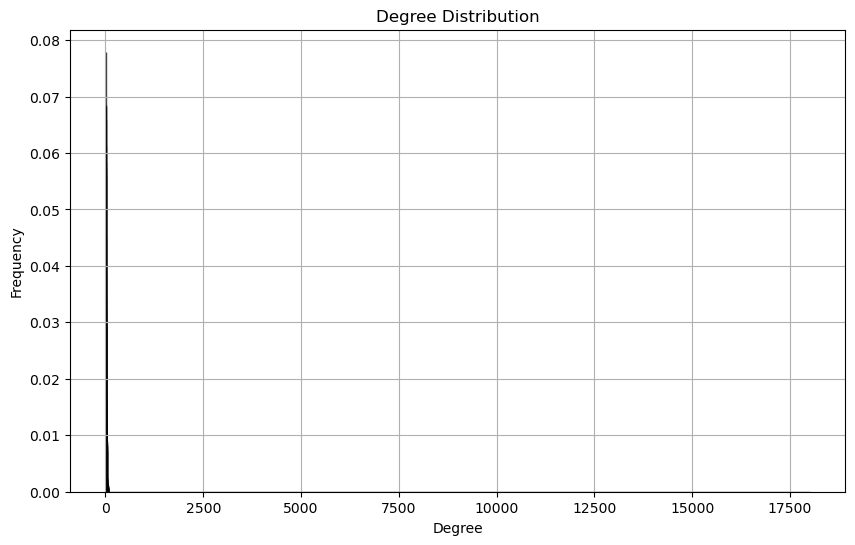

In [7]:
import numpy as np
import struct
from scipy.sparse import csr_matrix
from cupyx.scipy.sparse import csr_matrix as cupy_csr_matirx
from cuml.manifold.lanczos import eig_lanczos
from cupyx.scipy.sparse.linalg import eigsh as cupy_eigsh
from scipy.sparse.linalg import eigsh as scipy_eigsh
import cupy as cp
import time
from scipy.sparse.linalg import ArpackError
import matplotlib.pyplot as plt


# np.set_printoptions(linewidth=np.inf, precision=7, suppress=True, threshold=np.inf, floatmode='fixed')

def load_vectors(filename):
    with open(filename, 'rb') as f:
        # Read the size of each vector
        size_rows = struct.unpack('Q', f.read(8))[0]
        size_cols = struct.unpack('Q', f.read(8))[0]
        size_vals = struct.unpack('Q', f.read(8))[0]

        # Read the vectors
        rows = np.fromfile(f, dtype=np.int32, count=size_rows)
        cols = np.fromfile(f, dtype=np.int32, count=size_cols)
        vals = np.fromfile(f, dtype=np.float32, count=size_vals)

    return rows, cols, vals

# Load the vectors
rows, cols, vals = load_vectors('/home/coder/raft/cpp/build/latest/gtests/sparse.bin')

print(rows.shape)
print("Rows:", rows)
print("Cols:", cols)
print("Vals:", vals)

k=70
n_components=k
n=32768
ncv = min(max(2 * k, k + 32), n - 1)
ncv = ncv-k

X = csr_matrix((vals, (rows, cols)), shape=(n, n), dtype=np.float32)
X_gpu = cupy_csr_matirx(X, dtype=cp.float32)
print(X.shape, X.nnz)


# Compute the degree of each node
degrees = np.asarray(X.sum(axis=1)).flatten()
print(degrees.max())
# Plot degree distribution
plt.figure(figsize=(10, 6))
plt.hist(degrees, bins=range(1, int(degrees.max()) + 2), density=True, alpha=0.75, edgecolor='black')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution')
plt.grid(True)
plt.show()

(10000, 10000) 9411042


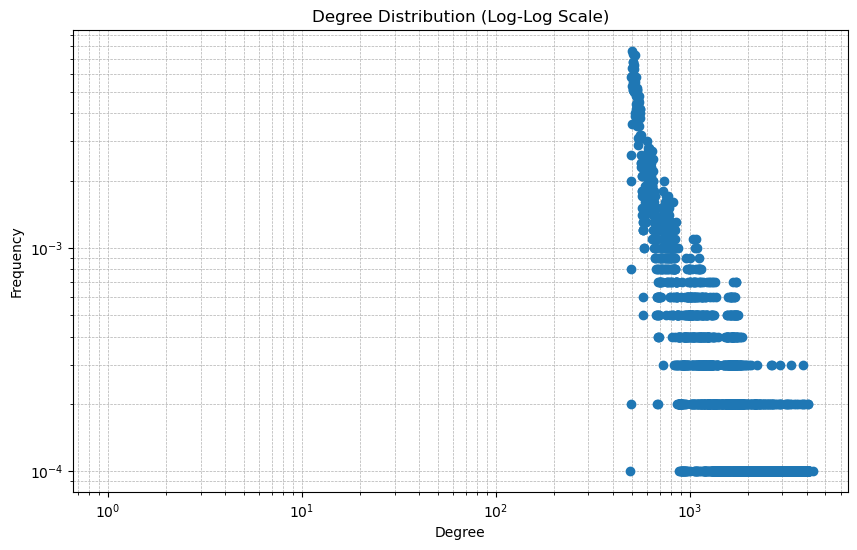

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix

# Generate a power-law cluster graph to illustrate
import networkx as nx
G = nx.powerlaw_cluster_graph(10000, 500, 0.1)  # Example graph
degrees = np.array([d for n, d in G.degree()])

A = nx.to_scipy_sparse_array(G)

print(A.shape, A.nnz)

# Compute degree distribution
degree_count = np.bincount(degrees)
degree = np.arange(len(degree_count))
degree_distribution = degree_count / degree_count.sum()

# Log-log plot
plt.figure(figsize=(10, 6))
plt.loglog(degree[degree > 0], degree_distribution[degree > 0], marker='o', linestyle='None')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution (Log-Log Scale)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


hi
(4096, 4096) 799172 0.04763436317443848


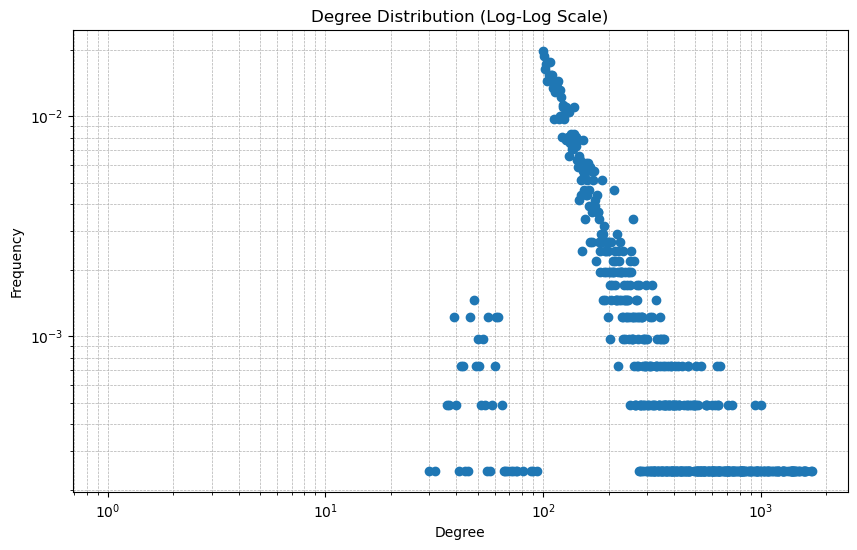

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix

# Generate a power-law cluster graph to illustrate
import networkx as nx
G = nx.powerlaw_cluster_graph(4096, 100, 1)  # Example graph
degrees = np.array([d for n, d in G.degree()])

print("hi")

A = nx.to_scipy_sparse_array(G)
# A = A + A.T # undirected graph so we don't need to symmetrize
# print(A.todense())
print(A.shape, A.nnz, A.nnz / (A.shape[0] * A.shape[1]))

# Compute degree distribution
degree_count = np.bincount(degrees)
degree = np.arange(len(degree_count))
degree_distribution = degree_count / degree_count.sum()

# Log-log plot
plt.figure(figsize=(10, 6))
plt.loglog(degree[degree >= 0], degree_distribution[degree >= 0], marker='o', linestyle='None')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution (Log-Log Scale)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

n_edges 1024
119 (32, 32)
1 31


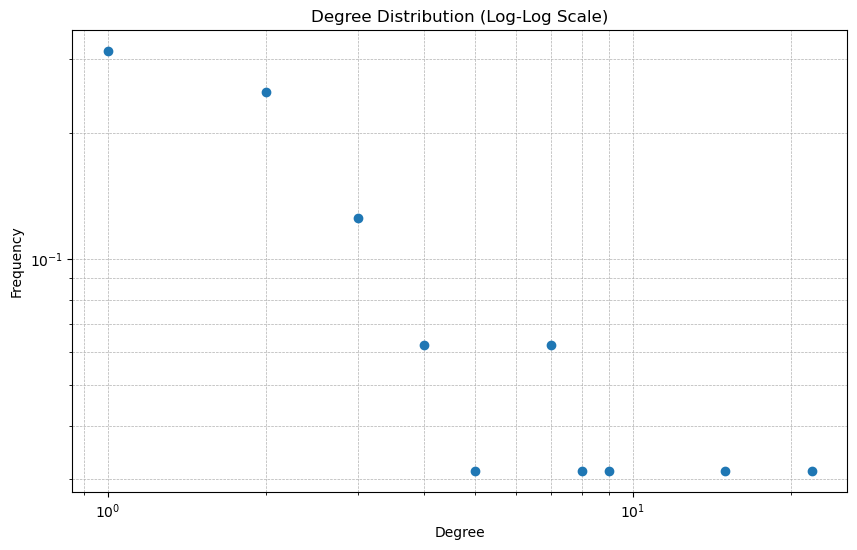

In [34]:
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt

import numpy as np
from cupyx.scipy.sparse import csr_matrix as cucsr_matrix
import cupy as cp
from pylibraft.random import rmat
import time

np.set_printoptions(linewidth=np.inf, precision=7, suppress=True, threshold=np.inf, floatmode='fixed')

r_scale = 5
c_scale = 5
sparsity = 1
n_edges = int(sparsity * (2**r_scale * 2**c_scale))
print("n_edges", n_edges)

theta_len = max(r_scale, c_scale) * 4

seed = 1234
cp.random.seed(seed)

out = cp.empty((n_edges, 2), dtype=cp.int32)
theta = cp.random.random_sample(theta_len, dtype=cp.float32)

rmat(out, theta, r_scale, c_scale, seed=seed, handle=None)

# Extract source and destination node IDs
src_nodes = out[:, 0]
dst_nodes = out[:, 1]
data = cp.ones(src_nodes.shape[0])

# Compute the number of nodes
num_nodes = 2 ** max(r_scale, c_scale)

adj_matrix_csr = cucsr_matrix((data, (src_nodes, dst_nodes)), shape=(num_nodes, num_nodes), dtype=cp.float32)
adj_matrix_csr = adj_matrix_csr + adj_matrix_csr.T
print(adj_matrix_csr.nnz, adj_matrix_csr.shape)

A_cupy = adj_matrix_csr
A_cupy = A_cupy + A_cupy.T

# Compute degrees directly from the sparse matrix
degrees = cp.diff(A_cupy.indptr).astype(cp.int32)

# Convert degrees to numpy for further operations
degrees_np = cp.asnumpy(degrees)
print(np.count_nonzero(degrees_np == 0), np.count_nonzero(degrees_np))

# Compute degree distribution
degree_count = np.bincount(degrees_np)
degree = np.arange(len(degree_count))
degree_distribution = degree_count / degree_count.sum()

# Convert degree and degree_distribution to numpy arrays for plotting
degree = np.array(degree)
degree_distribution = np.array(degree_distribution)

# Log-log plot
plt.figure(figsize=(10, 6))
plt.loglog(degree[degree >= 0], degree_distribution[degree >= 0], marker='o', linestyle='None')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution (Log-Log Scale)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


In [87]:
T=[[ 0.7005104 ,  0.4539907 ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
 [ 0.4539907 ,  0.2153991 ,  0.2771796 ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
 [ 0.        ,  0.2771796 , -0.4789046 ,  0.6733835 ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
 [ 0.        ,  0.        ,  0.6733835 ,  0.22829413,  0.3115136 ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
 [ 0.        ,  0.        ,  0.        ,  0.3115136 ,  0.02320576,  0.28689304,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
 [ 0.        ,  0.        ,  0.        ,  0.        ,  0.28689304, -0.31908998,  0.37882853,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
 [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.37882853, -0.2967012 ,  0.13606478,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
 [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.13606478, -0.13099788,  0.04181018,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
 [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.04181018,  0.08181366,  0.00000003,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
 [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.00000003,  0.       ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
 [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        , -0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
 [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
 [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
 [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        , -0.        ,  0.        ],
 [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        , -0.        ]]


import numpy as np
T = np.asarray(T)
# Define the new size
new_size = T.shape[0] + 1

# Create a new matrix of zeros with the new size
T_extended = np.zeros((new_size, new_size))

# Copy the original matrix into the top-left corner of the new matrix
T_extended[:T.shape[0], :T.shape[1]] = T

eigenvalues, eigenvectors = np.linalg.eigh(T_extended)
print(eigenvalues)

# # Construct the diagonal matrix of eigenvalues
# Lambda = np.diag(eigenvalues)

# # Reconstruct the original matrix
# reconstructed_matrix = eigenvectors @ Lambda @ eigenvectors.T
# print(reconstructed_matrix)


[-0.9713847 -0.7533046 -0.2318690 -0.0895986 -0.0000000 -0.0000000  0.0000000  0.0000000 -0.0000000 -0.0000000  0.0000000  0.0906129  0.2331420  0.7459314  1.0000001]


In [69]:
u = [-0.       ,  -0. ,        -0.      ,   -0.     ,    -0.00000001 , 0.    ,     -0.00000001 ,-0.00000001 , 0.00000001, -0.00000001, -0.    ,      0.00000001 , 0.00000001 , 0.00000001, -0.00000001 ,-0.00000001]
beta = 3.3955313e-08

u = np.asarray(u, dtype=np.float32)
print(u/beta)

[-0.0000000 -0.0000000 -0.0000000 -0.0000000 -0.2945047  0.0000000 -0.2945047 -0.2945047  0.2945047 -0.2945047 -0.0000000  0.2945047  0.2945047  0.2945047 -0.2945047 -0.2945047]


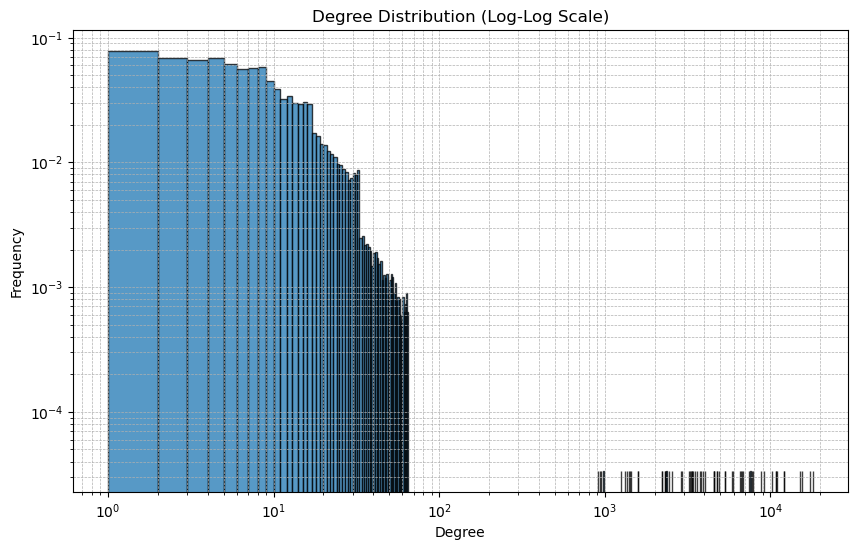

In [9]:
plt.figure(figsize=(10, 6))
plt.hist(degrees, bins=range(1, int(degrees.max()) + 2), density=True, alpha=0.75, edgecolor='black')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution (Log-Log Scale)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


In [1]:
def _set_diag(laplacian, value, norm_laplacian):
    """Set the diagonal of the laplacian matrix and convert it to a
    sparse format well suited for eigenvalue decomposition.

    Parameters
    ----------
    laplacian : {ndarray, sparse matrix}
        The graph laplacian.

    value : float
        The value of the diagonal.

    norm_laplacian : bool
        Whether the value of the diagonal should be changed or not.

    Returns
    -------
    laplacian : {array, sparse matrix}
        An array of matrix in a form that is well suited to fast
        eigenvalue decomposition, depending on the band width of the
        matrix.
    """
    n_nodes = laplacian.shape[0]
    # We need all entries in the diagonal to values
    if not sparse.issparse(laplacian):
        if norm_laplacian:
            laplacian.flat[:: n_nodes + 1] = value
    else:
        laplacian = laplacian.tocoo()
        if norm_laplacian:
            diag_idx = laplacian.row == laplacian.col
            laplacian.data[diag_idx] = value
        # If the matrix has a small number of diagonals (as in the
        # case of structured matrices coming from images), the
        # dia format might be best suited for matvec products:
        n_diags = np.unique(laplacian.row - laplacian.col).size
        if n_diags <= 7:
            # 3 or less outer diagonals on each side
            laplacian = laplacian.todia()
        else:
            # csr has the fastest matvec and is thus best suited to
            # arpack
            laplacian = laplacian.tocsr()
    return laplacian

In [4]:
%reload_ext autoreload
%autoreload 2
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
from cuml.manifold.lanczos import eig_lanczos
from scipy.sparse.linalg import lobpcg
from scipy.sparse import random as sparse_random
from scipy.sparse import rand as sparse_rand
from scipy.sparse.linalg import eigs, eigsh
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.neighbors import kneighbors_graph
from scipy.sparse.csgraph import laplacian as csgraph_laplacian
from scipy import sparse
import time
from sklearn.manifold import SpectralEmbedding
from cuml.manifold import SpectralEmbedding as cuSpectralEmbedding
from scipy.sparse.linalg import ArpackError
from cupyx.scipy.sparse.linalg import eigsh as cueigsh
from cupyx.scipy.sparse import csr_matrix as cucsr_matrix

np.set_printoptions(precision=4, suppress=True, threshold=50)


n_samples = 1000
n_features = 1000
n_components = 100
n_neighbors = 10
sparsity = 0.02
start = time.time()
rng = np.random.default_rng(42)
X = sparse_random(n_samples, n_features, density=sparsity, random_state=rng, dtype=np.float32)
# print(time.time() - start)
# start = time.time()
X = X + X.T
print(time.time() - start)
print(X.shape, X.dtype, type(X))
print("nnz", X.nnz)
cuX = cucsr_matrix(X)
print(cuX.dtype)


# X = X.astype(np.float32)
# X = X + X.T
# X = kneighbors_graph(
#     X, n_neighbors, include_self=True, mode="distance",
# )
# X = X + X.T
# matrix1 = X

# laplacian, dd = csgraph_laplacian(
#     X, normed=False, return_diag=True
# )
# laplacian = _set_diag(laplacian, 1, False)
# # X = laplacian + laplacian.T
# X = laplacian

# print(X)

times = {"Lobpcg Sklearn Time (s)": [], "Eigsh Sklearn Time (s)": [], "Raft Time (s)": [], "Cupy eigsh Sklearn Time (s)": []}
values = {"Lobpcg Sklearn Time (s)": [], "Eigsh Sklearn Time (s)": [], "Raft Time (s)": [], "Cupy eigsh Sklearn Time (s)": []}

# import rmm
# pool = rmm.mr.PoolMemoryResource(
#     rmm.mr.CudaMemoryResource(),
#     initial_pool_size=2**32,
#     maximum_pool_size=4*2**32,
# )
# rmm.mr.set_current_device_resource(pool)

for i in range(5):
    r = np.random.RandomState(42)
    X0 = r.standard_normal(size=(n_samples, n_components + 1))
    
    start = time.time()
    eigenvalues, eigenvectors = lobpcg((X), X=X0, tol=1e-9, largest=False, maxiter=10000)
    times["Lobpcg Sklearn Time (s)"].append(time.time() - start)
    values["Lobpcg Sklearn Time (s)"].append(eigenvalues)
    
    try:
        start = time.time()
        eigenvalues, eigenvectors = eigsh((X), k=n_components, which="SA", maxiter=10000, tol=1e-9)
        times["Eigsh Sklearn Time (s)"].append(time.time() - start)
        values["Eigsh Sklearn Time (s)"].append(eigenvalues)
    except ArpackError as e:
        print(e)
    
    start = time.time()
    eigenvalues, eigenvectors, eig_iters = eig_lanczos((X), n_components, 42, dtype=np.float32, maxiter=1000, tol=1e-9, conv_n_iters=4, conv_eps=0.001, restartiter=50, handle=None)
    times["Raft Time (s)"].append(time.time() - start)
    values["Raft Time (s)"].append(eigenvalues)
    
    
    start = time.time()
    eigenvalues, eigenvectors = cueigsh(cuX, k=n_components, which="SA", maxiter=10000, tol=1e-9)
    times["Cupy eigsh Sklearn Time (s)"].append(time.time() - start)
    values["Cupy eigsh Sklearn Time (s)"].append(eigenvalues)
# dot1_double, dot2_double, dot3_double = np.dot(eigenvectors[:, 0], eigenvectors[:, 1]), np.dot(eigenvectors[:, 0], eigenvectors[:, 2]), np.dot(eigenvectors[:, 1], eigenvectors[:, 2])
# print(dot1_double, dot2_double, dot3_double)


for (k1, v1), (k2, v2) in zip(times.items(), values.items()):
    print(k1, sum(v1)/len(v1))
    print(v2[0])


# start = time.time()
# s = SpectralEmbedding(n_components=n_components, n_neighbors=n_neighbors, random_state=42, eigen_solver="lobpcg")
# s.affinity_matrix_ = matrix1
# out = s.fit_transform(matrix1)
# print("SpectralEmbedding Time (s)", time.time() - start)

# matrix1 = matrix1.tocoo()
# start = time.time()
# s = cuSpectralEmbedding(n_components=n_components, n_neighbors=n_neighbors, random_state=42, rows=matrix1.row, cols=matrix1.col, vals=matrix1.data, nnz=len(matrix1.row))
# out = s.fit_transform(matrix1.toarray())
# print("Raft SpectralEmbedding Time (s)", time.time() - start)


0.008818387985229492
(1000, 1000) float32 <class 'scipy.sparse._csr.csr_matrix'>
nnz 39639
float32


MemoryError: std::bad_alloc: out_of_memory: CUDA error at: /home/coder/.conda/envs/rapids/include/rmm/mr/device/cuda_memory_resource.hpp:60: cudaErrorMemoryAllocation out of memory

In [45]:
start = time.time()
eigenvalues, eigenvectors, eig_iters = eig_lanczos(X, 3, 42, dtype=np.float32, maxiter=1000, tol=1e-9, conv_n_iters=4, conv_eps=0.01, restartiter=400, handle=None)
print("Raft Time (s)", time.time() - start)
print(eigenvalues, eig_iters)
print(eigenvectors)
dot1_double, dot2_double, dot3_double = np.dot(eigenvectors[:, 0], eigenvectors[:, 1]), np.dot(eigenvectors[:, 0], eigenvectors[:, 2]), np.dot(eigenvectors[:, 1], eigenvectors[:, 2])
print(np.array([dot1_double, dot2_double, dot3_double]))

seed 42
Raft Time (s) 5.14221978187561
[-51.2329 -51.1512 -51.0847] 124
[[ 0.0031 -0.0001 -0.0014]
 [-0.0044 -0.001  -0.0038]
 [ 0.0034  0.0015  0.0013]
 ...
 [ 0.002  -0.0009 -0.0019]
 [ 0.0034 -0.0021 -0.0018]
 [ 0.0007  0.0026 -0.0028]]
[ 0. -0. -0.]


In [42]:
from scipy.sparse.linalg import eigs, eigsh
start = time.time()
eigenvalues, eigenvectors = eigsh(X, k=3, which="SA", maxiter=100, tol=0.01)
print("Eigsh Sklearn Time (s)", time.time() - start)
print(eigenvalues)
print(eigenvectors)
dot1_double, dot2_double, dot3_double = np.dot(eigenvectors[:, 0], eigenvectors[:, 1]), np.dot(eigenvectors[:, 0], eigenvectors[:, 2]), np.dot(eigenvectors[:, 1], eigenvectors[:, 2])
print(np.array([dot1_double, dot2_double, dot3_double]))

Eigsh Sklearn Time (s) 120.89733219146729
[-50.6569 -49.9981 -49.983 ]
[[ 0.0011 -0.0043  0.005 ]
 [-0.0024  0.0084 -0.0036]
 [-0.0012 -0.0015 -0.0039]
 ...
 [ 0.0056 -0.0055  0.0004]
 [-0.0037  0.0026 -0.0027]
 [-0.003  -0.0043  0.0014]]
[ 0. -0. -0.]


In [44]:
r = np.random.RandomState(42)
X0 = r.standard_normal(size=(n_samples, n_components + 1))

start = time.time()
eigenvalues, eigenvectors = lobpcg(X, X=X0, tol=0.1, largest=False, maxiter=100)
print("Lobpcg Sklearn Time (s)", time.time() - start)
print(eigenvalues)
print(eigenvectors)

KeyboardInterrupt: 

In [37]:
from cupyx.scipy.sparse.linalg import eigsh as cueigsh
cuX = cucsr_matrix(X)

In [39]:
from cupyx.scipy.sparse.linalg import eigsh as cueigsh
from cupyx.scipy.sparse import csr_matrix as cucsr_matrix

start = time.time()
eigenvalues, eigenvectors = cueigsh(cuX, k=3, which="SA", maxiter=100, tol=0.001)
print("Cupy eigsh Sklearn Time (s)", time.time() - start)
print(eigenvalues)
print(eigenvectors)
dot1_double, dot2_double, dot3_double = np.dot(eigenvectors[:, 0], eigenvectors[:, 1]), np.dot(eigenvectors[:, 0], eigenvectors[:, 2]), np.dot(eigenvectors[:, 1], eigenvectors[:, 2])
print(dot1_double, dot2_double, dot3_double)



Eigsh Sklearn Time (s) 1.5047388076782227
[-51.0874 -51.0472 -51.017 ]
[[-0.0028 -0.0026 -0.0045]
 [ 0.0028  0.0016  0.0035]
 [ 0.0029  0.0005 -0.0005]
 ...
 [ 0.0043  0.0022  0.0021]
 [-0.003  -0.0036 -0.003 ]
 [ 0.003  -0.0088 -0.006 ]]
-0.0029701418 -0.0014672056 -0.009164453


In [51]:
import numpy as np
from scipy.sparse import diags

def generate_tridiagonal_matrix(n, mean=0, std=1):
    """
    Generate a large sparse tridiagonal matrix with normally distributed diagonal entries.
    
    Parameters:
    n (int): Size of the matrix (n x n).
    mean (float): Mean of the normal distribution for diagonal entries.
    std (float): Standard deviation of the normal distribution for diagonal entries.
    
    Returns:
    scipy.sparse.csr_matrix: Sparse tridiagonal matrix in CSR format.
    """
    # Generate the diagonal entries
    main_diag = np.random.normal(loc=mean, scale=std, size=n)
    
    # Generate the sub-diagonal and super-diagonal entries
    off_diag = np.random.normal(loc=mean, scale=std, size=n-1)
    
    # Create the sparse tridiagonal matrix
    diagonals = [off_diag, main_diag, off_diag]
    offsets = [-1, 0, 1]
    sparse_matrix = diags(diagonals, offsets, shape=(n, n), format='csr')
    
    return sparse_matrix

n = 100
tridiagonal_matrix = generate_tridiagonal_matrix(n)
print(tridiagonal_matrix)
# Convert to dense format for verification (only for small matrices)
dense_matrix = tridiagonal_matrix.toarray()

# Check if the matrix is symmetric
is_symmetric = np.allclose(dense_matrix, dense_matrix.T)

print(f"The matrix is symmetric: {is_symmetric}")

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 299998 stored elements and shape (100000, 100000)>
  Coords	Values
  (0, 0)	-1.161800846694018
  (0, 1)	-0.042400693787638104
  (1, 0)	-0.042400693787638104
  (1, 1)	-0.03908537005609671
  (1, 2)	0.27308032808376276
  (2, 1)	0.27308032808376276
  (2, 2)	-0.7958440161423127
  (2, 3)	1.0022925538478584
  (3, 2)	1.0022925538478584
  (3, 3)	-0.5591235294797839
  (3, 4)	-0.9558101747874178
  (4, 3)	-0.9558101747874178
  (4, 4)	0.5813940005459223
  (4, 5)	-2.2742399709316223
  (5, 4)	-2.2742399709316223
  (5, 5)	0.8027574089743723
  (5, 6)	-1.5570759749000602
  (6, 5)	-1.5570759749000602
  (6, 6)	0.47029335852435933
  (6, 7)	0.669775608341218
  (7, 6)	0.669775608341218
  (7, 7)	-0.8588042441818531
  (7, 8)	-0.46632773895408974
  (8, 7)	-0.46632773895408974
  (8, 8)	-0.2765081313798636
  :	:
  (99991, 99991)	-0.9434375655915473
  (99991, 99992)	0.1497153026997709
  (99992, 99991)	0.1497153026997709
  (99992, 99992)	1.87451589632710

KeyboardInterrupt: 

In [54]:
from scipy.sparse.linalg import eigs, eigsh
start = time.time()
eigenvalues, eigenvectors = eigsh(tridiagonal_matrix, k=3, which="SA", maxiter=100, tol=0.001)
print("Eigsh Sklearn Time (s)", time.time() - start)
print(eigenvalues)
print(eigenvectors)
dot1_double, dot2_double, dot3_double = np.dot(eigenvectors[:, 0], eigenvectors[:, 1]), np.dot(eigenvectors[:, 0], eigenvectors[:, 2]), np.dot(eigenvectors[:, 1], eigenvectors[:, 2])
print(np.array([dot1_double, dot2_double, dot3_double]))

Eigsh Sklearn Time (s) 0.271151065826416
[-5.5744 -5.3756 -5.3042]
[[-0.  0. -0.]
 [-0.  0. -0.]
 [-0.  0. -0.]
 ...
 [ 0. -0.  0.]
 [-0.  0. -0.]
 [-0.  0. -0.]]
[-0. -0. -0.]


In [62]:
start = time.time()
eigenvalues, eigenvectors, eig_iters = eig_lanczos(tridiagonal_matrix, 3, 42, dtype=np.float32, maxiter=1000, tol=1e-9, conv_n_iters=4, conv_eps=0.001, restartiter=400, handle=None)
print("Raft Time (s)", time.time() - start)
print(eigenvalues, eig_iters)
print(eigenvectors)
dot1_double, dot2_double, dot3_double = np.dot(eigenvectors[:, 0], eigenvectors[:, 1]), np.dot(eigenvectors[:, 0], eigenvectors[:, 2]), np.dot(eigenvectors[:, 1], eigenvectors[:, 2])
print(np.array([dot1_double, dot2_double, dot3_double]))
print(np.count_nonzero(eigenvectors[:, 1]), eigenvectors[:, 1].shape)
print(eigenvectors[:, 1][0], eigenvectors[:, 1].shape)

seed 42
Raft Time (s) 0.8112988471984863
[-5.5744 -5.3756 -5.304 ] 75
[[ 0. -0.  0.]
 [ 0. -0.  0.]
 [-0. -0. -0.]
 ...
 [-0.  0. -0.]
 [-0.  0. -0.]
 [-0.  0. -0.]]
[ 0. -0. -0.]
100000 (100000,)
-4.595364e-10 (100000,)
